# Setup

In [3]:
# Imports

import itertools
import pickle
import random
import shutil
import warnings
from pathlib import Path

import logomaker
import matplotlib.animation as animation
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt  # needs `ipympl` for interactive plots
import numpy as np
import pandas as pd
import polars as pl  # ver=0.20, needs `pyarrow` and `xlsx2csv` packages
import seaborn as sns
import umap
from Bio import motifs
from Bio.Seq import Seq
from matplotlib.lines import Line2D
from matplotlib.transforms import ScaledTranslation
from matplotlib.widgets import LassoSelector
from matplotlib_venn import venn2
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from natsort import natsorted
from scipy.spatial import ConvexHull
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.contrib import tzip
from tqdm.notebook import tqdm  # needs `ipywidgets` package

**Remember to review all paths in the Config section below.**

In [ ]:
# Config

# Main directories

# project_dir = Path("/path/to/carmen-analysis")
project_dir = Path("/data/teamgdansk/apalkowski/carmen-analysis")

data_dir = project_dir.joinpath("data")
figures_dir = project_dir.joinpath("figures")
temp_dir = project_dir.joinpath("temp")

data_pub_dir = data_dir.joinpath("to-be-published")

data_subs_dir = data_dir.joinpath("subsidiary-files")

figures_gen_dir = figures_dir.joinpath("script-generated")
figures_main_dir = figures_gen_dir.joinpath("main-panels")
figures_supp_dir = figures_gen_dir.joinpath("supplementary")

# Core source files

# Elements of the CARMEN database (might exist outside of this project directory)
db_main_file = data_dir.joinpath("carmen-main.parquet")
db_main_col_pep = "Peptide"  # column name
db_main_col_haplo = "Haplotype"  # column name
db_main_col_netmhcpan = "Netmhcpan_binder"  # column name
db_main_list_sep = ","

# Haplotype frequencies from NMDP Registry Haplotype Frequencies database
freqs_dir = data_dir.joinpath("nmdp-hla-frequencies")
freqs_pop_desc_file = freqs_dir.joinpath("populations-description.csv")
freqs_pop_desc_col_pop_code = "Population_code"  # column name
freqs_pop_desc_col_desc = "Description"  # column name
freqs_pop_desc_col_a_b_drb1 = "A_B_DRB1_count"  # column name
freqs_pop_desc_col_c = "C_count"  # column name
freqs_pop_codes = pl.read_csv(freqs_pop_desc_file)[
    freqs_pop_desc_col_pop_code
].to_list()
# The following files are available from the database website (https://frequency.nmdp.org)
freqs_a_org_file = freqs_dir.joinpath("A.xlsx")
freqs_b_org_file = freqs_dir.joinpath("B.xlsx")
freqs_c_org_file = freqs_dir.joinpath("C.xlsx")
freqs_abc_org_file = freqs_dir.joinpath("A~C~B.xlsx")
freqs_col_a = "A"  # column name
freqs_col_b = "B"  # column name
freqs_col_c = "C"  # column name
freqs_org_cols_freqs = [f"{c}_freq" for c in freqs_pop_codes]  # column names

# MHC Motif Atlas peptides, available from the project website (http://mhcmotifatlas.org)
motif_atlas_peps_src_file = data_dir.joinpath("data_classI_all_peptides.txt")

# Files produced outside of this notebook

main_samples_file = data_subs_dir.joinpath("main-output-table-1.tsv")
main_samples_file_2 = data_subs_dir.joinpath("main-output-table-2.tsv")
main_samples_col_sample_name = "Sample"  # column name
main_samples_col_peptides = "Peptides"  # column name
main_samples_col_binding_alleles = "Binding_alleles"  # column name
main_samples_col_umap_x = "x"  # column name
main_samples_col_umap_y = "y"  # column name
main_samples_col_label = "label"  # column name
main_samples_list_sep = ","

# Modified MHC Motif Atlas peptides
motif_atlas_peps_file = data_subs_dir.joinpath("motif-atlas-peptides.csv")
motif_atlas_peps_col_allele = "Allele"  # column name
motif_atlas_peps_col_peptide = "Peptide"  # column name

main_motif_atlas_emb_file = data_subs_dir.joinpath(
    "main-embeddings_MHCMotifA_pssms.tsv"
)
main_motif_atlas_emb_col_allele = "Allele"  # column name
main_motif_atlas_emb_col_x = "0"  # column name
main_motif_atlas_emb_col_y = "1"  # column name
main_motif_atlas_emb_col_peps = "Peptides"  # column name
main_motif_atlas_emb_list_sep = ","

# Machine learning peptide binding prediction results
ml_models_main_dir = data_subs_dir.joinpath("ml-models")
ml_metrics_main_dir = ml_models_main_dir.joinpath("metrics")


def ml_metrics_model_dir(suffix):
    """Directory path."""
    return ml_metrics_main_dir.joinpath(f"model{suffix}")


def ml_metrics_file_name(data_type, result_type, suffix, layers, heads):
    """File name."""
    return f"{data_type}_{result_type}{suffix}_layer{layers}_multihead{heads}"


def ml_metrics_metrics_file(data_type, suffix, layers, heads):
    """File path."""
    fn = ml_metrics_file_name(data_type, "metrics", suffix, layers, heads) + ".csv"
    return ml_metrics_model_dir(suffix).joinpath(fn)


ml_metrics_metrics_col_acc = "accuracy"  # column name
ml_metrics_metrics_col_sen = "sensitivity"  # column name
ml_metrics_metrics_col_spe = "specificity"  # column name


def ml_metrics_roc_file(data_type, suffix, layers, heads):
    """File path."""
    fn = ml_metrics_file_name(data_type, "roc", suffix, layers, heads) + ".csv"
    return ml_metrics_model_dir(suffix).joinpath(fn)


ml_metrics_roc_col_fpr = "x"  # column name
ml_metrics_roc_col_tpr = "y"  # column name


def ml_metrics_auc_file(data_type, suffix, layers, heads):
    """File path."""
    fn = ml_metrics_file_name(data_type, "auc", suffix, layers, heads) + ".txt"
    return ml_metrics_model_dir(suffix).joinpath(fn)


# Generated data files

# Files to be published

samples_pub_file = data_pub_dir.joinpath(
    "carmen-peptide-clusters-characteristics.parquet"
)
samples_pub_col_id = "ID"  # column name

samples_pub_pssms_file = data_pub_dir.joinpath("carmen-peptide-clusters-pssms.json")

# Subsidiary files

# Summarized characteristics of samples
samples_main_file = data_subs_dir.joinpath("samples-main.csv")
samples_supp_file = data_subs_dir.joinpath("samples-supp.csv")
samples_col_sample_name = "Sample_name"  # column name
samples_col_peptides = "Peptides"  # column name
samples_col_binding_alleles = "Binding_alleles"  # column name
samples_col_umap_x = "UMAP_x"  # column name
samples_col_umap_y = "UMAP_y"  # column name
samples_col_label = "Label"  # column name
samples_col_peptides_9 = "Peptides_9"  # column name
samples_col_binding_alleles_clean = "Binding_alleles_clean"  # column name
samples_cols_freqs_a = [f"Freq_{c}_A" for c in freqs_pop_codes]  # column names
samples_cols_freqs_b = [f"Freq_{c}_B" for c in freqs_pop_codes]  # column names
samples_cols_freqs_c = [f"Freq_{c}_C" for c in freqs_pop_codes]  # column names
samples_cols_freqs_abc_any = [
    f"Freq_{c}_ABC_any" for c in freqs_pop_codes
]  # column names
samples_cols_freqs_abc_all = [
    f"Freq_{c}_ABC_all" for c in freqs_pop_codes
]  # column names
samples_list_sep = ";"
samples_list_cols = [
    samples_col_peptides,
    samples_col_binding_alleles,
    samples_col_peptides_9,
    samples_col_binding_alleles_clean,
]

# UMAP model for the supplementary dataset
umap_reducer_supp_file = data_subs_dir.joinpath("umap-reducer-supp.pickle")

# Modified populations haplotype frequencies files
freqs_a_file = data_subs_dir.joinpath("pop-freqs-a.csv")
freqs_b_file = data_subs_dir.joinpath("pop-freqs-b.csv")
freqs_c_file = data_subs_dir.joinpath("pop-freqs-c.csv")
freqs_abc_file = data_subs_dir.joinpath("pop-freqs-abc.csv")
freqs_cols_freqs = [f"Freq_{c}" for c in freqs_pop_codes]  # column names

# Modified MHC Motif Atlas peptides
supp_motif_atlas_emb_file = data_subs_dir.joinpath("motif-atlas-supp-umap-emb.csv")
supp_motif_atlas_emb_col_allele = "Allele"  # column name
supp_motif_atlas_emb_col_x = "UMAP_x"  # column name
supp_motif_atlas_emb_col_y = "UMAP_y"  # column name


# Amino acids combinations in peptides
aa_combinations_dir = data_pub_dir.joinpath("aa-combinations")


def aa_combinations_file(n_pos):
    """File path."""
    return aa_combinations_dir.joinpath(f"aa-combinations-9aa-{n_pos}.csv")


aa_combinations_col_pos = "Positions"  # column name
aa_combinations_col_aa = "Amino_acids"  # column name
aa_combinations_col_pep = "Peptides"  # column name
aa_combinations_list_sep = ";"

# List of peptides per an HLA allele
peps_per_hla_file = data_subs_dir.joinpath("peptides-per-hla.csv")
peps_per_hla_col_allele = "Allele"  # column name
peps_per_hla_col_peps = "Peptides"  # column name
peps_per_hla_list_sep = ";"

# Other

peptide_len = 9

AMINO_ACIDS = [
    "A",
    "R",
    "N",
    "D",
    "C",
    "Q",
    "E",
    "G",
    "H",
    "I",
    "L",
    "K",
    "M",
    "F",
    "P",
    "S",
    "T",
    "W",
    "Y",
    "V",
]

# Matplotlib config
plt.rcdefaults()

main_font_size = 7  # Minimum text size: 5 pt.
label_font_size = 10

max_fig_width_double_col = 180  # mm (Nature standards)
max_fig_width_single_col = 89  # mm
# Figures can also be 120 mm in width where necessary.
# Page height is 279 mm. Content size is about 250/245/243 mm?
max_fig_height = 210  # mm
max_max_fig_height = 243  # mm

default_point_size = 15

axis_color = "0.15"

label_kwargs = dict(
    ha="right", va="center", fontsize=label_font_size, weight="bold", color="black"
)

plt.rcParams["text.color"] = axis_color
plt.rcParams["axes.labelcolor"] = axis_color
plt.rcParams["xtick.color"] = axis_color
plt.rcParams["ytick.color"] = axis_color
plt.rcParams["axes.edgecolor"] = axis_color

plt.rcParams["font.size"] = main_font_size
plt.rcParams["axes.labelsize"] = main_font_size
plt.rcParams["axes.titlesize"] = main_font_size
plt.rcParams["xtick.labelsize"] = main_font_size
plt.rcParams["ytick.labelsize"] = main_font_size
plt.rcParams["legend.fontsize"] = main_font_size
plt.rcParams["figure.labelsize"] = main_font_size
plt.rcParams["figure.titlesize"] = main_font_size

plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

plt.rcParams["savefig.transparent"] = True

# Not sure about these ones, need to test
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
plt.rcParams["svg.fonttype"] = "none"

# This is useful but may cause problems with Seaborn package
# plt.rcParams["figure.constrained_layout.use"] = True

# Setting random seed
random_seed = 42

random.seed(random_seed)
np.random.seed(random_seed)

## Auxiliary Functions

In [5]:
# Auxiliary functions


def figsize_in_mm(width, height):
    mm = 1 / 25.4  # millimeters in inches
    return (width * mm, height * mm)


def color_pallet(colors_n):
    if colors_n <= 20:
        colors = [plt.cm.tab20(i) for i in range(colors_n)]
    else:
        colors = [plt.cm.tab20(i) for i in range(20)]
        remaining_c_n = colors_n - 20
        if remaining_c_n <= 12:
            colors += [plt.cm.Set3(i) for i in range(remaining_c_n)]
        else:
            colors += [plt.cm.Set3(i) for i in range(12)]
            remaining_c_n -= 12
            if remaining_c_n <= 9:
                colors += [plt.cm.Pastel1(i) for i in range(remaining_c_n)]
            else:
                colors += [plt.cm.Pastel1(i) for i in range(9)]
                remaining_c_n -= 9
                colors_last = [
                    plt.cm.nipy_spectral(i)
                    for i in np.linspace(0.05, 1.0, remaining_c_n)
                ]
                random.shuffle(colors_last)
                colors += colors_last
    return colors


def calculate_centroid(coordinates):
    sum_x = sum(point[0] for point in coordinates)
    sum_y = sum(point[1] for point in coordinates)
    n = len(coordinates)
    centroid = (sum_x / n, sum_y / n)
    return centroid


def hobohm(peptides, threshold=0.63):
    peps_n = len(peptides)
    # seq_len = len(peptides[0])
    seq_len = 9

    aa_mat = np.array([list(p) for p in peptides])

    dist_mat = np.zeros((peps_n, peps_n))
    for i in range(peps_n - 1):
        d = 1 - np.sum(aa_mat[i] == aa_mat[i + 1 :], 1) / seq_len
        dist_mat[i, i + 1 :] = d
        dist_mat[i + 1 :, i] = d

    clusters = []
    not_assigned = np.full(peps_n, True)
    for i in range(peps_n):
        if not_assigned[i]:
            c = [i]
            ok_peps = dist_mat[i, i + 1 :] < (1 - threshold)
            c_a = np.nonzero(ok_peps & not_assigned[i + 1 :])[0] + 1 + i
            c += list(c_a)
            clusters.append(c)
            if c_a.shape[0] > 0:
                not_assigned[c_a] = False

    weights = np.zeros(peps_n)
    for c in clusters:
        c_len = len(c)
        for i in c:
            weights[i] = 1 / c_len

    alpha = np.full(seq_len, len(clusters) - 1)

    return alpha, weights


blosum62_matrix = {
    "A": [
        0.2901,
        0.0446,
        0.0427,
        0.041,
        0.065,
        0.0559,
        0.0552,
        0.0783,
        0.042,
        0.0471,
        0.0445,
        0.057,
        0.0522,
        0.0338,
        0.0568,
        0.1099,
        0.073,
        0.0303,
        0.0405,
        0.07,
    ],
    "R": [
        0.031,
        0.345,
        0.0449,
        0.0299,
        0.0163,
        0.0735,
        0.0497,
        0.0229,
        0.0458,
        0.0177,
        0.0243,
        0.1071,
        0.0321,
        0.019,
        0.0258,
        0.0401,
        0.0355,
        0.0227,
        0.028,
        0.0219,
    ],
    "N": [
        0.0256,
        0.0388,
        0.3169,
        0.069,
        0.0163,
        0.0441,
        0.0405,
        0.0391,
        0.0534,
        0.0147,
        0.0142,
        0.0415,
        0.0201,
        0.0169,
        0.0233,
        0.0541,
        0.0434,
        0.0152,
        0.0218,
        0.0165,
    ],
    "D": [
        0.0297,
        0.031,
        0.0831,
        0.3974,
        0.0163,
        0.0471,
        0.0902,
        0.0337,
        0.0382,
        0.0177,
        0.0152,
        0.0415,
        0.0201,
        0.0169,
        0.031,
        0.0489,
        0.0375,
        0.0152,
        0.0187,
        0.0178,
    ],
    "C": [
        0.0216,
        0.0078,
        0.009,
        0.0075,
        0.4837,
        0.0088,
        0.0074,
        0.0108,
        0.0076,
        0.0162,
        0.0162,
        0.0086,
        0.0161,
        0.0106,
        0.0103,
        0.0175,
        0.0178,
        0.0076,
        0.0093,
        0.0192,
    ],
    "Q": [
        0.0256,
        0.0484,
        0.0337,
        0.0299,
        0.0122,
        0.2147,
        0.0645,
        0.0189,
        0.0382,
        0.0133,
        0.0162,
        0.0535,
        0.0281,
        0.0106,
        0.0207,
        0.0332,
        0.0276,
        0.0152,
        0.0218,
        0.0165,
    ],
    "E": [
        0.0405,
        0.0523,
        0.0494,
        0.0914,
        0.0163,
        0.1029,
        0.2965,
        0.0256,
        0.0534,
        0.0177,
        0.0202,
        0.0708,
        0.0281,
        0.019,
        0.0362,
        0.0524,
        0.0394,
        0.0227,
        0.028,
        0.0233,
    ],
    "G": [
        0.0783,
        0.0329,
        0.0652,
        0.0466,
        0.0325,
        0.0412,
        0.035,
        0.5101,
        0.0382,
        0.0206,
        0.0213,
        0.0432,
        0.0281,
        0.0254,
        0.0362,
        0.0663,
        0.0434,
        0.0303,
        0.0249,
        0.0247,
    ],
    "H": [
        0.0148,
        0.0233,
        0.0315,
        0.0187,
        0.0081,
        0.0294,
        0.0258,
        0.0135,
        0.355,
        0.0088,
        0.0101,
        0.0207,
        0.0161,
        0.0169,
        0.0129,
        0.0192,
        0.0138,
        0.0152,
        0.0467,
        0.0082,
    ],
    "I": [
        0.0432,
        0.0233,
        0.0225,
        0.0224,
        0.0447,
        0.0265,
        0.0221,
        0.0189,
        0.0229,
        0.271,
        0.1154,
        0.0276,
        0.1004,
        0.0634,
        0.0258,
        0.0297,
        0.0533,
        0.0303,
        0.0436,
        0.1646,
    ],
    "L": [
        0.0594,
        0.0465,
        0.0315,
        0.028,
        0.065,
        0.0471,
        0.0368,
        0.0283,
        0.0382,
        0.1679,
        0.3755,
        0.0432,
        0.1968,
        0.1142,
        0.0362,
        0.0419,
        0.0651,
        0.053,
        0.0685,
        0.1303,
    ],
    "K": [
        0.0445,
        0.1202,
        0.0539,
        0.0448,
        0.0203,
        0.0912,
        0.0755,
        0.0337,
        0.0458,
        0.0236,
        0.0253,
        0.2781,
        0.0361,
        0.019,
        0.0413,
        0.0541,
        0.0454,
        0.0227,
        0.0312,
        0.0261,
    ],
    "M": [
        0.0175,
        0.0155,
        0.0112,
        0.0093,
        0.0163,
        0.0206,
        0.0129,
        0.0094,
        0.0153,
        0.0368,
        0.0496,
        0.0155,
        0.1606,
        0.0254,
        0.0103,
        0.0157,
        0.0197,
        0.0152,
        0.0187,
        0.0316,
    ],
    "F": [
        0.0216,
        0.0174,
        0.018,
        0.0149,
        0.0203,
        0.0147,
        0.0166,
        0.0162,
        0.0305,
        0.0442,
        0.0547,
        0.0155,
        0.0482,
        0.3869,
        0.0129,
        0.0209,
        0.0237,
        0.0606,
        0.1308,
        0.0357,
    ],
    "P": [
        0.0297,
        0.0194,
        0.0202,
        0.0224,
        0.0163,
        0.0235,
        0.0258,
        0.0189,
        0.0191,
        0.0147,
        0.0142,
        0.0276,
        0.0161,
        0.0106,
        0.4935,
        0.0297,
        0.0276,
        0.0076,
        0.0156,
        0.0165,
    ],
    "S": [
        0.085,
        0.0446,
        0.0697,
        0.0522,
        0.0407,
        0.0559,
        0.0552,
        0.0513,
        0.042,
        0.025,
        0.0243,
        0.0535,
        0.0361,
        0.0254,
        0.0439,
        0.2199,
        0.0927,
        0.0227,
        0.0312,
        0.0329,
    ],
    "T": [
        0.0499,
        0.0349,
        0.0494,
        0.0354,
        0.0366,
        0.0412,
        0.0368,
        0.0297,
        0.0267,
        0.0398,
        0.0334,
        0.0397,
        0.0402,
        0.0254,
        0.0362,
        0.082,
        0.2465,
        0.0227,
        0.028,
        0.0494,
    ],
    "W": [
        0.0054,
        0.0058,
        0.0045,
        0.0037,
        0.0041,
        0.0059,
        0.0055,
        0.0054,
        0.0076,
        0.0059,
        0.0071,
        0.0052,
        0.008,
        0.0169,
        0.0026,
        0.0052,
        0.0059,
        0.4924,
        0.028,
        0.0055,
    ],
    "Y": [
        0.0175,
        0.0174,
        0.0157,
        0.0112,
        0.0122,
        0.0206,
        0.0166,
        0.0108,
        0.0573,
        0.0206,
        0.0223,
        0.0173,
        0.0241,
        0.0888,
        0.0129,
        0.0175,
        0.0178,
        0.0682,
        0.3178,
        0.0206,
    ],
    "V": [
        0.0688,
        0.031,
        0.027,
        0.0243,
        0.0569,
        0.0353,
        0.0313,
        0.0243,
        0.0229,
        0.1767,
        0.0962,
        0.0328,
        0.0924,
        0.055,
        0.031,
        0.0419,
        0.071,
        0.0303,
        0.0467,
        0.2689,
    ],
}
blosum62_matrix = pd.DataFrame(blosum62_matrix).to_numpy()
background = {
    "A": 0.0755236,
    "R": 0.0515842,
    "N": 0.0453131,
    "D": 0.0530344,
    "C": 0.0169811,
    "Q": 0.0402483,
    "E": 0.0632002,
    "G": 0.0684442,
    "H": 0.0224067,
    "I": 0.0573156,
    "L": 0.0934327,
    "K": 0.0594192,
    "M": 0.0235696,
    "F": 0.0407819,
    "P": 0.0492775,
    "S": 0.0722465,
    "T": 0.0574747,
    "W": 0.0125173,
    "Y": 0.0319968,
    "V": 0.0652477,
}
background = pd.DataFrame(pd.Series(background)).T.to_numpy()


def strange_pssm(peptides, halfbits=False, hobohm_cluster=False, kl_logo=False):
    peps_n = len(peptides)
    # seq_len = len(peptides[0])
    seq_len = 9

    # Hobohm algorithm 1 sequence weighting
    if hobohm_cluster:
        alpha, weights = hobohm(peptides)
        alpha = alpha.reshape(-1, 1)
    else:
        alpha = peps_n - 1
        alpha = np.full((seq_len, 1), alpha)
        weights = np.ones(peps_n)
    weights = weights.reshape(-1, 1)

    beta = 200

    # peps = [Seq(p) for p in peptides]
    # m = motifs.create(peps, alphabet=AMINO_ACIDS)
    # # w_obs = pd.DataFrame(m.counts) / peps_n
    # w_obs = pd.DataFrame(m.pwm)
    # aa = w_obs.columns.to_list()
    # w_obs = w_obs.to_numpy()
    aa_mat = np.hsplit(np.array([list(p) for p in peptides]), seq_len)
    w_obs = []
    for i in range(seq_len):
        aa_w = np.sum((AMINO_ACIDS == aa_mat[i]) * weights, axis=0)
        w_obs.append(aa_w)
    w_obs /= np.sum(w_obs, 1).reshape(-1, 1)

    p_c = np.dot(w_obs, blosum62_matrix)
    probs = (alpha * w_obs + beta * p_c) / (alpha + beta)  # self.p
    p_not_0 = probs > 0
    g_ref = np.ones(probs.shape) * background
    if np.any(g_ref == 0):
        for i in np.nonzero(g_ref == 0)[0]:
            g_ref[i, :] = 1 / probs.shape[1]

    pssm = np.zeros(probs.shape)  # self.w
    pssm[probs == 0] = -99.999
    if halfbits:
        pssm[p_not_0] = np.log2(probs[p_not_0] / g_ref[p_not_0]) * 2
        if np.any(pssm < -99.999):
            pssm[pssm < -99.999] = -99.999
    else:
        pssm[p_not_0] = np.log2(probs[p_not_0] / g_ref[p_not_0])
        if np.any(pssm < -50):
            pssm[pssm < -50] = -50

    # Kullback-Leibler logo
    if kl_logo:
        pssm = np.sum(pssm * probs, axis=1).reshape(-1, 1) * probs * np.sign(pssm)

    return pd.DataFrame(pssm, columns=AMINO_ACIDS)


def info_pssm(peptides, alphabet=AMINO_ACIDS):
    peps = [Seq(p) for p in peptides]
    m = motifs.create(peps, alphabet=alphabet)
    m = pd.DataFrame(m.pwm)
    m = logomaker.transform_matrix(
        m, from_type="probability", to_type="information", pseudocount=0.0
    )
    return m


def motif_logo(
    peptides, ax=None, strange_logo=False, kl_logo=False, alphabet=AMINO_ACIDS
):
    if kl_logo or strange_logo:
        m = strange_pssm(peptides, halfbits=False, hobohm_cluster=True, kl_logo=kl_logo)
    else:
        m = info_pssm(peptides, alphabet=alphabet)

    m.index = [i + 1 for i in range(m.shape[0])]

    if kl_logo or strange_logo:
        baseline_width = 1.5
    else:
        baseline_width = 0.0

    logo = logomaker.Logo(
        m,
        color_scheme="weblogo_protein",
        stack_order="big_on_top",
        flip_below=False,
        center_values=False,
        baseline_width=baseline_width,
        vpad=0.05,
        ax=ax,
    )

    return logo


def cos_sim_clustermap_order(df):
    # Calculate cosine similarity for the populations
    cos_sim = cosine_similarity(df.transpose())
    cos_sim = pd.DataFrame(cos_sim, index=df.columns, columns=df.columns)
    # Produce a Seaborn cluster map
    cm = sns.clustermap(cos_sim, xticklabels=True, yticklabels=True)
    plt.close(cm.figure)
    # Get columns sorted based on the above heatmap clustering
    sorted_cols = [t.get_text() for t in cm.ax_heatmap.xaxis.get_ticklabels()]

    return sorted_cols


def are_sequence_residues_valid(sequence):
    return all(res in AMINO_ACIDS for res in sequence)


def clean_carmen_db_allele_list(allele_list):
    new_list = []
    for i in range(len(allele_list)):
        a = allele_list[i]
        ccount = a.count(":")
        if ccount == 0:
            continue
        elif ccount > 1:
            new_list.append(":".join(a.split(":")[:2]))
        elif a[-1].isalpha():
            new_list.append(a[:-1])
        else:
            new_list.append(a)
    return natsorted(set(new_list))

# Data Preparation

## Creating Subsidiary Files

This section should be run only once to re-create subsidiary files from core files for further analysis.

### Populations Haplotype Frequencies

This is just a minor modification to the original file to make it more convenient to read later.

In [ ]:
def clean_freqs(freqs, allele_cols, freqs_cols_org, freqs_cols_new):
    # Take only columns with population frequencies
    freqs = freqs[allele_cols + freqs_cols_org]
    new_cols = {c_org: c for c_org, c in zip(freqs_cols_org, freqs_cols_new)}
    freqs = freqs.rename(new_cols)

    # Simplify allele name formats to be comparable with samples' haplotypes
    freqs = freqs.with_columns(
        pl.col(allele_cols)
        .str.strip_suffix("L")
        .str.strip_suffix("N")
        .str.strip_suffix("Q")
        .str.strip_suffix("g")
    )

    return freqs


def read_mod_save_freqs(
    freqs_org_file, allele_cols, freqs_out_file, freqs_cols_org, freqs_cols_new
):
    freqs = pl.read_excel(freqs_org_file)
    freqs = clean_freqs(freqs, allele_cols, freqs_cols_org, freqs_cols_new)
    freqs.write_csv(freqs_out_file)


read_mod_save_freqs(
    freqs_abc_org_file,
    [freqs_col_a, freqs_col_b, freqs_col_c],
    freqs_abc_file,
    freqs_org_cols_freqs,
    freqs_cols_freqs,
)

read_mod_save_freqs(
    freqs_a_org_file,
    [freqs_col_a],
    freqs_a_file,
    freqs_org_cols_freqs,
    freqs_cols_freqs,
)

read_mod_save_freqs(
    freqs_b_org_file,
    [freqs_col_b],
    freqs_b_file,
    freqs_org_cols_freqs,
    freqs_cols_freqs,
)

read_mod_save_freqs(
    freqs_c_org_file,
    [freqs_col_c],
    freqs_c_file,
    freqs_org_cols_freqs,
    freqs_cols_freqs,
)

### Samples Characteristics

In [19]:
def add_pop_freqs_to_samples(samples):
    binding_alleles = (
        samples[samples_col_binding_alleles_clean]
        .str.split(samples_list_sep)
        .fill_null(list())
    )

    no_freq = pl.DataFrame(
        [[None] * len(freqs_cols_freqs)], freqs_cols_freqs, orient="row"
    )

    freqs_files_single = [freqs_a_file, freqs_b_file, freqs_c_file]
    allele_col_list = [freqs_col_a, freqs_col_b, freqs_col_c]
    new_freq_cols_list_1 = [
        samples_cols_freqs_a,
        samples_cols_freqs_b,
        samples_cols_freqs_c,
    ]

    for freq_f, allele_col, new_freq_cols in tzip(
        freqs_files_single,
        allele_col_list,
        new_freq_cols_list_1,
        desc="Single freqs files",
        leave=False,
    ):
        freqs = pl.read_csv(freq_f)

        sample_freqs = []

        for alleles in tqdm(binding_alleles, desc="Allele lists", leave=False):
            sample_f = freqs.filter(pl.col(allele_col).is_in(alleles))

            if sample_f.shape[0] != 0:
                sample_f = sample_f.select(pl.col(freqs_cols_freqs)).sum()
            else:
                sample_f = no_freq.clone()

            sample_freqs.append(sample_f)

        sample_freqs = pl.concat(sample_freqs).fill_nan(None)

        new_cols = {
            org_c: new_c for org_c, new_c in zip(freqs_cols_freqs, new_freq_cols)
        }
        sample_freqs = sample_freqs.rename(new_cols)

        samples = pl.concat([samples, sample_freqs], how="horizontal")

    del freqs, sample_freqs

    # Set operations for including alleles in whole haplotypes
    al_set_func_list = ["any", "all"]

    new_freq_cols_list_3 = [samples_cols_freqs_abc_any, samples_cols_freqs_abc_all]

    allele_cols = [freqs_col_a, freqs_col_b, freqs_col_c]

    freqs = pl.read_csv(freqs_abc_file)

    for al_set_func, new_freq_cols in tzip(
        al_set_func_list,
        new_freq_cols_list_3,
        desc="ABC freqs set operations",
        leave=False,
    ):
        sample_freqs = []

        for alleles in tqdm(binding_alleles, desc="Allele lists", leave=False):
            if al_set_func == "all":
                sample_f = freqs.filter(
                    pl.all_horizontal(pl.col(allele_cols).is_in(alleles))
                )
            elif al_set_func == "any":
                sample_f = freqs.filter(
                    pl.any_horizontal(pl.col(allele_cols).is_in(alleles))
                )
            else:
                raise ValueError("Unknown set operation")

            if sample_f.shape[0] != 0:
                sample_f = sample_f.select(pl.col(freqs_cols_freqs)).sum()
            else:
                sample_f = no_freq.clone()

            sample_freqs.append(sample_f)

        sample_freqs = pl.concat(sample_freqs).fill_nan(None)

        new_cols = {
            org_c: new_c for org_c, new_c in zip(freqs_cols_freqs, new_freq_cols)
        }
        sample_freqs = sample_freqs.rename(new_cols)

        samples = pl.concat([samples, sample_freqs], how="horizontal")

    return samples, new_freq_cols_list_1, new_freq_cols_list_3


def sort_samples(samples, new_freq_cols_list_1, new_freq_cols_list_3):
    col_order = (
        [
            samples_col_sample_name,
            samples_col_peptides,
            samples_col_binding_alleles,
            samples_col_peptides_9,
            samples_col_umap_x,
            samples_col_umap_y,
            samples_col_label,
            samples_col_binding_alleles_clean,
        ]
        + [c for cl in new_freq_cols_list_1 for c in cl]
        + [c for cl in new_freq_cols_list_3 for c in cl]
    )

    return samples.select(pl.col(col_order))

#### Main

In [ ]:
main_samples = pl.read_csv(main_samples_file, separator="\t")
main_samples_2 = pl.read_csv(main_samples_file_2, separator="\t")

samples_main = pl.concat(
    [main_samples, main_samples_2.select(pl.col(main_samples_col_peptides))],
    how="horizontal",
)
del main_samples, main_samples_2

samples_main = samples_main.with_columns(
    pl.col(
        [main_samples_col_binding_alleles, main_samples_col_peptides]
    ).str.replace_all(main_samples_list_sep, samples_list_sep)
)
new_cols = {
    main_samples_col_sample_name: samples_col_sample_name,
    main_samples_col_binding_alleles: samples_col_binding_alleles,
    main_samples_col_umap_x: samples_col_umap_x,
    main_samples_col_umap_y: samples_col_umap_y,
    main_samples_col_label: samples_col_label,
    main_samples_col_peptides: samples_col_peptides,
}
samples_main = samples_main.rename(new_cols).sort(samples_col_sample_name)

samples_main = samples_main.with_columns(
    pl.col([samples_col_peptides, samples_col_binding_alleles])
    .str.split(samples_list_sep)
    .list.unique()
    .map_elements(natsorted, return_dtype=pl.List(pl.String))
    .list.join(samples_list_sep)
)

# Add filtered columns for peptides and alleles

samples_main = samples_main.with_columns(
    pl.col(samples_col_peptides)
    .str.split(samples_list_sep)
    .fill_null(list())
    .map_elements(
        lambda x: [
            s for s in x if (are_sequence_residues_valid(s) and len(s) == peptide_len)
        ],
        return_dtype=pl.List(pl.String),
    )
    .list.sort()
    .list.join(samples_list_sep)
    .replace("", None)
    .alias(samples_col_peptides_9)
)

samples_main = samples_main.with_columns(
    pl.col(samples_col_binding_alleles)
    .str.split(samples_list_sep)
    .fill_null(list())
    .map_elements(clean_carmen_db_allele_list, return_dtype=pl.List(pl.String))
    .list.join(samples_list_sep)
    .replace("", None)
    .alias(samples_col_binding_alleles_clean)
)

# Add populations haplotype frequencies to samples

samples_main, new_freq_cols_list_1, new_freq_cols_list_3 = add_pop_freqs_to_samples(
    samples_main
)

# Sort columns and save

samples_main = sort_samples(samples_main, new_freq_cols_list_1, new_freq_cols_list_3)

samples_main.write_csv(samples_main_file)

del samples_main

#### Supplementary

This part might take more time to calculate.

In [ ]:
# Prepare core samples data

db_main = pl.read_parquet(db_main_file)

db_main = db_main.select(pl.col(["Sample_name", "Peptide", "Haplotype"])).sort(
    "Sample_name"
)

grouped = db_main.group_by("Sample_name", maintain_order=True)

samples_peptides = (
    grouped.agg(pl.col("Peptide"))
    .with_columns(
        pl.col("Peptide")
        .list.unique()
        .map_elements(natsorted, return_dtype=pl.List(pl.String))
        .list.join(samples_list_sep)
    )
    .rename({"Peptide": samples_col_peptides})
    .sort("Sample_name")
)

samples_hlas = (
    db_main[["Sample_name", "Haplotype"]]
    .unique()
    .with_columns(
        pl.col("Haplotype")
        .str.split(",")
        .list.unique()
        .map_elements(natsorted, return_dtype=pl.List(pl.String))
        .list.join(samples_list_sep)
    )
    .rename({"Haplotype": samples_col_binding_alleles})
    .sort("Sample_name")
)

samples_supp = samples_peptides.with_columns(samples_hlas[samples_col_binding_alleles])

del db_main, grouped, samples_hlas, samples_peptides

# Add filtered columns for peptides and alleles

samples_supp = samples_supp.with_columns(
    pl.col(samples_col_peptides)
    .str.split(samples_list_sep)
    .fill_null(list())
    .map_elements(
        lambda x: [
            s for s in x if (are_sequence_residues_valid(s) and len(s) == peptide_len)
        ],
        return_dtype=pl.List(pl.String),
    )
    .list.sort()
    .list.join(samples_list_sep)
    .replace("", None)
    .alias(samples_col_peptides_9)
)

samples_supp = samples_supp.with_columns(
    pl.col(samples_col_binding_alleles)
    .str.split(samples_list_sep)
    .fill_null(list())
    .map_elements(clean_carmen_db_allele_list, return_dtype=pl.List(pl.String))
    .list.join(samples_list_sep)
    .replace("", None)
    .alias(samples_col_binding_alleles_clean)
)

# Code peptides into PSSMs

# Select normalization mode
is_normalized = True

# Select PSSM type
halfbits = True
hobohm_cluster = True

samples_peptides = (
    samples_supp[samples_col_peptides_9].str.split(samples_list_sep).fill_null(list())
)

no_pssm = [None] * (peptide_len * len(AMINO_ACIDS))

samples_pssms = []

for peptides in tqdm(samples_peptides, leave=False):
    if len(peptides) == 0:
        samples_pssms.append(no_pssm)
        continue

    pssm = strange_pssm(
        peptides.to_list(), halfbits=halfbits, hobohm_cluster=hobohm_cluster
    ).to_numpy()

    if is_normalized:
        pssm = pssm / np.abs(pssm).max()

        # -1:1 option, for future reference
        # below_zero = pssm < 0
        # s = pssm[below_zero].reshape(-1, 1).tolist() + [[0.0]]
        # s = MinMaxScaler(feature_range=(-1, 0)).fit_transform(s)
        # pssm[below_zero] = s[:-1, 0]
        # s = pssm[~below_zero].reshape(-1, 1).tolist() + [[0.0]]
        # s = MinMaxScaler(feature_range=(0, 1)).fit_transform(s)
        # pssm[~below_zero] = s[:-1, 0]

    samples_pssms.append(pssm.flatten().tolist())

del samples_peptides

samples_pssms = pl.DataFrame(samples_pssms, orient="row")
new_cols = {f"column_{i}": f"PSSM_{i}" for i in range(samples_pssms.shape[1])}
pssm_cols = [f"PSSM_{i}" for i in range(samples_pssms.shape[1])]
samples_pssms = samples_pssms.rename(new_cols)

samples_pssms = pl.concat(
    [samples_supp.select(pl.col(samples_col_sample_name)), samples_pssms],
    how="horizontal",
)

# Create UMAP embedding

# UMAP config
umap_metric = "cosine"
umap_n_neighbors = 50
umap_min_dist = 0.4

samples_pssms_clean = samples_pssms.filter(
    ~pl.any_horizontal(pl.col(pssm_cols).is_null())
)

del samples_pssms

reducer = umap.UMAP(
    n_components=2,
    n_neighbors=umap_n_neighbors,
    min_dist=umap_min_dist,
    metric=umap_metric,
    random_state=random_seed,
    n_jobs=1,
).fit(samples_pssms_clean[pssm_cols].to_numpy())

# Save the reducer for later, in case
with open(umap_reducer_supp_file, "wb") as handle:
    pickle.dump(reducer, handle)

embedding = reducer.embedding_.copy()

embedding = pl.concat(
    [
        samples_pssms_clean.select(pl.col(samples_col_sample_name)),
        pl.DataFrame(
            {samples_col_umap_x: embedding[:, 0], samples_col_umap_y: embedding[:, 1]}
        ),
    ],
    how="horizontal",
)

del samples_pssms_clean

# Cluster the embedding points

n_clusters = 19
cluster_metric = "cosine"
cluster_linkage = "complete"
# cluster_memory = None
cluster_memory = str(temp_dir)

labels = (
    AgglomerativeClustering(
        n_clusters=n_clusters,
        memory=cluster_memory,
        metric=cluster_metric,
        linkage=cluster_linkage,
    )
    .fit(embedding[samples_col_umap_x, samples_col_umap_y].to_numpy())
    .labels_
)

samples_supp = pl.concat(
    [
        samples_supp,
        pl.concat(
            [embedding, pl.DataFrame({samples_col_label: labels})], how="horizontal"
        ),
    ],
    how="align",
)

del embedding, labels

# Add populations haplotype frequencies to samples

samples_supp, new_freq_cols_list_1, new_freq_cols_list_3 = add_pop_freqs_to_samples(
    samples_supp
)

# Sort columns and save

samples_supp = sort_samples(samples_supp, new_freq_cols_list_1, new_freq_cols_list_3)

samples_supp.write_csv(samples_supp_file)

del samples_supp

### MHC Motif Atlas Peptides

[MHC Motif Atlas](http://mhcmotifatlas.org) data to compare with the CARMEN database peptides. "All Ligands" option downloaded.

Create a file with UMAP embeddings for Motif Atlas peptides based on the supplementary model. Coordinates are saved per HLA allele.

In [ ]:
motif_atlas_peps = pl.read_csv(motif_atlas_peps_file)

# Code peptides into PSSMs

# Select normalization mode
is_normalized = True

# Select PSSM type
halfbits = True
hobohm_cluster = True

unique_alleles = natsorted(motif_atlas_peps[motif_atlas_peps_col_allele].unique())

alleles = []
allele_pssms = []

for u_a in tqdm(unique_alleles, leave=False):
    peptides = (
        motif_atlas_peps.filter(pl.col(motif_atlas_peps_col_allele) == u_a)[
            motif_atlas_peps_col_peptide
        ]
        .unique()
        .to_list()
    )
    peptides = sorted(peptides)

    pssm = strange_pssm(
        peptides, halfbits=halfbits, hobohm_cluster=hobohm_cluster
    ).to_numpy()

    if is_normalized:
        pssm = pssm / np.abs(pssm).max()

    alleles.append(u_a)
    allele_pssms.append(pssm.flatten().tolist())

del motif_atlas_peps, unique_alleles

alleles = pl.DataFrame({supp_motif_atlas_emb_col_allele: alleles})

allele_pssms = pl.DataFrame(allele_pssms, orient="row")
new_cols = {f"column_{i}": f"PSSM_{i}" for i in range(allele_pssms.shape[1])}
pssm_cols = [f"PSSM_{i}" for i in range(allele_pssms.shape[1])]
allele_pssms = allele_pssms.rename(new_cols)

# Create UMAP embedding

with open(umap_reducer_supp_file, "rb") as handle:
    umap_reducer_supp = pickle.load(handle)

embedding = umap_reducer_supp.transform(allele_pssms.to_numpy())

del umap_reducer_supp, allele_pssms

embedding = pl.DataFrame(
    {
        supp_motif_atlas_emb_col_x: embedding[:, 0],
        supp_motif_atlas_emb_col_y: embedding[:, 1],
    }
)

# Save to disk

pl.concat([alleles, embedding], how="horizontal").write_csv(supp_motif_atlas_emb_file)

del alleles, embedding

### Peptides Per HLA Allele

Values can be:

- HLA allele (e.g., `A*01:02`, `B*01:01:01`, `C*07`).
- `N`&mdash;null haplotype (sample should not bind to any HLA).
- *blank*&mdash;no information found.

In [ ]:
db_main = pl.read_parquet(db_main_file)

peps_per_hla = (
    db_main.select(
        pl.col(db_main_col_pep), pl.col(db_main_col_haplo).str.split(db_main_list_sep)
    )
    .explode(db_main_col_haplo)
    .group_by(db_main_col_haplo)
    .agg(pl.col(db_main_col_pep))
    .with_columns(
        pl.col(db_main_col_pep)
        .list.unique()
        .map_elements(lambda x: natsorted(x), return_dtype=pl.List(pl.String))
    )
)

del db_main

null_haplo = peps_per_hla.filter(pl.col(db_main_col_haplo).is_null())
not_null_haplo = peps_per_hla.filter(pl.col(db_main_col_haplo).is_not_null())
not_null_haplo = not_null_haplo.sort(
    pl.col(db_main_col_haplo).cast(
        pl.Enum(natsorted(not_null_haplo[db_main_col_haplo]))
    )
)

peps_per_hla = pl.concat([not_null_haplo, null_haplo]).rename(
    {db_main_col_haplo: peps_per_hla_col_allele, db_main_col_pep: peps_per_hla_col_peps}
)

del null_haplo, not_null_haplo

peps_per_hla = peps_per_hla.with_columns(
    pl.col(peps_per_hla_col_peps).list.join(peps_per_hla_list_sep)
)

peps_per_hla.write_csv(peps_per_hla_file)

del peps_per_hla

# Publishable Data

Details about the contents of the published files presented in this section can be found in the `README.md` file.

## Peptide Clusters Characteristics

In [4]:
cols_to_remove = [samples_col_peptides_9, samples_col_binding_alleles_clean]

samples_id_prefix = "P_"

samples = pl.read_csv(samples_main_file)
# samples = samples.select(pl.all().exclude(cols_to_remove))

samples_ids = pl.DataFrame(
    {samples_pub_col_id: [f"{samples_id_prefix}{i+1}" for i in range(samples.shape[0])]}
)

samples = pl.concat([samples_ids, samples], how="horizontal")

peptides_9 = samples.select(
    pl.col(samples_pub_col_id),
    pl.col(samples_col_peptides_9).str.split(samples_list_sep).fill_null(list()),
)

# Save without a couple of subsidiary columns
samples.select(pl.all().exclude(cols_to_remove)).write_parquet(samples_pub_file)

del samples, samples_ids

Save an additional file with PSSMs of the clusters

In [ ]:
json_list = []

for row in tqdm(
    peptides_9.iter_rows(named=True), total=peptides_9.shape[0], leave=False
):
    p_id = row[samples_pub_col_id]
    peptides = row[samples_col_peptides_9]
    if len(peptides) == 0:
        pssm_json = "{}"
    else:
        pssm = info_pssm(peptides)
        pssm.index = [i + 1 for i in range(pssm.shape[0])]
        pssm_json = pssm.to_json()

    json_str = f'"{p_id}":{pssm_json}'
    json_list.append(json_str)

del peptides_9

json_str = ",".join(json_list)
json_str = "{" + json_str + "}"

del json_list

with open(samples_pub_pssms_file, "w") as handle:
    handle.write(json_str)

del json_str

## Amino Acids Combinations in Peptides

This might take a while to prepare.

In [ ]:
def get_aa_on_positions(sequences, positions, first_pos_n=1):
    positions = [pos - first_pos_n for pos in positions]

    aa_combinations = []
    for seq in sequences:
        comb = "".join(np.array([a for a in seq])[positions])
        aa_combinations.append(comb)

    return aa_combinations


def gather_indices(strings):
    index_dict = {}
    for i, s in enumerate(strings):
        if s in index_dict:
            index_dict[s].append(i)
        else:
            index_dict[s] = [i]
    return index_dict

In [ ]:
pep_len = peptide_len

pep_col = samples_col_peptides_9

first_pos_n = 1

# Get unique and clean peptides of one length

samples = pl.read_csv(samples_supp_file)
samples = samples.with_columns(
    pl.col(samples_list_cols).str.split(samples_list_sep).fill_null(list())
)
samples = samples.filter(pl.col(pep_col).list.len() != 0)

peptides = []
for pep_list in samples[pep_col]:
    peptides.extend(pep_list)
peptides = np.array(sorted(set(peptides)))

del samples

# Get amino acids on all positions combinations

n_positions = [n for n in range(1, pep_len)]
# n_positions = [2, 3]

pos_indexes = [n for n in range(first_pos_n, pep_len + first_pos_n)]

aa_combs_all = []
positions_all = []

print("Gathering amino acids on positions")
for n_pos in tqdm(n_positions, leave=False, desc="Number of positions"):
    positions = list(itertools.combinations(pos_indexes, n_pos))

    aa_combs = []
    for pos in tqdm(positions, leave=False, desc="Specific positions"):
        c = get_aa_on_positions(peptides, pos, first_pos_n=first_pos_n)
        aa_combs.append(c)

    aa_combs_all.append(aa_combs)
    positions_all.append(positions)

# Create and save tables with all indices, amino acids, and associated peptides

new_cols = {
    "column_0": aa_combinations_col_pos,
    "column_1": aa_combinations_col_aa,
    "column_2": aa_combinations_col_pep,
}

sort_order = [aa_combinations_col_pos, aa_combinations_col_aa]

print("Creating final tables")
for positions, aa_combs, n_pos in zip(
    tqdm(positions_all, leave=False, desc="Positions"), aa_combs_all, n_positions
):
    aa_combinations = []
    for combs, pos in zip(tqdm(aa_combs, leave=False, desc="Combinations"), positions):
        pos_s = aa_combinations_list_sep.join([str(x) for x in pos])
        pep_indices = gather_indices(combs)
        df = pl.DataFrame(
            [
                [pos_s, aa_combinations_list_sep.join([a for a in comb])]
                + [aa_combinations_list_sep.join(peptides[idxs].tolist())]
                for comb, idxs in pep_indices.items()
            ],
            orient="row",
        )
        aa_combinations.append(df)
    aa_combinations = pl.concat(aa_combinations).rename(new_cols).sort(sort_order)
    aa_combinations.write_csv(aa_combinations_file(n_pos))

del aa_combs_all, positions_all, aa_combinations

# Figures

CARMEN paper figures generation. In many cases the code presented in this section produces only parts of the paper's figure panels. A portion of figure contents was created and polished manually in graphics editing software.

## Figure 2

### Clusters UMAP

#### Cluster Motifs on UMAP

This creates one core figure with the name `fig_name`, separate figures of motif for each label group in a directory named `fig_name`*-MOTIFS*, and a figure to help place the motifs under `fig_name`*-HELP*.

This figure has two variations depending on which `samples` and `motif_atlas_emb` files you load.

Final figure should be created in post-production by combining some of the above elements in a graphics editor software.

In [111]:
# Select which samples and MHC Atlas embeddings files to use

# Main
samples = pl.read_csv(samples_main_file)
atlas_emb_all = pl.read_csv(main_motif_atlas_emb_file, separator="\t")[
    main_motif_atlas_emb_col_allele,
    main_motif_atlas_emb_col_x,
    main_motif_atlas_emb_col_y,
]

# Supplementary
# samples = pl.read_csv(samples_supp_file)
# atlas_emb_all = pl.read_csv(supp_motif_atlas_emb_file)[
#     supp_motif_atlas_emb_col_allele,
#     supp_motif_atlas_emb_col_x,
#     supp_motif_atlas_emb_col_y,
# ]

In [112]:
# Load and select data

samples = samples.with_columns(
    pl.col(samples_list_cols).str.split(samples_list_sep).fill_null(list())
)

# Samples with UMAP data only
samples = samples.filter(pl.col(samples_col_label).is_not_null())

embedding = samples[samples_col_umap_x, samples_col_umap_y].to_numpy()
labels = samples[samples_col_label].to_numpy()
peptides = samples[samples_col_peptides_9].to_numpy()

motif_atlas_emb = atlas_emb_all[
    atlas_emb_all.columns[1], atlas_emb_all.columns[2]
].to_numpy()

In [118]:
# Figure config

fig_size = figsize_in_mm(max_fig_width_double_col * 0.45, max_fig_width_double_col * 0.45)

fig_name = "fig-2-umap-motifs"

logo_size_inside = (0.68, 0.48)
logo_size_outside_x = 0.6
logo_size_outside = figsize_in_mm(15 * logo_size_outside_x, 10 * logo_size_outside_x)

point_size = default_point_size
point_lw = 0.01

atlas_point_size = point_size * 1
atlas_point_alleles = ["A", "B", "C"]
atlas_point_markers = ["s", "^", "*"]

legend_markersize = 4
legend_font_size = 6

clust_border_color = "0.4"
clust_border_lw = 0.5

In [ ]:
def draw_cluster_motifs_umap(
    embedding,
    labels,
    peptides,
    fig_name,
    save_motifs,
    draw_borders,
    mark_clusters,
    draw_motifs,
    atlas_emb=None,
):
    unique_labels = sorted(set(labels))
    ul_len = len(unique_labels)
    colors = color_pallet(ul_len)

    fig = plt.figure(figsize=fig_size, layout="constrained")

    ax = fig.add_subplot()

    for lab, c in zip(unique_labels, colors):
        if lab == -1:
            p_color = "black"
        else:
            p_color = c
        mask = labels == lab
        data = embedding[mask, :]
        ax.scatter(
            data[:, 0],
            data[:, 1],
            s=point_size,
            alpha=1,
            facecolors=p_color,
            edgecolors="black",
            linewidths=point_lw,
        )

    if draw_borders:
        for lab in unique_labels:
            if lab == -1:
                continue
            mask = labels == lab
            data = embedding[mask, :]
            hull = ConvexHull(data)
            for simplex in hull.simplices:
                ax.plot(
                    data[simplex, 0],
                    data[simplex, 1],
                    color=clust_border_color,
                    lw=clust_border_lw,
                )

    if mark_clusters:
        for lab in unique_labels:
            if lab == -1:
                continue
            mask = labels == lab
            data = embedding[mask, :]

            x, y = calculate_centroid(data)

            txt = ax.text(x, y, str(lab), ha="center", va="center", size=10)
            txt.set_path_effects(
                [PathEffects.withStroke(linewidth=2, foreground="white")]
            )

    if save_motifs:
        m_dir = figures_main_dir.joinpath(f"{fig_name}-MOTIFS")
        m_dir.mkdir(parents=True, exist_ok=True)
        for lab in unique_labels:
            if lab == -1:
                continue
            mask = labels == lab
            clustered_peptides = []
            for pep_list in peptides[mask]:
                clustered_peptides.extend(pep_list)
            clustered_peptides = sorted(set(clustered_peptides))

            fig_motif = plt.figure(figsize=logo_size_outside, layout="constrained")
            ax_motif = fig_motif.add_subplot()

            ax_motif.spines[["right", "top"]].set_visible(True)

            logo = motif_logo(clustered_peptides, ax_motif)
            logo.ax.set_xticks([])
            logo.ax.set_yticks([])

            fig_motif.patch.set_alpha(0)

            # fig_motif.tight_layout()
            fig_motif.get_layout_engine().set(w_pad=0, h_pad=0)

            file_name = m_dir.joinpath(f"{lab}.pdf")
            fig_motif.savefig(file_name, transparent=False)

            plt.close(fig_motif)

    if draw_motifs:
        for lab in unique_labels:
            if lab == -1:
                continue
            mask = labels == lab
            data = embedding[mask, :]

            x, y = calculate_centroid(data)

            trans = fig.dpi_scale_trans + ScaledTranslation(x, y, ax.transData)

            motif_ax = inset_axes(
                ax,
                width="100%",
                height="100%",
                bbox_to_anchor=(
                    -logo_size_inside[0] / 2,
                    -logo_size_inside[1] / 2,
                    logo_size_inside[0],
                    logo_size_inside[1],
                ),
                bbox_transform=trans,
                borderpad=0,
                axes_kwargs={"anchor": "C"},
                loc="center",
            )

            motif_ax.spines[["right", "top"]].set_visible(True)

            clustered_peptides = []
            for pep_list in peptides[mask]:
                clustered_peptides.extend(pep_list)
            clustered_peptides = list(set(clustered_peptides))

            logo = motif_logo(clustered_peptides, motif_ax)
            logo.ax.set_xticks([])
            logo.ax.set_yticks([])

    if atlas_emb is not None:
        for a, m in zip(atlas_point_alleles, atlas_point_markers):
            mask = (
                atlas_emb_all.select(
                    pl.col(atlas_emb_all.columns[0]).str.starts_with(a)
                )
                .to_series()
                .to_list()
            )
            data = atlas_emb[mask]
            ae = ax.scatter(
                data[:, 0],
                data[:, 1],
                s=atlas_point_size,
                color="black",
                marker=m,
            )
            ae.set_path_effects(
                [PathEffects.withStroke(linewidth=1.8, foreground="white")]
            )

        legend_elements = [
            Line2D(
                [0],
                [0],
                marker="o",
                color="0.5",
                label="Peptide cluster",
                markersize=legend_markersize,
                linestyle="",
            )
        ]
        for a, m in zip(atlas_point_alleles, atlas_point_markers):
            leg_m = Line2D(
                [0],
                [0],
                marker=m,
                color="black",
                label=f"MHC Motif\nAtlas {a}* allele",
                markersize=legend_markersize,
                linestyle="",
            )
            legend_elements.append(leg_m)

        ax.legend(
            handles=legend_elements,
            loc="lower left",
            handletextpad=0.1,
            fontsize=legend_font_size,
            ncols=2,
            columnspacing=1,
        )

    ax.set_xticks([])
    ax.set_yticks([])

    _ = ax.set_xlabel("UMAP_1")
    _ = ax.set_ylabel("UMAP_2")

    # ax.patch.set_alpha(0)
    # fig.patch.set_alpha(0)

    # fig.tight_layout()
    fig.get_layout_engine().set(w_pad=0, h_pad=0)

    return fig

In [ ]:
# Core figure with separate motif figures

save_motifs = True
draw_borders = False
mark_clusters = False
draw_motifs = False

fig = draw_cluster_motifs_umap(
    embedding,
    labels,
    peptides,
    fig_name,
    save_motifs,
    draw_borders,
    mark_clusters,
    draw_motifs,
    atlas_emb=motif_atlas_emb,
)
file_name = figures_main_dir.joinpath(f"{fig_name}.pdf")
fig.savefig(file_name)

# Helper figure

save_motifs = False
draw_borders = True
mark_clusters = True
draw_motifs = False

fig = draw_cluster_motifs_umap(
    embedding,
    labels,
    peptides,
    fig_name,
    save_motifs,
    draw_borders,
    mark_clusters,
    draw_motifs,
)
file_name = figures_main_dir.joinpath(f"{fig_name}-HELP.pdf")
fig.savefig(file_name)

#### Cluster Frequencies on UMAP

This creates one core figure with the name `fig_name`, separate figures of motif for each label group in a directory named `fig_name`*-MOTIFS*, and a figure to help place the motifs under `fig_name`*-HELP*.

This figure has two variations depending on which `samples` file you load.

Final figure should be created in post-production by combining some of the above elements in a graphics editor software.

In [114]:
# Select which samples file to use

# Main
samples = pl.read_csv(samples_main_file)

# Supplementary
# samples = pl.read_csv(samples_supp_file)

# Select which frequency data to use

# samples_cols_freqs = samples_cols_freqs_a  # Only A* alleles
# samples_cols_freqs = samples_cols_freqs_b  # Only B* alleles
# samples_cols_freqs = samples_cols_freqs_c  # Only C* alleles
# samples_cols_freqs = samples_cols_freqs_abc_any  # A+B+C union
samples_cols_freqs = samples_cols_freqs_abc_all  # A+B+C intersection

In [115]:
# Load and select data

samples = samples.with_columns(
    pl.col(samples_list_cols).str.split(samples_list_sep).fill_null(list())
)

# Samples with UMAP data only
samples = samples.filter(pl.col(samples_col_label).is_not_null())

freqs = samples[samples_cols_freqs]
new_cols = {c: c.split("_")[1] for c in freqs.columns}
freqs = freqs.rename(new_cols)

freqs_not_null = freqs.select(pl.all_horizontal(pl.col("*").is_not_null())).to_series()

freqs = freqs.filter(freqs_not_null)
embedding = samples.filter(freqs_not_null)[
    samples_col_umap_x, samples_col_umap_y
].to_numpy()
labels = samples.filter(freqs_not_null)[samples_col_label].to_numpy()

In [116]:
# Figure config

fig_size = figsize_in_mm(max_fig_width_double_col * 0.45, max_fig_width_double_col * 0.4)

fig_name = "fig-2-umap-freqs"

heatmap_size_inside = (0.2, 0.2)
heatmap_size_outside = figsize_in_mm(6, 6)

point_size = default_point_size
point_lw = 0.01

clust_border_color = "0.4"
clust_border_lw = 0.5

In [117]:
def draw_cluster_freqs_umap(
    embedding,
    labels,
    freqs,
    fig_name,
    save_heatmaps,
    draw_borders,
    mark_clusters,
    draw_heatmaps,
):
    unique_labels = sorted(set(labels))
    ul_len = len(unique_labels)
    colors = color_pallet(ul_len)

    # Change the ordering based on clustering
    pop_order = cos_sim_clustermap_order(freqs)
    freqs_sorted = freqs.select(pl.col(pop_order))

    # Get min and max values of cosine similarity for all clusters
    v_min = np.inf
    v_max = -np.inf
    for lab in unique_labels:
        mask = labels == lab
        mask_freqs = freqs_sorted.to_numpy()[mask, :]
        cos_s = cosine_similarity(mask_freqs.T)
        c_min = cos_s.min()
        if c_min < v_min:
            v_min = c_min
        c_max = cos_s.max()
        if c_max > v_max:
            v_max = c_max

    fig = plt.figure(figsize=fig_size, layout="constrained")

    ax = fig.add_subplot()

    for lab, c in zip(unique_labels, colors):
        if lab == -1:
            p_color = "black"
        else:
            p_color = c
        mask = labels == lab
        data = embedding[mask, :]
        ax.scatter(
            data[:, 0],
            data[:, 1],
            s=point_size,
            alpha=1,
            facecolors=p_color,
            edgecolors="black",
            linewidths=point_lw,
        )

    if draw_borders:
        for lab in unique_labels:
            if lab == -1:
                continue
            mask = labels == lab
            data = embedding[mask, :]
            hull = ConvexHull(data)
            for simplex in hull.simplices:
                ax.plot(
                    data[simplex, 0],
                    data[simplex, 1],
                    color=clust_border_color,
                    lw=clust_border_lw,
                )

    if mark_clusters:
        for lab in unique_labels:
            if lab == -1:
                continue
            mask = labels == lab
            data = embedding[mask, :]

            x, y = calculate_centroid(data)

            txt = ax.text(x, y, str(lab), ha="center", va="center", size=10)
            txt.set_path_effects(
                [PathEffects.withStroke(linewidth=2, foreground="white")]
            )

    if save_heatmaps:
        hm_dir = figures_main_dir.joinpath(f"{fig_name}-HEATMAPS")
        hm_dir.mkdir(parents=True, exist_ok=True)

        for lab in unique_labels:
            if lab == -1:
                continue
            mask = labels == lab
            mask_freqs = freqs_sorted.to_numpy()[mask, :]
            cos_s = cosine_similarity(mask_freqs.T)

            fig_hm = plt.figure(figsize=heatmap_size_outside, layout="constrained")
            ax_hm = fig_hm.add_subplot()

            ax_hm.spines[["right", "top"]].set_visible(True)

            _ = ax_hm.imshow(
                cos_s,
                aspect="equal",
                vmin=v_min,
                vmax=v_max,
                interpolation="none",
                cmap="magma",
            )

            ax_hm.set_xticks([], labels=[])
            ax_hm.set_yticks([], labels=[])

            fig_hm.patch.set_alpha(0)

            fig_hm.get_layout_engine().set(w_pad=0, h_pad=0)

            file_name = hm_dir.joinpath(f"{lab}.pdf")
            fig_hm.savefig(file_name, transparent=False)

            plt.close(fig_hm)

    if draw_heatmaps:
        for lab in unique_labels:
            if lab == -1:
                continue
            mask = labels == lab
            data = embedding[mask, :]
            mask_freqs = freqs_sorted.to_numpy()[mask, :]
            cos_s = cosine_similarity(mask_freqs.T)

            x, y = calculate_centroid(data)

            trans = fig.dpi_scale_trans + ScaledTranslation(x, y, ax.transData)

            ax_hm = inset_axes(
                ax,
                width="100%",
                height="100%",
                bbox_to_anchor=(
                    -heatmap_size_inside[0] / 2,
                    -heatmap_size_inside[1] / 2,
                    heatmap_size_inside[0],
                    heatmap_size_inside[1],
                ),
                bbox_transform=trans,
                borderpad=0,
                axes_kwargs={"anchor": "C"},
                loc="center",
            )

            ax_hm.spines[["right", "top"]].set_visible(True)

            _ = ax_hm.imshow(
                cos_s,
                aspect="equal",
                vmin=v_min,
                vmax=v_max,
                interpolation="none",
                cmap="magma",
            )

            ax_hm.set_xticks([])
            ax_hm.set_yticks([])

    ax.set_xticks([])
    ax.set_yticks([])

    _ = ax.set_xlabel("UMAP_1")
    _ = ax.set_ylabel("UMAP_2")

    _ = fig.colorbar(
        plt.cm.ScalarMappable(norm=plt.Normalize(vmin=v_min, vmax=v_max), cmap="magma"),
        ax=ax,
        label="Cosine similarity",
        shrink=0.5,
    )

    fig.get_layout_engine().set(w_pad=0, h_pad=0)

    return fig

In [ ]:
# Core figure with separate motif figures

save_heatmaps = True
draw_borders = False
mark_clusters = False
draw_heatmaps = False

fig = draw_cluster_freqs_umap(
    embedding,
    labels,
    freqs,
    fig_name,
    save_heatmaps,
    draw_borders,
    mark_clusters,
    draw_heatmaps,
)
file_name = figures_main_dir.joinpath(f"{fig_name}.pdf")
fig.savefig(file_name)

# Helper figure

save_heatmaps = False
draw_borders = True
mark_clusters = True
draw_heatmaps = False

fig = draw_cluster_freqs_umap(
    embedding,
    labels,
    freqs,
    fig_name,
    save_heatmaps,
    draw_borders,
    mark_clusters,
    draw_heatmaps,
)
file_name = figures_main_dir.joinpath(f"{fig_name}-HELP.pdf")
fig.savefig(file_name)

#### Motif Atlas on UMAP

This is to add selected motifs from the MHC Motif Atlas to the main UMAP panel.

In [32]:
# Load necessary data

samples = pl.read_csv(samples_main_file)

samples = samples.with_columns(
    pl.col(samples_list_cols).str.split(samples_list_sep).fill_null(list())
)
samples = samples.filter(pl.col(samples_col_label).is_not_null())

embedding = samples[samples_col_umap_x, samples_col_umap_y].to_numpy()
labels = samples[samples_col_label].to_numpy()
peptides = samples[samples_col_peptides_9].to_numpy()
cluster_ids = samples[samples_col_sample_name].to_numpy()

unique_labels = sorted(set(labels))

atlas_emb_all = pl.read_csv(main_motif_atlas_emb_file, separator="\t")
atlas_emb_all = atlas_emb_all.with_columns(
    pl.col(main_motif_atlas_emb_col_peps).str.split(main_motif_atlas_emb_list_sep)
)

atlas_peptides = atlas_emb_all[main_motif_atlas_emb_col_peps].to_numpy()
atlas_alleles = atlas_emb_all[main_motif_atlas_emb_col_allele].to_numpy()
atlas_emb = atlas_emb_all[
    main_motif_atlas_emb_col_x, main_motif_atlas_emb_col_y
].to_numpy()

In [9]:
# Figure config

fig_size = figsize_in_mm(max_fig_width_double_col * 0.6, max_fig_width_double_col * 0.6)

fig_name = "fig-2-umap-motif-atlas"

# logo_size_inside = (0.68, 0.48)
logo_size_outside_x = 0.6
logo_size_outside = figsize_in_mm(15 * logo_size_outside_x, 10 * logo_size_outside_x)

point_size = default_point_size
point_lw = 0.01

atlas_point_size = point_size * 1.4

sampling_radius = 0.5

In [10]:
# Select which Motif Atlas alleles printed on the figure will be the center of sampling regions

# mask = (
#     (atlas_emb[:, 1] > 12.1)
#     & (atlas_emb[:, 1] < 13.37)
#     & (atlas_emb[:, 0] > -0.25)
#     & (atlas_emb[:, 0] < 0.69)
# )

# print(atlas_emb[mask])

sampling_centers = np.array(
    [
        [8.724858, 1.5084399],
        [-6.909805, 2.6264014],
        [0.38869002, 12.556277],
        [0.25, 4.72],
    ]
)

In [ ]:
# Check the selected sampling regions and save a helper figure to place the motifs later

# Unselect this if you want to manually pick and change the above points
# %matplotlib widget

ul_len = len(unique_labels)
colors = color_pallet(ul_len)

fig = plt.figure(figsize=fig_size, layout="constrained")

ax = fig.add_subplot()

for lab, c in zip(unique_labels, colors):
    if lab == -1:
        p_color = "black"
    else:
        p_color = c
    mask = labels == lab
    data = embedding[mask, :]
    ax.scatter(
        data[:, 0],
        data[:, 1],
        s=point_size,
        alpha=1,
        facecolors=p_color,
        edgecolors="black",
        linewidths=point_lw,
    )

for a, m in zip(["A", "B", "C"], ["s", "^", "*"]):
    mask = (
        atlas_emb_all.select(pl.col("Allele").str.starts_with(a)).to_series().to_list()
    )
    data = atlas_emb[mask]
    ae = ax.scatter(
        data[:, 0],
        data[:, 1],
        s=atlas_point_size,
        color="black",
        marker=m,
    )
    ae.set_path_effects([PathEffects.withStroke(linewidth=1.8, foreground="white")])

for i in range(len(atlas_emb)):
    x = atlas_emb[i, 0]
    y = atlas_emb[i, 1]
    a = atlas_alleles[i]
    ax.text(x, y, a, ha="left", va="bottom", color="0.5", fontsize=6)

ax.set_xticks([])
ax.set_yticks([])

_ = ax.set_xlabel("UMAP_1")
_ = ax.set_ylabel("UMAP_2")

# Add sampling regions

marker_color = "0.3"

for i in range(len(sampling_centers)):
    m_id = str(i + 1)
    small_circle_center = (sampling_centers[i, 0], sampling_centers[i, 1])
    small_circle = mpatches.Circle(
        small_circle_center,
        sampling_radius,
        color=marker_color,
        fill=False,
        linestyle="--",
        linewidth=2,
    )
    ax.add_artist(small_circle)
    ax.text(
        small_circle_center[0],
        small_circle_center[1] + sampling_radius,
        m_id,
        ha="center",
        va="bottom",
        fontsize=8,
        color=marker_color,
        fontweight="bold",
    )

fig.get_layout_engine().set(w_pad=0, h_pad=0)

file_name = figures_main_dir.joinpath(f"{fig_name}-HELP.pdf")
fig.savefig(file_name)

In [149]:
# Save motifs from selected sampling regions to a directory and save a file to see which IDs/alleles are within

m_dir = figures_main_dir.joinpath(f"{fig_name}-MOTIFS")
m_dir.mkdir(parents=True, exist_ok=True)

region_elements_desc = []

for i in range(len(sampling_centers)):
    m_id = str(i + 1)

    r_desc = f"{m_id}:\n"

    small_circle_center = (sampling_centers[i, 0], sampling_centers[i, 1])

    mask = (embedding[:, 0] - small_circle_center[0]) ** 2 + (
        embedding[:, 1] - small_circle_center[1]
    ) ** 2 <= sampling_radius**2
    sampled_peptides = []
    for peps in peptides[mask]:
        sampled_peptides += peps.tolist()
    sampled_peptides = sorted(set(sampled_peptides))

    fig_motif = plt.figure(figsize=logo_size_outside, layout="constrained")
    ax_motif = fig_motif.add_subplot()
    ax_motif.spines[["right", "top"]].set_visible(True)
    logo = motif_logo(sampled_peptides, ax_motif)
    logo.ax.set_xticks([])
    logo.ax.set_yticks([])
    fig_motif.patch.set_alpha(0)
    fig_motif.get_layout_engine().set(w_pad=0, h_pad=0)
    file_name = m_dir.joinpath(f"{m_id}-peptide-clusters.pdf")
    fig_motif.savefig(file_name, transparent=False)
    plt.close(fig_motif)

    selected_ids = ", ".join(natsorted(cluster_ids[mask].tolist()))
    r_desc += f"    Peptide clusters: {selected_ids}\n"

    mask_atlas = (atlas_emb[:, 0] - small_circle_center[0]) ** 2 + (
        atlas_emb[:, 1] - small_circle_center[1]
    ) ** 2 <= sampling_radius**2
    sampled_atlas_peptides = []
    for peps in atlas_peptides[mask_atlas]:
        sampled_atlas_peptides += peps.tolist()
    sampled_atlas_peptides = sorted(set(sampled_atlas_peptides))

    fig_motif = plt.figure(figsize=logo_size_outside, layout="constrained")
    ax_motif = fig_motif.add_subplot()
    ax_motif.spines[["right", "top"]].set_visible(True)
    logo = motif_logo(sampled_atlas_peptides, ax_motif)
    logo.ax.set_xticks([])
    logo.ax.set_yticks([])
    fig_motif.patch.set_alpha(0)
    fig_motif.get_layout_engine().set(w_pad=0, h_pad=0)
    file_name = m_dir.joinpath(f"{m_id}-motif-atlas.pdf")
    fig_motif.savefig(file_name, transparent=False)
    plt.close(fig_motif)

    selected_ids = ", ".join(natsorted(atlas_alleles[mask_atlas].tolist()))
    r_desc += f"    Motif atlas: {selected_ids}"

    region_elements_desc.append(r_desc)

region_elements_desc = "\n\n".join(region_elements_desc)
with open(figures_main_dir.joinpath(f"{fig_name}-HELP.txt"), "w") as handle:
    handle.write(region_elements_desc)

### CARMEN vs. MHC Motif Atlas Peptides Venn Diagram

In [130]:
# Load necessary data

samples = pl.read_csv(samples_supp_file)
samples = samples.with_columns(
    pl.col(samples_list_cols).str.split(samples_list_sep).fill_null(list())
)
samples = samples.filter(pl.col(samples_col_peptides_9).list.len() != 0)

peptides_carmen = []
for pep_list in samples[samples_col_peptides_9]:
    peptides_carmen.extend(pep_list)
peptides_carmen = set(peptides_carmen)

del samples

motif_atlas_peps = pl.read_csv(motif_atlas_peps_file)

peptides_atlas = set(motif_atlas_peps[motif_atlas_peps_col_peptide].to_list())

del motif_atlas_peps

In [131]:
# Figure config

fig_size = figsize_in_mm(max_fig_width_double_col * 0.2, max_fig_width_double_col * 0.1)

fig_name = "fig-2-carmen-vs-motif-atlas-venn"

venn_label_font_size = 6
venn_num_font_size = 5

In [ ]:
subsets = [peptides_carmen, peptides_atlas]

set_labels = ("CARMEN\npeptides", "MHC\nMotif Atlas\npeptides")

fig = plt.figure(figsize=fig_size, layout="constrained")
ax = fig.add_subplot()

v = venn2(
    subsets,
    ax=ax,
    set_labels=set_labels,
    set_colors=("C0", "C1"),
    alpha=1,
    subset_label_formatter=lambda n: f"{n:,}",
)

v.set_labels[0].set_fontsize(venn_label_font_size)
v.set_labels[1].set_fontsize(venn_label_font_size)

v.get_label_by_id("10").set_fontsize(venn_num_font_size)
v.get_label_by_id("11").set_fontsize(venn_num_font_size)
v.get_label_by_id("01").set_fontsize(venn_num_font_size)

# Change some label positions
p = v.set_labels[1].get_position()
v.set_labels[1].set_position((p[0] + 0.25, p[1] + 0.15))

p = v.get_label_by_id("10").get_position()
v.get_label_by_id("10").set_position((p[0] - 0.2, p[1]))

p = v.get_label_by_id("11").get_position()
v.get_label_by_id("11").set_position((p[0], p[1] + 0.2))

p = v.get_label_by_id("01").get_position()
v.get_label_by_id("01").set_position((p[0] + 0.25, p[1]))

fig.get_layout_engine().set(w_pad=0, h_pad=0)

file_name = figures_main_dir.joinpath(f"{fig_name}.pdf")
fig.savefig(file_name, bbox_inches="tight")

### AA Combination Frequency (single)

In [25]:
# Select the number of positions option to draw

n_positions = 2

# Select cut-off threshold for annotating the cumulative percent of peptides coverage

sum_margin = 90

In [26]:
# Prepare necessary data

pep_perc_col = "Peptides_perc"

pep_col = samples_col_peptides_9

pep_len = peptide_len

blank_char = "_"

first_pos_n = 1

# Get unique peptides
samples = pl.read_csv(samples_supp_file)
samples = samples.with_columns(
    pl.col(samples_list_cols).str.split(samples_list_sep).fill_null(list())
)
samples = samples.filter(pl.col(pep_col).list.len() != 0)
peptides = []
for pep_list in samples[pep_col]:
    peptides.extend(pep_list)
peptides = np.array(sorted(set(peptides)))
del samples

peptides_n = len(peptides)

# Prepare the amino acids combinations table
aa_combinations = pl.read_csv(aa_combinations_file(n_positions))
aa_combinations = aa_combinations.with_columns(
    pl.col(aa_combinations_col_pep).str.split(aa_combinations_list_sep)
)

if n_positions == 1:
    aa_combinations = aa_combinations.with_columns(
        pl.col(aa_combinations_col_pos).cast(pl.List(int)),
        pl.col(aa_combinations_col_aa).str.split(";"),
    )
else:
    aa_combinations = aa_combinations.with_columns(
        pl.col(aa_combinations_col_pos).str.split(";").cast(pl.List(int)),
        pl.col(aa_combinations_col_aa).str.split(";"),
    )

aa_combinations = aa_combinations.with_columns(
    (pl.col(aa_combinations_col_pep).list.len() / peptides_n * 100).alias(pep_perc_col)
)
aa_combinations = aa_combinations.sort(pep_perc_col, descending=True)

comb_n = aa_combinations.shape[0]

# Get the cumulative percent of peptides coverage
peptide_coverage = []
pep_c = set()
for pep_list in aa_combinations[aa_combinations_col_pep]:
    pep_c.update(pep_list)
    p_perc = len(pep_c) / peptides_n * 100
    if p_perc >= 100:
        n_left = aa_combinations.shape[0] - len(peptide_coverage)
        peptide_coverage.extend([100.0] * n_left)
        break
    peptide_coverage.append(p_perc)
peptide_coverage = np.array(peptide_coverage)

# Check the above threshold index
above_margin_idx = np.where(peptide_coverage >= sum_margin)[0][0]
# margin_diff = peptide_coverage[above_margin_idx] - sum_margin
# prev_diff = peptide_coverage[above_margin_idx] - peptide_coverage[above_margin_idx - 1]
# margin_val = above_margin_idx - margin_diff / prev_diff

below_margin_comb_perc = (above_margin_idx + 1) / comb_n * 100

# Make "fake" peptides from amino acids combinations below threshold only
blank_pep = np.array([blank_char] * pep_len)

below_margin_aa_combs = aa_combinations.slice(0, above_margin_idx + 1)

comb_peps = []
for i in range(below_margin_aa_combs.shape[0]):
    row = below_margin_aa_combs.row(i)
    new_pep = blank_pep.copy()
    new_pep[np.array(row[0]) - first_pos_n] = row[1]
    comb_peps.append("".join(new_pep))

# Create a PSSM table out of those peptides
comb_peps_pssm = info_pssm(comb_peps, alphabet=AMINO_ACIDS + [blank_char])
aa_cols = comb_peps_pssm.columns.to_list()
aa_cols.remove(blank_char)
comb_peps_pssm = comb_peps_pssm.loc[:, aa_cols]

In [30]:
# Figure config

# fig_size = figsize_in_mm(max_fig_width_double_col * 0.434, max_fig_width_double_col * 0.25)
fig_size = figsize_in_mm(94.853, 45.612)

fig_name = "fig-2-aa-combinations-coverage-single"

marker_size = 3

logo_x = 0.85
logo_size = (70 / 72 * logo_x, 50 / 72 * logo_x)  # Pixels
logo_location = (0.77, 0.71)
logo_font_size = 5

sum_annot_color = "black"
sum_annot_linewidth = 0.5
sum_annot_font_size = 6
sum_annot_arrow_x_offset = 100
sum_annot_arrow_lenth = 10
sum_annot_arrowprops = dict(
    facecolor=sum_annot_color, headwidth=3, headlength=3, width=0.1
)
sum_annot_arrow_pos_pep = 0.42
sum_annot_arrow_pos_comb = 0.26

ax2_linewidth = 1
ax2_color = "0.4"

axes_x_margin = 0.04

In [ ]:
# Make figure

fig = plt.figure(figsize=fig_size, layout="constrained")
ax = fig.add_subplot()

_ = ax.set_ylabel("Peptide coverage (%)")
_ = ax.set_xlabel("Amino acids and positions combination")

x = np.arange(comb_n)

# Make each indices combination have its own color
unique_pos = aa_combinations[aa_combinations_col_pos].unique(maintain_order=True)
unique_pos_n = len(unique_pos)

colors = color_pallet(unique_pos_n)

comb_colors = []
for pos in aa_combinations[aa_combinations_col_pos]:
    c_idx = np.where(unique_pos == pos.to_list())[0][0]
    comb_colors.append(colors[c_idx])

_ = ax.scatter(x, aa_combinations[pep_perc_col], s=marker_size, c=comb_colors)

# Cumulative frequency of occurrence

ax2 = ax.twinx()

ax2.spines["right"].set_visible(True)
ax2.spines["right"].set_color(ax2_color)
ax2.tick_params(axis="y", colors=ax2_color)

_ = ax2.set_ylabel("Cumulative peptide\ncoverage (%)", color=ax2_color, labelpad=0)

_ = ax2.plot(peptide_coverage, color=ax2_color, linewidth=ax2_linewidth)

# X% peptide sum annotations

_ = ax2.axvline(above_margin_idx, color=sum_annot_color, linewidth=sum_annot_linewidth)

ybound = ax.get_ybound()

_ = ax.annotate(
    f"{sum_margin}% of peptides",
    xy=(
        above_margin_idx + sum_annot_arrow_x_offset,
        ybound[0] + (ybound[1] - ybound[0]) * sum_annot_arrow_pos_pep,
    ),
    xytext=(sum_annot_arrow_lenth, 0),
    textcoords="offset points",
    ha="left",
    va="center",
    fontsize=sum_annot_font_size,
    color=sum_annot_color,
    arrowprops=sum_annot_arrowprops,
)

_ = ax.annotate(
    f"{below_margin_comb_perc:.2f}% of combinations\n("
    + r"$\bf{"
    + f"{above_margin_idx+1:,}"
    + "}$)",
    xy=(
        above_margin_idx + sum_annot_arrow_x_offset,
        ybound[0] + (ybound[1] - ybound[0]) * sum_annot_arrow_pos_comb,
    ),
    xytext=(sum_annot_arrow_lenth, 0),
    textcoords="offset points",
    ha="left",
    va="center",
    fontsize=sum_annot_font_size,
    color=sum_annot_color,
    arrowprops=sum_annot_arrowprops,
)

ax.margins(x=axes_x_margin)
ax2.margins(x=axes_x_margin)

# Motif logo

trans = fig.dpi_scale_trans + ScaledTranslation(
    logo_location[0], logo_location[1], ax.transAxes
)
motif_ax = inset_axes(
    ax,
    width="100%",
    height="100%",
    bbox_to_anchor=(
        -logo_size[0] / 2,
        -logo_size[1] / 2,
        logo_size[0],
        logo_size[1],
    ),
    bbox_transform=trans,
    borderpad=0,
    axes_kwargs={"anchor": "C"},
    loc="center",
)

motif_ax.spines[["right", "top"]].set_visible(True)

# Create a motif from amino acids combinations below threshold only
logo = logomaker.Logo(
    comb_peps_pssm,
    color_scheme="weblogo_protein",
    stack_order="big_on_top",
    flip_below=False,
    center_values=False,
    baseline_width=0,
    vpad=0.05,
    ax=motif_ax,
)

logo.ax.set_xticks(range(0, pep_len), labels=[str(i) for i in range(1, pep_len + 1)])
logo.ax.xaxis.set_tick_params(length=0)
_ = logo.ax.set_ylabel("Bits", size=logo_font_size, labelpad=0)
logo.ax.tick_params(axis="both", labelsize=logo_font_size)

fig.get_layout_engine().set(w_pad=0, h_pad=0, hspace=0, wspace=0)

file_name = figures_main_dir.joinpath(f"{fig_name}.pdf")
fig.savefig(file_name)

## Figure 3

### Machine Learning Metrics

In [23]:
# Select and describe the data to be loaded and visualized

data_ext = "ext"
data_indep = "indep"

m_d_name = "name"
m_d_color = "color"
m_d_linestyle = "linestyle"

models = {
    "": {m_d_name: "Source dataset", m_d_color: "C0", m_d_linestyle: "-"},
    "_rand_hla_train_only": {
        m_d_name: "Training HLA randomized",
        m_d_color: "C1",
        m_d_linestyle: "-",
    },
    "_rand_hla_test_only": {
        m_d_name: "Testing HLA randomized",
        m_d_color: "C2",
        m_d_linestyle: "-",
    },
    "_rand_hla_all": {
        m_d_name: "All HLA randomized",
        m_d_color: "C3",
        m_d_linestyle: "--",
    },
    "_rand_pep_train_only": {
        m_d_name: "Training peptides randomized",
        m_d_color: "C4",
        m_d_linestyle: "-",
    },
    "_rand_pep_test_only": {
        m_d_name: "Testing peptides randomized",
        m_d_color: "C5",
        m_d_linestyle: "-",
    },
    "_rand_pep_all": {
        m_d_name: "All peptides randomized",
        m_d_color: "C6",
        m_d_linestyle: "--",
    },
}

n_heads = range(1, 6)
n_layers = 1

models_s = [s for s in models.keys()]

In [30]:
# Load and sort the data


def read_auc(file_path):
    with open(file_path, "r") as handle:
        auc = handle.readline()
    return float(auc)


data_t = data_ext
# data_t = data_indep

mean_metrics = dict()
best_aucs = dict()
best_rocs = dict()

for s in models_s:
    metrics_all = pl.DataFrame()
    b_auc = 0
    b_head = -1
    for h in n_heads:
        metrics = pl.read_csv(ml_metrics_metrics_file(data_t, s, n_layers, h))
        metrics = metrics.slice(0, 1).select(
            pl.col(
                ml_metrics_metrics_col_acc,
                ml_metrics_metrics_col_sen,
                ml_metrics_metrics_col_spe,
            )
        )
        metrics_all = pl.concat([metrics_all, metrics])

        auc = read_auc(ml_metrics_auc_file(data_t, s, n_layers, h))
        if auc > b_auc:
            b_auc = auc
            b_head = h

    mean_metrics[s] = metrics_all.mean()

    best_aucs[s] = b_auc

    roc = pl.read_csv(ml_metrics_roc_file(data_t, s, n_layers, b_head))
    best_rocs[s] = roc

del roc

In [25]:
# Figure config

fig_size = figsize_in_mm(108.772, 45.373)

fig_name = "fig-3-ml-metrics"

width_ratios = [1, 0.5]

linewidth = 2

lines_ticks_fontsize = 7

legend_fontsize = 6

auc_round = 2

bar_width = 0.115

bars_ticks_fontsize = 7
bars_label_rot = 45

bars_labels = ["Accuracy", "Sensitivity", "Specificity"]

In [ ]:
# Create and save figure

fig = plt.figure(figsize=fig_size, layout="constrained")
gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=width_ratios)

bars_mid_pos = np.arange(len(bars_labels))
bar_start_pos = bars_mid_pos - (len(models_s) / 2) * bar_width + bar_width / 2

ax_roc = fig.add_subplot(gs[0])
ax_bars = fig.add_subplot(gs[1])

for i, s in enumerate(models_s):
    m_name = models[s][m_d_name]
    m_color = models[s][m_d_color]
    m_ls = models[s][m_d_linestyle]

    m_roc = best_rocs[s]
    m_auc = best_aucs[s]
    roc_label = f"{m_name} (AUC={round(m_auc,auc_round)})"
    _ = ax_roc.plot(
        m_roc[ml_metrics_roc_col_fpr],
        m_roc[ml_metrics_roc_col_tpr],
        color=m_color,
        label=roc_label,
        linewidth=linewidth,
        linestyle=m_ls,
    )

    m_acc = mean_metrics[s][ml_metrics_metrics_col_acc].item()
    m_sen = mean_metrics[s][ml_metrics_metrics_col_sen].item()
    m_spe = mean_metrics[s][ml_metrics_metrics_col_spe].item()
    _ = ax_bars.bar(
        bar_start_pos,
        [m_acc, m_sen, m_spe],
        color=m_color,
        width=bar_width,
        label=m_name,
    )
    bar_start_pos = bar_start_pos + bar_width

# ax_roc.legend(fontsize=legend_fontsize)

ax_roc.set_xlabel("False positive rate")
ax_roc.set_ylabel("True positive rate")

ax_roc.tick_params(axis="x", labelsize=lines_ticks_fontsize)
ax_roc.tick_params(axis="y", labelsize=lines_ticks_fontsize)

_ = ax_bars.set_xticks(bars_mid_pos, bars_labels)

ax_bars.tick_params(axis="x", labelsize=bars_ticks_fontsize, rotation=bars_label_rot)
ax_bars.tick_params(axis="y", labelsize=bars_ticks_fontsize)

fig.get_layout_engine().set(w_pad=0, h_pad=0, wspace=0.1)

file_name = figures_main_dir.joinpath(f"{fig_name}.pdf")
fig.savefig(file_name)

In [ ]:
# Save legend separately

fig_name = "fig-3-ml-metrics-legend"

fig_legend = plt.figure(figsize=fig_size, layout="constrained")
ax_legend = fig_legend.add_subplot()

_ = ax_legend.legend(handles=ax_roc.lines, fontsize=legend_fontsize)

file_name = figures_main_dir.joinpath(f"{fig_name}.pdf")
fig_legend.savefig(file_name)

### Clusters' Peptide Intersection (UMAP)

In [4]:
# Select which samples file to use

# Main
samples = pl.read_csv(samples_main_file)

# Supplementary
# samples = pl.read_csv(samples_supp_file)

In [5]:
# Prepare data

peptides_col = samples_col_peptides_9

samples = samples.with_columns(
    pl.col(samples_list_cols).str.split(samples_list_sep).fill_null(list())
)

# Samples with UMAP data only
samples = samples.filter(pl.col(samples_col_label).is_not_null())

embedding = samples[samples_col_umap_x, samples_col_umap_y].to_numpy()
labels = samples[samples_col_label].to_numpy()
peptides = samples[peptides_col].to_numpy()

del samples

unique_labels = sorted(set(labels))

all_cluster_peps_col_label = "Label"
all_cluster_peps_col_peps = "Peptides"
all_cluster_peps_col_x_perc = lambda label: f"Perc_{label}"
all_cluster_peps_cols_x_perc = [all_cluster_peps_col_x_perc(ul) for ul in unique_labels]

common_peps_perc_c_name = lambda label: f"C_{label}"

# Gather all cluster peptides
all_cluster_peps = []
for lab in unique_labels:
    mask = labels == lab
    clustered_peptides = []
    for pep_list in peptides[mask]:
        clustered_peptides.extend(pep_list)
    clustered_peptides = list(set(clustered_peptides))
    all_cluster_peps.append(clustered_peptides)

all_cluster_peps = pl.DataFrame(
    {
        all_cluster_peps_col_label: unique_labels,
        all_cluster_peps_col_peps: all_cluster_peps,
    }
)

# Calculate the percent of common peptides between clusters
common_peps_perc = []

for lab_org in unique_labels:
    row_org = all_cluster_peps.filter(
        pl.col(all_cluster_peps_col_label) == lab_org
    ).row(0, named=True)
    peps_org = row_org[all_cluster_peps_col_peps]

    peps_org_n = len(peps_org)

    c_peps_perc = []

    for lab in unique_labels:
        row = all_cluster_peps.filter(pl.col(all_cluster_peps_col_label) == lab).row(
            0, named=True
        )
        peps = row[all_cluster_peps_col_peps]

        n_common = len(set(peps_org).intersection(set(peps)))

        c_peps_perc.append(n_common / peps_org_n * 100)

    common_peps_perc.append(c_peps_perc)

all_cluster_peps = pl.concat(
    [all_cluster_peps, pl.DataFrame(common_peps_perc, all_cluster_peps_cols_x_perc)],
    how="horizontal",
)

# Prepare a table with common percentage
common_peps_perc = (
    all_cluster_peps.with_columns(
        pl.col(all_cluster_peps_col_label)
        .cast(pl.String)
        .map_elements(lambda x: common_peps_perc_c_name(x), return_dtype=pl.String)
    )
    .select(pl.col(all_cluster_peps_col_label), pl.col(all_cluster_peps_cols_x_perc))
    .rename({all_cluster_peps_col_x_perc(ul): common_peps_perc_c_name(ul) for ul in unique_labels})
    .to_pandas()
    .set_index(all_cluster_peps_col_label)
)
common_peps_perc.index.name = ""

del all_cluster_peps

In [ ]:
# See the original cluster IDs

fig = plt.figure(figsize=(5, 5), layout="constrained")

ax = fig.add_subplot()

colors = color_pallet(len(unique_labels))

for lab, c in zip(unique_labels, colors):
    if lab == -1:
        continue
    mask = labels == lab
    data = embedding[mask, :]

    hull = ConvexHull(data)
    ax.fill(
        [data[vert, 0] for vert in hull.vertices],
        [data[vert, 1] for vert in hull.vertices],
        color=c,
    )

    x, y = calculate_centroid(data)
    txt = ax.text(
        x,
        y,
        common_peps_perc_c_name(lab),
        ha="center",
        va="center",
        size=8,
        color="black",
    )

In [7]:
# Map original IDs to new ones to be changed later on

clust_id_map = {
    "C_7": "C_1",
    "C_14": "C_2",
    "C_5": "C_3",
    "C_9": "C_4",
    "C_1": "C_5",
    "C_0": "C_6",
    "C_6": "C_7",
    "C_11": "C_8",
    "C_3": "C_9",
    "C_8": "C_10",
    "C_13": "C_11",
    "C_2": "C_12",
    "C_10": "C_13",
    "C_4": "C_14",
    "C_12": "C_15",
}

In [8]:
# Figure config

fig_size = figsize_in_mm(40, 40)

fig_name = "fig-3-clusters-peptides-umap"

header_fontsize = 6
header_color = "black"

axis_label_fontsize = 5

In [9]:
# Save the common peptides table to add appropriate info later

# Round the numbers
dec_p = 1
common_peps_perc=common_peps_perc.round(dec_p)

common_peps_perc = common_peps_perc.rename(columns=clust_id_map).rename(
    index=clust_id_map
)

file_name = figures_main_dir.joinpath(f"{fig_name}-HELP.csv")
common_peps_perc.to_csv(file_name, index=True)

In [ ]:
# Create and save figure

fig = plt.figure(figsize=fig_size, layout="constrained")

ax = fig.add_subplot()

colors = color_pallet(len(unique_labels))

for lab, c in zip(unique_labels, colors):
    if lab == -1:
        continue
    mask = labels == lab
    data = embedding[mask, :]

    hull = ConvexHull(data)
    ax.fill(
        [data[vert, 0] for vert in hull.vertices],
        [data[vert, 1] for vert in hull.vertices],
        color=c,
    )

    x, y = calculate_centroid(data)
    txt = ax.text(
        x,
        y,
        clust_id_map[common_peps_perc_c_name(lab)],
        ha="center",
        va="center",
        size=header_fontsize,
        color=header_color,
    )

ax.margins(x=0.01, y=0.01)

ax.set_xticks([])
ax.set_yticks([])

_ = ax.set_xlabel("UMAP_1", fontsize=axis_label_fontsize)
_ = ax.set_ylabel("UMAP_2", fontsize=axis_label_fontsize)

fig.get_layout_engine().set(w_pad=0, h_pad=0)

file_name = figures_main_dir.joinpath(f"{fig_name}.pdf")
fig.savefig(file_name)

### Clusters' Peptide Intersection (All)

In [11]:
# Select which samples file to use

# Main
samples = pl.read_csv(samples_main_file)

# Supplementary
# samples = pl.read_csv(samples_supp_file)

In [12]:
# Prepare data

peptides_col = samples_col_peptides_9

samples = samples.with_columns(
    pl.col(samples_list_cols).str.split(samples_list_sep).fill_null(list())
)

# Samples with UMAP data only
samples = samples.filter(pl.col(samples_col_label).is_not_null())

labels = samples[samples_col_label].to_numpy()
peptides = samples[peptides_col].to_numpy()

del samples

unique_labels = sorted(set(labels))

all_cluster_peps_col_label = "Label"
all_cluster_peps_col_peps = "Peptides"
all_cluster_peps_col_x_perc = lambda label: f"Perc_{label}"
all_cluster_peps_cols_x_perc = [all_cluster_peps_col_x_perc(ul) for ul in unique_labels]

common_peps_perc_c_name = lambda label: f"C_{label}"

common_peps_perc_all_col_label = "Label"
common_peps_perc_all_col_perc = "Perc_all"

# Gather all cluster peptides
all_cluster_peps = []
for lab in unique_labels:
    mask = labels == lab
    clustered_peptides = []
    for pep_list in peptides[mask]:
        clustered_peptides.extend(pep_list)
    clustered_peptides = list(set(clustered_peptides))
    all_cluster_peps.append(clustered_peptides)

all_cluster_peps = pl.DataFrame(
    {
        all_cluster_peps_col_label: unique_labels,
        all_cluster_peps_col_peps: all_cluster_peps,
    }
)

# Calculate the percent of common peptides between clusters
common_peps_perc = []
common_peps_perc_all = []

for lab_org in unique_labels:
    row_org = all_cluster_peps.filter(
        pl.col(all_cluster_peps_col_label) == lab_org
    ).row(0, named=True)
    peps_org = row_org[all_cluster_peps_col_peps]

    peps_org_n = len(peps_org)

    c_peps_perc = []
    c_peps_all = []

    for lab in unique_labels:
        row = all_cluster_peps.filter(pl.col(all_cluster_peps_col_label) == lab).row(
            0, named=True
        )
        peps = row[all_cluster_peps_col_peps]

        n_common = len(set(peps_org).intersection(set(peps)))
        c_peps_perc.append(n_common / peps_org_n * 100)

        if lab != lab_org:
            c_peps_all.extend(peps)

    common_peps_perc.append(c_peps_perc)

    n_common_all = len(set(peps_org).intersection(set(c_peps_all)))
    common_peps_perc_all.append(n_common_all / peps_org_n * 100)

all_cluster_peps = pl.concat(
    [all_cluster_peps, pl.DataFrame(common_peps_perc, all_cluster_peps_cols_x_perc)],
    how="horizontal",
)

# Prepare a table with common percentage between clusters
common_peps_perc = (
    all_cluster_peps.with_columns(
        pl.col(all_cluster_peps_col_label)
        .cast(pl.String)
        .map_elements(lambda x: common_peps_perc_c_name(x), return_dtype=pl.String)
    )
    .select(pl.col(all_cluster_peps_col_label), pl.col(all_cluster_peps_cols_x_perc))
    .rename(
        {
            all_cluster_peps_col_x_perc(ul): common_peps_perc_c_name(ul)
            for ul in unique_labels
        }
    )
    .to_pandas()
    .set_index(all_cluster_peps_col_label)
)
common_peps_perc.index.name = ""

# Prepare a table with common percentage for all clusters
common_peps_perc_all = pl.DataFrame(
    {
        common_peps_perc_all_col_label: unique_labels,
        common_peps_perc_all_col_perc: common_peps_perc_all,
    }
)
common_peps_perc_all = common_peps_perc_all.with_columns(
    pl.col(common_peps_perc_all_col_label)
    .cast(pl.String)
    .map_elements(lambda x: common_peps_perc_c_name(x), return_dtype=pl.String)
)

del all_cluster_peps

In [13]:
# Map original IDs to new ones to be changed later on
# Taken from the previous section

clust_id_map = {
    "C_7": "C_1",
    "C_14": "C_2",
    "C_5": "C_3",
    "C_9": "C_4",
    "C_1": "C_5",
    "C_0": "C_6",
    "C_6": "C_7",
    "C_11": "C_8",
    "C_3": "C_9",
    "C_8": "C_10",
    "C_13": "C_11",
    "C_2": "C_12",
    "C_10": "C_13",
    "C_4": "C_14",
    "C_12": "C_15",
}

common_peps_perc = common_peps_perc.rename(columns=clust_id_map).rename(
    index=clust_id_map
)

common_peps_perc_all = common_peps_perc_all.with_columns(
    pl.col(common_peps_perc_all_col_label).replace(clust_id_map)
)

In [14]:
# Figure config

fig_size = figsize_in_mm(102.5, 60.6)

fig_name = "fig-3-clusters-peptides-all"

tick_label_fontsize = 5
axis_label_fontsize = 5

cbar_label_fontsize = 6
cbar_tick_label_fontsize = 6

cbar_pad = 0.02

bar_width = 0.5
block_height = bar_width

y_gap_width = 0.1

# cmap = plt.cm.inferno
cmap = sns.cm.rocket

color_100 = (0.5, 0.5, 0.5, 1)

height_ratios = [1, 0.7]

lower_tick_label_fontsize = 6
lower_axis_label_fontsize = 6

In [ ]:
# Produce helper figure for the dendrogram sorting and tree

cm = sns.clustermap(
    common_peps_perc.T,
    figsize=figsize_in_mm(115, 55),
    xticklabels=True,
    yticklabels=True,
    row_cluster=False,
    cbar=False,
)

cm.ax_row_dendrogram.set_visible(False)
cm.ax_cbar.set_visible(False)

file_name = figures_main_dir.joinpath(f"{fig_name}-HELP.pdf")
cm.figure.savefig(file_name)

In [ ]:
# Create and save figure

fig = plt.figure(figsize=fig_size, layout="constrained")

gs = fig.add_gridspec(nrows=2, ncols=1, hspace=0, wspace=0, height_ratios=height_ratios)
# axs = gs.subplots(sharex="all")

ax = fig.add_subplot(gs[0])

# vmin = common_peps_perc.min().min()
# vmax = common_peps_perc.replace(100.0, np.nan).max().max()
# vmin = 0
# vmax = 100
vmin = min(
    common_peps_perc.min().min(),
    common_peps_perc_all[common_peps_perc_all_col_perc].min(),
)
vmax = max(
    common_peps_perc.replace(100.0, np.nan).max().max(),
    common_peps_perc_all[common_peps_perc_all_col_perc].max(),
)

norm = plt.matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

sorted_cols = [t.get_text() for t in cm.ax_heatmap.xaxis.get_ticklabels()]

pep_perc_sorted = common_peps_perc.loc[sorted_cols]

pep_perc_sorted_copy = pep_perc_sorted

y_labels = sorted_cols

y_ticks = (
    np.arange(0, pep_perc_sorted.shape[1]) * block_height
    + np.arange(0, pep_perc_sorted.shape[1]) * y_gap_width
    + block_height / 2
)

heights = np.full(pep_perc_sorted.shape[0], block_height)

y = 0

for c in y_labels:
    colors = (
        pep_perc_sorted.loc[:, c]
        .map(lambda x: color_100 if x == 100.0 else cmap(norm(x)))
        .to_list()
    )

    ax.bar(sorted_cols, heights, width=bar_width, bottom=y, color=colors)

    y = y + block_height + y_gap_width

ax.set_yticks(y_ticks, y_labels)

_ = ax.set_ylabel("Clusters", size=axis_label_fontsize)

ax.tick_params(axis="y", labelsize=tick_label_fontsize)

ax.tick_params(bottom=False, labelbottom=False)

ax_lower = fig.add_subplot(gs[1], sharex=ax)

pep_perc_sorted = common_peps_perc_all.sort(
    pl.col(common_peps_perc_all_col_label).cast(pl.Enum(sorted_cols))
)

colors = [cmap(norm(x)) for x in pep_perc_sorted[common_peps_perc_all_col_perc]]

_ = ax_lower.bar(
    pep_perc_sorted[common_peps_perc_all_col_label],
    pep_perc_sorted[common_peps_perc_all_col_perc],
    width=bar_width,
    color=colors,
)

y_ticks_lower = [20, 40, 60, 80]
ax_lower.set_yticks(y_ticks_lower, y_ticks_lower)

ax_lower.yaxis.set_inverted(True)

_ = ax_lower.set_ylabel("Common\npeptides (%)", size=lower_axis_label_fontsize)

ax_lower.spines[["top"]].set_visible(True)
ax_lower.spines[["bottom"]].set_visible(False)

ax_lower.tick_params(bottom=False, pad=0)

ax_lower.tick_params(axis="x", labelsize=tick_label_fontsize, rotation=90)
ax_lower.tick_params(
    axis="y", reset=True, labelsize=lower_tick_label_fontsize, right=False
)

ax.margins(x=0, y=0)
ax_lower.margins(x=0, y=0)

cbar = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=[ax, ax_lower],
    orientation="vertical",
    shrink=0.7,
    pad=cbar_pad,
)
cbar.set_label("Common peptides (%)", size=cbar_label_fontsize)
cbar.ax.tick_params(axis="y", labelsize=cbar_tick_label_fontsize)

fig.get_layout_engine().set(w_pad=0, h_pad=0, hspace=0, wspace=0)

file_name = figures_main_dir.joinpath(f"{fig_name}.pdf")
fig.savefig(file_name)

Add a panel with a histogram for those values

In [17]:
# Prepare data from the previous analysis

perc = pep_perc_sorted_copy.to_numpy().flatten()
perc = [p for p in perc if p != 100.0]

med_perc = np.median(perc)

In [18]:
# Figure config

fig_size = figsize_in_mm(30, 30)

fig_name = "fig-4-clusters-peptides-all-histogram"

tick_label_fontsize = 5
axis_label_fontsize = 5

med_line_color = "black"
med_line_style = "--"
med_line_width = 1

In [ ]:
# Create and save figure

fig = plt.figure(figsize=fig_size, layout="constrained")
ax = fig.add_subplot()

ax.hist(perc)

_ = ax.axvline(med_perc, color=med_line_color, linestyle=med_line_style, linewidth=med_line_width)

_ = ax.set_xlabel("Common peptides (%)", size=axis_label_fontsize)
# _ = ax.set_ylabel("Clusters", size=axis_label_fontsize)

_ = ax.tick_params(axis="x", labelsize=tick_label_fontsize)
_ = ax.tick_params(axis="y", labelsize=tick_label_fontsize)

fig.get_layout_engine().set(w_pad=0, h_pad=0)

file_name = figures_main_dir.joinpath(f"{fig_name}.pdf")
fig.savefig(file_name)

## Figure 5

### Frequencies Similarity

Here, we produce three figures: NMDP Registry Haplotype Frequencies populations similarity heatmap, CARMEN database samples similarity heatmap, and another figure with a colorbar referring to both previous figures attached to it.

Final figure should be created in post-production by combining some of the above elements in a graphics editor software.

#### Haplotype Frequencies Similarity

In [ ]:
# Calculate haplotype frequencies similarity

# Select which frequency data to use

# freqs = pl.read_csv(freqs_a_file)  # Only A* alleles
# freqs = pl.read_csv(freqs_b_file)  # Only B* alleles
# freqs = pl.read_csv(freqs_c_file)  # Only C* alleles
freqs = pl.read_csv(freqs_abc_file)  # A+B+C

In [ ]:
# Load the selected dataset

# Just take the frequencies and change names
freqs = freqs.select(pl.col(freqs_cols_freqs))
new_cols = {c: c.split("_")[1] for c in freqs.columns}
freqs = freqs.rename(new_cols)

# Calculate cosine similarity for the populations
cos_sim_haplo = cosine_similarity(freqs.transpose())
cos_sim_haplo = pd.DataFrame(cos_sim_haplo, index=freqs.columns, columns=freqs.columns)

#### CARMEN Frequencies Similarity

In [ ]:
# Calculate CARMEN samples frequencies similarity

# Select which samples file to use

# Main
samples = pl.read_csv(samples_main_file)

# Supplementary
# samples = pl.read_csv(samples_supp_file)

# Select which frequency data to use:

# samples_cols_freqs = samples_cols_freqs_a  # Only A* alleles
# samples_cols_freqs = samples_cols_freqs_b  # Only B* alleles
# samples_cols_freqs = samples_cols_freqs_c  # Only C* alleles
# samples_cols_freqs = samples_cols_freqs_abc_any  # A+B+C union
samples_cols_freqs = samples_cols_freqs_abc_all  # A+B+C intersection

In [ ]:
# Load the selected dataset

samples = samples.with_columns(
    pl.col(samples_list_cols).str.split(samples_list_sep).fill_null(list())
)

freqs = samples[samples_cols_freqs].filter(pl.all_horizontal(pl.col("*").is_not_null()))
new_cols = {c: c.split("_")[1] for c in freqs.columns}
freqs = freqs.rename(new_cols)

# Calculate cosine similarity for the samples
cos_sim_carmen = cosine_similarity(freqs.transpose())
cos_sim_carmen = pd.DataFrame(
    cos_sim_carmen, index=freqs.columns, columns=freqs.columns
)

#### Visualize

In [ ]:
# Get the minimum and maximum values from both tables
v_min = min(cos_sim_haplo.min().min(), cos_sim_carmen.min().min())
v_max = max(cos_sim_haplo.max().max(), cos_sim_carmen.max().max())

##### Haplotype Frequencies Similarity

In [ ]:
# Figure config

fig_size = figsize_in_mm(max_fig_width_double_col * 0.35, max_fig_width_double_col * 0.35)

fig_name = "fig-5-freq-sim-haplo"

cm_font_size = 5

In [ ]:
# Produce a Seaborn cluster map

cm = sns.clustermap(
    cos_sim_haplo,
    figsize=fig_size,
    xticklabels=True,
    yticklabels=True,
    vmin=v_min,
    vmax=v_max,
)

cm.ax_heatmap.xaxis.set_tick_params(labelsize=cm_font_size)
cm.ax_heatmap.yaxis.set_tick_params(labelsize=cm_font_size)

cm.cax.set_visible(False)
# cm.ax_row_dendrogram.set_visible(False)
cm.ax_col_dendrogram.set_visible(False)

file_name = figures_main_dir.joinpath(f"{fig_name}.pdf")
cm.figure.savefig(file_name)

##### CARMEN Frequencies Similarity

In [ ]:
# Figure config

# fig_size = figsize_in_mm(max_fig_width_double_col * 0.35, max_fig_width_double_col * 0.35)

fig_name = "fig-5-freq-sim-carmen"

# cm_font_size = 5

In [ ]:
# Produce a Seaborn cluster map

cm = sns.clustermap(
    cos_sim_carmen,
    figsize=fig_size,
    xticklabels=True,
    yticklabels=True,
    vmin=v_min,
    vmax=v_max,
)

cm.ax_heatmap.xaxis.set_tick_params(labelsize=cm_font_size)
cm.ax_heatmap.yaxis.set_tick_params(labelsize=cm_font_size)

cm.cax.set_visible(False)
# cm.ax_row_dendrogram.set_visible(False)
cm.ax_col_dendrogram.set_visible(False)

file_name = figures_main_dir.joinpath(f"{fig_name}.pdf")
cm.figure.savefig(file_name)

##### Colorbar

In [ ]:
# Figure config

# fig_size = figsize_in_mm(max_fig_width_double_col * 0.35, max_fig_width_double_col * 0.35)

fig_name = "fig-5-freq-sim-colorbar"

# cm_font_size = 5

In [ ]:
# Produce a Seaborn cluster map

# cbar_kws={"orientation": "horizontal"}
# cbar_pos=(0.25, 0.92, 0.5, 0.03)
cbar_kws = {"orientation": "vertical"}
cbar_pos = (-0.03, 0.0, 0.03, 0.35)

cm = sns.clustermap(
    cos_sim_carmen,
    figsize=fig_size,
    xticklabels=True,
    yticklabels=True,
    vmin=v_min,
    vmax=v_max,
    cbar_kws=cbar_kws,
    cbar_pos=cbar_pos,
)

_ = cm.ax_cbar.set_ylabel("Cosine similarity", labelpad=3, size=cm_font_size)
cm.ax_cbar.yaxis.set_tick_params(labelsize=cm_font_size)

cm.ax_cbar.spines["outline"].set(visible=True, lw=0.8)

cm.ax_row_dendrogram.set_visible(False)
cm.ax_col_dendrogram.set_visible(False)

cm.ax_heatmap.clear()
cm.ax_heatmap.set_axis_off()

file_name = figures_main_dir.joinpath(f"{fig_name}.pdf")
cm.figure.savefig(file_name, bbox_inches="tight")

### Populations Frequencies UMAPs

In [ ]:
# Select which samples file to use

# Main
samples = pl.read_csv(samples_main_file)

# Supplementary
# samples = pl.read_csv(samples_supp_file)

# Select which frequency data to use

# samples_cols_freqs = samples_cols_freqs_a  # Only A* alleles
# samples_cols_freqs = samples_cols_freqs_b  # Only B* alleles
# samples_cols_freqs = samples_cols_freqs_c  # Only C* alleles
# samples_cols_freqs = samples_cols_freqs_abc_any  # A+B+C union
samples_cols_freqs = samples_cols_freqs_abc_all  # A+B+C intersection

In [ ]:
# Load and select data

samples = samples.with_columns(
    pl.col(samples_list_cols).str.split(samples_list_sep).fill_null(list())
)

# Samples with UMAP data only
samples = samples.filter(pl.col(samples_col_label).is_not_null())

freqs = samples[samples_cols_freqs]
new_cols = {c: c.split("_")[1] for c in freqs.columns}
freqs = freqs.rename(new_cols)

freqs_not_null = freqs.select(pl.all_horizontal(pl.col("*").is_not_null())).to_series()

freqs = freqs.filter(freqs_not_null)
embedding = samples.filter(freqs_not_null)[
    samples_col_umap_x, samples_col_umap_y
].to_numpy()
labels = samples.filter(freqs_not_null)[samples_col_label].to_numpy()

# Change the ordering based on clustering
pop_order = cos_sim_clustermap_order(freqs)
freqs = freqs.select(pl.col(pop_order))

In [ ]:
# Figure config

# fig_size = figsize_in_mm(max_fig_width_double_col*0.92, max_max_fig_height*0.38)
fig_size = figsize_in_mm(115.819, 106.098)

fig_name = "fig-5-umaps-pop-freqs"

point_size = 2
# point_lw = 0.01
point_alpha = 1

clust_border_color = "0.3"
clust_border_lw = 0.1
clust_border_alpha = 0.3

# gs_grid = (4, 7)  # (nrows, ncols); there are 21 populations
gs_grid = (5, 5)

pop_label_size = 6
pop_label_x = 0.98
pop_label_y = 0.96
pop_label_kwargs = dict(ha="right", va="top", color="black", size=pop_label_size)

x_label_hori_i = 3
y_label_vert_i = 3

In [ ]:
# Create and save figure

populations = freqs.columns
unique_labels = sorted(set(labels))
norm = plt.matplotlib.colors.Normalize(
    vmin=freqs.min().min_horizontal().item(), vmax=freqs.max().max_horizontal().item()
)

fig = plt.figure(figsize=fig_size, layout="constrained")

gs = fig.add_gridspec(nrows=gs_grid[0], ncols=gs_grid[1], hspace=0, wspace=0)
axs = gs.subplots(sharex="col", sharey="row")

# axes_to_populate = [
#     3,
#     4,
#     5,
#     6,
#     9,
#     10,
#     11,
#     12,
#     13,
#     16,
#     17,
#     18,
#     19,
#     20,
#     21,
#     22,
#     23,
#     24,
#     25,
#     26,
#     27,
# ]
axes_to_populate = [
    1,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
]

for ax, pop in zip(axs.flatten()[axes_to_populate], populations):
    for lab in unique_labels:
        if lab == -1:
            continue
        mask = labels == lab
        data = embedding[mask, :]
        hull = ConvexHull(data)
        for simplex in hull.simplices:
            ax.plot(
                data[simplex, 0],
                data[simplex, 1],
                color=clust_border_color,
                lw=clust_border_lw,
                alpha=clust_border_alpha,
            )

    ax.spines[["right", "top"]].set_visible(True)
    ax.set_xticks([])
    ax.set_yticks([])

    pop_freqs = freqs[pop].to_numpy()

    sorted_idx = np.argsort(pop_freqs)

    sc = ax.scatter(
        embedding[sorted_idx, 0],
        embedding[sorted_idx, 1],
        s=point_size,
        alpha=point_alpha,
        c=pop_freqs[sorted_idx],
        norm=norm,
        cmap="Reds",
    )

    ax.text(pop_label_x, pop_label_y, pop, transform=ax.transAxes, **pop_label_kwargs)

axs[-1][x_label_hori_i].set_xlabel("UMAP_1")
axs[y_label_vert_i][0].set_ylabel("UMAP_2")

# Automatically delete last unused axes
# n_ax_to_del = gs_grid[0] * gs_grid[1] - len(populations)
# if n_ax_to_del != 0:
#     for ax in axs.flatten()[-n_ax_to_del :]:
#         ax.set_axis_off()

# Automatically delete unused axes
axes_to_del = list(
    set([i for i in range(gs_grid[0] * gs_grid[1])]) - set(axes_to_populate)
)
for ax in axs.flatten()[axes_to_del]:
    ax.set_axis_off()

# _ = fig.colorbar(sc, label="Frequency", orientation="horizontal", ax=axs, shrink=0.25, pad=0.012)

# cb_ax = axs[-1][1].inset_axes([-0.2, -0.4, 1, 0.15])
# cb_ax = fig.add_axes((0.325, -0.026, 0.4, 0.015))
# _ = fig.colorbar(sc, label="Frequency", orientation="horizontal", cax=cb_ax)

fig.get_layout_engine().set(w_pad=0, h_pad=0, hspace=0, wspace=0)

file_name = figures_main_dir.joinpath(f"{fig_name}.pdf")
fig.savefig(file_name)

Create a colorbar separately.

In [ ]:
# Figure config

fig_name = "fig-5-umaps-pop-freqs-colorbar"

In [ ]:
# Create and save figure

fig = plt.figure(figsize=fig_size, layout="constrained")

gs = fig.add_gridspec(nrows=gs_grid[0], ncols=gs_grid[1], hspace=0, wspace=0)
axs = gs.subplots(sharex="col", sharey="row")

pop_freqs = freqs[populations[0]].to_numpy()

sc = axs.flatten()[0].scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=point_size,
    alpha=point_alpha,
    c=pop_freqs,
    norm=norm,
    cmap="Reds",
)

axs[-1][x_label_hori_i].set_xlabel("UMAP_1")
axs[y_label_vert_i][0].set_ylabel("UMAP_2")

for ax in axs.flatten():
    ax.clear()
    ax.set_axis_off()

_ = fig.colorbar(sc, label="Frequency", orientation="horizontal", ax=axs, shrink=0.25, pad=0.012)

fig.get_layout_engine().set(w_pad=0, h_pad=0, hspace=0, wspace=0)

file_name = figures_main_dir.joinpath(f"{fig_name}.pdf")
fig.savefig(file_name)

## Supplementary Figures

### Percentage of AA Combinations

In [4]:
# Select which number of positions options to draw

n_positions = [2, 3, 4, 5, 6, 7, 8]

In [5]:
# Prepare necessary data

# Gather statistics for amino acids combinations
aa_perc_col = "AA_perc"

aa_comb_perc = []

for n_p in n_positions:
    # Prepare the amino acids combinations table
    aa_combinations = pl.read_csv(aa_combinations_file(n_p))
    comb_num = (
        aa_combinations.group_by(aa_combinations_col_pos, maintain_order=True)
        .agg(pl.col(aa_combinations_col_aa))
        .with_columns(pl.col(aa_combinations_col_aa).list.len())
    )

    max_comb_n = len(AMINO_ACIDS) ** n_p
    comb_num = comb_num.with_columns(
        (pl.col(aa_combinations_col_aa) / max_comb_n * 100).alias(aa_perc_col)
    )

    aa_comb_perc.append(comb_num)

del aa_combinations, comb_num

In [6]:
# Figure config

fig_size = figsize_in_mm(max_fig_width_double_col, max_max_fig_height)

fig_name = "supp-aa-combinations-percentage"

sort = True
sort_low_to_high = True

pos_ticks_labelsize = 4
perc_ticks_labelsize = 5

# c_29 = "C3"
# c_9 = "C1"
# c_2 = "C2"
# c_r = "C0"
c_29 = plt.cm.Set2(5)
c_9 = plt.cm.Set2(1)
c_2 = plt.cm.Set2(0)
c_r = plt.cm.Set2(2)

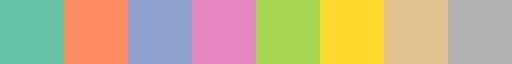

In [7]:
plt.colormaps["Set2"]

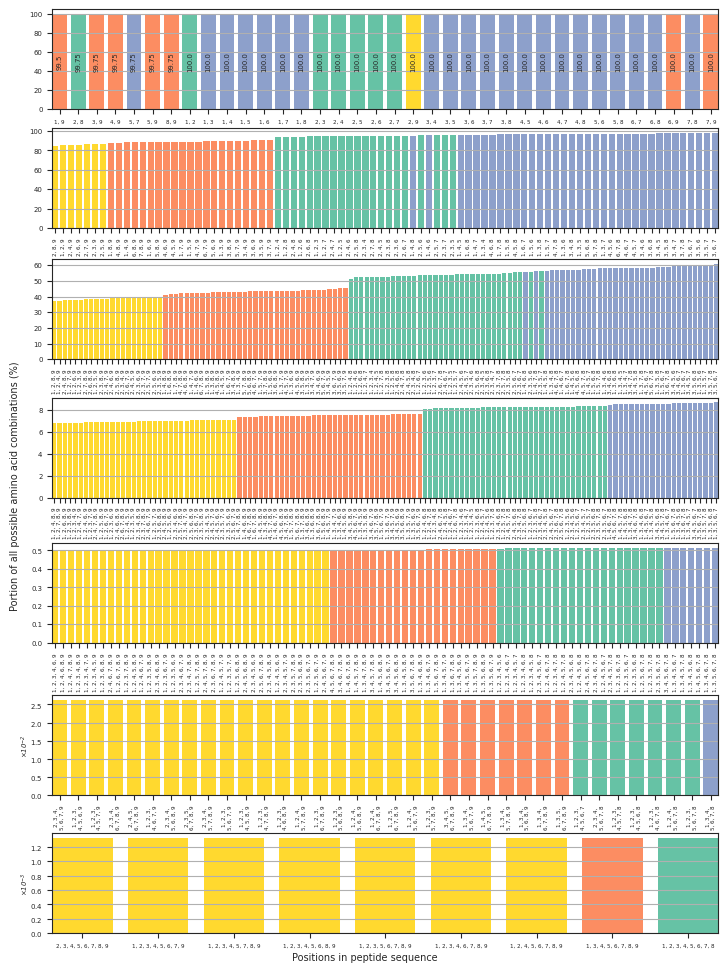

In [8]:
# Create and save figure

nrows = len(n_positions)
ncols = 1

fig = plt.figure(figsize=fig_size, layout="constrained")

gs = fig.add_gridspec(nrows=nrows, ncols=ncols)
axs = gs.subplots()

for n_p, aa_perc, ax in zip(n_positions, aa_comb_perc, axs.flatten()):
    if sort:
        if sort_low_to_high:
            descending = [False, False]
        else:
            descending = [True, False]
        aa_perc = aa_perc.sort(
            aa_perc_col, aa_combinations_col_pos, descending=descending
        )

    x = np.arange(aa_perc.shape[0])

    if n_p == 7:
        tick_labels = []
        for ac in aa_perc[aa_combinations_col_pos]:
            ac_list = ac.split(aa_combinations_list_sep)
            new_lab = ", ".join(ac_list[:3]) + ",\n" + ", ".join(ac_list[3:])
            tick_labels.append(new_lab)
    else:
        tick_labels = [
            ac.replace(aa_combinations_list_sep, ", ")
            for ac in aa_perc[aa_combinations_col_pos]
        ]

    colors = []
    for pc in aa_perc[aa_combinations_col_pos]:
        pc_list = pc.split(aa_combinations_list_sep)
        if "9" in pc_list:
            if "2" in pc_list:
                colors.append(c_29)
            else:
                colors.append(c_9)
        elif "2" in pc_list:
            colors.append(c_2)
        else:
            colors.append(c_r)

    rects = ax.bar(x, aa_perc[aa_perc_col], tick_label=tick_labels, color=colors)

    if n_p == 2:
        ax.bar_label(
            rects,
            labels=aa_perc[aa_perc_col].to_list(),
            fontsize=perc_ticks_labelsize,
            label_type="center",
            rotation=90,
        )

    ax.grid(axis="y")
    if n_p == 8 or n_p == 2 or n_p == 1:
        rotation = 0
    else:
        rotation = 90
    ax.tick_params(axis="x", labelsize=pos_ticks_labelsize, rotation=rotation)
    ax.tick_params(axis="y", labelsize=perc_ticks_labelsize)
    ax.margins(x=0)
    ax.spines[["right", "top"]].set_visible(True)
    if n_p == 8 or n_p == 7:
        ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0), useMathText=True)
        ax.figure.draw_without_rendering()  # This needs to be done cause `offset text` is only created when drawing...
        t = ax.yaxis.get_offset_text().get_text()
        ax.yaxis.get_offset_text().set_visible(False)
        ax.annotate(
            t,
            xy=(0, 0.5),
            xycoords="axes fraction",
            xytext=(-3, 0),
            textcoords="offset fontsize",
            fontsize=perc_ticks_labelsize,
            va="center",
            ha="right",
            fontstyle="italic",
            rotation=90,
        )

_ = fig.supxlabel("Positions in peptide sequence")
_ = fig.supylabel("Portion of all possible amino acid combinations (%)")

fig.get_layout_engine().set(w_pad=0, h_pad=0.02, hspace=0.03)

file_name = figures_supp_dir.joinpath(f"{fig_name}.pdf")
fig.savefig(file_name)

file_name = figures_supp_dir.joinpath(f"{fig_name}.png")
fig.savefig(file_name, dpi=600)

file_name = figures_supp_dir.joinpath(f"{fig_name}.tif")
fig.savefig(file_name, dpi=600, pil_kwargs={"compression": "tiff_lzw"})

file_name = figures_supp_dir.joinpath(f"{fig_name}.eps")
fig.savefig(file_name)

### Best AA Combinations

In [9]:
# Select which number of positions options to draw

n_positions = [1, 2, 3, 4, 5, 6, 7, 8]

In [10]:
# Prepare necessary data

pep_perc_col = "Peptides_perc"

pep_col = samples_col_peptides_9

# Get unique peptides
samples = pl.read_csv(samples_supp_file)
samples = samples.with_columns(
    pl.col(samples_list_cols).str.split(samples_list_sep).fill_null(list())
)
samples = samples.filter(pl.col(pep_col).list.len() != 0)
peptides = []
for pep_list in samples[pep_col]:
    peptides.extend(pep_list)
peptides = np.array(sorted(set(peptides)))
del samples

peptides_n = len(peptides)

del peptides

best_aa_combs = []

for n_p in n_positions:
    # Prepare the amino acids combinations table
    aa_combinations = pl.read_csv(aa_combinations_file(n_p))
    aa_combinations = aa_combinations.with_columns(
        pl.col(aa_combinations_col_pep).str.split(aa_combinations_list_sep)
    )

    aa_combinations = aa_combinations.with_columns(
        (pl.col(aa_combinations_col_pep).list.len() / peptides_n * 100).alias(
            pep_perc_col
        )
    )

    # Get the best amino acid combination for all unique positions
    best_aac = (
        aa_combinations.group_by(aa_combinations_col_pos)
        .agg(pl.all().sort_by(pep_perc_col).last())
        .select(pl.col([aa_combinations_col_pos, aa_combinations_col_aa, pep_perc_col]))
    )
    best_aac = best_aac.sort(aa_combinations_col_pos)
    if n_p == 1:
        best_aac = best_aac.with_columns(
            pl.col(aa_combinations_col_pos).cast(pl.String)
        )
    best_aa_combs.append(best_aac)

del aa_combinations, best_aac

In [11]:
# Figure config

fig_size = figsize_in_mm(max_fig_width_double_col, max_max_fig_height)

fig_name = "supp-best-aa-combinations"

sort = True
sort_low_to_high = False

pos_ticks_labelsize = 4
perc_ticks_labelsize = 5

aa_font_size = 4

# c_29 = "C3"
# c_9 = "C1"
# c_2 = "C2"
# c_r = "C0"
c_29 = plt.cm.Set2(5)
c_9 = plt.cm.Set2(1)
c_2 = plt.cm.Set2(0)
c_r = plt.cm.Set2(2)

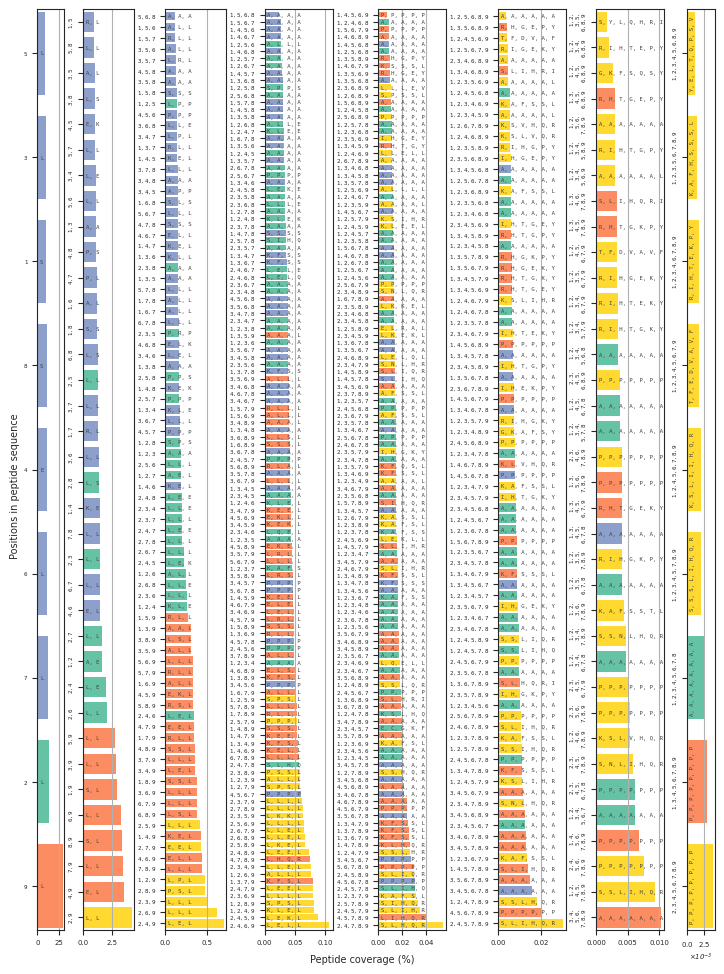

In [12]:
# Create and save figure

nrows = 1
ncols = len(n_positions)

width_ratios = [0.4, 0.75, 0.9, 1, 1, 1, 1, 0.4]

fig = plt.figure(figsize=fig_size, layout="constrained")

gs = fig.add_gridspec(nrows=nrows, ncols=ncols, width_ratios=width_ratios)
axs = gs.subplots()

for n_p, aa_perc, ax in zip(n_positions, best_aa_combs, axs.flatten()):
    if sort:
        if sort_low_to_high:
            descending = False
        else:
            descending = True
        aa_perc = aa_perc.sort(pep_perc_col, descending=descending)

    x = np.arange(aa_perc.shape[0])

    if n_p == 7:
        tick_labels = []
        for ac in aa_perc[aa_combinations_col_pos]:
            ac_list = ac.split(aa_combinations_list_sep)
            # new_lab = ", ".join(ac_list[:3]) + ",\n" + ", ".join(ac_list[3:])
            new_lab = ", ".join(ac_list[:2]) + ",\n" + ", ".join(ac_list[2:4]) + ",\n" + ", ".join(ac_list[4:])
            tick_labels.append(new_lab)
    else:
        tick_labels = [
            ac.replace(aa_combinations_list_sep, ", ")
            for ac in aa_perc[aa_combinations_col_pos]
        ]

    colors = []
    for pc in aa_perc[aa_combinations_col_pos]:
        pc_list = pc.split(aa_combinations_list_sep)
        if "9" in pc_list:
            if "2" in pc_list:
                colors.append(c_29)
            else:
                colors.append(c_9)
        elif "2" in pc_list:
            colors.append(c_2)
        else:
            colors.append(c_r)

    rects = ax.barh(x, aa_perc[pep_perc_col], tick_label=tick_labels, color=colors)

    # Add amino acids
    if n_p == 8:
        rotation = 90
    else:
        rotation = 0
    for r, aa in zip(rects, aa_perc[aa_combinations_col_aa]):
        aa_str = aa.replace(aa_combinations_list_sep, ", ")
        _ = ax.annotate(
            aa_str,
            xy=(0, r.get_y() + r.get_height() / 2),
            xytext=(0.5, 0),
            textcoords="offset fontsize",
            ha="left",
            va="center",
            fontsize=aa_font_size,
            rotation=rotation,color="0.25",fontfamily="monospace"
        )

    ax.grid(axis="x")
    if n_p == 8 or n_p == 2 or n_p == 7:
        rotation = 90
    else:
        rotation = 0
    ax.tick_params(axis="y", labelsize=pos_ticks_labelsize, rotation=rotation)
    if n_p == 8 or n_p == 2 or n_p == 7:
        tlab = ax.get_yticklabels()
        ax.set_yticklabels(tlab, va="center")
    ax.tick_params(axis="x", labelsize=perc_ticks_labelsize)
    ax.margins(y=0.0025)
    ax.spines[["right", "top"]].set_visible(True)

    # Change scientific notation
    if n_p == 8:
        ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 0), useMathText=True)
        ax.figure.draw_without_rendering()  # This needs to be done cause `offset text` is only created when drawing...
        t = ax.xaxis.get_offset_text().get_text()
        ax.xaxis.get_offset_text().set_visible(False)
        ax.annotate(
            t,
            xy=(0.5, 0),
            xycoords="axes fraction",
            xytext=(0, -3),
            textcoords="offset fontsize",
            fontsize=perc_ticks_labelsize,
            va="top",
            ha="center",
            fontstyle="italic",
        )

_ = fig.supylabel("Positions in peptide sequence")
_ = fig.supxlabel("Peptide coverage (%)", y=0)

fig.get_layout_engine().set(w_pad=0.02, h_pad=0.02, wspace=0.03)

file_name = figures_supp_dir.joinpath(f"{fig_name}.pdf")
fig.savefig(file_name)

file_name = figures_supp_dir.joinpath(f"{fig_name}.png")
fig.savefig(file_name, dpi=600)

file_name = figures_supp_dir.joinpath(f"{fig_name}.tif")
fig.savefig(file_name, dpi=600, pil_kwargs={"compression": "tiff_lzw"})

file_name = figures_supp_dir.joinpath(f"{fig_name}.eps")
fig.savefig(file_name)

### AA Combination Frequency (all)

This might take a while to generate.

In [17]:
# Select the number of positions option to draw

n_positions = [1, 2, 3, 4, 5, 6, 7, 8]

# Select cut-off threshold for annotating the cumulative percent of peptides coverage

sum_margin = 90

In [18]:
# Prepare necessary data

pep_perc_col = "Peptides_perc"

pep_col = samples_col_peptides_9

pep_len = peptide_len

blank_char = "_"

first_pos_n = 1

# Get unique peptides
samples = pl.read_csv(samples_supp_file)
samples = samples.with_columns(
    pl.col(samples_list_cols).str.split(samples_list_sep).fill_null(list())
)
samples = samples.filter(pl.col(pep_col).list.len() != 0)
peptides = []
for pep_list in samples[pep_col]:
    peptides.extend(pep_list)
peptides = np.array(sorted(set(peptides)))
del samples

peptides_n = len(peptides)

aa_combinations_all = []
peptide_coverage_all = []
above_margin_idx_all = []
below_margin_comb_perc_all = []
comb_peps_pssm_all = []
comb_n_all = []

for n_p in tqdm(n_positions):
    # Prepare the amino acids combinations table
    aa_combinations = pl.read_csv(aa_combinations_file(n_p))
    aa_combinations = aa_combinations.with_columns(
        pl.col(aa_combinations_col_pep).str.split(aa_combinations_list_sep)
    )

    if n_p == 1:
        aa_combinations = aa_combinations.with_columns(
            pl.col(aa_combinations_col_pos).cast(pl.List(int)),
            pl.col(aa_combinations_col_aa).str.split(";"),
        )
    else:
        aa_combinations = aa_combinations.with_columns(
            pl.col(aa_combinations_col_pos).str.split(";").cast(pl.List(int)),
            pl.col(aa_combinations_col_aa).str.split(";"),
        )

    aa_combinations = aa_combinations.with_columns(
        (pl.col(aa_combinations_col_pep).list.len() / peptides_n * 100).alias(
            pep_perc_col
        )
    )
    aa_combinations = aa_combinations.sort(pep_perc_col, descending=True)

    aa_combinations_all.append(aa_combinations)

    comb_n = aa_combinations.shape[0]

    comb_n_all.append(comb_n)

    # Get the cumulative percent of peptides coverage
    peptide_coverage = []
    pep_c = set()
    for pep_list in aa_combinations[aa_combinations_col_pep]:
        pep_c.update(pep_list)
        p_perc = len(pep_c) / peptides_n * 100
        if p_perc >= 100:
            n_left = aa_combinations.shape[0] - len(peptide_coverage)
            peptide_coverage.extend([100.0] * n_left)
            break
        peptide_coverage.append(p_perc)
    peptide_coverage = np.array(peptide_coverage)

    peptide_coverage_all.append(peptide_coverage)

    # Check the above threshold index
    above_margin_idx = np.where(peptide_coverage >= sum_margin)[0][0]
    # margin_diff = peptide_coverage[above_margin_idx] - sum_margin
    # prev_diff = peptide_coverage[above_margin_idx] - peptide_coverage[above_margin_idx - 1]
    # margin_val = above_margin_idx - margin_diff / prev_diff

    above_margin_idx_all.append(above_margin_idx)

    below_margin_comb_perc = (above_margin_idx + 1) / comb_n * 100

    below_margin_comb_perc_all.append(below_margin_comb_perc)

    # Make "fake" peptides from amino acids combinations below threshold only
    blank_pep = np.array([blank_char] * pep_len)

    below_margin_aa_combs = aa_combinations.slice(0, above_margin_idx + 1)

    comb_peps = []
    for i in range(below_margin_aa_combs.shape[0]):
        row = below_margin_aa_combs.row(i)
        new_pep = blank_pep.copy()
        new_pep[np.array(row[0]) - first_pos_n] = row[1]
        comb_peps.append("".join(new_pep))

    # Create a PSSM table out of those peptides
    comb_peps_pssm = info_pssm(comb_peps, alphabet=AMINO_ACIDS + [blank_char])
    aa_cols = comb_peps_pssm.columns.to_list()
    aa_cols.remove(blank_char)
    comb_peps_pssm = comb_peps_pssm.loc[:, aa_cols]

    comb_peps_pssm_all.append(comb_peps_pssm)

del aa_combinations, peptide_coverage, comb_peps_pssm

  0%|          | 0/8 [00:00<?, ?it/s]

In [19]:
# Figure config

fig_size = figsize_in_mm(max_fig_width_double_col, max_max_fig_height)

fig_name = "supp-aa-combinations-coverage-all"

marker_size = 4

pos_n_label_pos = (0.9, 0.8)
pos_n_label_color = "black"
pos_n_label_fontsize = 7

best_combs_n = 4
best_combs_pos = (0.36, 0.85)
best_combs_fontsize = 6
best_combs_color = "black"

logo_x = 0.8
logo_size = (70 / 72 * logo_x, 50 / 72 * logo_x)  # Pixels
logo_location = (0.81, 0.6)
logo_font_size = 5

sum_annot_color = "black"
sum_annot_linewidth = 1.25
sum_annot_font_size = 6
sum_annot_arrow_x_offset = 0.003125  # This is in % of data points
sum_annot_arrow_lenth = 15
sum_annot_arrowprops = dict(
    facecolor=sum_annot_color, headwidth=4, headlength=4, width=0.5
)
sum_annot_arrow_pos_pep = 0.77
sum_annot_arrow_pos_comb = 0.5

ax2_linewidth = 1.8
ax2_color = "0.4"
ax2_label_x_stretch = 0.98  # the smaller the number, the greater the stretch

comb_n_x_fontsize = 6
sci_not_pos = (0.4, -1.1)

axes_x_margin = 0.01

downsample_save_first_n = 1_000
downsample_output_n = 10_000

  0%|          | 0/8 [00:00<?, ?it/s]

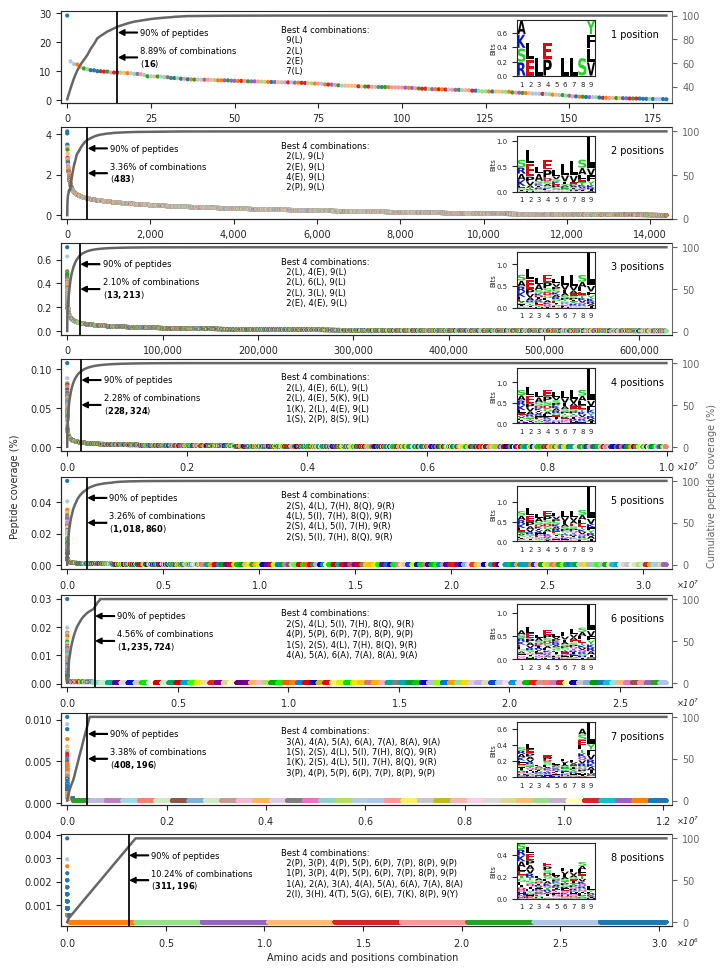

In [20]:
# Create and save figure

temp_sep = ";"

nrows = len(n_positions)
ncols = 1

fig = plt.figure(figsize=fig_size, layout="constrained")

gs = fig.add_gridspec(nrows=nrows, ncols=ncols)
axs = gs.subplots()

for (
    n_p,
    aa_combinations,
    peptide_coverage,
    above_margin_idx,
    below_margin_comb_perc,
    comb_peps_pssm,
    comb_n,
    ax,
) in tzip(
    n_positions,
    aa_combinations_all,
    peptide_coverage_all,
    above_margin_idx_all,
    below_margin_comb_perc_all,
    comb_peps_pssm_all,
    comb_n_all,
    axs.flatten(),
):
    x = np.arange(comb_n)

    # Make each indices combination have its own color
    unique_pos = aa_combinations[aa_combinations_col_pos].unique(maintain_order=True)
    unique_pos_n = len(unique_pos)
    colors = color_pallet(unique_pos_n)

    # Downsampling points (but leaving first N)
    if n_p > 1:
        rest_n = comb_n - downsample_save_first_n
        downsample_every_n = max(1, int(rest_n / downsample_output_n))
        downsample_cycle_values = itertools.cycle(
            [False] * (downsample_every_n - 1) + [True]
        )
        downsample_mask = list(itertools.islice(downsample_cycle_values, rest_n))
        downsample_mask = [True] * downsample_save_first_n + downsample_mask
        downsample_mask[-1] = True
        x = x[downsample_mask]
        aa_combinations = aa_combinations.filter(downsample_mask)

    # Map all positions to colors
    comb_colors = (
        aa_combinations[aa_combinations_col_pos]
        .cast(pl.List(pl.String))
        .list.join(temp_sep)
    )
    comb_colors = (
        comb_colors.replace(
            old=unique_pos.cast(pl.List(pl.String)).list.join(temp_sep),
            new=pl.Series(colors).cast(pl.List(pl.String)).list.join(temp_sep),
        )
        .str.split(temp_sep)
        .cast(pl.List(pl.Float64))
        .to_list()
    )

    _ = ax.scatter(x, aa_combinations[pep_perc_col], s=marker_size, c=comb_colors)

    # Cumulative frequency of occurrence

    ax2 = ax.twinx()

    ax2.spines["right"].set_visible(True)
    ax2.spines["right"].set_color(ax2_color)
    ax2.tick_params(axis="y", colors=ax2_color)

    _ = ax2.plot(peptide_coverage, color=ax2_color, linewidth=ax2_linewidth)

    # X% peptide sum annotations

    _ = ax2.axvline(
        above_margin_idx, color=sum_annot_color, linewidth=sum_annot_linewidth
    )

    ybound = ax.get_ybound()

    arrow_offset = sum_annot_arrow_x_offset * comb_n

    _ = ax.annotate(
        f"{sum_margin}% of peptides",
        xy=(
            above_margin_idx + arrow_offset,
            ybound[0] + (ybound[1] - ybound[0]) * sum_annot_arrow_pos_pep,
        ),
        xytext=(sum_annot_arrow_lenth, 0),
        textcoords="offset points",
        ha="left",
        va="center",
        fontsize=sum_annot_font_size,
        color=sum_annot_color,
        arrowprops=sum_annot_arrowprops,
    )

    _ = ax.annotate(
        f"{below_margin_comb_perc:.2f}% of combinations\n("
        + r"$\bf{"
        + f"{above_margin_idx+1:,}"
        + "}$)",
        xy=(
            above_margin_idx + arrow_offset,
            ybound[0] + (ybound[1] - ybound[0]) * sum_annot_arrow_pos_comb,
        ),
        xytext=(sum_annot_arrow_lenth, 0),
        textcoords="offset points",
        ha="left",
        va="center",
        fontsize=sum_annot_font_size,
        color=sum_annot_color,
        arrowprops=sum_annot_arrowprops,
    )

    ax.margins(x=axes_x_margin)
    ax2.margins(x=axes_x_margin)

    # Motif logo

    trans = fig.dpi_scale_trans + ScaledTranslation(
        logo_location[0], logo_location[1], ax.transAxes
    )
    motif_ax = inset_axes(
        ax,
        width="100%",
        height="100%",
        bbox_to_anchor=(
            -logo_size[0] / 2,
            -logo_size[1] / 2,
            logo_size[0],
            logo_size[1],
        ),
        bbox_transform=trans,
        borderpad=0,
        axes_kwargs={"anchor": "C"},
        loc="center",
    )

    motif_ax.spines[["right", "top"]].set_visible(True)

    # Create a motif from amino acids combinations below threshold only
    logo = logomaker.Logo(
        comb_peps_pssm,
        color_scheme="weblogo_protein",
        stack_order="big_on_top",
        flip_below=False,
        center_values=False,
        baseline_width=0,
        vpad=0.05,
        ax=motif_ax,
    )

    logo.ax.set_xticks(
        range(0, pep_len), labels=[str(i) for i in range(1, pep_len + 1)]
    )
    logo.ax.xaxis.set_tick_params(length=0)
    _ = logo.ax.set_ylabel("Bits", size=logo_font_size, labelpad=0)
    logo.ax.tick_params(axis="both", labelsize=logo_font_size)

    # Add number of positions label
    label = f"{n_p} position"
    if n_p > 1:
        label += "s"
    _ = ax.text(
        pos_n_label_pos[0],
        pos_n_label_pos[1],
        label,
        transform=ax.transAxes,
        ha="left",
        va="top",
        color=pos_n_label_color,
        size=pos_n_label_fontsize,
    )

    # Add best combinations
    best_combs = []
    for row in aa_combinations.slice(0, best_combs_n).iter_rows():
        combs = [f"{p}({aa})" for p, aa in zip(row[0], row[1])]
        combs = ", ".join(combs)
        combs = "  " + combs
        best_combs.append(combs)
    best_combs = "\n".join(best_combs)
    best_combs_str = f"Best {best_combs_n} combinations:\n{best_combs}"
    _ = ax.text(
        best_combs_pos[0],
        best_combs_pos[1],
        best_combs_str,
        transform=ax.transAxes,
        ha="left",
        va="top",
        color=best_combs_color,
        size=best_combs_fontsize,
    )

    ax.spines[["top"]].set_visible(True)

    if n_p == 2 or n_p == 3:
        ax.xaxis.set_major_formatter(lambda x, _: f"{int(x):,}")

    # Change scientific notation
    if n_p == 4 or n_p == 5 or n_p == 6 or n_p == 7 or n_p == 8:
        ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 0), useMathText=True)
        ax.figure.draw_without_rendering()  # This needs to be done cause `offset text` is only created when drawing...
        t = ax.xaxis.get_offset_text().get_text()
        ax.xaxis.get_offset_text().set_visible(False)
        ax.annotate(
            t,
            xy=(1, 0),
            xycoords="axes fraction",
            xytext=sci_not_pos,
            textcoords="offset fontsize",
            fontsize=comb_n_x_fontsize,
            va="top",
            ha="left",
            fontstyle="italic",
        )

_ = fig.supxlabel("Amino acids and positions combination")
_ = fig.supylabel("Peptide coverage (%)")
_ = fig.text(
    1,
    0.5,
    "Cumulative peptide coverage (%)",
    color=ax2_color,
    rotation=90,
    ha="center",
    va="bottom",
    rotation_mode="anchor",
)

fig.get_layout_engine().set(
    w_pad=0.02, h_pad=0.02, hspace=0.03, rect=(0, 0, ax2_label_x_stretch, 1)
)

file_name = figures_supp_dir.joinpath(f"{fig_name}.pdf")
fig.savefig(file_name)

file_name = figures_supp_dir.joinpath(f"{fig_name}.png")
fig.savefig(file_name, dpi=600)

file_name = figures_supp_dir.joinpath(f"{fig_name}.tif")
fig.savefig(file_name, dpi=600, pil_kwargs={"compression": "tiff_lzw"})

file_name = figures_supp_dir.joinpath(f"{fig_name}.eps")
fig.savefig(file_name)

### Populations Frequencies Bars

In [13]:
# Select which samples file to use

# Main
samples = pl.read_csv(samples_main_file)

# Supplementary
# samples = pl.read_csv(samples_supp_file)

# Select which frequency data to use

# samples_cols_freqs = samples_cols_freqs_a  # Only A* alleles
# freqs_pop_desc_cols_alleles = [freqs_pop_desc_col_a_b_drb1]

# samples_cols_freqs = samples_cols_freqs_b  # Only B* alleles
# freqs_pop_desc_cols_alleles = [freqs_pop_desc_col_a_b_drb1]

# samples_cols_freqs = samples_cols_freqs_c  # Only C* alleles
# freqs_pop_desc_cols_alleles = [freqs_pop_desc_col_c]

# samples_cols_freqs = samples_cols_freqs_abc_any  # A+B+C union
samples_cols_freqs = samples_cols_freqs_abc_all  # A+B+C intersection
freqs_pop_desc_cols_alleles = [freqs_pop_desc_col_a_b_drb1, freqs_pop_desc_col_c]

In [14]:
# Prepare data

pop_samples_n_col = "Samples_number"

# Samples frequencies data

freqs = samples[samples_cols_freqs]

del samples

new_cols = {c: c.split("_")[1] for c in freqs.columns}
freqs = freqs.rename(new_cols)

freqs = freqs.filter(pl.all_horizontal(pl.col("*").is_not_null()))

# Change the ordering based on clustering
pop_order = cos_sim_clustermap_order(freqs)
freqs = freqs.select(pl.col(pop_order))

# Original database populations samples numbers

freqs_pop_desc = pl.read_csv(freqs_pop_desc_file)

freqs_pop_desc_samples_n = freqs_pop_desc.select(
    pl.col(freqs_pop_desc_col_pop_code),
    pl.sum_horizontal(pl.col(freqs_pop_desc_cols_alleles)).alias(pop_samples_n_col),
)

freqs_pop_desc_samples_n = freqs_pop_desc_samples_n.select(
    pl.col(pop_samples_n_col)
).transpose(column_names=freqs_pop_desc_samples_n[freqs_pop_desc_col_pop_code])

del freqs_pop_desc

In [15]:
# Figure config

fig_size = figsize_in_mm(max_fig_width_double_col, max_max_fig_height * 0.45)

fig_name = "supp-pop-freqs"

bar_width = 30
bar_color = plt.cm.Set2(2)

freq_threshold = 0.05
# freq_threshold_color = "C3"
# freq_threshold_color = plt.cm.Set2(1)
# freq_threshold_color = plt.cm.Set2(5)
freq_threshold_color = plt.cm.Set2(7)
freq_threshold_linewidth = 1

gs_grid = (5, 5)  # (nrows, ncols); there are 21 populations

pop_label_size = 6
pop_label_x = 0.95
pop_label_y = 0.9
pop_label_color = "black"
pop_label_kwargs = dict(
    ha="right", va="top", color=pop_label_color, size=pop_label_size
)

x_label_hori_i = 0
y_label_vert_i = 2

axes_x_margin = 0.03

extra_axis_size = (0.27, 0.15)  # (width, height)
extra_axis_y = 0.094
extra_axis_fontsize = 5

above_thrsh_axis_loc = (0.35, extra_axis_y)  # (left, bottom)

freq_samples_axis_loc = (0.728, extra_axis_y)  # (left, bottom)

fig_canvas_rect = (-0.013, 0.07, 1.013, 1.029)

/data/teamgdansk/apalkowski/miniconda3/envs/carmen-analysis-2/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/data/teamgdansk/apalkowski/miniconda3/envs/carmen-analysis-2/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


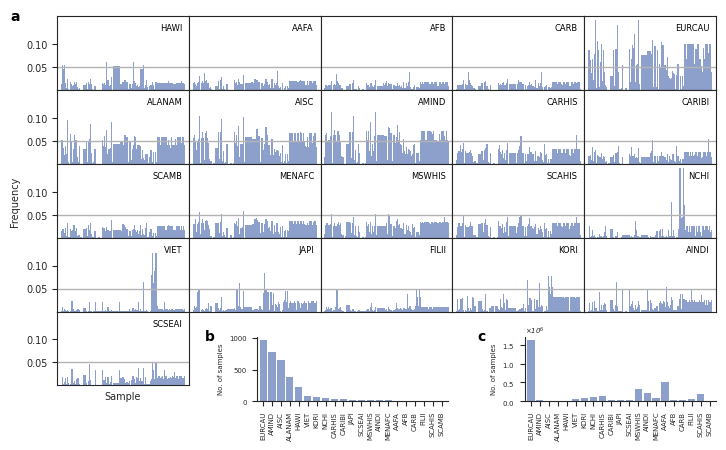

In [16]:
# Create and save figure

warnings.filterwarnings(
    "ignore", category=UserWarning, message="This figure includes Axes"
)

populations = freqs.columns

fig = plt.figure(figsize=fig_size, layout="tight")

gs = fig.add_gridspec(nrows=gs_grid[0], ncols=gs_grid[1], hspace=0, wspace=0)
axs = gs.subplots(sharex="all", sharey="all")

# Main panels

x = np.arange(freqs.shape[0])

for ax, pop in zip(axs.flatten(), populations):
    ax.spines[["right", "top"]].set_visible(True)
    ax.set_xticks([])
    # ax.set_yticks([])

    pop_freqs = freqs[pop].to_numpy()

    _ = ax.bar(x, pop_freqs, width=bar_width, color=bar_color)
    # _ = ax.stem(x, pop_freqs, linefmt="C0-", basefmt="None", markerfmt="None")

    ax.axhline(
        freq_threshold, color=freq_threshold_color, linewidth=freq_threshold_linewidth
    )

    ax.text(pop_label_x, pop_label_y, pop, transform=ax.transAxes, **pop_label_kwargs)

y_ticks = axs.flatten()[0].get_yticks().tolist()
y_ticks.remove(0)
y_ticks.remove(0.2)
y_ticks.append(freq_threshold)
y_ticks = sorted(y_ticks)
axs.flatten()[0].set_yticks(y_ticks)

y_top = axs.flatten()[0].get_ylim()[1]
for ax in axs.flatten():
    # ax.set_ylim(0, y_top)
    ax.margins(x=axes_x_margin)

axs[-1][x_label_hori_i].set_xlabel("Sample")
axs[y_label_vert_i][0].set_ylabel("Frequency")

for ax in axs.flatten()[[1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19]]:
    ax.tick_params(axis="y", left=False)
    # ax.set_yticks([])

# Automatically delete last unused axes
n_ax_to_del = gs_grid[0] * gs_grid[1] - len(populations)
if n_ax_to_del != 0:
    for ax in axs.flatten()[-n_ax_to_del:]:
        ax.set_axis_off()

axs.flatten()[0].annotate(
    "a",
    xy=(0, 1),
    xycoords="axes fraction",
    xytext=(-2.7, 0),
    textcoords="offset fontsize",
    **label_kwargs,
)

# Samples above threshold

ax = fig.add_axes(
    (
        above_thrsh_axis_loc[0],
        above_thrsh_axis_loc[1],
        extra_axis_size[0],
        extra_axis_size[1],
    )
)

pops_col = "Population"
at_col = "Samples"

above_thrsh_samples = (freqs >= freq_threshold).sum()
above_thrsh_samples = above_thrsh_samples.transpose(
    include_header=True, header_name=pops_col, column_names=[at_col]
)
above_thrsh_samples = above_thrsh_samples.sort(
    [at_col, pops_col], descending=[True, False]
)

x = np.arange(above_thrsh_samples.shape[0])

at_order_pop = above_thrsh_samples[pops_col].to_list()

_ = ax.bar(x, above_thrsh_samples[at_col], color=bar_color, tick_label=at_order_pop)

ax.margins(x=axes_x_margin / 2)

ax.tick_params(axis="x", labelsize=extra_axis_fontsize, rotation=90)
ax.tick_params(axis="y", labelsize=extra_axis_fontsize)
ax.set_ylabel("No. of samples", fontsize=extra_axis_fontsize)

ax.annotate(
    "b",
    xy=(0, 1),
    xycoords="axes fraction",
    xytext=(-3, 0),
    textcoords="offset fontsize",
    **label_kwargs,
)

# Number of samples from the original database

ax = fig.add_axes(
    (
        freq_samples_axis_loc[0],
        freq_samples_axis_loc[1],
        extra_axis_size[0],
        extra_axis_size[1],
    )
)

freqs_pop_desc_samples_n_sorted = freqs_pop_desc_samples_n.select(pl.col(at_order_pop))

_ = ax.bar(
    x,
    freqs_pop_desc_samples_n_sorted.row(0),
    color=bar_color,
    tick_label=freqs_pop_desc_samples_n_sorted.columns,
)

ax.margins(x=axes_x_margin / 2)

ax.tick_params(axis="x", labelsize=extra_axis_fontsize, rotation=90)
ax.tick_params(axis="y", labelsize=extra_axis_fontsize)
ax.set_ylabel("No. of samples", fontsize=extra_axis_fontsize)

ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0), useMathText=True)
ax.figure.draw_without_rendering()  # This needs to be done cause `offset text` is only created when drawing...
t = ax.yaxis.get_offset_text().get_text()
ax.yaxis.get_offset_text().set_visible(False)
ax.annotate(
    t,
    xy=(0, 1),
    xycoords="axes fraction",
    xytext=(0, 0),
    textcoords="offset fontsize",
    fontsize=extra_axis_fontsize,
    va="bottom",
    ha="left",
    fontstyle="italic",
)

ax.annotate(
    "c",
    xy=(0, 1),
    xycoords="axes fraction",
    xytext=(-2.8, 0),
    textcoords="offset fontsize",
    **label_kwargs,
)

fig.get_layout_engine().set(w_pad=0, h_pad=0, rect=fig_canvas_rect)

file_name = figures_supp_dir.joinpath(f"{fig_name}.pdf")
fig.savefig(file_name)

file_name = figures_supp_dir.joinpath(f"{fig_name}.png")
fig.savefig(file_name, dpi=600)

file_name = figures_supp_dir.joinpath(f"{fig_name}.tif")
fig.savefig(file_name, dpi=600, pil_kwargs={"compression": "tiff_lzw"})

file_name = figures_supp_dir.joinpath(f"{fig_name}.eps")
fig.savefig(file_name)

warnings.resetwarnings()

### Motif Landscape Animation

In [7]:
# Load necessary data

samples = pl.read_csv(samples_main_file)

samples = samples.with_columns(
    pl.col(samples_list_cols).str.split(samples_list_sep).fill_null(list())
)
samples = samples.filter(pl.col(samples_col_label).is_not_null())

embedding = samples[samples_col_umap_x, samples_col_umap_y].to_numpy()
labels = samples[samples_col_label].to_numpy()
peptides = samples[samples_col_peptides_9].to_numpy()

unique_labels = sorted(set(labels))

atlas_emb = pl.read_csv(main_motif_atlas_emb_file, separator="\t")
atlas_emb = atlas_emb.with_columns(
    pl.col(main_motif_atlas_emb_col_peps).str.split(main_motif_atlas_emb_list_sep)
)

This will change the way Matplotlib figures are displayed for the entire notebook. It is needed for the interactive Matplotlib window for selecting a sampling path. Reload the notebook to reset to default.

In [4]:
%matplotlib widget

#### Figure Config

In [55]:
# Figure config

# fig_size = figsize_in_mm(150, 100)
fig_size = figsize_in_mm(300, 200)  # For the `-big` version

# fig_name = "supp-motifs-landscape-animation-1"
# fig_name = "supp-motifs-landscape-animation-1-big"

# fig_name = "supp-motifs-landscape-animation-2"
fig_name = "supp-motifs-landscape-animation-2-big"

# point_size = 3
point_size = 8  # For the `-big` version
point_alpha = 0.5
point_color = "C0"

# atlas_point_size = 15
atlas_point_size = 32  # For the `-big` version
atlas_point_alleles = ["A", "B", "C"]
atlas_point_markers = ["s", "^", "*"]

clust_border_color = "0.4"
clust_border_lw = 0.5

# axis_label_fontsize = 10
axis_label_fontsize = 12  # For the `-big` version
axis_ticks_fontsize = 10
# axis_title_fontsize = 10
axis_title_fontsize = 12  # For the `-big` version

small_circle_linewidth = 2.5
small_circle_color = "orangered"

# legend_markersize = 4
legend_markersize = 6  # For the `-big` version
# legend_font_size = 8
legend_font_size = 10  # For the `-big` version

In [9]:
# Set up the base figure drawing


def draw_base_umap(ax):
    _ = ax.scatter(
        embedding[:, 0],
        embedding[:, 1],
        s=point_size,
        alpha=point_alpha,
        color=point_color,
    )

    for lab in unique_labels:
        if lab == -1:
            continue
        mask = labels == lab
        data = embedding[mask, :]
        hull = ConvexHull(data)
        for simplex in hull.simplices:
            ax.plot(
                data[simplex, 0],
                data[simplex, 1],
                color=clust_border_color,
                lw=clust_border_lw,
            )

    ax.set_xticks([])
    ax.set_yticks([])

    _ = ax.set_xlabel("UMAP_1", size=axis_label_fontsize)
    _ = ax.set_ylabel("UMAP_2", size=axis_label_fontsize)

    for a, m in zip(atlas_point_alleles, atlas_point_markers):
        mask = (
            atlas_emb.select(pl.col(main_motif_atlas_emb_col_allele).str.starts_with(a))
            .to_series()
            .to_list()
        )
        data = atlas_emb.filter(mask)
        ae = ax.scatter(
            data[main_motif_atlas_emb_col_x],
            data[main_motif_atlas_emb_col_y],
            s=atlas_point_size,
            color="black",
            marker=m,
        )
        ae.set_path_effects([PathEffects.withStroke(linewidth=2, foreground="white")])

    legend_elements = [
        Line2D(
            [0],
            [0],
            marker="o",
            color=point_color,
            label="Peptide cluster",
            markersize=legend_markersize,
            linestyle="",
        )
    ]
    for a, m in zip(atlas_point_alleles, atlas_point_markers):
        leg_m = Line2D(
            [0],
            [0],
            marker=m,
            color="black",
            label=f"MHC Motif\nAtlas {a}* allele",
            markersize=legend_markersize,
            linestyle="",
        )
        legend_elements.append(leg_m)

    # ax.legend(
    #     handles=legend_elements,
    #     loc="lower left",
    #     handletextpad=0.1,
    #     fontsize=legend_font_size,
    #     ncols=2,
    #     columnspacing=0.1,
    # )

    leg1 = ax.legend(
        handles=legend_elements[:2],
        loc="upper left",
        handletextpad=0.1,
        fontsize=legend_font_size,
    )
    leg2 = ax.legend(
        handles=legend_elements[2:],
        loc="lower left",
        handletextpad=0.1,
        fontsize=legend_font_size,
    )
    ax.add_artist(leg1)
    ax.add_artist(leg2)

    # atlas_points = ax.scatter(
    #     atlas_emb[main_motif_atlas_emb_col_x],
    #     atlas_emb[main_motif_atlas_emb_col_y],
    #     s=atlas_point_size,
    #     color="black",
    #     marker="x",
    # )

    # atlas_points.set_path_effects(
    #     [PathEffects.withStroke(linewidth=2, foreground="white")]
    # )

    # legend_elements = [
    #     Line2D(
    #         [0],
    #         [0],
    #         marker="o",
    #         color=point_color,
    #         label="Peptide cluster",
    #         markersize=legend_markersize,
    #         linestyle="",
    #     ),
    #     Line2D(
    #         [0],
    #         [0],
    #         marker="x",
    #         color="black",
    #         label="MHC Motif\nAtlas allele",
    #         markersize=legend_markersize,
    #         linestyle="",
    #     ),
    # ]
    # ax.legend(
    #     handles=legend_elements,
    #     loc="upper left",
    #     handletextpad=0.1,
    #     fontsize=legend_font_size,
    # )

In [ ]:
# Draw the path across which peptides will be sampled
# Sampling of points from the figure is time-based (the slower you draw--the more densely sampled points will be)


class SamplingPathSelector:
    def __init__(self, ax, line_color="black"):
        self.lasso = LassoSelector(
            ax, onselect=self.onselect, props=dict(color=line_color)
        )
        self.path = None

    def onselect(self, verts):
        self.path = verts


fig = plt.figure(figsize=figsize_in_mm(150, 150), layout="constrained")
ax = fig.add_subplot()

draw_base_umap(ax)

selector = SamplingPathSelector(ax)

In [47]:
# Nevertheless, you can take the original sampling paths (as published)

path_x = [-1.0891546653562472, -1.0530944264012128, -1.0891546653562472, -1.0891546653562472, -1.1252149043112833, -1.1612751432663195, -1.1612751432663195, -1.233395621176392, -1.233395621176392, -1.233395621176392, -1.269455860131428, -1.269455860131428, -1.3055160990864643, -1.3055160990864643, -1.3415763380415004, -1.3776365769965349, -1.413696815951571, -1.413696815951571, -1.4858172938616434, -1.4858172938616434, -1.5218775328166796, -1.5579377717717158, -1.593998010726752, -1.6300582496817881, -1.7021787275918587, -1.7021787275918587, -1.738238966546895, -1.774299205501931, -1.774299205501931, -1.8103594444569673, -1.8464196834120026, -1.8824799223670388, -1.9546004002771111, -1.9546004002771111, -1.9546004002771111, -1.9906606392321464, -2.0267208781871826, -2.098841356097255, -2.1349015950522903, -2.1709618340073265, -2.2070220729623626, -2.279142550872434, -2.279142550872434, -2.3152027898274703, -2.3512630287825065, -2.3873232677375418, -2.423383506692578, -2.459443745647614, -2.4955039846026503, -2.7118654183328657, -2.747925657287902, -2.783985896242938, -2.783985896242938, -2.8200461351979733, -2.8561063741530095, -2.8921666131080457, -2.928226852063082, -2.964287091018117, -2.964287091018117, -3.0364075689281895, -3.0724678078832257, -3.1806485247483334, -3.2167087637033687, -3.2167087637033687, -3.252769002658405, -3.288829241613441, -3.324889480568477, -3.3609497195235125, -3.3609497195235125, -3.3970099584785487, -3.433070197433585, -3.469130436388621, -3.5412509142986925, -3.5773111532537287, -3.6494316311638, -3.7576123480289088, -3.793672586983944, -3.8297328259389802, -3.8657930648940164, -3.937913542804088, -3.937913542804088, -3.937913542804088, -3.973973781759124, -4.01003402071416, -4.046094259669196, -4.082154498624232, -4.118214737579268, -4.154274976534304, -4.298515932354448, -4.478817127129627, -4.514877366084663, -4.586997843994735, -4.623058082949771, -4.659118321904807, -4.659118321904807, -4.695178560859843, -4.731238799814879, -4.731238799814879, -4.839419516679987, -4.839419516679987, -4.8754797556350224, -4.911539994590059, -4.983660472500131, -5.019720711455166, -5.091841189365239, -5.127901428320275, -5.16396166727531, -5.200021906230346, -5.200021906230346, -5.2360821451853825, -5.272142384140418, -5.308202623095454, -5.34426286205049, -5.380323101005526, -5.380323101005526, -5.380323101005526, -5.452443578915598, -5.488503817870634, -5.52456405682567, -5.5606242957807055, -5.596684534735742, -5.632744773690778, -5.704865251600849, -5.7409254905558855, -5.776985729510922, -5.813045968465958, -5.849106207420993, -5.849106207420993, -5.885166446376029, -5.9212266853310656, -5.957286924286102, -5.993347163241137, -6.029407402196173, -6.0654676411512085, -6.101527880106245, -6.101527880106245, -6.137588119061281, -6.173648358016317, -6.209708596971353, -6.245768835926389, -6.281829074881425, -6.353949552791496, -6.390009791746532, -6.426070030701569, -6.426070030701569, -6.462130269656605, -6.462130269656605, -6.462130269656605, -6.498190508611641, -6.534250747566677, -6.534250747566677, -6.570310986521712, -6.606371225476749, -6.606371225476749, -6.642431464431784, -6.642431464431784, -6.642431464431784, -6.67849170338682, -6.67849170338682, -6.67849170338682, -6.714551942341856, -6.7506121812968924, -6.7506121812968924, -6.7506121812968924, -6.786672420251929, -6.786672420251929, -6.786672420251929, -6.786672420251929, -6.822732659206964, -6.822732659206964, -6.822732659206964, -6.822732659206964, -6.858792898162, -6.858792898162, -6.858792898162, -6.858792898162, -6.858792898162, -6.858792898162, -6.858792898162, -6.858792898162, -6.822732659206964, -6.822732659206964, -6.822732659206964, -6.7506121812968924, -6.714551942341856, -6.67849170338682, -6.642431464431784, -6.642431464431784, -6.606371225476749, -6.534250747566677, -6.498190508611641, -6.462130269656605, -6.462130269656605, -6.426070030701569, -6.390009791746532, -6.353949552791496, -6.317889313836461, -6.209708596971353, -6.137588119061281, -6.101527880106245, -6.0654676411512085, -6.029407402196173, -5.993347163241137, -5.957286924286102, -5.9212266853310656, -5.885166446376029, -5.813045968465958, -5.776985729510922, -5.7409254905558855, -5.704865251600849, -5.704865251600849, -5.668805012645814, -5.5606242957807055, -5.488503817870634, -5.452443578915598, -5.416383339960562, -5.380323101005526, -5.308202623095454, -5.2360821451853825, -5.200021906230346, -5.200021906230346, -5.16396166727531, -5.127901428320275, -5.091841189365239, -5.091841189365239, -5.0557809504102025, -5.019720711455166, -5.019720711455166, -5.019720711455166, -4.983660472500131, -4.947600233545095, -4.947600233545095, -4.911539994590059, -4.8754797556350224, -4.839419516679987, -4.803359277724951, -4.731238799814879, -4.695178560859843, -4.659118321904807, -4.659118321904807, -4.623058082949771, -4.586997843994735, -4.5509376050396995, -4.5509376050396995, -4.478817127129627, -4.478817127129627, -4.442756888174592, -4.442756888174592, -4.406696649219556, -4.370636410264519, -4.370636410264519, -4.334576171309483, -4.334576171309483, -4.298515932354448, -4.262455693399412, -4.154274976534304, -4.118214737579268, -4.118214737579268, -4.082154498624232, -4.046094259669196, -4.01003402071416, -3.973973781759124, -3.973973781759124, -3.937913542804088, -3.937913542804088, -3.937913542804088, -3.9018533038490517, -3.9018533038490517, -3.8657930648940164, -3.793672586983944, -3.7576123480289088, -3.7576123480289088, -3.7576123480289088, -3.7576123480289088, -3.7576123480289088, -3.7215521090738726, -3.7215521090738726, -3.7215521090738726, -3.6494316311638, -3.6494316311638, -3.613371392208765, -3.613371392208765, -3.5773111532537287, -3.5773111532537287, -3.5773111532537287, -3.5051906753436564, -3.433070197433585, -3.3970099584785487, -3.3970099584785487, -3.3970099584785487, -3.3609497195235125, -3.3609497195235125, -3.324889480568477, -3.288829241613441, -3.252769002658405, -3.1806485247483334, -3.108528046838261, -3.108528046838261, -2.964287091018117, -2.8921666131080457, -2.8561063741530095, -2.783985896242938, -2.7118654183328657, -2.6758051793778295, -2.6758051793778295, -2.639744940422794, -2.639744940422794, -2.603684701467758, -2.603684701467758, -2.5315642235576856, -2.5315642235576856, -2.4955039846026503, -2.4955039846026503, -2.423383506692578, -2.423383506692578, -2.3873232677375418, -2.3512630287825065, -2.3152027898274703, -2.3152027898274703, -2.279142550872434, -2.243082311917399, -2.2070220729623626, -2.1709618340073265, -2.1349015950522903, -2.098841356097255, -2.0267208781871826, -1.9546004002771111, -1.9546004002771111, -1.9546004002771111, -1.918540161322075, -1.918540161322075, -1.8824799223670388, -1.8824799223670388, -1.8464196834120026, -1.8103594444569673, -1.774299205501931, -1.774299205501931, -1.738238966546895, -1.7021787275918587, -1.6661184886368225, -1.6300582496817881, -1.593998010726752, -1.593998010726752, -1.5579377717717158, -1.5218775328166796, -1.4497570549066072, -1.413696815951571, -1.413696815951571, -1.413696815951571, -1.413696815951571, -1.413696815951571, -1.4497570549066072, -1.4858172938616434, -1.5218775328166796, -1.5579377717717158, -1.593998010726752, -1.593998010726752, -1.593998010726752, -1.6661184886368225, -1.7021787275918587, -1.738238966546895, -1.738238966546895, -1.774299205501931, -1.774299205501931, -1.774299205501931, -1.8464196834120026, -1.8824799223670388, -1.918540161322075, -1.9546004002771111, -1.9546004002771111, -1.9546004002771111, -1.9906606392321464, -1.9906606392321464, -2.062781117142219, -2.098841356097255, -2.098841356097255, -2.1349015950522903, -2.1349015950522903, -2.1709618340073265, -2.2070220729623626, -2.243082311917399, -2.279142550872434, -2.3152027898274703, -2.3152027898274703, -2.3512630287825065, -2.3512630287825065, -2.3873232677375418, -2.3873232677375418, -2.423383506692578, -2.423383506692578, -2.459443745647614, -2.4955039846026503, -2.4955039846026503, -2.5315642235576856, -2.567624462512722, -2.567624462512722, -2.603684701467758, -2.639744940422794, -2.6758051793778295, -2.7118654183328657, -2.7118654183328657, -2.747925657287902, -2.783985896242938, -2.8200461351979733, -2.8200461351979733, -2.8561063741530095, -2.8561063741530095, -2.8561063741530095, -2.8921666131080457, -2.8921666131080457, -2.928226852063082, -2.928226852063082, -2.964287091018117, -3.0003473299731533, -3.0003473299731533, -3.0003473299731533, -3.0364075689281895, -3.0364075689281895, -3.0364075689281895, -3.0724678078832257, -3.0724678078832257, -3.108528046838261, -3.108528046838261, -3.144588285793297, -3.144588285793297, -3.2167087637033687, -3.324889480568477, -3.324889480568477, -3.3970099584785487, -3.3970099584785487, -3.3970099584785487, -3.3970099584785487, -3.433070197433585, -3.469130436388621, -3.469130436388621, -3.5051906753436564, -3.5412509142986925, -3.5773111532537287, -3.5773111532537287, -3.5773111532537287, -3.613371392208765, -3.613371392208765, -3.6494316311638, -3.6854918701188364, -3.7215521090738726, -3.7215521090738726, -3.7576123480289088, -3.7576123480289088, -3.7576123480289088, -3.793672586983944, -3.8297328259389802, -3.8297328259389802, -3.8657930648940164, -3.9018533038490517, -3.937913542804088, -3.973973781759124, -4.01003402071416, -4.01003402071416, -4.046094259669196, -4.082154498624232, -4.118214737579268, -4.118214737579268, -4.154274976534304, -4.226395454444376, -4.226395454444376, -4.262455693399412, -4.298515932354448, -4.334576171309483, -4.370636410264519, -4.406696649219556, -4.442756888174592, -4.478817127129627, -4.478817127129627, -4.478817127129627, -4.514877366084663, -4.514877366084663, -4.5509376050396995, -4.586997843994735, -4.586997843994735, -4.623058082949771, -4.623058082949771, -4.659118321904807, -4.659118321904807, -4.695178560859843, -4.695178560859843, -4.731238799814879, -4.767299038769915, -4.767299038769915, -4.803359277724951, -4.839419516679987, -4.839419516679987, -4.8754797556350224, -4.947600233545095, -4.947600233545095, -4.947600233545095, -4.983660472500131, -4.983660472500131, -5.019720711455166, -5.0557809504102025, -5.0557809504102025, -5.127901428320275, -5.127901428320275, -5.127901428320275, -5.16396166727531, -5.200021906230346, -5.200021906230346, -5.200021906230346, -5.200021906230346, -5.2360821451853825, -5.2360821451853825, -5.2360821451853825, -5.2360821451853825, -5.272142384140418, -5.308202623095454, -5.34426286205049, -5.34426286205049, -5.380323101005526, -5.380323101005526, -5.380323101005526, -5.416383339960562, -5.452443578915598, -5.452443578915598, -5.488503817870634, -5.52456405682567, -5.5606242957807055, -5.5606242957807055, -5.5606242957807055, -5.5606242957807055, -5.596684534735742, -5.632744773690778, -5.668805012645814, -5.668805012645814, -5.704865251600849, -5.7409254905558855, -5.776985729510922, -5.849106207420993, -5.885166446376029, -5.885166446376029, -5.9212266853310656, -5.9212266853310656, -5.9212266853310656, -5.9212266853310656, -5.957286924286102, -5.957286924286102, -5.993347163241137, -6.029407402196173, -6.0654676411512085, -6.0654676411512085, -6.101527880106245, -6.101527880106245, -6.137588119061281, -6.173648358016317, -6.173648358016317, -6.209708596971353, -6.245768835926389, -6.245768835926389, -6.245768835926389, -6.281829074881425, -6.281829074881425, -6.281829074881425, -6.281829074881425, -6.317889313836461, -6.390009791746532, -6.426070030701569, -6.462130269656605, -6.462130269656605, -6.462130269656605, -6.498190508611641, -6.534250747566677, -6.570310986521712, -6.570310986521712, -6.570310986521712, -6.570310986521712, -6.606371225476749, -6.606371225476749, -6.642431464431784, -6.642431464431784, -6.67849170338682, -6.714551942341856, -6.7506121812968924, -6.7506121812968924, -6.822732659206964, -6.822732659206964, -6.894853137117035, -6.894853137117035, -6.930913376072072, -6.966973615027108, -7.003033853982144, -7.075154331892216, -7.075154331892216, -7.075154331892216, -7.111214570847252, -7.111214570847252, -7.147274809802288, -7.183335048757323, -7.183335048757323, -7.219395287712359, -7.219395287712359, -7.2554555266673955, -7.2554555266673955, -7.291515765622432, -7.327576004577468, -7.363636243532504, -7.363636243532504, -7.363636243532504, -7.399696482487539, -7.399696482487539, -7.435756721442575, -7.471816960397611, -7.471816960397611, -7.507877199352647, -7.543937438307683, -7.543937438307683, -7.543937438307683, -7.543937438307683, -7.579997677262719, -7.579997677262719, -7.579997677262719, -7.6160579162177555, -7.652118155172791, -7.688178394127827, -7.688178394127827, -7.688178394127827, -7.688178394127827, -7.724238633082862, -7.724238633082862, -7.724238633082862, -7.724238633082862, -7.724238633082862, -7.724238633082862, -7.724238633082862, -7.724238633082862, -7.724238633082862, -7.724238633082862, -7.724238633082862, -7.724238633082862, -7.724238633082862, -7.688178394127827, -7.688178394127827, -7.652118155172791, -7.652118155172791, -7.6160579162177555, -7.579997677262719, -7.579997677262719, -7.543937438307683, -7.543937438307683, -7.543937438307683, -7.471816960397611, -7.435756721442575, -7.399696482487539, -7.399696482487539, -7.363636243532504, -7.327576004577468, -7.291515765622432, -7.2554555266673955, -7.219395287712359, -7.219395287712359, -7.183335048757323, -7.183335048757323, -7.147274809802288, -7.111214570847252, -7.111214570847252, -7.075154331892216, -7.003033853982144, -7.003033853982144, -7.003033853982144, -6.894853137117035, -6.858792898162, -6.822732659206964, -6.822732659206964, -6.822732659206964, -6.822732659206964, -6.786672420251929, -6.714551942341856, -6.67849170338682, -6.67849170338682, -6.642431464431784, -6.642431464431784, -6.642431464431784, -6.606371225476749, -6.570310986521712, -6.570310986521712, -6.570310986521712, -6.534250747566677, -6.534250747566677, -6.534250747566677, -6.534250747566677, -6.498190508611641, -6.498190508611641, -6.462130269656605, -6.462130269656605, -6.462130269656605, -6.426070030701569, -6.426070030701569, -6.390009791746532, -6.317889313836461, -6.317889313836461, -6.281829074881425, -6.281829074881425, -6.245768835926389, -6.137588119061281, -6.101527880106245, -6.101527880106245, -6.101527880106245, -6.0654676411512085, -6.0654676411512085, -6.029407402196173, -6.029407402196173, -5.957286924286102, -5.957286924286102, -5.9212266853310656, -5.9212266853310656, -5.9212266853310656, -5.885166446376029, -5.849106207420993, -5.813045968465958, -5.7409254905558855, -5.704865251600849, -5.668805012645814, -5.5606242957807055, -5.52456405682567, -5.488503817870634, -5.416383339960562, -5.380323101005526, -5.380323101005526, -5.380323101005526, -5.34426286205049, -5.34426286205049, -5.272142384140418, -5.2360821451853825, -5.200021906230346, -5.200021906230346, -5.091841189365239, -5.0557809504102025, -5.019720711455166, -4.983660472500131, -4.911539994590059, -4.911539994590059, -4.8754797556350224, -4.839419516679987, -4.839419516679987, -4.803359277724951, -4.767299038769915, -4.695178560859843, -4.659118321904807, -4.659118321904807, -4.623058082949771, -4.586997843994735, -4.514877366084663, -4.514877366084663, -4.478817127129627, -4.478817127129627, -4.478817127129627, -4.442756888174592, -4.406696649219556, -4.406696649219556, -4.406696649219556, -4.406696649219556, -4.406696649219556, -4.406696649219556, -4.406696649219556, -4.406696649219556, -4.406696649219556, -4.442756888174592, -4.442756888174592, -4.442756888174592, -4.442756888174592, -4.478817127129627, -4.478817127129627, -4.478817127129627, -4.478817127129627, -4.5509376050396995, -4.5509376050396995, -4.5509376050396995, -4.5509376050396995, -4.586997843994735, -4.586997843994735, -4.586997843994735, -4.586997843994735, -4.623058082949771, -4.659118321904807, -4.659118321904807, -4.659118321904807, -4.659118321904807, -4.623058082949771, -4.586997843994735, -4.586997843994735, -4.586997843994735, -4.586997843994735, -4.586997843994735, -4.514877366084663, -4.514877366084663, -4.514877366084663, -4.514877366084663, -4.514877366084663, -4.514877366084663, -4.514877366084663, -4.514877366084663, -4.514877366084663, -4.514877366084663, -4.514877366084663, -4.514877366084663, -4.514877366084663, -4.514877366084663, -4.478817127129627, -4.478817127129627, -4.442756888174592, -4.442756888174592, -4.406696649219556, -4.370636410264519, -4.334576171309483, -4.298515932354448, -4.298515932354448, -4.298515932354448, -4.226395454444376, -4.154274976534304, -4.118214737579268, -4.082154498624232, -4.046094259669196, -4.01003402071416, -3.937913542804088, -3.937913542804088, -3.8657930648940164, -3.8297328259389802, -3.793672586983944, -3.7576123480289088, -3.7215521090738726, -3.6854918701188364, -3.613371392208765, -3.613371392208765, -3.5773111532537287, -3.5773111532537287, -3.5051906753436564, -3.469130436388621, -3.3970099584785487, -3.3970099584785487, -3.324889480568477, -3.288829241613441, -3.252769002658405, -3.2167087637033687, -3.1806485247483334, -3.144588285793297, -3.108528046838261, -3.0724678078832257, -3.0364075689281895, -2.964287091018117, -2.964287091018117, -2.928226852063082, -2.928226852063082, -2.8921666131080457, -2.8561063741530095, -2.8561063741530095, -2.8561063741530095, -2.8200461351979733, -2.783985896242938, -2.783985896242938, -2.747925657287902, -2.747925657287902, -2.747925657287902, -2.747925657287902, -2.7118654183328657, -2.7118654183328657, -2.6758051793778295, -2.6758051793778295, -2.639744940422794, -2.603684701467758, -2.603684701467758, -2.567624462512722, -2.567624462512722, -2.5315642235576856, -2.5315642235576856, -2.5315642235576856, -2.4955039846026503, -2.4955039846026503, -2.459443745647614, -2.423383506692578, -2.423383506692578, -2.3152027898274703, -2.3152027898274703, -2.2070220729623626, -2.1709618340073265, -2.1349015950522903, -2.1349015950522903, -2.1349015950522903, -2.1349015950522903, -2.1349015950522903, -2.1349015950522903, -2.1349015950522903, -2.1349015950522903, -2.1349015950522903, -2.1349015950522903, -2.1349015950522903, -2.1349015950522903, -2.1349015950522903, -2.1349015950522903, -2.1349015950522903, -2.1349015950522903, -2.1349015950522903, -2.1349015950522903, -2.1349015950522903, -2.1349015950522903, -2.1349015950522903, -2.1709618340073265, -2.1349015950522903, -2.1349015950522903, -2.1349015950522903, -2.1349015950522903, -2.098841356097255, -2.062781117142219, -2.062781117142219, -2.062781117142219, -2.0267208781871826, -1.9906606392321464, -1.9906606392321464, -1.9906606392321464, -1.9546004002771111, -1.9546004002771111, -1.9546004002771111, -1.9546004002771111, -1.9546004002771111, -1.9546004002771111, -1.918540161322075, -1.8824799223670388, -1.8464196834120026, -1.8464196834120026, -1.738238966546895, -1.738238966546895, -1.7021787275918587, -1.6661184886368225, -1.6661184886368225, -1.6661184886368225, -1.6661184886368225, -1.6661184886368225, -1.6300582496817881, -1.6300582496817881, -1.6300582496817881, -1.6300582496817881, -1.593998010726752, -1.593998010726752, -1.593998010726752, -1.5579377717717158, -1.5218775328166796, -1.5218775328166796, -1.4858172938616434, -1.4858172938616434, -1.4858172938616434, -1.4858172938616434, -1.4497570549066072, -1.4497570549066072, -1.413696815951571, -1.413696815951571, -1.413696815951571, -1.3415763380415004, -1.3055160990864643, -1.269455860131428, -1.233395621176392, -1.233395621176392, -1.1973353822213557, -1.1973353822213557, -1.1612751432663195, -1.1252149043112833, -1.0530944264012128, -1.0170341874461766, -0.9809739484911404, -0.908853470581068, -0.908853470581068, -0.8727932316260318, -0.8367329926709957, -0.8367329926709957, -0.8006727537159612, -0.8006727537159612, -0.7646125147609251, -0.7646125147609251, -0.7285522758058889, -0.6924920368508527, -0.6924920368508527, -0.6924920368508527, -0.6564317978958165, -0.6203715589407803, -0.6203715589407803, -0.6203715589407803, -0.6203715589407803, -0.6203715589407803, -0.6203715589407803, -0.6203715589407803, -0.6203715589407803, -0.6203715589407803, -0.6203715589407803, -0.6203715589407803, -0.6564317978958165, -0.6924920368508527, -0.6924920368508527, -0.6924920368508527, -0.6924920368508527, -0.6924920368508527, -0.6924920368508527, -0.6924920368508527, -0.6924920368508527, -0.6924920368508527, -0.6924920368508527, -0.6924920368508527, -0.7285522758058889, -0.7646125147609251, -0.7646125147609251, -0.8006727537159612, -0.8727932316260318, -0.8727932316260318, -0.8727932316260318, -0.908853470581068, -0.9449137095361042, -0.9449137095361042, -0.9449137095361042, -0.9449137095361042, -1.0170341874461766, -1.0170341874461766, -1.0530944264012128, -1.0530944264012128, -1.0530944264012128, -1.0530944264012128, -1.1252149043112833, -1.1252149043112833, -1.1252149043112833, -1.1612751432663195, -1.1973353822213557, -1.1973353822213557, -1.1973353822213557, -1.1973353822213557, -1.233395621176392, -1.233395621176392, -1.269455860131428, -1.269455860131428, -1.3055160990864643, -1.3055160990864643, -1.3055160990864643, -1.3055160990864643, -1.3055160990864643, -1.3055160990864643, -1.3776365769965349, -1.3776365769965349, -1.3776365769965349, -1.3776365769965349, -1.3776365769965349, -1.3776365769965349, -1.413696815951571, -1.413696815951571, -1.413696815951571, -1.413696815951571, -1.413696815951571, -1.413696815951571, -1.4497570549066072, -1.4497570549066072, -1.5218775328166796, -1.5218775328166796, -1.5579377717717158, -1.5579377717717158, -1.5579377717717158, -1.5579377717717158, -1.5579377717717158, -1.5579377717717158, -1.593998010726752, -1.593998010726752, -1.6300582496817881, -1.6300582496817881, -1.6300582496817881, -1.6300582496817881, -1.6661184886368225, -1.7021787275918587, -1.738238966546895, -1.738238966546895, -1.774299205501931, -1.774299205501931, -1.774299205501931, -1.8103594444569673, -1.8464196834120026, -1.8824799223670388, -1.8824799223670388, -1.918540161322075, -1.9546004002771111, -1.9546004002771111, -1.9546004002771111, -1.9906606392321464, -2.0267208781871826, -2.0267208781871826, -2.0267208781871826, -2.062781117142219, -2.098841356097255, -2.1349015950522903, -2.1349015950522903, -2.1349015950522903, -2.1349015950522903, -2.1709618340073265, -2.1709618340073265, -2.1709618340073265, -2.1709618340073265, -2.2070220729623626, -2.2070220729623626, -2.2070220729623626, -2.2070220729623626, -2.2070220729623626, -2.2070220729623626, -2.2070220729623626, -2.2070220729623626, -2.2070220729623626, -2.2070220729623626, -2.2070220729623626, -2.2070220729623626, -2.2070220729623626, -2.2070220729623626, -2.279142550872434, -2.279142550872434, -2.279142550872434, -2.279142550872434, -2.279142550872434, -2.279142550872434, -2.3152027898274703, -2.3152027898274703, -2.3152027898274703, -2.3152027898274703, -2.3152027898274703, -2.3152027898274703, -2.3152027898274703, -2.3152027898274703, -2.3152027898274703, -2.3152027898274703, -2.3152027898274703, -2.3152027898274703, -2.279142550872434, -2.243082311917399, -2.243082311917399, -2.243082311917399, -2.243082311917399, -2.2070220729623626, -2.1349015950522903, -2.1349015950522903, -2.1349015950522903, -2.062781117142219, -2.062781117142219, -2.062781117142219, -2.062781117142219, -2.062781117142219, -2.062781117142219, -2.0267208781871826, -2.0267208781871826, -2.0267208781871826, -2.0267208781871826, -2.0267208781871826, -2.0267208781871826, -2.0267208781871826, -2.0267208781871826, -2.0267208781871826, -2.0267208781871826, -2.0267208781871826, -2.0267208781871826, -2.0267208781871826, -2.0267208781871826, -2.0267208781871826, -2.0267208781871826, -2.0267208781871826, -2.0267208781871826, -2.0267208781871826, -2.062781117142219, -2.098841356097255, -2.1349015950522903, -2.1349015950522903, -2.1349015950522903, -2.1709618340073265, -2.1709618340073265, -2.1709618340073265, -2.1709618340073265, -2.243082311917399, -2.243082311917399, -2.3152027898274703, -2.3152027898274703, -2.3152027898274703, -2.3152027898274703, -2.3152027898274703, -2.3512630287825065, -2.3873232677375418, -2.459443745647614, -2.4955039846026503, -2.4955039846026503, -2.4955039846026503, -2.5315642235576856, -2.5315642235576856, -2.567624462512722, -2.567624462512722, -2.603684701467758, -2.603684701467758, -2.639744940422794, -2.6758051793778295, -2.6758051793778295, -2.7118654183328657, -2.7118654183328657, -2.7118654183328657, -2.747925657287902, -2.747925657287902, -2.783985896242938, -2.8200461351979733, -2.8200461351979733, -2.8200461351979733, -2.8561063741530095, -2.8561063741530095, -2.8561063741530095, -2.8921666131080457, -2.8921666131080457, -2.8921666131080457, -2.8921666131080457, -2.8921666131080457, -2.928226852063082, -2.964287091018117, -2.964287091018117, -2.964287091018117, -2.964287091018117, -2.964287091018117, -2.964287091018117, -2.964287091018117, -2.964287091018117, -3.0003473299731533, -3.0364075689281895, -3.0364075689281895, -3.0364075689281895, -3.0364075689281895, -3.0364075689281895, -3.0364075689281895, -3.0724678078832257, -3.108528046838261, -3.108528046838261, -3.108528046838261, -3.0364075689281895, -3.0364075689281895, -3.0364075689281895, -3.0364075689281895, -3.0364075689281895, -3.0364075689281895, -3.0364075689281895, -3.0364075689281895, -3.0364075689281895, -3.0364075689281895, -3.0364075689281895, -3.0003473299731533, -3.0003473299731533, -3.0003473299731533, -2.964287091018117, -2.964287091018117, -2.928226852063082, -2.928226852063082, -2.8921666131080457, -2.8561063741530095, -2.8200461351979733, -2.8200461351979733, -2.8200461351979733, -2.783985896242938, -2.783985896242938, -2.747925657287902, -2.7118654183328657, -2.6758051793778295, -2.6758051793778295, -2.639744940422794, -2.603684701467758, -2.603684701467758, -2.567624462512722, -2.4955039846026503, -2.4955039846026503, -2.423383506692578, -2.423383506692578, -2.3873232677375418, -2.3152027898274703, -2.3152027898274703, -2.3152027898274703, -2.279142550872434, -2.243082311917399, -2.243082311917399, -2.243082311917399, -2.2070220729623626, -2.1349015950522903, -2.098841356097255, -2.098841356097255, -2.062781117142219, -2.0267208781871826, -1.9546004002771111, -1.8464196834120026, -1.7021787275918587, -1.6661184886368225, -1.6300582496817881, -1.6300582496817881, -1.593998010726752, -1.593998010726752, -1.593998010726752, -1.5579377717717158, -1.5218775328166796, -1.4858172938616434, -1.3776365769965349, -1.3055160990864643, -1.233395621176392, -1.1973353822213557, -1.1612751432663195, -1.1252149043112833, -1.0891546653562472, -1.0530944264012128, -1.0530944264012128, -1.0170341874461766, -0.9449137095361042, -0.908853470581068, -0.908853470581068, -0.8727932316260318, -0.8367329926709957, -0.8006727537159612, -0.7646125147609251, -0.7285522758058889, -0.7285522758058889, -0.6924920368508527, -0.6203715589407803, -0.5843113199857441, -0.548251081030708, -0.5121908420756736, -0.5121908420756736, -0.5121908420756736, -0.4761306031206374, -0.4400703641656012, -0.404010125210565, -0.3679498862555288, -0.33188964730049264, -0.33188964730049264, -0.29582940834545646, -0.22370893043538587, -0.18764869148034968, -0.04340773566020495, -0.007347496705168766, -0.007347496705168766, 0.02871274224986564, 0.02871274224986564, 0.02871274224986564, 0.02871274224986564, 0.06477298120490182, 0.10083322015993801, 0.10083322015993801, 0.10083322015993801, 0.17295369807001038, 0.17295369807001038, 0.17295369807001038, 0.17295369807001038, 0.17295369807001038, 0.17295369807001038, 0.17295369807001038, 0.17295369807001038, 0.17295369807001038, 0.17295369807001038, 0.17295369807001038, 0.1368934591149742, 0.10083322015993801, 0.06477298120490182, 0.02871274224986564, 0.02871274224986564, 0.02871274224986564, 0.02871274224986564, 0.02871274224986564, 0.02871274224986564, 0.02871274224986564, 0.02871274224986564, 0.02871274224986564, 0.02871274224986564, -0.04340773566020495, -0.04340773566020495, -0.04340773566020495, -0.04340773566020495, -0.04340773566020495, -0.04340773566020495, -0.07946797461524113, -0.11552821357027732, -0.11552821357027732, -0.11552821357027732, -0.1515884525253135, -0.1515884525253135, -0.1515884525253135, -0.1515884525253135, -0.1515884525253135, -0.18764869148034968, -0.18764869148034968, -0.18764869148034968, -0.18764869148034968, -0.18764869148034968, -0.18764869148034968, -0.18764869148034968, -0.18764869148034968, -0.18764869148034968, -0.18764869148034968, -0.18764869148034968, -0.18764869148034968, -0.18764869148034968, -0.18764869148034968, -0.18764869148034968, -0.18764869148034968, -0.18764869148034968, -0.18764869148034968, -0.18764869148034968, -0.18764869148034968, -0.18764869148034968, -0.18764869148034968, -0.18764869148034968, -0.18764869148034968, -0.1515884525253135, -0.1515884525253135, -0.1515884525253135, -0.11552821357027732, -0.07946797461524113, -0.07946797461524113, -0.07946797461524113, -0.07946797461524113, -0.07946797461524113, -0.07946797461524113, -0.07946797461524113, -0.07946797461524113, -0.04340773566020495, -0.007347496705168766, -0.007347496705168766, -0.007347496705168766, -0.007347496705168766, -0.007347496705168766, -0.007347496705168766, 0.02871274224986564, 0.02871274224986564, 0.02871274224986564, 0.02871274224986564, 0.02871274224986564, 0.02871274224986564, 0.02871274224986564, 0.02871274224986564, 0.02871274224986564, 0.02871274224986564, 0.02871274224986564, 0.02871274224986564, 0.02871274224986564, 0.02871274224986564, -0.007347496705168766, -0.04340773566020495, -0.04340773566020495, -0.04340773566020495, -0.07946797461524113, -0.07946797461524113, -0.11552821357027732, -0.1515884525253135, -0.1515884525253135, -0.1515884525253135, -0.18764869148034968, -0.18764869148034968, -0.22370893043538587, -0.2597691693904203, -0.2597691693904203, -0.2597691693904203, -0.2597691693904203, -0.29582940834545646, -0.33188964730049264, -0.33188964730049264, -0.33188964730049264, -0.33188964730049264, -0.33188964730049264, -0.33188964730049264, -0.29582940834545646, -0.2597691693904203, -0.2597691693904203, -0.2597691693904203, -0.22370893043538587, -0.22370893043538587, -0.22370893043538587, -0.22370893043538587, -0.22370893043538587, -0.22370893043538587, -0.18764869148034968, -0.1515884525253135, -0.1515884525253135, -0.1515884525253135, -0.1515884525253135, -0.1515884525253135, -0.1515884525253135, -0.1515884525253135, -0.1515884525253135, -0.1515884525253135, -0.18764869148034968, -0.22370893043538587, -0.22370893043538587, -0.22370893043538587, -0.2597691693904203, -0.29582940834545646, -0.29582940834545646, -0.33188964730049264, -0.33188964730049264, -0.404010125210565, -0.4400703641656012, -0.4400703641656012, -0.4761306031206374, -0.4761306031206374, -0.4761306031206374, -0.4761306031206374, -0.4761306031206374, -0.4761306031206374, -0.5121908420756736, -0.5121908420756736, -0.5121908420756736, -0.5121908420756736, -0.5121908420756736, -0.548251081030708, -0.5843113199857441, -0.5843113199857441, -0.5843113199857441, -0.5843113199857441, -0.6203715589407803, -0.6203715589407803, -0.6203715589407803, -0.6564317978958165, -0.6564317978958165, -0.6564317978958165, -0.6564317978958165, -0.6564317978958165, -0.6564317978958165, -0.6564317978958165, -0.6564317978958165, -0.6564317978958165, -0.6564317978958165, -0.6564317978958165, -0.6564317978958165, -0.6564317978958165, -0.6203715589407803, -0.6203715589407803, -0.6203715589407803, -0.6203715589407803, -0.5843113199857441, -0.5843113199857441, -0.548251081030708, -0.5121908420756736, -0.5121908420756736, -0.5121908420756736, -0.4761306031206374, -0.4761306031206374, -0.4761306031206374, -0.4761306031206374, -0.4761306031206374, -0.4761306031206374, -0.4761306031206374, -0.4761306031206374, -0.4761306031206374, -0.4761306031206374, -0.4761306031206374, -0.4761306031206374, -0.4761306031206374, -0.4761306031206374, -0.4761306031206374, -0.4761306031206374, -0.4400703641656012, -0.4400703641656012, -0.404010125210565, -0.3679498862555288, -0.33188964730049264, -0.33188964730049264, -0.33188964730049264, -0.33188964730049264, -0.33188964730049264, -0.29582940834545646, -0.29582940834545646, -0.29582940834545646, -0.2597691693904203, -0.2597691693904203, -0.2597691693904203, -0.2597691693904203, -0.2597691693904203, -0.2597691693904203, -0.29582940834545646, -0.33188964730049264, -0.33188964730049264, -0.33188964730049264, -0.33188964730049264, -0.33188964730049264, -0.29582940834545646, -0.29582940834545646, -0.29582940834545646, -0.29582940834545646, -0.22370893043538587, -0.22370893043538587, -0.2597691693904203, -0.2597691693904203, -0.2597691693904203, -0.2597691693904203, -0.2597691693904203, -0.2597691693904203, -0.2597691693904203, -0.2597691693904203, -0.2597691693904203, -0.22370893043538587, -0.22370893043538587, -0.22370893043538587, -0.22370893043538587, -0.22370893043538587, -0.22370893043538587, -0.22370893043538587, -0.2597691693904203, -0.29582940834545646, -0.29582940834545646, -0.29582940834545646, -0.29582940834545646, -0.2597691693904203, -0.22370893043538587, -0.22370893043538587, -0.22370893043538587, -0.22370893043538587, -0.22370893043538587, -0.18764869148034968, -0.1515884525253135, -0.11552821357027732, -0.07946797461524113, -0.04340773566020495, -0.007347496705168766, 0.02871274224986564, 0.02871274224986564, 0.06477298120490182, 0.1368934591149742, 0.17295369807001038, 0.20901393702504656, 0.20901393702504656, 0.24507417598008274, 0.2811344149351189, 0.3893151318002257, 0.4253753707552619, 0.5696163265754048, 0.6417368044854772, 0.6417368044854772, 0.6417368044854772, 0.6777970434405134, 0.6777970434405134, 0.6777970434405134, 0.6777970434405134, 0.6777970434405134, 0.6777970434405134, 0.6777970434405134, 0.6777970434405134, 0.6777970434405134, 0.6777970434405134, 0.6777970434405134, 0.7499175213505858, 0.7499175213505858, 0.7859777603056219, 0.7859777603056219, 0.7859777603056219, 0.7859777603056219, 0.7859777603056219, 0.7859777603056219, 0.7859777603056219, 0.7859777603056219, 0.7859777603056219, 0.7499175213505858, 0.7499175213505858, 0.7499175213505858, 0.7499175213505858, 0.7138572823955496, 0.7138572823955496, 0.7138572823955496, 0.7138572823955496, 0.6777970434405134, 0.6777970434405134, 0.6777970434405134, 0.6417368044854772, 0.605676565530441, 0.605676565530441, 0.605676565530441, 0.605676565530441, 0.5696163265754048, 0.5696163265754048, 0.605676565530441, 0.605676565530441, 0.6417368044854772, 0.6777970434405134, 0.7138572823955496, 0.7138572823955496, 0.7499175213505858, 0.7499175213505858, 0.7859777603056219, 0.8220379992606581, 0.8220379992606581, 0.8580982382156925, 0.8580982382156925, 0.8580982382156925, 0.8580982382156925, 0.8580982382156925, 0.8580982382156925, 0.8580982382156925, 0.8580982382156925, 0.8580982382156925, 0.8580982382156925, 0.8580982382156925, 0.8220379992606581, 0.7859777603056219, 0.7859777603056219, 0.7859777603056219, 0.7859777603056219, 0.7859777603056219, 0.7859777603056219, 0.7859777603056219, 0.7859777603056219, 0.7859777603056219, 0.7859777603056219, 0.8580982382156925, 0.8580982382156925, 0.8580982382156925, 0.8580982382156925, 0.8941584771707287, 0.8941584771707287, 0.8941584771707287, 0.8941584771707287, 0.8941584771707287, 0.8580982382156925, 0.8220379992606581, 0.8220379992606581, 0.8220379992606581, 0.8220379992606581, 0.7859777603056219, 0.7859777603056219, 0.7859777603056219, 0.7859777603056219, 0.7859777603056219, 0.7859777603056219, 0.7499175213505858, 0.7499175213505858, 0.7499175213505858, 0.7499175213505858, 0.7499175213505858, 0.7138572823955496, 0.7138572823955496, 0.7138572823955496, 0.7499175213505858, 0.7499175213505858, 0.8220379992606581, 0.8580982382156925, 0.8941584771707287, 0.9302187161257649, 0.9662789550808011, 1.0383994329908734, 1.1105199109009458, 1.1105199109009458, 1.1826403888110164, 1.1826403888110164, 1.2187006277660526, 1.290821105676125, 1.290821105676125, 1.3268813446311611, 1.3268813446311611, 1.3629415835861973, 1.435062061496268, 1.471122300451304, 1.5071825394063403, 1.5793030173164126, 1.5793030173164126, 1.5793030173164126, 1.5793030173164126, 1.5793030173164126, 1.5793030173164126, 1.5793030173164126, 1.5793030173164126, 1.5793030173164126, 1.5793030173164126, 1.5432427783613765, 1.5071825394063403, 1.5071825394063403, 1.5071825394063403, 1.471122300451304, 1.435062061496268, 1.435062061496268, 1.3990018225412317, 1.3268813446311611, 1.290821105676125, 1.290821105676125, 1.2547608667210888, 1.2187006277660526, 1.1826403888110164, 1.1465801498559802, 1.1105199109009458, 1.1105199109009458, 1.0383994329908734, 1.0383994329908734, 1.0023391940358373, 0.9662789550808011, 0.9302187161257649, 0.9302187161257649, 0.9302187161257649, 0.9302187161257649, 0.9302187161257649, 0.8941584771707287, 0.8941584771707287, 0.8941584771707287, 0.8941584771707287, 0.8941584771707287, 0.8941584771707287, 0.8941584771707287, 0.8220379992606581, 0.8220379992606581, 0.8220379992606581, 0.8220379992606581, 0.8220379992606581, 0.8220379992606581, 0.8220379992606581, 0.8220379992606581, 0.8220379992606581, 0.8941584771707287, 0.8941584771707287, 0.8941584771707287, 0.8941584771707287, 0.8941584771707287, 0.9302187161257649, 0.9302187161257649, 0.9662789550808011, 0.9662789550808011, 0.9662789550808011, 1.0023391940358373, 1.0383994329908734, 1.0744596719459096, 1.0744596719459096, 1.0744596719459096, 1.0744596719459096, 1.1105199109009458, 1.1105199109009458, 1.1105199109009458, 1.1465801498559802, 1.1465801498559802, 1.1465801498559802, 1.1826403888110164, 1.2187006277660526, 1.2187006277660526, 1.2547608667210888, 1.2547608667210888, 1.2547608667210888, 1.290821105676125, 1.290821105676125, 1.290821105676125, 1.290821105676125, 1.3268813446311611, 1.3268813446311611, 1.3629415835861973, 1.3629415835861973, 1.3629415835861973, 1.3629415835861973, 1.3629415835861973, 1.3990018225412317, 1.435062061496268, 1.435062061496268, 1.435062061496268, 1.435062061496268, 1.435062061496268, 1.435062061496268, 1.435062061496268, 1.3990018225412317, 1.3629415835861973, 1.3629415835861973, 1.3629415835861973, 1.3629415835861973, 1.3629415835861973, 1.3629415835861973, 1.3629415835861973, 1.3629415835861973, 1.3629415835861973, 1.3268813446311611, 1.290821105676125, 1.290821105676125, 1.290821105676125, 1.290821105676125, 1.290821105676125, 1.2547608667210888, 1.2547608667210888, 1.2547608667210888, 1.2547608667210888, 1.2547608667210888, 1.2547608667210888, 1.2187006277660526, 1.2187006277660526, 1.2187006277660526, 1.2187006277660526, 1.2187006277660526, 1.2187006277660526, 1.2187006277660526, 1.2187006277660526, 1.2187006277660526, 1.1826403888110164, 1.1465801498559802, 1.1465801498559802, 1.1465801498559802, 1.1465801498559802, 1.1465801498559802, 1.1105199109009458, 1.1105199109009458, 1.1105199109009458, 1.1105199109009458, 1.1105199109009458, 1.1105199109009458, 1.1105199109009458, 1.1105199109009458, 1.0744596719459096, 1.0744596719459096, 1.0744596719459096, 1.0744596719459096, 1.0744596719459096, 1.0744596719459096, 1.0744596719459096, 1.0744596719459096, 1.0744596719459096, 1.0744596719459096, 1.0744596719459096, 1.0744596719459096, 1.0744596719459096, 1.0744596719459096, 1.1105199109009458, 1.1105199109009458, 1.1105199109009458, 1.1105199109009458, 1.1105199109009458, 1.1105199109009458, 1.1105199109009458, 1.1105199109009458, 1.1105199109009458, 1.1105199109009458, 1.1105199109009458, 1.1105199109009458, 1.1105199109009458, 1.1105199109009458, 1.1105199109009458, 1.1105199109009458, 1.1465801498559802, 1.1826403888110164, 1.2187006277660526, 1.2547608667210888, 1.2547608667210888, 1.290821105676125, 1.290821105676125, 1.3268813446311611, 1.435062061496268, 1.471122300451304, 1.471122300451304, 1.471122300451304, 1.5071825394063403, 1.5793030173164126, 1.6153632562714488, 1.651423495226485, 1.6874837341815194, 1.7235439731365556, 1.7596042120915918, 1.8317246900016642, 1.8317246900016642, 1.9038451679117365, 1.9759656458218071, 2.0120258847768433, 2.120206601641952, 2.192327079552024, 2.2283873185070586, 2.264447557462095, 2.300507796417131, 2.336568035372167, 2.3726282743272034, 2.4086885132822395, 2.5529294691023825, 2.5889897080574187, 2.661110185967491, 2.7332306638775634, 2.84141138074267, 2.8774716196977064, 2.9135318586527426, 2.9495920976077787, 2.985652336562815, 3.021712575517851, 3.0577728144728855, 3.0938330534279217, 3.129893292382958, 3.165953531337994, 3.2020137702930302, 3.3823149650682094, 3.4544354429782818, 3.4544354429782818, 3.5986763987984247, 3.634736637753461, 3.7068571156635333, 3.7068571156635333, 3.7429173546185694, 3.7429173546185694, 3.815037832528642, 3.815037832528642, 3.851098071483678, 3.9592787883487848, 3.995339027303821, 3.995339027303821, 4.031399266258857, 4.067459505213893, 4.1035197441689295, 4.175640222079, 4.175640222079, 4.211700461034036, 4.2477606999890725, 4.319881177899145, 4.355941416854181, 4.355941416854181, 4.392001655809217, 4.464122133719288, 4.500182372674324, 4.572302850584396, 4.6083630895394325, 4.716543806404539, 4.788664284314612, 4.860784762224684, 4.89684500117972, 4.932905240134756, 5.005025718044827, 5.005025718044827, 5.041085956999863, 5.077146195954899, 5.077146195954899, 5.1132064349099355, 5.1132064349099355, 5.149266673864972, 5.185326912820008, 5.221387151775044, 5.2574473907300785, 5.2574473907300785, 5.2574473907300785, 5.329567868640151, 5.437748585505259, 5.437748585505259, 5.437748585505259, 5.437748585505259, 5.50986906341533, 5.545929302370366, 5.545929302370366, 5.581989541325402, 5.6180497802804386, 5.654110019235475, 5.690170258190511, 5.690170258190511, 5.726230497145547, 5.798350975055618, 5.834411214010654, 5.87047145296569, 5.906531691920726, 5.942591930875762, 5.978652169830799, 5.978652169830799, 6.014712408785835, 6.014712408785835, 6.050772647740871, 6.050772647740871, 6.050772647740871, 6.086832886695905, 6.086832886695905, 6.086832886695905, 6.086832886695905, 6.050772647740871, 6.050772647740871, 6.014712408785835, 5.978652169830799, 5.978652169830799, 5.978652169830799, 5.978652169830799, 5.942591930875762, 5.942591930875762, 5.942591930875762, 5.942591930875762, 5.942591930875762, 5.942591930875762, 5.942591930875762, 5.942591930875762, 5.906531691920726, 5.87047145296569, 5.87047145296569, 5.87047145296569, 5.87047145296569, 5.87047145296569, 5.87047145296569, 5.87047145296569, 5.87047145296569, 5.87047145296569, 5.906531691920726, 5.942591930875762, 5.942591930875762, 5.906531691920726, 5.906531691920726, 5.87047145296569, 5.87047145296569, 5.87047145296569, 5.87047145296569, 5.87047145296569, 5.87047145296569, 5.798350975055618, 5.798350975055618, 5.798350975055618, 5.798350975055618, 5.798350975055618, 5.762290736100583, 5.726230497145547, 5.726230497145547, 5.726230497145547, 5.726230497145547, 5.690170258190511, 5.654110019235475, 5.6180497802804386, 5.6180497802804386, 5.6180497802804386, 5.545929302370366, 5.473808824460296, 5.437748585505259, 5.401688346550223, 5.293507629685115, 5.2574473907300785, 5.185326912820008, 5.149266673864972, 5.1132064349099355, 5.077146195954899, 5.077146195954899, 5.041085956999863, 5.041085956999863, 5.041085956999863, 5.041085956999863, 5.041085956999863, 5.005025718044827, 5.005025718044827, 5.005025718044827, 4.968965479089791, 4.932905240134756, 4.932905240134756, 4.932905240134756, 4.89684500117972, 4.89684500117972, 4.89684500117972, 4.89684500117972, 4.89684500117972, 4.89684500117972, 4.89684500117972, 4.89684500117972, 4.89684500117972, 4.89684500117972, 4.89684500117972, 4.89684500117972, 4.89684500117972, 4.968965479089791, 4.968965479089791, 4.968965479089791, 4.968965479089791, 4.89684500117972, 4.89684500117972, 4.89684500117972, 4.89684500117972, 4.860784762224684, 4.824724523269648, 4.788664284314612, 4.7526040453595755, 4.716543806404539, 4.716543806404539, 4.680483567449505, 4.644423328494469, 4.6083630895394325, 4.572302850584396, 4.500182372674324, 4.500182372674324, 4.500182372674324, 4.464122133719288, 4.464122133719288, 4.428061894764252, 4.355941416854181, 4.355941416854181, 4.283820938944109, 4.211700461034036, 4.175640222079, 4.175640222079, 4.1035197441689295, 4.067459505213893, 4.067459505213893, 3.995339027303821, 3.995339027303821, 3.995339027303821, 3.9592787883487848, 3.9232185493937486, 3.815037832528642, 3.815037832528642, 3.815037832528642, 3.7789775935736056, 3.7429173546185694, 3.7429173546185694, 3.7068571156635333, 3.670796876708497, 3.670796876708497, 3.634736637753461, 3.634736637753461, 3.634736637753461, 3.5986763987984247, 3.5986763987984247, 3.5986763987984247, 3.5986763987984247, 3.5626161598433903, 3.526555920888354, 3.526555920888354, 3.526555920888354, 3.490495681933318, 3.490495681933318, 3.490495681933318, 3.4544354429782818, 3.4544354429782818, 3.4544354429782818, 3.490495681933318, 3.490495681933318, 3.490495681933318, 3.526555920888354, 3.5626161598433903, 3.5626161598433903, 3.5626161598433903, 3.5626161598433903, 3.5986763987984247, 3.634736637753461, 3.634736637753461, 3.634736637753461, 3.634736637753461, 3.634736637753461, 3.634736637753461, 3.634736637753461, 3.670796876708497, 3.7068571156635333, 3.7429173546185694, 3.7429173546185694, 3.7429173546185694, 3.7429173546185694, 3.815037832528642, 3.815037832528642, 3.815037832528642, 3.815037832528642, 3.815037832528642, 3.7789775935736056, 3.7429173546185694, 3.7429173546185694, 3.7429173546185694, 3.7429173546185694, 3.7429173546185694, 3.7429173546185694, 3.7068571156635333, 3.7068571156635333, 3.670796876708497, 3.634736637753461, 3.634736637753461, 3.634736637753461, 3.5986763987984247, 3.5626161598433903, 3.5626161598433903, 3.526555920888354, 3.4544354429782818, 3.4544354429782818, 3.4183752040232456, 3.346254726113173, 3.346254726113173, 3.346254726113173, 3.2741342482031026, 3.2741342482031026, 3.2741342482031026, 3.2020137702930302, 3.2020137702930302, 3.165953531337994, 3.0938330534279217, 3.0938330534279217, 3.0577728144728855, 3.021712575517851, 2.985652336562815, 2.985652336562815, 2.9495920976077787, 2.9135318586527426, 2.9135318586527426, 2.8774716196977064, 2.8774716196977064, 2.84141138074267, 2.84141138074267, 2.84141138074267, 2.84141138074267, 2.805351141787634, 2.769290902832598, 2.769290902832598, 2.7332306638775634, 2.7332306638775634, 2.7332306638775634, 2.7332306638775634, 2.6971704249225272, 2.625049947012455, 2.5889897080574187, 2.5529294691023825, 2.5529294691023825, 2.5529294691023825, 2.5168692301473463, 2.5168692301473463, 2.480808991192312, 2.4447487522372757, 2.4086885132822395, 2.4086885132822395, 2.3726282743272034, 2.3726282743272034, 2.3726282743272034, 2.336568035372167, 2.300507796417131, 2.264447557462095, 2.2283873185070586, 2.192327079552024, 2.156266840596988, 2.0841463626869157, 2.0480861237318795, 2.0120258847768433, 2.0120258847768433, 2.0120258847768433, 2.0120258847768433, 2.0120258847768433, 2.0120258847768433, 1.9759656458218071, 1.9759656458218071, 1.9759656458218071, 1.939905406866771, 1.939905406866771, 1.9038451679117365, 1.8677849289567003, 1.8677849289567003, 1.8677849289567003, 1.8677849289567003, 1.8677849289567003, 1.8317246900016642, 1.8317246900016642, 1.8317246900016642, 1.8317246900016642, 1.8317246900016642, 1.8317246900016642, 1.795664451046628, 1.7596042120915918, 1.7235439731365556, 1.6874837341815194, 1.6874837341815194, 1.6874837341815194, 1.651423495226485, 1.651423495226485, 1.6153632562714488, 1.6153632562714488, 1.5793030173164126, 1.5432427783613765, 1.471122300451304, 1.471122300451304, 1.471122300451304, 1.471122300451304, 1.471122300451304, 1.471122300451304, 1.435062061496268, 1.3990018225412317, 1.3990018225412317, 1.3990018225412317, 1.3629415835861973, 1.3629415835861973, 1.3268813446311611, 1.3268813446311611, 1.3268813446311611, 1.290821105676125, 1.290821105676125, 1.290821105676125, 1.2547608667210888, 1.2547608667210888, 1.2187006277660526, 1.1826403888110164, 1.1826403888110164, 1.1826403888110164, 1.1826403888110164, 1.1826403888110164, 1.1826403888110164, 1.1105199109009458, 1.1105199109009458, 1.1105199109009458, 1.1105199109009458, 1.1105199109009458, 1.1105199109009458, 1.1105199109009458, 1.1105199109009458, 1.1465801498559802, 1.1826403888110164, 1.2187006277660526, 1.2547608667210888, 1.2547608667210888, 1.290821105676125, 1.3268813446311611, 1.471122300451304, 1.5071825394063403, 1.5432427783613765, 1.5793030173164126, 1.6153632562714488, 1.6874837341815194, 1.6874837341815194, 1.7235439731365556, 1.7596042120915918, 1.8317246900016642, 1.8317246900016642, 1.8677849289567003, 1.9038451679117365, 1.939905406866771, 2.0120258847768433, 2.0480861237318795, 2.120206601641952, 2.156266840596988, 2.192327079552024, 2.192327079552024, 2.2283873185070586, 2.264447557462095, 2.300507796417131, 2.300507796417131, 2.336568035372167, 2.3726282743272034, 2.3726282743272034, 2.4086885132822395, 2.480808991192312, 2.5529294691023825, 2.5889897080574187, 2.7332306638775634, 2.769290902832598, 2.805351141787634, 2.805351141787634, 2.8774716196977064, 2.9135318586527426, 2.9135318586527426, 2.9495920976077787, 2.985652336562815, 3.0577728144728855, 3.0938330534279217, 3.0938330534279217, 3.0938330534279217, 3.0938330534279217, 3.129893292382958, 3.129893292382958, 3.165953531337994, 3.2020137702930302, 3.2380740092480664, 3.2380740092480664, 3.2380740092480664, 3.2380740092480664, 3.2380740092480664, 3.2380740092480664, 3.2380740092480664, 3.2020137702930302, 3.2020137702930302, 3.129893292382958, 3.129893292382958, 3.129893292382958, 3.129893292382958, 3.129893292382958, 3.129893292382958, 3.129893292382958, 3.0938330534279217, 3.0938330534279217, 3.0938330534279217, 3.0938330534279217, 3.0938330534279217, 3.129893292382958, 3.129893292382958, 3.129893292382958, 3.129893292382958, 3.165953531337994, 3.2020137702930302, 3.2380740092480664, 3.2741342482031026, 3.2741342482031026, 3.2741342482031026, 3.310194487158139, 3.3823149650682094, 3.4544354429782818, 3.4544354429782818, 3.490495681933318, 3.5986763987984247, 3.634736637753461, 3.634736637753461, 3.670796876708497, 3.7429173546185694, 3.7429173546185694, 3.7789775935736056, 3.815037832528642, 3.851098071483678, 3.8871583104387124, 3.9232185493937486, 3.9592787883487848, 3.995339027303821, 3.995339027303821, 4.031399266258857, 4.1035197441689295, 4.175640222079, 4.175640222079, 4.175640222079, 4.175640222079, 4.175640222079, 4.211700461034036, 4.211700461034036, 4.211700461034036, 4.211700461034036, 4.2477606999890725, 4.283820938944109, 4.283820938944109, 4.283820938944109, 4.319881177899145, 4.355941416854181, 4.355941416854181, 4.355941416854181, 4.355941416854181, 4.392001655809217, 4.428061894764252, 4.428061894764252, 4.500182372674324, 4.500182372674324, 4.53624261162936, 4.53624261162936, 4.6083630895394325, 4.680483567449505, 4.680483567449505, 4.716543806404539, 4.716543806404539, 4.716543806404539, 4.716543806404539, 4.716543806404539, 4.716543806404539, 4.716543806404539, 4.7526040453595755, 4.7526040453595755, 4.7526040453595755, 4.7526040453595755, 4.824724523269648, 4.824724523269648, 4.860784762224684, 4.89684500117972, 4.89684500117972, 4.89684500117972, 4.89684500117972, 4.89684500117972, 4.932905240134756, 5.005025718044827, 5.041085956999863, 5.041085956999863, 5.077146195954899, 5.077146195954899, 5.077146195954899, 5.1132064349099355, 5.149266673864972, 5.149266673864972, 5.221387151775044, 5.2574473907300785, 5.2574473907300785, 5.329567868640151, 5.365628107595187, 5.401688346550223, 5.581989541325402, 5.6180497802804386, 5.690170258190511, 5.726230497145547, 5.762290736100583, 5.798350975055618, 5.87047145296569, 5.87047145296569, 5.906531691920726, 5.942591930875762, 5.978652169830799, 5.978652169830799, 6.050772647740871, 6.086832886695905, 6.122893125650942, 6.158953364605978, 6.195013603561014, 6.267134081471086, 6.339254559381159, 6.339254559381159, 6.339254559381159, 6.375314798336193, 6.4474352762462654, 6.4474352762462654, 6.4834955152013, 6.519555754156338, 6.555615993111372, 6.59167623206641, 6.699856948931517, 6.699856948931517, 6.771977426841589, 6.808037665796624, 6.880158143706696, 6.916218382661734, 7.024399099526841, 7.132579816391948, 7.20470029430202, 7.240760533257058, 7.240760533257058, 7.276820772212092, 7.312881011167127, 7.348941250122165, 7.421061728032237, 7.421061728032237, 7.4571219669872715, 7.493182205942309, 7.529242444897344, 7.529242444897344, 7.601362922807416, 7.601362922807416, 7.745603878627561, 7.781664117582595, 7.853784595492668, 7.92590507340274, 7.9619653123577745, 7.9619653123577745, 7.9980255513128125, 8.034085790267847, 8.070146029222885, 8.10620626817792, 8.142266507132954, 8.178326746087992, 8.214386985043026, 8.250447223998064, 8.286507462953098, 8.322567701908136, 8.322567701908136, 8.322567701908136, 8.35862794086317, 8.394688179818205, 8.430748418773243, 8.502868896683315, 8.502868896683315, 8.53892913563835, 8.64710985250346, 8.683170091458495, 8.683170091458495, 8.719230330413529, 8.755290569368567, 8.791350808323601, 8.863471286233674, 8.863471286233674, 8.863471286233674, 8.935591764143746, 8.97165200309878, 9.007712242053818, 9.007712242053818, 9.043772481008853, 9.07983271996389, 9.151953197873963, 9.151953197873963, 9.188013436828998, 9.224073675784032, 9.368314631604177, 9.404374870559215, 9.404374870559215, 9.404374870559215, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.404374870559215, 9.404374870559215, 9.404374870559215, 9.404374870559215, 9.404374870559215, 9.404374870559215, 9.404374870559215, 9.368314631604177, 9.368314631604177, 9.404374870559215, 9.404374870559215, 9.44043510951425, 9.476495348469287, 9.512555587424322, 9.476495348469287, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.476495348469287, 9.476495348469287, 9.476495348469287, 9.476495348469287, 9.476495348469287, 9.476495348469287, 9.476495348469287, 9.476495348469287, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.476495348469287, 9.476495348469287, 9.476495348469287, 9.512555587424322, 9.548615826379356, 9.548615826379356, 9.548615826379356, 9.548615826379356, 9.548615826379356, 9.548615826379356, 9.584676065334394, 9.584676065334394, 9.584676065334394, 9.584676065334394, 9.584676065334394, 9.620736304289428, 9.620736304289428, 9.620736304289428, 9.620736304289428, 9.620736304289428, 9.656796543244466, 9.656796543244466, 9.656796543244466, 9.6928567821995, 9.6928567821995, 9.728917021154539, 9.728917021154539, 9.728917021154539, 9.764977260109573, 9.764977260109573, 9.764977260109573, 9.764977260109573, 9.764977260109573, 9.764977260109573, 9.801037499064607, 9.801037499064607, 9.801037499064607, 9.837097738019645, 9.837097738019645, 9.909218215929718, 9.945278454884752, 9.945278454884752, 9.945278454884752, 9.98133869383979, 10.017398932794825, 10.053459171749859, 10.053459171749859, 10.125579649659931, 10.125579649659931, 10.16163988861497, 10.197700127570004, 10.233760366525042, 10.305880844435114, 10.305880844435114, 10.378001322345183, 10.41406156130022, 10.450121800255255, 10.486182039210293, 10.486182039210293, 10.522242278165328, 10.558302517120365, 10.558302517120365, 10.630422995030434, 10.666483233985472, 10.666483233985472, 10.702543472940507, 10.702543472940507, 10.702543472940507, 10.738603711895545, 10.774663950850579, 10.774663950850579, 10.810724189805617, 10.810724189805617, 10.810724189805617, 10.810724189805617, 10.810724189805617, 10.846784428760651, 10.846784428760651, 10.846784428760651, 10.846784428760651, 10.846784428760651, 10.846784428760651, 10.846784428760651, 10.846784428760651, 10.846784428760651, 10.846784428760651, 10.846784428760651, 10.846784428760651, 10.846784428760651, 10.846784428760651, 10.846784428760651, 10.846784428760651, 10.846784428760651, 10.846784428760651, 10.846784428760651, 10.846784428760651, 10.846784428760651, 10.846784428760651, 10.846784428760651, 10.846784428760651, 10.846784428760651, 10.846784428760651, 10.846784428760651, 10.846784428760651, 10.846784428760651, 10.810724189805617, 10.810724189805617, 10.810724189805617, 10.774663950850579, 10.738603711895545, 10.738603711895545, 10.738603711895545, 10.738603711895545, 10.702543472940507, 10.666483233985472, 10.666483233985472, 10.666483233985472, 10.666483233985472, 10.666483233985472, 10.630422995030434, 10.630422995030434, 10.630422995030434, 10.630422995030434, 10.630422995030434, 10.630422995030434, 10.630422995030434, 10.630422995030434, 10.630422995030434, 10.630422995030434, 10.630422995030434, 10.630422995030434, 10.630422995030434, 10.630422995030434, 10.5943627560754, 10.558302517120365, 10.558302517120365, 10.522242278165328, 10.522242278165328, 10.522242278165328, 10.522242278165328, 10.522242278165328, 10.486182039210293, 10.486182039210293, 10.486182039210293, 10.486182039210293, 10.486182039210293, 10.450121800255255, 10.378001322345183, 10.341941083390148, 10.305880844435114, 10.305880844435114, 10.305880844435114, 10.305880844435114, 10.305880844435114, 10.269820605480076, 10.269820605480076, 10.197700127570004, 10.197700127570004, 10.16163988861497, 10.16163988861497, 10.125579649659931, 10.125579649659931, 10.089519410704897, 10.089519410704897, 10.089519410704897, 10.089519410704897, 10.089519410704897, 10.053459171749859, 9.98133869383979, 9.945278454884752, 9.909218215929718, 9.909218215929718, 9.87315797697468, 9.837097738019645, 9.837097738019645, 9.764977260109573, 9.728917021154539, 9.656796543244466, 9.620736304289428, 9.584676065334394, 9.584676065334394, 9.584676065334394, 9.548615826379356, 9.548615826379356, 9.512555587424322, 9.476495348469287, 9.44043510951425, 9.404374870559215, 9.404374870559215, 9.368314631604177, 9.296194153694104, 9.26013391473907, 9.26013391473907, 9.224073675784032, 9.224073675784032, 9.188013436828998, 9.115892958918925, 9.07983271996389, 9.043772481008853, 8.97165200309878, 8.935591764143746, 8.935591764143746, 8.899531525188712, 8.863471286233674, 8.82741104727864, 8.791350808323601, 8.791350808323601, 8.683170091458495, 8.64710985250346, 8.611049613548422, 8.574989374593388, 8.53892913563835, 8.502868896683315, 8.502868896683315, 8.466808657728278, 8.394688179818205, 8.394688179818205, 8.35862794086317, 8.35862794086317, 8.322567701908136, 8.322567701908136, 8.250447223998064, 8.214386985043026, 8.178326746087992, 8.178326746087992, 8.142266507132954, 8.070146029222885, 8.070146029222885, 7.9980255513128125, 7.9980255513128125, 7.9619653123577745, 7.889844834447702, 7.853784595492668, 7.817724356537633, 7.781664117582595, 7.781664117582595, 7.745603878627561, 7.709543639672523, 7.637423161762451, 7.601362922807416, 7.565302683852382, 7.565302683852382, 7.529242444897344, 7.493182205942309, 7.4571219669872715, 7.4571219669872715, 7.421061728032237, 7.421061728032237, 7.385001489077199, 7.348941250122165, 7.348941250122165, 7.312881011167127, 7.312881011167127, 7.276820772212092, 7.240760533257058, 7.240760533257058, 7.20470029430202, 7.168640055346986, 7.132579816391948, 7.096519577436913, 7.060459338481875, 7.060459338481875, 6.988338860571806, 6.9522786216167685, 6.9522786216167685, 6.916218382661734, 6.880158143706696, 6.880158143706696, 6.880158143706696, 6.808037665796624, 6.771977426841589, 6.771977426841589, 6.735917187886555, 6.699856948931517, 6.699856948931517, 6.699856948931517, 6.6637967099764825, 6.627736471021445, 6.627736471021445, 6.627736471021445, 6.59167623206641, 6.59167623206641, 6.555615993111372, 6.519555754156338, 6.519555754156338, 6.4834955152013, 6.4474352762462654, 6.411375037291231, 6.411375037291231, 6.375314798336193, 6.339254559381159, 6.339254559381159, 6.339254559381159, 6.339254559381159, 6.339254559381159, 6.339254559381159, 6.339254559381159, 6.339254559381159, 6.339254559381159, 6.339254559381159, 6.375314798336193, 6.375314798336193, 6.375314798336193, 6.375314798336193, 6.375314798336193, 6.411375037291231, 6.411375037291231, 6.411375037291231, 6.411375037291231, 6.411375037291231, 6.411375037291231, 6.411375037291231, 6.411375037291231, 6.411375037291231, 6.411375037291231, 6.411375037291231, 6.411375037291231, 6.411375037291231, 6.411375037291231, 6.411375037291231, 6.375314798336193, 6.339254559381159, 6.339254559381159, 6.339254559381159, 6.339254559381159, 6.303194320426121, 6.303194320426121, 6.303194320426121, 6.267134081471086, 6.267134081471086, 6.267134081471086, 6.231073842516048, 6.195013603561014, 6.158953364605978, 6.158953364605978, 6.086832886695905, 6.086832886695905, 6.050772647740871, 6.050772647740871, 6.014712408785835, 5.978652169830799, 5.942591930875762, 5.87047145296569, 5.834411214010654, 5.798350975055618, 5.798350975055618, 5.762290736100583, 5.762290736100583, 5.726230497145547, 5.654110019235475, 5.6180497802804386, 5.581989541325402, 5.50986906341533, 5.473808824460296, 5.437748585505259, 5.365628107595187, 5.329567868640151, 5.329567868640151, 5.293507629685115, 5.2574473907300785, 5.2574473907300785, 5.221387151775044, 5.185326912820008, 5.149266673864972, 5.077146195954899, 5.077146195954899, 5.041085956999863, 5.005025718044827, 4.968965479089791, 4.932905240134756, 4.89684500117972, 4.89684500117972, 4.860784762224684, 4.788664284314612, 4.7526040453595755, 4.716543806404539, 4.716543806404539, 4.716543806404539, 4.680483567449505, 4.644423328494469, 4.6083630895394325, 4.572302850584396, 4.53624261162936, 4.53624261162936, 4.500182372674324, 4.464122133719288, 4.392001655809217, 4.355941416854181, 4.355941416854181, 4.355941416854181, 4.283820938944109, 4.283820938944109, 4.211700461034036, 4.175640222079, 4.139579983123964, 4.1035197441689295, 4.067459505213893, 4.031399266258857, 3.995339027303821, 3.995339027303821, 3.9592787883487848, 3.9232185493937486, 3.8871583104387124, 3.851098071483678, 3.815037832528642, 3.815037832528642, 3.7429173546185694, 3.670796876708497, 3.5986763987984247, 3.5986763987984247, 3.526555920888354, 3.490495681933318, 3.4544354429782818, 3.4544354429782818, 3.4183752040232456, 3.346254726113173, 3.346254726113173, 3.2741342482031026, 3.2741342482031026, 3.165953531337994, 3.129893292382958, 3.0938330534279217, 3.0938330534279217, 3.0577728144728855, 3.0577728144728855, 3.021712575517851, 3.021712575517851, 2.9495920976077787, 2.9135318586527426, 2.8774716196977064, 2.769290902832598, 2.7332306638775634, 2.661110185967491, 2.5889897080574187, 2.5529294691023825, 2.5529294691023825, 2.5529294691023825, 2.5168692301473463, 2.5168692301473463, 2.480808991192312, 2.4447487522372757, 2.4447487522372757, 2.4447487522372757, 2.4086885132822395, 2.3726282743272034, 2.3726282743272034, 2.336568035372167, 2.264447557462095, 2.2283873185070586, 2.192327079552024, 2.192327079552024, 2.156266840596988, 2.156266840596988, 2.156266840596988, 2.120206601641952, 2.0841463626869157, 2.0841463626869157, 2.0841463626869157, 2.0841463626869157, 2.0841463626869157, 2.0841463626869157, 2.0841463626869157, 2.0841463626869157, 2.0841463626869157, 2.0841463626869157, 2.0841463626869157, 2.0841463626869157, 2.2283873185070586, 2.264447557462095, 2.264447557462095, 2.300507796417131, 2.336568035372167, 2.3726282743272034, 2.3726282743272034, 2.3726282743272034, 2.3726282743272034, 2.3726282743272034, 2.480808991192312, 2.5168692301473463, 2.5889897080574187, 2.625049947012455, 2.625049947012455, 2.6971704249225272, 2.7332306638775634, 2.769290902832598, 2.805351141787634, 2.84141138074267, 2.8774716196977064, 2.9135318586527426, 2.9495920976077787, 3.021712575517851, 3.0577728144728855, 3.0938330534279217, 3.129893292382958, 3.2020137702930302, 3.2741342482031026, 3.2741342482031026, 3.4183752040232456, 3.4544354429782818, 3.4544354429782818, 3.490495681933318, 3.526555920888354, 3.5626161598433903, 3.5986763987984247, 3.634736637753461, 3.670796876708497, 3.670796876708497, 3.7429173546185694, 3.7789775935736056, 3.815037832528642, 3.851098071483678, 3.9232185493937486, 3.9232185493937486, 3.9592787883487848, 3.995339027303821, 4.031399266258857, 4.067459505213893, 4.1035197441689295, 4.175640222079, 4.211700461034036, 4.2477606999890725, 4.283820938944109, 4.319881177899145, 4.355941416854181, 4.355941416854181, 4.392001655809217, 4.392001655809217, 4.464122133719288, 4.572302850584396, 4.644423328494469, 4.680483567449505, 4.716543806404539, 4.788664284314612, 4.824724523269648, 4.89684500117972, 4.89684500117972, 4.968965479089791, 4.968965479089791, 4.968965479089791, 4.968965479089791, 5.005025718044827, 5.041085956999863, 5.005025718044827, 5.005025718044827, 4.968965479089791, 4.932905240134756, 4.932905240134756, 4.932905240134756, 4.932905240134756, 4.968965479089791, 5.005025718044827, 5.005025718044827, 5.041085956999863, 5.077146195954899, 5.077146195954899, 5.077146195954899, 5.1132064349099355, 5.221387151775044, 5.2574473907300785, 5.329567868640151, 5.401688346550223, 5.437748585505259, 5.437748585505259, 5.437748585505259, 5.50986906341533, 5.545929302370366, 5.6180497802804386, 5.6180497802804386, 5.654110019235475, 5.690170258190511, 5.690170258190511, 5.726230497145547, 5.726230497145547, 5.762290736100583, 5.798350975055618, 5.798350975055618, 5.834411214010654, 5.87047145296569, 5.942591930875762, 5.978652169830799, 5.978652169830799, 6.050772647740871, 6.086832886695905, 6.122893125650942, 6.158953364605978, 6.195013603561014, 6.267134081471086, 6.303194320426121, 6.339254559381159, 6.339254559381159, 6.339254559381159, 6.375314798336193, 6.411375037291231, 6.4834955152013, 6.519555754156338, 6.555615993111372, 6.59167623206641, 6.6637967099764825, 6.699856948931517, 6.699856948931517, 6.735917187886555, 6.771977426841589, 6.808037665796624, 6.808037665796624, 6.880158143706696, 6.880158143706696, 6.988338860571806, 7.024399099526841, 7.276820772212092, 7.312881011167127, 7.312881011167127, 7.385001489077199, 7.421061728032237, 7.493182205942309, 7.529242444897344, 7.565302683852382, 7.601362922807416, 7.601362922807416, 7.673483400717489, 7.709543639672523, 7.745603878627561, 7.781664117582595, 7.817724356537633, 7.853784595492668, 7.92590507340274, 8.034085790267847, 8.070146029222885, 8.142266507132954, 8.142266507132954, 8.178326746087992, 8.214386985043026, 8.286507462953098, 8.322567701908136, 8.322567701908136, 8.35862794086317, 8.394688179818205, 8.430748418773243, 8.466808657728278, 8.502868896683315, 8.502868896683315, 8.574989374593388, 8.611049613548422, 8.64710985250346, 8.64710985250346, 8.683170091458495, 8.683170091458495, 8.719230330413529, 8.755290569368567, 8.755290569368567, 8.755290569368567, 8.791350808323601, 8.863471286233674, 8.899531525188712, 8.935591764143746, 8.935591764143746, 8.97165200309878, 9.007712242053818, 9.043772481008853, 9.043772481008853, 9.07983271996389, 9.115892958918925, 9.151953197873963, 9.188013436828998, 9.188013436828998, 9.224073675784032, 9.224073675784032, 9.26013391473907, 9.332254392649142, 9.332254392649142, 9.332254392649142, 9.368314631604177, 9.368314631604177, 9.368314631604177, 9.368314631604177, 9.368314631604177, 9.332254392649142, 9.296194153694104, 9.296194153694104, 9.224073675784032, 9.224073675784032, 9.188013436828998, 9.188013436828998, 9.151953197873963, 9.115892958918925, 9.07983271996389, 9.043772481008853, 9.043772481008853, 9.007712242053818, 9.007712242053818, 8.935591764143746, 8.899531525188712, 8.863471286233674, 8.863471286233674, 8.82741104727864, 8.791350808323601, 8.791350808323601, 8.719230330413529, 8.683170091458495, 8.683170091458495, 8.611049613548422, 8.574989374593388, 8.502868896683315, 8.466808657728278, 8.430748418773243, 8.394688179818205, 8.322567701908136, 8.322567701908136, 8.286507462953098, 8.178326746087992, 8.142266507132954, 8.10620626817792, 8.070146029222885, 7.9980255513128125, 7.9980255513128125, 7.9619653123577745, 7.92590507340274, 7.853784595492668, 7.781664117582595, 7.781664117582595, 7.781664117582595, 7.745603878627561, 7.709543639672523, 7.637423161762451, 7.601362922807416, 7.601362922807416, 7.601362922807416, 7.565302683852382, 7.529242444897344, 7.529242444897344, 7.529242444897344, 7.493182205942309, 7.4571219669872715, 7.4571219669872715, 7.421061728032237, 7.421061728032237, 7.421061728032237, 7.421061728032237, 7.421061728032237, 7.385001489077199, 7.385001489077199, 7.348941250122165, 7.312881011167127, 7.312881011167127, 7.276820772212092, 7.276820772212092, 7.276820772212092, 7.240760533257058, 7.240760533257058, 7.240760533257058, 7.240760533257058, 7.20470029430202, 7.20470029430202, 7.168640055346986, 7.132579816391948, 7.132579816391948, 7.096519577436913, 7.060459338481875, 7.060459338481875, 7.060459338481875, 7.060459338481875, 7.060459338481875, 7.060459338481875, 7.060459338481875, 7.060459338481875, 7.060459338481875, 7.060459338481875, 6.988338860571806, 6.916218382661734, 6.880158143706696, 6.880158143706696, 6.844097904751662, 6.808037665796624, 6.735917187886555, 6.699856948931517, 6.6637967099764825, 6.627736471021445, 6.59167623206641, 6.519555754156338, 6.519555754156338, 6.4474352762462654, 6.411375037291231, 6.339254559381159, 6.303194320426121, 6.267134081471086, 6.231073842516048, 6.195013603561014, 6.158953364605978, 6.086832886695905, 6.050772647740871, 5.978652169830799, 5.978652169830799, 5.942591930875762, 5.906531691920726, 5.906531691920726, 5.906531691920726, 5.906531691920726, 5.906531691920726, 5.87047145296569, 5.87047145296569, 5.834411214010654, 5.798350975055618, 5.798350975055618, 5.762290736100583, 5.726230497145547, 5.6180497802804386, 5.6180497802804386, 5.6180497802804386, 5.581989541325402, 5.545929302370366, 5.545929302370366, 5.50986906341533, 5.473808824460296, 5.437748585505259, 5.437748585505259, 5.401688346550223, 5.401688346550223, 5.329567868640151, 5.2574473907300785, 5.221387151775044, 5.185326912820008, 5.149266673864972, 5.1132064349099355, 5.077146195954899, 5.005025718044827, 4.968965479089791, 4.932905240134756, 4.89684500117972, 4.860784762224684, 4.824724523269648, 4.824724523269648, 4.788664284314612, 4.7526040453595755, 4.716543806404539, 4.644423328494469, 4.6083630895394325, 4.572302850584396, 4.53624261162936, 4.53624261162936, 4.500182372674324, 4.392001655809217, 4.355941416854181, 4.355941416854181, 4.2477606999890725, 4.211700461034036, 4.175640222079, 4.175640222079, 4.067459505213893, 3.995339027303821, 3.995339027303821, 3.9592787883487848, 3.9232185493937486, 3.8871583104387124, 3.815037832528642, 3.7789775935736056, 3.7429173546185694, 3.670796876708497, 3.634736637753461, 3.634736637753461, 3.5986763987984247, 3.526555920888354, 3.490495681933318, 3.4544354429782818, 3.4544354429782818, 3.4544354429782818, 3.346254726113173, 3.310194487158139, 3.2741342482031026, 3.2741342482031026, 3.2380740092480664, 3.2020137702930302, 3.165953531337994, 3.165953531337994, 3.129893292382958, 3.129893292382958, 3.0938330534279217, 3.0577728144728855, 3.021712575517851, 3.021712575517851, 2.985652336562815, 2.9495920976077787, 2.9135318586527426, 2.8774716196977064, 2.805351141787634, 2.7332306638775634, 2.6971704249225272, 2.5529294691023825, 2.5168692301473463, 2.4447487522372757, 2.4086885132822395, 2.3726282743272034, 2.3726282743272034, 2.300507796417131, 2.2283873185070586, 2.192327079552024, 2.156266840596988, 2.156266840596988, 2.120206601641952, 2.0841463626869157, 2.0480861237318795, 2.0120258847768433, 1.939905406866771, 1.8677849289567003, 1.8317246900016642, 1.8317246900016642, 1.8317246900016642, 1.7596042120915918, 1.6874837341815194, 1.651423495226485, 1.651423495226485, 1.6153632562714488, 1.5432427783613765, 1.435062061496268, 1.3629415835861973, 1.290821105676125, 1.2547608667210888, 1.2187006277660526, 1.1465801498559802, 1.1105199109009458, 1.1105199109009458, 1.0383994329908734, 1.0023391940358373, 0.9662789550808011, 0.9302187161257649, 0.8941584771707287, 0.8580982382156925, 0.7859777603056219, 0.7499175213505858, 0.7499175213505858, 0.7499175213505858, 0.7499175213505858, 0.7499175213505858, 0.8220379992606581, 0.8580982382156925, 0.8941584771707287, 0.9302187161257649, 0.9302187161257649, 0.9662789550808011, 1.0383994329908734, 1.1105199109009458, 1.1465801498559802, 1.1826403888110164, 1.1826403888110164, 1.2187006277660526, 1.2187006277660526, 1.2547608667210888, 1.290821105676125, 1.290821105676125, 1.290821105676125, 1.3268813446311611, 1.3629415835861973, 1.3990018225412317, 1.471122300451304, 1.471122300451304, 1.471122300451304, 1.5071825394063403, 1.5432427783613765, 1.6153632562714488, 1.651423495226485, 1.6874837341815194, 1.6874837341815194, 1.7596042120915918, 1.795664451046628, 1.795664451046628, 1.795664451046628, 1.8317246900016642, 1.8317246900016642, 1.8677849289567003, 1.9038451679117365, 1.939905406866771, 1.9759656458218071, 2.0120258847768433, 2.0120258847768433, 2.0120258847768433, 2.0120258847768433, 2.0480861237318795, 2.0841463626869157, 2.120206601641952, 2.120206601641952, 2.156266840596988, 2.192327079552024, 2.192327079552024, 2.2283873185070586, 2.300507796417131, 2.336568035372167, 2.3726282743272034, 2.3726282743272034, 2.480808991192312, 2.480808991192312, 2.5168692301473463, 2.5529294691023825, 2.5529294691023825, 2.5529294691023825, 2.5529294691023825, 2.625049947012455, 2.625049947012455, 2.661110185967491, 2.7332306638775634, 2.7332306638775634, 2.84141138074267, 2.9135318586527426, 2.9135318586527426, 2.9495920976077787, 2.985652336562815, 2.985652336562815, 3.021712575517851, 3.021712575517851, 3.0577728144728855, 3.0938330534279217, 3.0938330534279217, 3.129893292382958, 3.129893292382958, 3.165953531337994, 3.2380740092480664, 3.2741342482031026, 3.310194487158139, 3.4183752040232456, 3.4544354429782818, 3.4544354429782818, 3.490495681933318, 3.526555920888354, 3.5626161598433903, 3.634736637753461, 3.634736637753461, 3.670796876708497, 3.670796876708497, 3.7068571156635333, 3.7789775935736056, 3.815037832528642, 3.815037832528642, 3.851098071483678, 3.8871583104387124, 3.9592787883487848, 3.995339027303821, 3.995339027303821, 4.031399266258857, 4.067459505213893, 4.1035197441689295, 4.139579983123964, 4.175640222079, 4.175640222079, 4.175640222079, 4.211700461034036, 4.2477606999890725, 4.2477606999890725, 4.355941416854181, 4.355941416854181, 4.355941416854181, 4.355941416854181, 4.355941416854181, 4.428061894764252, 4.464122133719288, 4.500182372674324, 4.500182372674324, 4.500182372674324, 4.500182372674324, 4.500182372674324, 4.464122133719288, 4.464122133719288, 4.464122133719288, 4.464122133719288, 4.428061894764252, 4.392001655809217, 4.392001655809217, 4.355941416854181, 4.319881177899145, 4.2477606999890725, 4.211700461034036, 4.175640222079, 4.175640222079, 4.139579983123964, 4.067459505213893, 3.995339027303821, 3.995339027303821, 3.9592787883487848, 3.9232185493937486, 3.8871583104387124, 3.815037832528642, 3.7789775935736056, 3.7429173546185694, 3.7068571156635333, 3.670796876708497, 3.670796876708497, 3.634736637753461, 3.5986763987984247, 3.526555920888354, 3.490495681933318, 3.4544354429782818, 3.4544354429782818, 3.4544354429782818, 3.4183752040232456, 3.346254726113173, 3.2741342482031026, 3.2741342482031026, 3.2741342482031026, 3.2380740092480664, 3.2020137702930302, 3.165953531337994, 3.0938330534279217, 3.0938330534279217, 3.0577728144728855, 3.021712575517851, 3.021712575517851, 2.985652336562815, 2.9495920976077787, 2.9135318586527426, 2.9135318586527426, 2.9135318586527426, 2.9135318586527426, 2.8774716196977064, 2.769290902832598, 2.7332306638775634, 2.7332306638775634, 2.6971704249225272, 2.6971704249225272, 2.625049947012455, 2.5889897080574187, 2.5529294691023825, 2.5529294691023825, 2.480808991192312, 2.4447487522372757, 2.4086885132822395, 2.4086885132822395, 2.3726282743272034, 2.336568035372167, 2.300507796417131, 2.300507796417131, 2.264447557462095, 2.264447557462095, 2.264447557462095, 2.192327079552024, 2.192327079552024, 2.192327079552024, 2.156266840596988, 2.120206601641952, 2.0841463626869157, 2.0480861237318795, 2.0120258847768433, 1.9759656458218071, 1.939905406866771, 1.9038451679117365, 1.9038451679117365, 1.8677849289567003, 1.8677849289567003, 1.8317246900016642, 1.7596042120915918, 1.6874837341815194, 1.651423495226485, 1.6153632562714488, 1.5432427783613765, 1.5071825394063403, 1.471122300451304, 1.435062061496268, 1.435062061496268, 1.3990018225412317, 1.3268813446311611, 1.290821105676125, 1.290821105676125, 1.290821105676125, 1.2187006277660526, 1.1826403888110164, 1.1826403888110164, 1.1105199109009458, 1.0744596719459096, 1.0744596719459096, 1.0744596719459096, 1.0383994329908734, 1.0383994329908734, 1.0023391940358373, 0.9662789550808011, 0.9662789550808011, 0.9302187161257649, 0.9302187161257649, 0.9302187161257649, 0.8941584771707287, 0.8580982382156925, 0.8220379992606581, 0.7859777603056219, 0.7499175213505858, 0.7499175213505858, 0.7138572823955496, 0.6777970434405134, 0.6777970434405134, 0.6417368044854772, 0.5696163265754048, 0.5696163265754048, 0.5696163265754048, 0.5696163265754048, 0.5696163265754048, 0.5335560876203704, 0.5335560876203704, 0.49749584866533425, 0.49749584866533425, 0.46143560971029807, 0.4253753707552619, 0.3893151318002257, 0.3893151318002257, 0.3532548928451895, 0.31719465389015333, 0.2811344149351189, 0.2811344149351189, 0.24507417598008274, 0.24507417598008274, 0.20901393702504656, 0.17295369807001038, 0.1368934591149742, 0.1368934591149742, 0.06477298120490182, -0.007347496705168766, -0.07946797461524113, -0.1515884525253135, -0.1515884525253135, -0.1515884525253135, -0.18764869148034968, -0.22370893043538587, -0.2597691693904203, -0.29582940834545646, -0.3679498862555288, -0.3679498862555288, -0.4400703641656012, -0.4761306031206374, -0.5121908420756736, -0.548251081030708, -0.5843113199857441, -0.6203715589407803, -0.6564317978958165, -0.6924920368508527, -0.6924920368508527, -0.6924920368508527, -0.7646125147609251, -0.7646125147609251, -0.8006727537159612, -0.8727932316260318, -0.8727932316260318]

path_y = [-0.04777341233957433, -0.04777341233957433, -0.015035943662871532, 0.017701525013830377, 0.050438993690533174, 0.050438993690533174, 0.08317646236723597, 0.08317646236723597, 0.08317646236723597, 0.08317646236723597, 0.11591393104393877, 0.11591393104393877, 0.11591393104393877, 0.14865139972064156, 0.14865139972064156, 0.14865139972064156, 0.18138886839734436, 0.21412633707404716, 0.21412633707404716, 0.24686380575074907, 0.24686380575074907, 0.24686380575074907, 0.24686380575074907, 0.27960127442745186, 0.27960127442745186, 0.27960127442745186, 0.31233874310415466, 0.31233874310415466, 0.34507621178085746, 0.37781368045756025, 0.37781368045756025, 0.37781368045756025, 0.37781368045756025, 0.37781368045756025, 0.41055114913426305, 0.41055114913426305, 0.41055114913426305, 0.44328861781096585, 0.44328861781096585, 0.44328861781096585, 0.47602608648766775, 0.47602608648766775, 0.47602608648766775, 0.47602608648766775, 0.47602608648766775, 0.47602608648766775, 0.47602608648766775, 0.47602608648766775, 0.5415010238410733, 0.5742384925177761, 0.5742384925177761, 0.5742384925177761, 0.6069759611944789, 0.6069759611944789, 0.6397134298711817, 0.6724508985478845, 0.6724508985478845, 0.6724508985478845, 0.7051883672245873, 0.7379258359012892, 0.7379258359012892, 0.7379258359012892, 0.7379258359012892, 0.770663304577992, 0.770663304577992, 0.8034007732546948, 0.8361382419313976, 0.8361382419313976, 0.8361382419313976, 0.8361382419313976, 0.8361382419313976, 0.8361382419313976, 0.8361382419313976, 0.8361382419313976, 0.8361382419313976, 0.9016131792848032, 0.9016131792848032, 0.9016131792848032, 0.9016131792848032, 0.9016131792848032, 0.934350647961506, 0.934350647961506, 0.934350647961506, 0.9670881166382079, 0.9998255853149107, 0.9998255853149107, 0.9998255853149107, 1.0653005226683163, 1.0653005226683163, 1.0980379913450191, 1.0980379913450191, 1.0980379913450191, 1.0980379913450191, 1.0980379913450191, 1.0980379913450191, 1.130775460021722, 1.1635129286984247, 1.1635129286984247, 1.1962503973751266, 1.2289878660518294, 1.2289878660518294, 1.2289878660518294, 1.2289878660518294, 1.2289878660518294, 1.2617253347285322, 1.2617253347285322, 1.294462803405235, 1.294462803405235, 1.294462803405235, 1.3272002720819378, 1.3599377407586406, 1.3599377407586406, 1.3599377407586406, 1.3599377407586406, 1.3599377407586406, 1.3926752094353434, 1.3926752094353434, 1.3926752094353434, 1.3926752094353434, 1.3926752094353434, 1.3926752094353434, 1.3926752094353434, 1.3926752094353434, 1.3926752094353434, 1.458150146788748, 1.458150146788748, 1.458150146788748, 1.458150146788748, 1.490887615465451, 1.490887615465451, 1.490887615465451, 1.490887615465451, 1.5236250841421537, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5891000214955593, 1.5891000214955593, 1.5891000214955593, 1.621837490172262, 1.6545749588489649, 1.6873124275256668, 1.6873124275256668, 1.7200498962023696, 1.7200498962023696, 1.7200498962023696, 1.7527873648790724, 1.7855248335557752, 1.8509997709091808, 1.8509997709091808, 1.8837372395858836, 1.8837372395858836, 1.9164747082625855, 1.9492121769392883, 1.981949645615991, 1.981949645615991, 2.0474245829693967, 2.0801620516460995, 2.145636988999504, 2.178374457676207, 2.2111119263529098, 2.2111119263529098, 2.2438493950296126, 2.309324332383018, 2.342061801059721, 2.3747992697364237, 2.3747992697364237, 2.3747992697364237, 2.4075367384131257, 2.4402742070898285, 2.4730116757665312, 2.505749144443234, 2.538486613119937, 2.5712240817966396, 2.6039615504733424, 2.669436487826747, 2.70217395650345, 2.7349114251801527, 2.7676488938568555, 2.8003863625335583, 2.865861299886963, 2.865861299886963, 2.865861299886963, 2.865861299886963, 2.865861299886963, 2.898598768563666, 2.9313362372403686, 2.9313362372403686, 2.9313362372403686, 2.9313362372403686, 2.9313362372403686, 2.9640737059170723, 2.9640737059170723, 2.9640737059170723, 2.9640737059170723, 2.9640737059170723, 2.9640737059170723, 2.9640737059170723, 2.9640737059170723, 2.9640737059170723, 2.9640737059170723, 2.9640737059170723, 2.9640737059170723, 2.9640737059170723, 2.9640737059170723, 2.9640737059170723, 2.9640737059170723, 2.9640737059170723, 2.9640737059170723, 2.9640737059170723, 2.9640737059170723, 2.9640737059170723, 2.9640737059170723, 2.9640737059170723, 3.029548643270476, 3.029548643270476, 3.029548643270476, 3.029548643270476, 3.029548643270476, 3.029548643270476, 2.996811174593774, 2.996811174593774, 2.9640737059170723, 2.9313362372403686, 2.9313362372403686, 2.898598768563666, 2.865861299886963, 2.865861299886963, 2.865861299886963, 2.833123831210261, 2.8003863625335583, 2.7676488938568555, 2.70217395650345, 2.70217395650345, 2.70217395650345, 2.70217395650345, 2.70217395650345, 2.70217395650345, 2.70217395650345, 2.70217395650345, 2.669436487826747, 2.669436487826747, 2.6039615504733424, 2.6039615504733424, 2.6039615504733424, 2.538486613119937, 2.538486613119937, 2.538486613119937, 2.505749144443234, 2.505749144443234, 2.4730116757665312, 2.4730116757665312, 2.4402742070898285, 2.4075367384131257, 2.3747992697364237, 2.3747992697364237, 2.3747992697364237, 2.342061801059721, 2.342061801059721, 2.309324332383018, 2.2438493950296126, 2.2111119263529098, 2.2111119263529098, 2.2111119263529098, 2.178374457676207, 2.1128995203228023, 2.0801620516460995, 2.0474245829693967, 2.0474245829693967, 2.014687114292694, 1.981949645615991, 1.981949645615991, 1.9492121769392883, 1.8837372395858836, 1.8509997709091808, 1.818262302232478, 1.7527873648790724, 1.7200498962023696, 1.6873124275256668, 1.6873124275256668, 1.6545749588489649, 1.6545749588489649, 1.621837490172262, 1.621837490172262, 1.621837490172262, 1.5891000214955593, 1.5891000214955593, 1.5891000214955593, 1.5563625528188565, 1.5236250841421537, 1.490887615465451, 1.490887615465451, 1.458150146788748, 1.4254126781120453, 1.4254126781120453, 1.4254126781120453, 1.3926752094353434, 1.3926752094353434, 1.3926752094353434, 1.3926752094353434, 1.3599377407586406, 1.3599377407586406, 1.3272002720819378, 1.3272002720819378, 1.3272002720819378, 1.294462803405235, 1.294462803405235, 1.294462803405235, 1.2617253347285322, 1.2617253347285322, 1.2289878660518294, 1.2289878660518294, 1.2289878660518294, 1.1962503973751266, 1.1962503973751266, 1.1635129286984247, 1.1635129286984247, 1.1635129286984247, 1.1635129286984247, 1.130775460021722, 1.0980379913450191, 1.0980379913450191, 1.0653005226683163, 1.0653005226683163, 1.0653005226683163, 1.0653005226683163, 1.0325630539916135, 0.9998255853149107, 0.9998255853149107, 0.9670881166382079, 0.9670881166382079, 0.934350647961506, 0.9016131792848032, 0.9016131792848032, 0.9016131792848032, 0.9016131792848032, 0.9016131792848032, 0.9016131792848032, 0.934350647961506, 0.9670881166382079, 0.9998255853149107, 1.0325630539916135, 1.0653005226683163, 1.0980379913450191, 1.130775460021722, 1.1635129286984247, 1.1962503973751266, 1.2289878660518294, 1.2289878660518294, 1.2289878660518294, 1.2617253347285322, 1.294462803405235, 1.3272002720819378, 1.3599377407586406, 1.3599377407586406, 1.3926752094353434, 1.3926752094353434, 1.3926752094353434, 1.3926752094353434, 1.4254126781120453, 1.458150146788748, 1.458150146788748, 1.490887615465451, 1.490887615465451, 1.490887615465451, 1.5236250841421537, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5891000214955593, 1.5891000214955593, 1.621837490172262, 1.621837490172262, 1.6545749588489649, 1.6545749588489649, 1.6545749588489649, 1.6873124275256668, 1.7200498962023696, 1.7200498962023696, 1.7200498962023696, 1.7855248335557752, 1.7855248335557752, 1.818262302232478, 1.8509997709091808, 1.8837372395858836, 1.8837372395858836, 1.9164747082625855, 1.9164747082625855, 1.9492121769392883, 1.9492121769392883, 1.981949645615991, 1.981949645615991, 1.981949645615991, 2.014687114292694, 2.0474245829693967, 2.0474245829693967, 2.0474245829693967, 2.1128995203228023, 2.145636988999504, 2.145636988999504, 2.178374457676207, 2.2111119263529098, 2.2111119263529098, 2.2111119263529098, 2.2438493950296126, 2.2765868637063154, 2.2765868637063154, 2.309324332383018, 2.309324332383018, 2.342061801059721, 2.3747992697364237, 2.3747992697364237, 2.4402742070898285, 2.4402742070898285, 2.4730116757665312, 2.538486613119937, 2.538486613119937, 2.538486613119937, 2.538486613119937, 2.538486613119937, 2.5712240817966396, 2.5712240817966396, 2.6039615504733424, 2.6366990191500443, 2.669436487826747, 2.669436487826747, 2.669436487826747, 2.70217395650345, 2.70217395650345, 2.70217395650345, 2.7349114251801527, 2.7349114251801527, 2.7676488938568555, 2.8003863625335583, 2.8003863625335583, 2.8003863625335583, 2.833123831210261, 2.833123831210261, 2.865861299886963, 2.865861299886963, 2.865861299886963, 2.865861299886963, 2.898598768563666, 2.898598768563666, 2.9313362372403686, 2.9313362372403686, 2.9640737059170723, 2.9640737059170723, 2.996811174593774, 2.996811174593774, 3.029548643270476, 3.029548643270476, 3.06228611194718, 3.06228611194718, 3.0950235806238817, 3.0950235806238817, 3.1277610493005854, 3.1604985179772873, 3.193235986653991, 3.193235986653991, 3.225973455330693, 3.225973455330693, 3.225973455330693, 3.258710924007395, 3.258710924007395, 3.2914483926840985, 3.2914483926840985, 3.3241858613608004, 3.356923330037504, 3.356923330037504, 3.356923330037504, 3.356923330037504, 3.389660798714206, 3.4223982673909097, 3.4551357360676116, 3.4551357360676116, 3.4878732047443135, 3.520610673421017, 3.520610673421017, 3.520610673421017, 3.553348142097719, 3.586085610774423, 3.6515605481278284, 3.6842980168045303, 3.6842980168045303, 3.6842980168045303, 3.717035485481232, 3.717035485481232, 3.749772954157936, 3.8152478915113415, 3.8479853601880434, 3.8479853601880434, 3.880722828864747, 3.880722828864747, 3.946197766218151, 3.9789352348948546, 4.0116727035715565, 4.077147640924962, 4.142622578278368, 4.17536004695507, 4.208097515631773, 4.240834984308475, 4.273572452985179, 4.306309921661881, 4.339047390338584, 4.371784859015286, 4.437259796368692, 4.5027347337220975, 4.5027347337220975, 4.568209671075503, 4.568209671075503, 4.600947139752205, 4.666422077105611, 4.666422077105611, 4.6991595457823125, 4.6991595457823125, 4.731897014459016, 4.764634483135718, 4.797371951812422, 4.797371951812422, 4.830109420489124, 4.830109420489124, 4.862846889165827, 4.862846889165827, 4.928321826519231, 4.961059295195935, 4.961059295195935, 4.993796763872637, 4.993796763872637, 5.15748410725615, 5.190221575932854, 5.190221575932854, 5.190221575932854, 5.190221575932854, 5.2229590446095555, 5.2229590446095555, 5.255696513286259, 5.255696513286259, 5.288433981962961, 5.288433981962961, 5.321171450639665, 5.321171450639665, 5.321171450639665, 5.353908919316367, 5.353908919316367, 5.386646387993069, 5.419383856669772, 5.452121325346474, 5.484858794023178, 5.484858794023178, 5.484858794023178, 5.484858794023178, 5.583071200053285, 5.583071200053285, 5.615808668729987, 5.648546137406691, 5.648546137406691, 5.648546137406691, 5.648546137406691, 5.681283606083393, 5.7467585434367985, 5.7467585434367985, 5.779496012113502, 5.812233480790204, 5.812233480790204, 5.812233480790204, 5.812233480790204, 5.844970949466906, 5.910445886820312, 5.943183355497015, 5.943183355497015, 5.975920824173717, 5.975920824173717, 5.975920824173717, 6.008658292850421, 6.041395761527123, 6.0741332302038265, 6.106870698880528, 6.106870698880528, 6.13960816755723, 6.13960816755723, 6.172345636233934, 6.205083104910636, 6.2378205735873395, 6.2705580422640415, 6.303295510940745, 6.303295510940745, 6.336032979617447, 6.368770448294149, 6.368770448294149, 6.4342453856475545, 6.466982854324258, 6.466982854324258, 6.49972032300096, 6.532457791677664, 6.532457791677664, 6.565195260354366, 6.565195260354366, 6.597932729031068, 6.630670197707771, 6.630670197707771, 6.663407666384473, 6.696145135061177, 6.728882603737879, 6.728882603737879, 6.7616200724145825, 6.794357541091284, 6.794357541091284, 6.827095009767986, 6.85983247844469, 6.892569947121392, 6.892569947121392, 6.925307415798096, 6.925307415798096, 6.9580448844747975, 6.9580448844747975, 6.990782353151501, 7.023519821828203, 7.056257290504905, 7.056257290504905, 7.121732227858311, 7.121732227858311, 7.154469696535014, 7.187207165211716, 7.252682102565122, 7.252682102565122, 7.285419571241824, 7.318157039918527, 7.350894508595229, 7.383631977271933, 7.416369445948635, 7.449106914625339, 7.4818443833020405, 7.514581851978742, 7.514581851978742, 7.547319320655446, 7.612794258008852, 7.612794258008852, 7.678269195362257, 7.678269195362257, 7.678269195362257, 7.711006664038959, 7.743744132715663, 7.743744132715663, 7.776481601392365, 7.776481601392365, 7.776481601392365, 7.776481601392365, 7.776481601392365, 7.776481601392365, 7.776481601392365, 7.776481601392365, 7.776481601392365, 7.776481601392365, 7.743744132715663, 7.743744132715663, 7.743744132715663, 7.711006664038959, 7.678269195362257, 7.678269195362257, 7.645531726685554, 7.645531726685554, 7.612794258008852, 7.580056789332148, 7.547319320655446, 7.514581851978742, 7.4818443833020405, 7.4818443833020405, 7.449106914625339, 7.449106914625339, 7.416369445948635, 7.416369445948635, 7.416369445948635, 7.416369445948635, 7.383631977271933, 7.350894508595229, 7.285419571241824, 7.285419571241824, 7.285419571241824, 7.252682102565122, 7.21994463388842, 7.187207165211716, 7.187207165211716, 7.154469696535014, 7.121732227858311, 7.088994759181609, 7.088994759181609, 7.056257290504905, 7.023519821828203, 7.023519821828203, 6.990782353151501, 6.990782353151501, 6.9580448844747975, 6.925307415798096, 6.892569947121392, 6.827095009767986, 6.794357541091284, 6.7616200724145825, 6.728882603737879, 6.663407666384473, 6.630670197707771, 6.630670197707771, 6.630670197707771, 6.630670197707771, 6.597932729031068, 6.597932729031068, 6.565195260354366, 6.532457791677664, 6.49972032300096, 6.466982854324258, 6.466982854324258, 6.466982854324258, 6.466982854324258, 6.466982854324258, 6.466982854324258, 6.466982854324258, 6.49972032300096, 6.565195260354366, 6.565195260354366, 6.565195260354366, 6.597932729031068, 6.597932729031068, 6.630670197707771, 6.630670197707771, 6.630670197707771, 6.663407666384473, 6.663407666384473, 6.663407666384473, 6.728882603737879, 6.7616200724145825, 6.794357541091284, 6.827095009767986, 6.85983247844469, 6.892569947121392, 6.9580448844747975, 6.990782353151501, 7.023519821828203, 7.056257290504905, 7.056257290504905, 7.056257290504905, 7.056257290504905, 7.056257290504905, 7.056257290504905, 7.056257290504905, 7.023519821828203, 6.990782353151501, 6.990782353151501, 6.9580448844747975, 6.9580448844747975, 6.9580448844747975, 6.925307415798096, 6.892569947121392, 6.85983247844469, 6.827095009767986, 6.794357541091284, 6.794357541091284, 6.728882603737879, 6.696145135061177, 6.663407666384473, 6.630670197707771, 6.565195260354366, 6.49972032300096, 6.49972032300096, 6.466982854324258, 6.4342453856475545, 6.401507916970853, 6.368770448294149, 6.303295510940745, 6.303295510940745, 6.2705580422640415, 6.2378205735873395, 6.205083104910636, 6.172345636233934, 6.13960816755723, 6.13960816755723, 6.13960816755723, 6.0741332302038265, 5.975920824173717, 5.975920824173717, 5.943183355497015, 5.910445886820312, 5.87770841814361, 5.87770841814361, 5.844970949466906, 5.812233480790204, 5.779496012113502, 5.7467585434367985, 5.681283606083393, 5.648546137406691, 5.583071200053285, 5.5503337313765835, 5.51759626269988, 5.484858794023178, 5.484858794023178, 5.452121325346474, 5.419383856669772, 5.353908919316367, 5.321171450639665, 5.288433981962961, 5.2229590446095555, 5.190221575932854, 5.190221575932854, 5.15748410725615, 5.15748410725615, 5.124746638579448, 5.124746638579448, 5.092009169902746, 5.059271701226042, 5.059271701226042, 5.059271701226042, 5.0265342325493405, 5.0265342325493405, 5.0265342325493405, 5.0265342325493405, 5.0265342325493405, 4.993796763872637, 4.993796763872637, 4.993796763872637, 4.993796763872637, 4.993796763872637, 4.993796763872637, 4.993796763872637, 4.993796763872637, 4.993796763872637, 4.993796763872637, 4.993796763872637, 4.993796763872637, 4.993796763872637, 4.993796763872637, 5.0265342325493405, 5.0265342325493405, 5.0265342325493405, 5.0265342325493405, 5.0265342325493405, 5.0265342325493405, 5.0265342325493405, 5.0265342325493405, 5.0265342325493405, 5.0265342325493405, 5.0265342325493405, 5.0265342325493405, 5.0265342325493405, 4.993796763872637, 4.993796763872637, 4.993796763872637, 4.961059295195935, 4.961059295195935, 4.928321826519231, 4.895584357842529, 4.895584357842529, 4.862846889165827, 4.830109420489124, 4.830109420489124, 4.830109420489124, 4.797371951812422, 4.764634483135718, 4.731897014459016, 4.6991595457823125, 4.666422077105611, 4.666422077105611, 4.568209671075503, 4.5354722023987994, 4.5027347337220975, 4.5027347337220975, 4.5027347337220975, 4.469997265045394, 4.40452232769199, 4.40452232769199, 4.371784859015286, 4.339047390338584, 4.339047390338584, 4.306309921661881, 4.273572452985179, 4.240834984308475, 4.240834984308475, 4.17536004695507, 4.077147640924962, 4.0116727035715565, 3.913460297541449, 3.913460297541449, 3.880722828864747, 3.8479853601880434, 3.8479853601880434, 3.782510422834638, 3.749772954157936, 3.717035485481232, 3.6842980168045303, 3.6842980168045303, 3.6515605481278284, 3.6188230794511247, 3.586085610774423, 3.553348142097719, 3.520610673421017, 3.520610673421017, 3.4878732047443135, 3.4551357360676116, 3.4223982673909097, 3.389660798714206, 3.356923330037504, 3.356923330037504, 3.3241858613608004, 3.2914483926840985, 3.258710924007395, 3.225973455330693, 3.193235986653991, 3.193235986653991, 3.193235986653991, 3.1604985179772873, 3.1277610493005854, 3.0950235806238817, 3.06228611194718, 3.029548643270476, 3.029548643270476, 2.996811174593774, 2.9640737059170723, 2.9313362372403686, 2.898598768563666, 2.898598768563666, 2.865861299886963, 2.833123831210261, 2.8003863625335583, 2.7676488938568555, 2.70217395650345, 2.6039615504733424, 2.5712240817966396, 2.538486613119937, 2.538486613119937, 2.505749144443234, 2.4402742070898285, 2.4075367384131257, 2.3747992697364237, 2.3747992697364237, 2.342061801059721, 2.309324332383018, 2.2765868637063154, 2.2438493950296126, 2.2438493950296126, 2.2111119263529098, 2.2111119263529098, 2.178374457676207, 2.178374457676207, 2.145636988999504, 2.1128995203228023, 2.0801620516460995, 2.0801620516460995, 2.0474245829693967, 2.014687114292694, 1.981949645615991, 1.9492121769392883, 1.9164747082625855, 1.9164747082625855, 1.8837372395858836, 1.8837372395858836, 1.8837372395858836, 1.8837372395858836, 1.8837372395858836, 1.8509997709091808, 1.8509997709091808, 1.818262302232478, 1.7527873648790724, 1.6873124275256668, 1.6545749588489649, 1.5891000214955593, 1.5891000214955593, 1.621837490172262, 1.6545749588489649, 1.6545749588489649, 1.6873124275256668, 1.6873124275256668, 1.7200498962023696, 1.7200498962023696, 1.7200498962023696, 1.7200498962023696, 1.7200498962023696, 1.7527873648790724, 1.7855248335557752, 1.818262302232478, 1.8837372395858836, 1.8837372395858836, 1.9164747082625855, 1.9492121769392883, 2.014687114292694, 2.0474245829693967, 2.0474245829693967, 2.0801620516460995, 2.145636988999504, 2.178374457676207, 2.2111119263529098, 2.2111119263529098, 2.2438493950296126, 2.309324332383018, 2.3747992697364237, 2.4075367384131257, 2.4402742070898285, 2.4730116757665312, 2.505749144443234, 2.538486613119937, 2.6039615504733424, 2.6366990191500443, 2.669436487826747, 2.70217395650345, 2.70217395650345, 2.70217395650345, 2.7676488938568555, 2.8003863625335583, 2.865861299886963, 2.865861299886963, 2.9640737059170723, 2.996811174593774, 3.029548643270476, 3.06228611194718, 3.1277610493005854, 3.1604985179772873, 3.193235986653991, 3.193235986653991, 3.225973455330693, 3.258710924007395, 3.3241858613608004, 3.356923330037504, 3.389660798714206, 3.389660798714206, 3.4223982673909097, 3.4551357360676116, 3.520610673421017, 3.520610673421017, 3.520610673421017, 3.553348142097719, 3.586085610774423, 3.6515605481278284, 3.6842980168045303, 3.6842980168045303, 3.717035485481232, 3.749772954157936, 3.8152478915113415, 3.8479853601880434, 3.880722828864747, 3.913460297541449, 3.946197766218151, 3.9789352348948546, 4.0116727035715565, 4.04441017224826, 4.142622578278368, 4.17536004695507, 4.17536004695507, 4.208097515631773, 4.208097515631773, 4.273572452985179, 4.306309921661881, 4.339047390338584, 4.371784859015286, 4.437259796368692, 4.437259796368692, 4.469997265045394, 4.5027347337220975, 4.5354722023987994, 4.568209671075503, 4.633684608428909, 4.666422077105611, 4.6991595457823125, 4.731897014459016, 4.731897014459016, 4.797371951812422, 4.830109420489124, 4.830109420489124, 4.830109420489124, 4.862846889165827, 4.895584357842529, 4.895584357842529, 4.928321826519231, 4.993796763872637, 4.993796763872637, 4.993796763872637, 5.0265342325493405, 5.092009169902746, 5.15748410725615, 5.15748410725615, 5.15748410725615, 5.190221575932854, 5.2229590446095555, 5.2229590446095555, 5.288433981962961, 5.321171450639665, 5.321171450639665, 5.353908919316367, 5.353908919316367, 5.419383856669772, 5.452121325346474, 5.484858794023178, 5.51759626269988, 5.583071200053285, 5.648546137406691, 5.648546137406691, 5.648546137406691, 5.681283606083393, 5.714021074760097, 5.779496012113502, 5.812233480790204, 5.844970949466906, 5.87770841814361, 5.943183355497015, 5.975920824173717, 6.008658292850421, 6.0741332302038265, 6.106870698880528, 6.13960816755723, 6.172345636233934, 6.2378205735873395, 6.2705580422640415, 6.303295510940745, 6.368770448294149, 6.401507916970853, 6.401507916970853, 6.4342453856475545, 6.466982854324258, 6.49972032300096, 6.532457791677664, 6.565195260354366, 6.597932729031068, 6.630670197707771, 6.630670197707771, 6.696145135061177, 6.728882603737879, 6.7616200724145825, 6.794357541091284, 6.794357541091284, 6.827095009767986, 6.892569947121392, 6.925307415798096, 6.9580448844747975, 7.023519821828203, 7.088994759181609, 7.088994759181609, 7.121732227858311, 7.154469696535014, 7.187207165211716, 7.21994463388842, 7.252682102565122, 7.285419571241824, 7.318157039918527, 7.350894508595229, 7.416369445948635, 7.449106914625339, 7.449106914625339, 7.4818443833020405, 7.514581851978742, 7.580056789332148, 7.678269195362257, 7.743744132715663, 7.776481601392365, 7.809219070069067, 7.84195653874577, 7.874694007422472, 7.940168944775878, 7.940168944775878, 7.9729064134525816, 8.038381350805984, 8.071118819482688, 8.103856288159392, 8.136593756836096, 8.169331225512796, 8.2020686941895, 8.267543631542903, 8.267543631542903, 8.267543631542903, 8.33301856889631, 8.365756037573014, 8.431230974926418, 8.463968443603122, 8.529443380956526, 8.594918318309933, 8.627655786986633, 8.627655786986633, 8.660393255663337, 8.660393255663337, 8.69313072434004, 8.72586819301674, 8.791343130370148, 8.791343130370148, 8.856818067723552, 8.889555536400255, 8.889555536400255, 8.922293005076959, 8.922293005076959, 8.95503047375366, 8.987767942430363, 9.020505411107067, 9.05324287978377, 9.08598034846047, 9.08598034846047, 9.118717817137174, 9.184192754490578, 9.249667691843985, 9.249667691843985, 9.31514262919739, 9.31514262919739, 9.347880097874093, 9.4133550352275, 9.4133550352275, 9.4460925039042, 9.478829972580904, 9.544304909934308, 9.577042378611011, 9.609779847287715, 9.642517315964419, 9.675254784641119, 9.707992253317823, 9.740729721994526, 9.740729721994526, 9.773467190671226, 9.838942128024634, 9.871679596701338, 9.904417065378038, 9.937154534054741, 10.002629471408145, 10.068104408761553, 10.068104408761553, 10.068104408761553, 10.133579346114956, 10.199054283468364, 10.231791752145064, 10.264529220821768, 10.330004158175175, 10.330004158175175, 10.362741626851875, 10.395479095528579, 10.428216564205282, 10.52642897023539, 10.559166438912094, 10.559166438912094, 10.624641376265497, 10.657378844942201, 10.690116313618901, 10.722853782295605, 10.755591250972309, 10.788328719649012, 10.853803657002416, 10.853803657002416, 10.88654112567912, 10.88654112567912, 10.91927859435582, 10.952016063032524, 10.984753531709227, 11.017491000385927, 11.050228469062631, 11.050228469062631, 11.082965937739335, 11.148440875092739, 11.181178343769442, 11.213915812446146, 11.246653281122846, 11.27939074979955, 11.312128218476253, 11.344865687152954, 11.377603155829657, 11.377603155829657, 11.410340624506361, 11.443078093183065, 11.508553030536468, 11.541290499213172, 11.541290499213172, 11.541290499213172, 11.606765436566576, 11.606765436566576, 11.606765436566576, 11.606765436566576, 11.63950290524328, 11.704977842596684, 11.704977842596684, 11.737715311273387, 11.737715311273387, 11.77045277995009, 11.803190248626795, 11.835927717303495, 11.868665185980198, 11.868665185980198, 11.868665185980198, 11.901402654656902, 11.934140123333602, 11.934140123333602, 11.966877592010306, 11.99961506068701, 11.99961506068701, 12.032352529363713, 12.032352529363713, 12.032352529363713, 12.065089998040413, 12.065089998040413, 12.065089998040413, 12.065089998040413, 12.13056493539382, 12.13056493539382, 12.196039872747225, 12.196039872747225, 12.196039872747225, 12.196039872747225, 12.196039872747225, 12.196039872747225, 12.228777341423928, 12.228777341423928, 12.228777341423928, 12.228777341423928, 12.261514810100632, 12.261514810100632, 12.261514810100632, 12.261514810100632, 12.261514810100632, 12.294252278777332, 12.326989747454036, 12.326989747454036, 12.326989747454036, 12.326989747454036, 12.326989747454036, 12.35972721613074, 12.35972721613074, 12.35972721613074, 12.35972721613074, 12.35972721613074, 12.35972721613074, 12.35972721613074, 12.326989747454036, 12.326989747454036, 12.261514810100632, 12.261514810100632, 12.261514810100632, 12.196039872747225, 12.16330240407052, 12.13056493539382, 12.13056493539382, 12.097827466717117, 12.065089998040413, 12.032352529363713, 12.032352529363713, 11.934140123333602, 11.901402654656902, 11.868665185980198, 11.803190248626795, 11.77045277995009, 11.737715311273387, 11.704977842596684, 11.672240373919983, 11.63950290524328, 11.574027967889872, 11.541290499213172, 11.541290499213172, 11.508553030536468, 11.443078093183065, 11.377603155829657, 11.377603155829657, 11.344865687152954, 11.312128218476253, 11.27939074979955, 11.246653281122846, 11.213915812446146, 11.213915812446146, 11.181178343769442, 11.148440875092739, 11.082965937739335, 11.050228469062631, 11.017491000385927, 10.952016063032524, 10.91927859435582, 10.88654112567912, 10.88654112567912, 10.853803657002416, 10.788328719649012, 10.755591250972309, 10.722853782295605, 10.722853782295605, 10.657378844942201, 10.591903907588794, 10.559166438912094, 10.559166438912094, 10.493691501558686, 10.460954032881983, 10.428216564205282, 10.395479095528579, 10.395479095528579, 10.330004158175175, 10.297266689498471, 10.231791752145064, 10.199054283468364, 10.16631681479166, 10.133579346114956, 10.100841877438256, 10.068104408761553, 10.035366940084849, 10.002629471408145, 9.969892002731445, 9.937154534054741, 9.904417065378038, 9.904417065378038, 9.871679596701338, 9.80620465934793, 9.773467190671226, 9.740729721994526, 9.707992253317823, 9.642517315964419, 9.577042378611011, 9.511567441257608, 9.478829972580904, 9.4460925039042, 9.4460925039042, 9.4133550352275, 9.4133550352275, 9.380617566550796, 9.347880097874093, 9.31514262919739, 9.249667691843985, 9.249667691843985, 9.216930223167282, 9.184192754490578, 9.151455285813878, 9.118717817137174, 9.08598034846047, 9.05324287978377, 9.020505411107067, 8.987767942430363, 8.95503047375366, 8.922293005076959, 8.889555536400255, 8.856818067723552, 8.791343130370148, 8.758605661693444, 8.72586819301674, 8.69313072434004, 8.69313072434004, 8.660393255663337, 8.594918318309933, 8.594918318309933, 8.529443380956526, 8.496705912279822, 8.431230974926418, 8.431230974926418, 8.398493506249714, 8.365756037573014, 8.33301856889631, 8.267543631542903, 8.267543631542903, 8.267543631542903, 8.234806162866203, 8.2020686941895, 8.103856288159392, 8.103856288159392, 8.071118819482688, 8.038381350805984, 8.005643882129284, 7.940168944775878, 7.940168944775878, 7.874694007422472, 7.84195653874577, 7.809219070069067, 7.776481601392365, 7.743744132715663, 7.711006664038959, 7.678269195362257, 7.678269195362257, 7.612794258008852, 7.547319320655446, 7.547319320655446, 7.514581851978742, 7.449106914625339, 7.449106914625339, 7.416369445948635, 7.350894508595229, 7.318157039918527, 7.285419571241824, 7.285419571241824, 7.252682102565122, 7.21994463388842, 7.187207165211716, 7.154469696535014, 7.088994759181609, 7.056257290504905, 6.990782353151501, 6.9580448844747975, 6.9580448844747975, 6.925307415798096, 6.892569947121392, 6.85983247844469, 6.827095009767986, 6.794357541091284, 6.794357541091284, 6.728882603737879, 6.630670197707771, 6.597932729031068, 6.532457791677664, 6.49972032300096, 6.466982854324258, 6.466982854324258, 6.466982854324258, 6.401507916970853, 6.368770448294149, 6.303295510940745, 6.2705580422640415, 6.205083104910636, 6.172345636233934, 6.13960816755723, 6.106870698880528, 6.106870698880528, 6.0741332302038265, 6.008658292850421, 5.975920824173717, 5.975920824173717, 5.943183355497015, 5.87770841814361, 5.844970949466906, 5.812233480790204, 5.812233480790204, 5.779496012113502, 5.714021074760097, 5.681283606083393, 5.648546137406691, 5.615808668729987, 5.5503337313765835, 5.51759626269988, 5.484858794023178, 5.484858794023178, 5.452121325346474, 5.452121325346474, 5.419383856669772, 5.353908919316367, 5.321171450639665, 5.321171450639665, 5.288433981962961, 5.255696513286259, 5.255696513286259, 5.2229590446095555, 5.15748410725615, 5.15748410725615, 5.092009169902746, 5.0265342325493405, 4.993796763872637, 4.993796763872637, 4.928321826519231, 4.895584357842529, 4.895584357842529, 4.862846889165827, 4.830109420489124, 4.797371951812422, 4.731897014459016, 4.6991595457823125, 4.666422077105611, 4.600947139752205, 4.568209671075503, 4.5354722023987994, 4.5354722023987994, 4.5027347337220975, 4.5027347337220975, 4.469997265045394, 4.40452232769199, 4.339047390338584, 4.306309921661881, 4.273572452985179, 4.208097515631773, 4.208097515631773, 4.17536004695507, 4.17536004695507, 4.109885109601666, 4.04441017224826, 4.0116727035715565, 4.0116727035715565, 3.9789352348948546, 3.946197766218151, 3.8479853601880434, 3.782510422834638, 3.717035485481232, 3.6842980168045303, 3.6515605481278284, 3.6188230794511247, 3.586085610774423, 3.586085610774423, 3.553348142097719, 3.520610673421017, 3.4878732047443135, 3.4223982673909097, 3.356923330037504, 3.356923330037504, 3.3241858613608004, 3.2914483926840985, 3.258710924007395, 3.193235986653991, 3.193235986653991, 3.1604985179772873, 3.0950235806238817, 3.029548643270476, 3.029548643270476, 2.996811174593774, 2.9313362372403686, 2.898598768563666, 2.865861299886963, 2.833123831210261, 2.8003863625335583, 2.7676488938568555, 2.7349114251801527, 2.70217395650345, 2.669436487826747, 2.6366990191500443, 2.6366990191500443, 2.5712240817966396, 2.538486613119937, 2.505749144443234, 2.4730116757665312, 2.4730116757665312, 2.4730116757665312, 2.505749144443234, 2.538486613119937, 2.538486613119937, 2.538486613119937, 2.538486613119937, 2.538486613119937, 2.538486613119937, 2.538486613119937, 2.538486613119937, 2.538486613119937, 2.538486613119937, 2.538486613119937, 2.538486613119937, 2.538486613119937, 2.6039615504733424, 2.6366990191500443, 2.70217395650345, 2.70217395650345, 2.7349114251801527, 2.7349114251801527, 2.8003863625335583, 2.833123831210261, 2.865861299886963, 2.898598768563666, 2.9313362372403686, 2.9640737059170723, 2.996811174593774, 3.029548643270476, 3.06228611194718, 3.0950235806238817, 3.1604985179772873, 3.193235986653991, 3.193235986653991, 3.258710924007395, 3.2914483926840985, 3.3241858613608004, 3.356923330037504, 3.389660798714206, 3.4551357360676116, 3.520610673421017, 3.520610673421017, 3.6188230794511247, 3.6188230794511247, 3.6515605481278284, 3.6842980168045303, 3.6842980168045303, 3.749772954157936, 3.782510422834638, 3.8152478915113415, 3.880722828864747, 3.880722828864747, 3.913460297541449, 3.946197766218151, 3.9789352348948546, 4.0116727035715565, 4.04441017224826, 4.109885109601666, 4.142622578278368, 4.142622578278368, 4.17536004695507, 4.17536004695507, 4.208097515631773, 4.240834984308475, 4.273572452985179, 4.273572452985179, 4.306309921661881, 4.339047390338584, 4.339047390338584, 4.371784859015286, 4.40452232769199, 4.437259796368692, 4.5354722023987994, 4.568209671075503, 4.600947139752205, 4.666422077105611, 4.6991595457823125, 4.731897014459016, 4.797371951812422, 4.830109420489124, 4.830109420489124, 4.895584357842529, 4.895584357842529, 4.928321826519231, 4.961059295195935, 4.993796763872637, 4.993796763872637, 5.059271701226042, 5.092009169902746, 5.15748410725615, 5.15748410725615, 5.2229590446095555, 5.288433981962961, 5.321171450639665, 5.353908919316367, 5.386646387993069, 5.419383856669772, 5.419383856669772, 5.452121325346474, 5.484858794023178, 5.51759626269988, 5.5503337313765835, 5.583071200053285, 5.615808668729987, 5.648546137406691, 5.714021074760097, 5.779496012113502, 5.779496012113502, 5.812233480790204, 5.844970949466906, 5.87770841814361, 5.943183355497015, 5.975920824173717, 6.008658292850421, 6.13960816755723, 6.172345636233934, 6.2378205735873395, 6.2705580422640415, 6.303295510940745, 6.303295510940745, 6.368770448294149, 6.401507916970853, 6.401507916970853, 6.466982854324258, 6.49972032300096, 6.565195260354366, 6.630670197707771, 6.630670197707771, 6.630670197707771, 6.630670197707771, 6.696145135061177, 6.696145135061177, 6.696145135061177, 6.696145135061177, 6.696145135061177, 6.728882603737879, 6.7616200724145825, 6.7616200724145825, 6.794357541091284, 6.827095009767986, 6.85983247844469, 6.925307415798096, 6.925307415798096, 6.9580448844747975, 6.990782353151501, 7.023519821828203, 7.056257290504905, 7.121732227858311, 7.121732227858311, 7.154469696535014, 7.187207165211716, 7.21994463388842, 7.252682102565122, 7.285419571241824, 7.318157039918527, 7.318157039918527, 7.350894508595229, 7.416369445948635, 7.449106914625339, 7.4818443833020405, 7.4818443833020405, 7.4818443833020405, 7.547319320655446, 7.580056789332148, 7.612794258008852, 7.612794258008852, 7.612794258008852, 7.612794258008852, 7.678269195362257, 7.711006664038959, 7.743744132715663, 7.776481601392365, 7.776481601392365, 7.809219070069067, 7.874694007422472, 7.907431476099176, 7.940168944775878, 7.9729064134525816, 8.005643882129284, 8.038381350805984, 8.103856288159392, 8.103856288159392, 8.169331225512796, 8.2020686941895, 8.267543631542903, 8.300281100219607, 8.365756037573014, 8.431230974926418, 8.529443380956526, 8.56218084963323, 8.594918318309933, 8.627655786986633, 8.69313072434004, 8.791343130370148, 8.856818067723552, 8.922293005076959, 8.922293005076959, 8.987767942430363, 9.020505411107067, 9.08598034846047, 9.118717817137174, 9.118717817137174, 9.151455285813878, 9.184192754490578, 9.249667691843985, 9.249667691843985, 9.249667691843985, 9.249667691843985, 9.282405160520689, 9.347880097874093, 9.4133550352275, 9.4133550352275, 9.4460925039042, 9.478829972580904, 9.511567441257608, 9.544304909934308, 9.577042378611011, 9.577042378611011, 9.642517315964419, 9.642517315964419, 9.675254784641119, 9.707992253317823, 9.707992253317823, 9.740729721994526, 9.773467190671226, 9.80620465934793, 9.80620465934793, 9.838942128024634, 9.871679596701338, 9.871679596701338, 9.904417065378038, 9.937154534054741, 9.969892002731445, 10.002629471408145, 10.035366940084849, 10.068104408761553, 10.16631681479166, 10.231791752145064, 10.231791752145064, 10.264529220821768, 10.297266689498471, 10.395479095528579, 10.395479095528579, 10.460954032881983, 10.52642897023539, 10.559166438912094, 10.591903907588794, 10.657378844942201, 10.722853782295605, 10.722853782295605, 10.722853782295605, 10.821066188325712, 10.853803657002416, 10.88654112567912, 10.91927859435582, 11.050228469062631, 11.050228469062631, 11.050228469062631, 11.115703406416035, 11.148440875092739, 11.181178343769442, 11.213915812446146, 11.213915812446146, 11.246653281122846, 11.27939074979955, 11.344865687152954, 11.377603155829657, 11.377603155829657, 11.410340624506361, 11.443078093183065, 11.508553030536468, 11.541290499213172, 11.541290499213172, 11.574027967889872, 11.63950290524328, 11.672240373919983, 11.704977842596684, 11.737715311273387, 11.77045277995009, 11.803190248626795, 11.868665185980198, 11.868665185980198, 11.934140123333602, 11.99961506068701, 12.032352529363713, 12.032352529363713, 12.065089998040413, 12.13056493539382, 12.16330240407052, 12.196039872747225, 12.196039872747225, 12.261514810100632, 12.294252278777332, 12.326989747454036, 12.35972721613074, 12.425202153484143, 12.457939622160847, 12.52341455951425, 12.52341455951425, 12.556152028190954, 12.588889496867658, 12.654364434221062, 12.654364434221062, 12.687101902897766, 12.687101902897766, 12.71983937157447, 12.75257684025117, 12.785314308927873, 12.850789246281277, 12.850789246281277, 12.850789246281277, 12.88352671495798, 12.916264183634684, 12.981739120988088, 13.014476589664792, 13.014476589664792, 13.079951527018196, 13.079951527018196, 13.1126889956949, 13.1126889956949, 13.1126889956949, 13.145426464371603, 13.178163933048307, 13.178163933048307, 13.178163933048307, 13.178163933048307, 13.210901401725007, 13.210901401725007, 13.210901401725007, 13.210901401725007, 13.210901401725007, 13.210901401725007, 13.24363887040171, 13.24363887040171, 13.24363887040171, 13.24363887040171, 13.24363887040171, 13.24363887040171, 13.24363887040171, 13.24363887040171, 13.309113807755114, 13.309113807755114, 13.309113807755114, 13.309113807755114, 13.309113807755114, 13.309113807755114, 13.309113807755114, 13.309113807755114, 13.309113807755114, 13.309113807755114, 13.309113807755114, 13.24363887040171, 13.24363887040171, 13.24363887040171, 13.24363887040171, 13.24363887040171, 13.24363887040171, 13.210901401725007, 13.210901401725007, 13.210901401725007, 13.210901401725007, 13.178163933048307, 13.178163933048307, 13.178163933048307, 13.178163933048307, 13.145426464371603, 13.1126889956949, 13.1126889956949, 13.1126889956949, 13.1126889956949, 13.079951527018196, 13.079951527018196, 13.047214058341496, 13.047214058341496, 13.047214058341496, 13.014476589664792, 13.014476589664792, 13.014476589664792, 12.981739120988088, 12.949001652311388, 12.949001652311388, 12.949001652311388, 12.916264183634684, 12.916264183634684, 12.916264183634684, 12.916264183634684, 12.88352671495798, 12.850789246281277, 12.850789246281277, 12.850789246281277, 12.850789246281277, 12.850789246281277, 12.818051777604577, 12.818051777604577, 12.75257684025117, 12.75257684025117, 12.75257684025117, 12.687101902897766, 12.687101902897766, 12.687101902897766, 12.654364434221062, 12.654364434221062, 12.654364434221062, 12.621626965544358, 12.621626965544358, 12.588889496867658, 12.588889496867658, 12.556152028190954, 12.52341455951425, 12.52341455951425, 12.52341455951425, 12.49067709083755, 12.457939622160847, 12.425202153484143, 12.425202153484143, 12.39246468480744, 12.39246468480744, 12.35972721613074, 12.35972721613074, 12.326989747454036, 12.326989747454036, 12.261514810100632, 12.228777341423928, 12.196039872747225, 12.196039872747225, 12.196039872747225, 12.16330240407052, 12.097827466717117, 12.065089998040413, 12.032352529363713, 12.032352529363713, 11.99961506068701, 11.99961506068701, 11.966877592010306, 11.966877592010306, 11.934140123333602, 11.868665185980198, 11.835927717303495, 11.835927717303495, 11.77045277995009, 11.737715311273387, 11.704977842596684, 11.672240373919983, 11.574027967889872, 11.541290499213172, 11.508553030536468, 11.443078093183065, 11.377603155829657, 11.377603155829657, 11.344865687152954, 11.27939074979955, 11.246653281122846, 11.213915812446146, 11.213915812446146, 11.181178343769442, 11.115703406416035, 11.082965937739335, 11.050228469062631, 11.050228469062631, 10.984753531709227, 10.952016063032524, 10.91927859435582, 10.88654112567912, 10.853803657002416, 10.788328719649012, 10.722853782295605, 10.722853782295605, 10.690116313618901, 10.657378844942201, 10.624641376265497, 10.591903907588794, 10.52642897023539, 10.52642897023539, 10.460954032881983, 10.428216564205282, 10.395479095528579, 10.330004158175175, 10.264529220821768, 10.231791752145064, 10.16631681479166, 10.133579346114956, 10.100841877438256, 10.068104408761553, 10.068104408761553, 10.068104408761553, 10.002629471408145, 9.937154534054741, 9.904417065378038, 9.871679596701338, 9.838942128024634, 9.838942128024634, 9.740729721994526, 9.707992253317823, 9.642517315964419, 9.609779847287715, 9.609779847287715, 9.609779847287715, 9.577042378611011, 9.511567441257608, 9.511567441257608, 9.478829972580904, 9.4133550352275, 9.4133550352275, 9.380617566550796, 9.347880097874093, 9.282405160520689, 9.249667691843985, 9.249667691843985, 9.216930223167282, 9.184192754490578, 9.151455285813878, 9.118717817137174, 9.08598034846047, 9.05324287978377, 9.05324287978377, 9.020505411107067, 8.987767942430363, 8.95503047375366, 8.922293005076959, 8.922293005076959, 8.889555536400255, 8.856818067723552, 8.824080599046852, 8.758605661693444, 8.758605661693444, 8.758605661693444, 8.69313072434004, 8.660393255663337, 8.594918318309933, 8.56218084963323, 8.496705912279822, 8.463968443603122, 8.431230974926418, 8.431230974926418, 8.398493506249714, 8.33301856889631, 8.300281100219607, 8.267543631542903, 8.267543631542903, 8.267543631542903, 8.267543631542903, 8.234806162866203, 8.234806162866203, 8.2020686941895, 8.2020686941895, 8.2020686941895, 8.169331225512796, 8.103856288159392, 8.103856288159392, 8.103856288159392, 8.071118819482688, 8.071118819482688, 8.071118819482688, 8.038381350805984, 8.005643882129284, 8.005643882129284, 7.9729064134525816, 7.940168944775878, 7.940168944775878, 7.940168944775878, 7.940168944775878, 7.940168944775878, 7.907431476099176, 7.907431476099176, 7.874694007422472, 7.84195653874577, 7.809219070069067, 7.776481601392365, 7.776481601392365, 7.743744132715663, 7.678269195362257, 7.645531726685554, 7.612794258008852, 7.612794258008852, 7.580056789332148, 7.547319320655446, 7.514581851978742, 7.4818443833020405, 7.449106914625339, 7.383631977271933, 7.350894508595229, 7.318157039918527, 7.285419571241824, 7.285419571241824, 7.21994463388842, 7.21994463388842, 7.187207165211716, 7.121732227858311, 7.121732227858311, 7.088994759181609, 7.088994759181609, 7.056257290504905, 7.023519821828203, 6.990782353151501, 6.9580448844747975, 6.9580448844747975, 6.925307415798096, 6.85983247844469, 6.794357541091284, 6.794357541091284, 6.7616200724145825, 6.728882603737879, 6.696145135061177, 6.663407666384473, 6.630670197707771, 6.630670197707771, 6.597932729031068, 6.532457791677664, 6.49972032300096, 6.49972032300096, 6.466982854324258, 6.4342453856475545, 6.401507916970853, 6.368770448294149, 6.303295510940745, 6.2705580422640415, 6.2378205735873395, 6.205083104910636, 6.172345636233934, 6.13960816755723, 6.106870698880528, 6.041395761527123, 6.008658292850421, 5.975920824173717, 5.975920824173717, 5.943183355497015, 5.910445886820312, 5.844970949466906, 5.812233480790204, 5.779496012113502, 5.779496012113502, 5.7467585434367985, 5.648546137406691, 5.648546137406691, 5.615808668729987, 5.583071200053285, 5.583071200053285, 5.583071200053285, 5.5503337313765835, 5.484858794023178, 5.452121325346474, 5.419383856669772, 5.353908919316367, 5.353908919316367, 5.321171450639665, 5.321171450639665, 5.321171450639665, 5.255696513286259, 5.190221575932854, 5.15748410725615, 5.15748410725615, 5.124746638579448, 5.092009169902746, 5.0265342325493405, 5.0265342325493405, 4.993796763872637, 4.928321826519231, 4.895584357842529, 4.862846889165827, 4.797371951812422, 4.797371951812422, 4.731897014459016, 4.633684608428909, 4.5354722023987994, 4.5027347337220975, 4.5027347337220975, 4.469997265045394, 4.469997265045394, 4.437259796368692, 4.437259796368692, 4.339047390338584, 4.339047390338584, 4.339047390338584, 4.273572452985179, 4.240834984308475, 4.240834984308475, 4.208097515631773, 4.208097515631773, 4.17536004695507, 4.17536004695507, 4.142622578278368, 4.142622578278368, 4.109885109601666, 4.077147640924962, 4.077147640924962, 4.04441017224826, 4.0116727035715565, 4.0116727035715565, 4.0116727035715565, 4.0116727035715565, 3.9789352348948546, 3.9789352348948546, 3.9789352348948546, 3.946197766218151, 3.913460297541449, 3.913460297541449, 3.8479853601880434, 3.8152478915113415, 3.782510422834638, 3.749772954157936, 3.6842980168045303, 3.6842980168045303, 3.6515605481278284, 3.6188230794511247, 3.586085610774423, 3.553348142097719, 3.520610673421017, 3.4878732047443135, 3.4223982673909097, 3.356923330037504, 3.356923330037504, 3.3241858613608004, 3.2914483926840985, 3.258710924007395, 3.193235986653991, 3.193235986653991, 3.193235986653991, 3.1277610493005854, 3.0950235806238817, 3.06228611194718, 3.029548643270476, 2.996811174593774, 2.9640737059170723, 2.9313362372403686, 2.898598768563666, 2.865861299886963, 2.865861299886963, 2.833123831210261, 2.7676488938568555, 2.70217395650345, 2.70217395650345, 2.70217395650345, 2.669436487826747, 2.6366990191500443, 2.6039615504733424, 2.5712240817966396, 2.538486613119937, 2.538486613119937, 2.538486613119937, 2.505749144443234, 2.4730116757665312, 2.4075367384131257, 2.3747992697364237, 2.342061801059721, 2.309324332383018, 2.2438493950296126, 2.2111119263529098, 2.2111119263529098, 2.178374457676207, 2.178374457676207, 2.178374457676207, 2.1128995203228023, 2.0474245829693967, 2.0474245829693967, 1.981949645615991, 1.9164747082625855, 1.8837372395858836, 1.8509997709091808, 1.8509997709091808, 1.818262302232478, 1.7527873648790724, 1.7200498962023696, 1.7200498962023696, 1.7200498962023696, 1.6545749588489649, 1.6545749588489649, 1.6545749588489649, 1.621837490172262, 1.621837490172262, 1.621837490172262, 1.621837490172262, 1.621837490172262, 1.621837490172262, 1.6545749588489649, 1.6873124275256668, 1.6873124275256668, 1.7200498962023696, 1.7200498962023696, 1.7527873648790724, 1.7527873648790724, 1.7527873648790724, 1.7855248335557752, 1.818262302232478, 1.8509997709091808, 1.8509997709091808, 1.8837372395858836, 1.8837372395858836, 1.9164747082625855, 1.9164747082625855, 1.9164747082625855, 2.014687114292694, 2.0474245829693967, 2.0474245829693967, 2.0801620516460995, 2.178374457676207, 2.2111119263529098, 2.2111119263529098, 2.2438493950296126, 2.309324332383018, 2.3747992697364237, 2.3747992697364237, 2.4402742070898285, 2.4402742070898285, 2.4730116757665312, 2.4730116757665312, 2.505749144443234, 2.538486613119937, 2.538486613119937, 2.538486613119937, 2.6039615504733424, 2.6366990191500443, 2.6366990191500443, 2.6366990191500443, 2.669436487826747, 2.70217395650345, 2.70217395650345, 2.70217395650345, 2.70217395650345, 2.8003863625335583, 2.865861299886963, 2.865861299886963, 2.9313362372403686, 2.9640737059170723, 2.996811174593774, 3.029548643270476, 3.06228611194718, 3.0950235806238817, 3.193235986653991, 3.193235986653991, 3.225973455330693, 3.2914483926840985, 3.356923330037504, 3.356923330037504, 3.4223982673909097, 3.4551357360676116, 3.4878732047443135, 3.520610673421017, 3.553348142097719, 3.586085610774423, 3.6188230794511247, 3.6842980168045303, 3.717035485481232, 3.782510422834638, 3.8479853601880434, 3.8479853601880434, 3.8479853601880434, 3.880722828864747, 3.913460297541449, 3.946197766218151, 3.946197766218151, 4.0116727035715565, 4.0116727035715565, 4.04441017224826, 4.04441017224826, 4.04441017224826, 4.077147640924962, 4.109885109601666, 4.109885109601666, 4.109885109601666, 4.109885109601666, 4.142622578278368, 4.17536004695507, 4.17536004695507, 4.17536004695507, 4.17536004695507, 4.208097515631773, 4.240834984308475, 4.240834984308475, 4.240834984308475, 4.273572452985179, 4.339047390338584, 4.371784859015286, 4.40452232769199, 4.437259796368692, 4.5027347337220975, 4.568209671075503, 4.600947139752205, 4.633684608428909, 4.666422077105611, 4.666422077105611, 4.6991595457823125, 4.731897014459016, 4.764634483135718, 4.830109420489124, 4.895584357842529, 4.928321826519231, 4.961059295195935, 4.993796763872637, 5.0265342325493405, 5.124746638579448, 5.15748410725615, 5.15748410725615, 5.2229590446095555, 5.288433981962961, 5.353908919316367, 5.386646387993069, 5.452121325346474, 5.484858794023178, 5.51759626269988, 5.5503337313765835, 5.583071200053285, 5.615808668729987, 5.648546137406691, 5.648546137406691, 5.681283606083393, 5.714021074760097, 5.7467585434367985, 5.812233480790204, 5.812233480790204, 5.844970949466906, 5.910445886820312, 5.943183355497015, 6.008658292850421, 6.041395761527123, 6.106870698880528, 6.13960816755723, 6.172345636233934, 6.205083104910636, 6.205083104910636, 6.205083104910636, 6.2705580422640415, 6.303295510940745, 6.303295510940745, 6.303295510940745, 6.336032979617447, 6.368770448294149, 6.401507916970853, 6.4342453856475545, 6.466982854324258, 6.49972032300096, 6.532457791677664, 6.565195260354366, 6.565195260354366, 6.565195260354366, 6.630670197707771, 6.663407666384473, 6.663407666384473, 6.728882603737879, 6.728882603737879, 6.728882603737879, 6.728882603737879, 6.7616200724145825, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.827095009767986, 6.827095009767986, 6.827095009767986, 6.827095009767986, 6.827095009767986, 6.827095009767986, 6.827095009767986, 6.827095009767986, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.7616200724145825, 6.728882603737879, 6.728882603737879, 6.728882603737879, 6.728882603737879, 6.728882603737879, 6.728882603737879, 6.728882603737879, 6.728882603737879, 6.728882603737879, 6.728882603737879, 6.728882603737879, 6.728882603737879, 6.728882603737879, 6.728882603737879, 6.728882603737879, 6.728882603737879, 6.7616200724145825, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.827095009767986, 6.85983247844469, 6.85983247844469, 6.85983247844469, 6.892569947121392, 6.925307415798096, 6.9580448844747975, 6.9580448844747975, 6.9580448844747975, 6.990782353151501, 7.023519821828203, 7.023519821828203, 7.023519821828203, 7.056257290504905, 7.121732227858311, 7.121732227858311, 7.121732227858311, 7.154469696535014, 7.187207165211716, 7.187207165211716, 7.21994463388842, 7.252682102565122, 7.285419571241824, 7.318157039918527, 7.449106914625339, 7.4818443833020405, 7.4818443833020405, 7.547319320655446, 7.612794258008852, 7.612794258008852, 7.612794258008852, 7.678269195362257, 7.711006664038959, 7.711006664038959, 7.776481601392365, 7.809219070069067, 7.84195653874577, 7.874694007422472, 7.907431476099176, 7.940168944775878, 7.940168944775878, 7.9729064134525816, 8.005643882129284, 8.005643882129284, 8.038381350805984, 8.071118819482688, 8.071118819482688, 8.103856288159392, 8.103856288159392, 8.136593756836096, 8.169331225512796, 8.2020686941895, 8.234806162866203, 8.267543631542903, 8.33301856889631, 8.365756037573014, 8.431230974926418, 8.431230974926418, 8.463968443603122, 8.496705912279822, 8.56218084963323, 8.594918318309933, 8.627655786986633, 8.660393255663337, 8.69313072434004, 8.72586819301674, 8.758605661693444, 8.791343130370148, 8.856818067723552, 8.856818067723552, 8.922293005076959, 8.922293005076959, 8.95503047375366, 9.020505411107067, 9.05324287978377, 9.08598034846047, 9.08598034846047, 9.118717817137174, 9.184192754490578, 9.216930223167282, 9.249667691843985, 9.282405160520689, 9.347880097874093, 9.347880097874093, 9.380617566550796, 9.4133550352275, 9.4460925039042, 9.478829972580904, 9.511567441257608, 9.577042378611011, 9.577042378611011, 9.609779847287715, 9.642517315964419, 9.675254784641119, 9.707992253317823, 9.740729721994526, 9.740729721994526, 9.740729721994526, 9.773467190671226, 9.80620465934793, 9.838942128024634, 9.904417065378038, 9.904417065378038, 9.904417065378038, 9.937154534054741, 10.002629471408145, 10.035366940084849, 10.068104408761553, 10.068104408761553, 10.100841877438256, 10.16631681479166, 10.16631681479166, 10.199054283468364, 10.231791752145064, 10.264529220821768, 10.297266689498471, 10.330004158175175, 10.330004158175175, 10.362741626851875, 10.395479095528579, 10.395479095528579, 10.395479095528579, 10.395479095528579, 10.428216564205282, 10.460954032881983, 10.493691501558686, 10.52642897023539, 10.559166438912094, 10.559166438912094, 10.591903907588794, 10.591903907588794, 10.591903907588794, 10.624641376265497, 10.657378844942201, 10.657378844942201, 10.657378844942201, 10.657378844942201, 10.690116313618901, 10.722853782295605, 10.722853782295605, 10.722853782295605, 10.722853782295605, 10.722853782295605, 10.722853782295605, 10.690116313618901, 10.657378844942201, 10.657378844942201, 10.624641376265497, 10.624641376265497, 10.591903907588794, 10.559166438912094, 10.493691501558686, 10.460954032881983, 10.428216564205282, 10.395479095528579, 10.362741626851875, 10.330004158175175, 10.264529220821768, 10.231791752145064, 10.199054283468364, 10.16631681479166, 10.133579346114956, 10.100841877438256, 10.068104408761553, 10.068104408761553, 10.002629471408145, 9.969892002731445, 9.937154534054741, 9.904417065378038, 9.871679596701338, 9.80620465934793, 9.740729721994526, 9.740729721994526, 9.707992253317823, 9.675254784641119, 9.609779847287715, 9.577042378611011, 9.577042378611011, 9.511567441257608, 9.478829972580904, 9.4133550352275, 9.4133550352275, 9.4133550352275, 9.380617566550796, 9.347880097874093, 9.31514262919739, 9.249667691843985, 9.249667691843985, 9.216930223167282, 9.151455285813878, 9.118717817137174, 9.08598034846047, 9.08598034846047, 9.020505411107067, 8.987767942430363, 8.95503047375366, 8.889555536400255, 8.889555536400255, 8.856818067723552, 8.791343130370148, 8.758605661693444, 8.69313072434004, 8.660393255663337, 8.627655786986633, 8.594918318309933, 8.56218084963323, 8.496705912279822, 8.431230974926418, 8.431230974926418, 8.398493506249714, 8.365756037573014, 8.33301856889631, 8.300281100219607, 8.267543631542903, 8.234806162866203, 8.2020686941895, 8.169331225512796, 8.136593756836096, 8.103856288159392, 8.103856288159392, 8.103856288159392, 8.038381350805984, 7.9729064134525816, 7.940168944775878, 7.874694007422472, 7.84195653874577, 7.809219070069067, 7.776481601392365, 7.743744132715663, 7.645531726685554, 7.547319320655446, 7.514581851978742, 7.449106914625339, 7.449106914625339, 7.416369445948635, 7.383631977271933, 7.350894508595229, 7.318157039918527, 7.285419571241824, 7.121732227858311, 7.121732227858311, 7.088994759181609, 7.056257290504905, 6.990782353151501, 6.9580448844747975, 6.925307415798096, 6.892569947121392, 6.85983247844469, 6.794357541091284, 6.794357541091284, 6.7616200724145825, 6.7616200724145825, 6.696145135061177, 6.663407666384473, 6.630670197707771, 6.630670197707771, 6.630670197707771, 6.597932729031068, 6.532457791677664, 6.466982854324258, 6.4342453856475545, 6.4342453856475545, 6.401507916970853, 6.336032979617447, 6.336032979617447, 6.303295510940745, 6.303295510940745, 6.303295510940745, 6.303295510940745, 6.303295510940745, 6.303295510940745, 6.2705580422640415, 6.2378205735873395, 6.205083104910636, 6.172345636233934, 6.172345636233934, 6.172345636233934, 6.13960816755723, 6.13960816755723, 6.106870698880528, 6.0741332302038265, 6.008658292850421, 5.975920824173717, 5.975920824173717, 5.975920824173717, 5.943183355497015, 5.910445886820312, 5.87770841814361, 5.87770841814361, 5.844970949466906, 5.812233480790204, 5.7467585434367985, 5.714021074760097, 5.714021074760097, 5.681283606083393, 5.615808668729987, 5.583071200053285, 5.5503337313765835, 5.51759626269988, 5.51759626269988, 5.484858794023178, 5.484858794023178, 5.484858794023178, 5.452121325346474, 5.452121325346474, 5.419383856669772, 5.386646387993069, 5.353908919316367, 5.321171450639665, 5.321171450639665, 5.321171450639665, 5.321171450639665, 5.288433981962961, 5.2229590446095555, 5.190221575932854, 5.15748410725615, 5.15748410725615, 5.15748410725615, 5.15748410725615, 5.15748410725615, 5.15748410725615, 5.092009169902746, 5.092009169902746, 5.092009169902746, 5.059271701226042, 5.059271701226042, 5.0265342325493405, 4.993796763872637, 4.993796763872637, 4.961059295195935, 4.961059295195935, 4.961059295195935, 4.928321826519231, 4.928321826519231, 4.895584357842529, 4.895584357842529, 4.862846889165827, 4.830109420489124, 4.764634483135718, 4.731897014459016, 4.6991595457823125, 4.666422077105611, 4.666422077105611, 4.600947139752205, 4.5354722023987994, 4.5027347337220975, 4.5027347337220975, 4.5027347337220975, 4.469997265045394, 4.469997265045394, 4.40452232769199, 4.40452232769199, 4.339047390338584, 4.339047390338584, 4.240834984308475, 4.240834984308475, 4.208097515631773, 4.17536004695507, 4.142622578278368, 4.109885109601666, 4.077147640924962, 4.04441017224826, 4.0116727035715565, 4.0116727035715565, 4.0116727035715565, 3.9789352348948546, 3.913460297541449, 3.880722828864747, 3.8152478915113415, 3.782510422834638, 3.749772954157936, 3.749772954157936, 3.717035485481232, 3.6842980168045303, 3.6842980168045303, 3.6842980168045303, 3.6515605481278284, 3.586085610774423, 3.553348142097719, 3.520610673421017, 3.520610673421017, 3.4878732047443135, 3.4223982673909097, 3.389660798714206, 3.356923330037504, 3.356923330037504, 3.3241858613608004, 3.2914483926840985, 3.258710924007395, 3.193235986653991, 3.1604985179772873, 3.0950235806238817, 3.06228611194718, 3.06228611194718, 3.029548643270476, 2.996811174593774, 2.9640737059170723, 2.898598768563666, 2.865861299886963, 2.833123831210261, 2.8003863625335583, 2.7676488938568555, 2.7349114251801527, 2.70217395650345, 2.70217395650345, 2.669436487826747, 2.6039615504733424, 2.5712240817966396, 2.538486613119937, 2.538486613119937, 2.505749144443234, 2.4402742070898285, 2.4075367384131257, 2.3747992697364237, 2.3747992697364237, 2.342061801059721, 2.2765868637063154, 2.2765868637063154, 2.2438493950296126, 2.2111119263529098, 2.2111119263529098, 2.2111119263529098, 2.178374457676207, 2.178374457676207, 2.1128995203228023, 2.1128995203228023, 2.1128995203228023, 2.1128995203228023, 2.1128995203228023, 2.145636988999504, 2.145636988999504, 2.145636988999504, 2.145636988999504, 2.145636988999504, 2.145636988999504, 2.145636988999504, 2.145636988999504, 2.145636988999504, 2.145636988999504, 2.178374457676207, 2.2111119263529098, 2.2111119263529098, 2.2111119263529098, 2.2111119263529098, 2.2111119263529098, 2.2111119263529098, 2.2111119263529098, 2.2438493950296126, 2.2765868637063154, 2.309324332383018, 2.342061801059721, 2.342061801059721, 2.342061801059721, 2.342061801059721, 2.3747992697364237, 2.3747992697364237, 2.3747992697364237, 2.4075367384131257, 2.4075367384131257, 2.4075367384131257, 2.4075367384131257, 2.4075367384131257, 2.4402742070898285, 2.4730116757665312, 2.4730116757665312, 2.4730116757665312, 2.4730116757665312, 2.4402742070898285, 2.4075367384131257, 2.4075367384131257, 2.342061801059721, 2.309324332383018, 2.309324332383018, 2.2765868637063154, 2.2765868637063154, 2.2111119263529098, 2.178374457676207, 2.178374457676207, 2.178374457676207, 2.145636988999504, 2.145636988999504, 2.145636988999504, 2.1128995203228023, 2.0801620516460995, 2.0801620516460995, 2.0801620516460995, 2.0474245829693967, 2.0474245829693967, 2.0474245829693967, 2.0474245829693967, 2.0474245829693967, 2.0474245829693967, 2.014687114292694, 1.981949645615991, 1.981949645615991, 1.9492121769392883, 1.9164747082625855, 1.9164747082625855, 1.8837372395858836, 1.8837372395858836, 1.8509997709091808, 1.818262302232478, 1.7200498962023696, 1.7200498962023696, 1.6873124275256668, 1.5891000214955593, 1.5891000214955593, 1.5891000214955593, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5236250841421537, 1.490887615465451, 1.4254126781120453, 1.4254126781120453, 1.3926752094353434, 1.3926752094353434, 1.3599377407586406, 1.3599377407586406, 1.3272002720819378, 1.3272002720819378, 1.294462803405235, 1.2617253347285322, 1.2289878660518294, 1.2289878660518294, 1.2289878660518294, 1.1962503973751266, 1.130775460021722, 1.130775460021722, 1.0980379913450191, 1.0980379913450191, 1.0653005226683163, 1.0653005226683163, 1.0653005226683163, 1.0325630539916135, 0.9670881166382079, 0.934350647961506, 0.934350647961506, 0.9016131792848032, 0.9016131792848032, 0.9016131792848032, 0.8688757106081004, 0.8361382419313976, 0.8034007732546948, 0.770663304577992, 0.7379258359012892, 0.7379258359012892, 0.7051883672245873, 0.6724508985478845, 0.6397134298711817, 0.6069759611944789, 0.6069759611944789, 0.5742384925177761, 0.5742384925177761, 0.5415010238410733, 0.5087635551643706, 0.47602608648766775, 0.41055114913426305, 0.41055114913426305, 0.41055114913426305, 0.34507621178085746, 0.31233874310415466, 0.27960127442745186, 0.27960127442745186, 0.24686380575074907, 0.24686380575074907, 0.31233874310415466, 0.31233874310415466, 0.31233874310415466, 0.31233874310415466, 0.31233874310415466, 0.31233874310415466, 0.31233874310415466, 0.31233874310415466, 0.31233874310415466, 0.31233874310415466, 0.24686380575074907, 0.24686380575074907, 0.24686380575074907, 0.24686380575074907, 0.24686380575074907, 0.24686380575074907, 0.24686380575074907, 0.24686380575074907, 0.24686380575074907, 0.24686380575074907, 0.24686380575074907, 0.24686380575074907, 0.21412633707404716, 0.18138886839734436, 0.18138886839734436, 0.14865139972064156, 0.14865139972064156, 0.14865139972064156, 0.14865139972064156, 0.11591393104393877, 0.11591393104393877, 0.11591393104393877, 0.08317646236723597, 0.08317646236723597, 0.08317646236723597, 0.050438993690533174, 0.017701525013830377, 0.017701525013830377, -0.015035943662871532, -0.015035943662871532, -0.015035943662871532, -0.015035943662871532, -0.04777341233957433, -0.08051088101627712, -0.08051088101627712, -0.08051088101627712, -0.11324834969297992, -0.11324834969297992, -0.11324834969297992, -0.08051088101627712, -0.015035943662871532, 0.017701525013830377, 0.08317646236723597, 0.11591393104393877, 0.11591393104393877, 0.18138886839734436, 0.24686380575074907, 0.31233874310415466, 0.34507621178085746, 0.37781368045756025, 0.41055114913426305, 0.47602608648766775, 0.47602608648766775, 0.5087635551643706, 0.5742384925177761, 0.6069759611944789, 0.6724508985478845, 0.7051883672245873, 0.7379258359012892, 0.8034007732546948, 0.8361382419313976, 0.8688757106081004, 0.8688757106081004, 0.9016131792848032, 0.9670881166382079, 0.9998255853149107, 1.0325630539916135, 1.0653005226683163, 1.0653005226683163, 1.0653005226683163, 1.0980379913450191, 1.0980379913450191, 1.0980379913450191, 1.130775460021722, 1.130775460021722, 1.130775460021722, 1.130775460021722, 1.1635129286984247, 1.1635129286984247, 1.1962503973751266, 1.2289878660518294, 1.2289878660518294, 1.2289878660518294, 1.2289878660518294, 1.2617253347285322, 1.2617253347285322, 1.2617253347285322, 1.2617253347285322, 1.2617253347285322, 1.2617253347285322, 1.294462803405235, 1.3272002720819378, 1.3272002720819378, 1.3272002720819378, 1.3272002720819378, 1.3272002720819378, 1.3272002720819378, 1.3599377407586406, 1.3599377407586406, 1.3599377407586406, 1.3599377407586406, 1.3599377407586406, 1.3599377407586406, 1.3599377407586406, 1.3599377407586406, 1.3926752094353434, 1.3926752094353434, 1.3926752094353434, 1.3926752094353434, 1.3926752094353434, 1.4254126781120453, 1.4254126781120453, 1.4254126781120453, 1.458150146788748, 1.490887615465451, 1.5236250841421537, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5891000214955593, 1.5891000214955593, 1.5891000214955593, 1.5891000214955593, 1.5891000214955593, 1.5563625528188565, 1.5563625528188565, 1.5236250841421537, 1.490887615465451, 1.4254126781120453, 1.4254126781120453, 1.4254126781120453, 1.3926752094353434, 1.3926752094353434, 1.3926752094353434, 1.3599377407586406, 1.3272002720819378, 1.294462803405235, 1.2617253347285322, 1.2617253347285322, 1.2289878660518294, 1.2289878660518294, 1.2289878660518294, 1.1635129286984247, 0.9998255853149107, 0.9016131792848032, 0.9016131792848032, 0.9016131792848032, 0.770663304577992, 0.7379258359012892, 0.6724508985478845, 0.6397134298711817, 0.6069759611944789, 0.5742384925177761, 0.5742384925177761, 0.47602608648766775, 0.44328861781096585, 0.41055114913426305, 0.34507621178085746, 0.31233874310415466, 0.31233874310415466, 0.24686380575074907, 0.24686380575074907, 0.24686380575074907, 0.24686380575074907, 0.21412633707404716, 0.18138886839734436, 0.14865139972064156, 0.11591393104393877, 0.11591393104393877, 0.08317646236723597, 0.050438993690533174, 0.050438993690533174, 0.017701525013830377, -0.04777341233957433, -0.08051088101627712, -0.08051088101627712, -0.08051088101627712, -0.14598581836968272, -0.14598581836968272, -0.14598581836968272, -0.14598581836968272, -0.17872328704638551, -0.17872328704638551, -0.2114607557230883, -0.2441982243997911, -0.276935693076493, -0.3424106304298986, -0.3751480991066014, -0.4078855677833042, -0.4078855677833042, -0.4078855677833042, -0.440623036460007, -0.440623036460007, -0.5060979738134117, -0.5060979738134117, -0.5060979738134117, -0.5388354424901145, -0.5715729111668173, -0.6043103798435201, -0.6043103798435201, -0.6043103798435201, -0.6697853171969257, -0.7025227858736285, -0.7352602545503304, -0.8662101292571416, -0.8989475979338444, -0.9316850666105472, -0.9644225352872491, -0.9971600039639519, -1.0298974726406547, -1.0626349413173575, -1.0626349413173575, -1.128109878670763, -1.1935848160241682, -1.226322284700871, -1.226322284700871, -1.2590597533775738, -1.3572721594076818, -1.390009628084384, -1.390009628084384, -1.390009628084384, -1.4554845654377897, -1.4882220341144925, -1.5536969714678976, -1.5536969714678976, -1.5864344401446004, -1.6191719088213028, -1.6846468461747084, -1.7173843148514112, -1.7173843148514112, -1.7501217835281135, -1.8155967208815191, -1.848334189558222, -1.8810716582349243, -1.8810716582349243, -1.913809126911627, -1.9792840642650322, -2.044759001618438, -2.044759001618438, -2.110233938971843, -2.110233938971843, -2.1429714076485458, -2.1429714076485458, -2.2084463450019514, -2.2084463450019514, -2.2084463450019514, -2.2084463450019514, -2.2411838136786537, -2.2411838136786537, -2.2739212823553565, -2.2739212823553565, -2.2739212823553565, -2.2739212823553565, -2.2739212823553565, -2.2739212823553565, -2.2739212823553565, -2.2739212823553565, -2.2739212823553565, -2.2739212823553565, -2.2739212823553565, -2.2739212823553565, -2.2411838136786537, -2.2411838136786537, -2.2084463450019514, -2.2084463450019514, -2.2084463450019514, -2.2084463450019514, -2.2084463450019514, -2.1757088763252486, -2.1429714076485458, -2.110233938971843, -2.0774964702951406, -2.044759001618438, -2.012021532941735, -2.012021532941735, -1.9792840642650322, -1.9792840642650322, -1.9465465955883299, -1.9465465955883299, -1.913809126911627, -1.8810716582349243, -1.8155967208815191, -1.8155967208815191, -1.7828592522048163, -1.7501217835281135, -1.7501217835281135, -1.7501217835281135, -1.7173843148514112, -1.7173843148514112, -1.7173843148514112, -1.7173843148514112, -1.6846468461747084, -1.6519093774980056, -1.5864344401446004, -1.5864344401446004, -1.5864344401446004, -1.5864344401446004, -1.5864344401446004, -1.5864344401446004, -1.5864344401446004, -1.5864344401446004, -1.5864344401446004, -1.5864344401446004, -1.5864344401446004, -1.5864344401446004, -1.5864344401446004, -1.5536969714678976, -1.5536969714678976, -1.5536969714678976, -1.5536969714678976, -1.5209595027911949, -1.4882220341144925, -1.422747096761087, -1.422747096761087, -1.422747096761087, -1.390009628084384, -1.390009628084384, -1.3572721594076818, -1.3572721594076818, -1.324534690730979, -1.2917972220542762, -1.2917972220542762, -1.2590597533775738, -1.2590597533775738, -1.2590597533775738, -1.2590597533775738, -1.226322284700871, -1.226322284700871, -1.226322284700871, -1.1935848160241682, -1.1608473473474654, -1.1608473473474654, -1.0953724099940603, -1.0626349413173575, -1.0626349413173575, -1.0626349413173575, -1.0626349413173575, -1.0298974726406547, -1.0298974726406547, -0.9971600039639519, -0.9971600039639519, -0.9644225352872491, -0.9316850666105472, -0.9316850666105472, -0.9316850666105472, -0.9316850666105472, -0.8989475979338444, -0.8989475979338444, -0.8989475979338444, -0.8662101292571416, -0.8662101292571416, -0.8334726605804388, -0.8334726605804388, -0.800735191903736, -0.800735191903736, -0.7679977232270332, -0.7679977232270332, -0.7352602545503304, -0.7352602545503304, -0.7352602545503304, -0.7352602545503304, -0.7352602545503304, -0.7025227858736285, -0.6697853171969257, -0.6697853171969257, -0.6697853171969257, -0.6370478485202229, -0.6043103798435201, -0.6043103798435201, -0.6043103798435201, -0.6043103798435201, -0.5715729111668173, -0.5715729111668173, -0.5715729111668173, -0.5715729111668173, -0.5715729111668173, -0.5715729111668173, -0.5388354424901145, -0.5388354424901145, -0.5060979738134117, -0.440623036460007, -0.4078855677833042, -0.4078855677833042, -0.4078855677833042, -0.4078855677833042, -0.4078855677833042, -0.4078855677833042, -0.4078855677833042, -0.4078855677833042, -0.3424106304298986, -0.3424106304298986, -0.3424106304298986, -0.3424106304298986, -0.3424106304298986, -0.3424106304298986, -0.3424106304298986, -0.3096731617531958, -0.3096731617531958, -0.3096731617531958, -0.276935693076493, -0.276935693076493, -0.276935693076493, -0.276935693076493, -0.276935693076493, -0.276935693076493, -0.3096731617531958, -0.3751480991066014, -0.4078855677833042, -0.440623036460007, -0.440623036460007, -0.4733605051367098, -0.4733605051367098, -0.5060979738134117, -0.5388354424901145, -0.5715729111668173, -0.5715729111668173, -0.5715729111668173, -0.6043103798435201, -0.6043103798435201, -0.6370478485202229, -0.6370478485202229, -0.6697853171969257, -0.7025227858736285, -0.7025227858736285, -0.7352602545503304, -0.7352602545503304, -0.7679977232270332, -0.7679977232270332, -0.7679977232270332, -0.800735191903736, -0.800735191903736, -0.8334726605804388, -0.8662101292571416, -0.8989475979338444, -0.8989475979338444, -0.9316850666105472, -0.9316850666105472, -0.9316850666105472, -0.9644225352872491, -1.0298974726406547, -1.0626349413173575, -1.0626349413173575, -1.0626349413173575, -1.128109878670763, -1.1608473473474654, -1.1935848160241682, -1.1935848160241682, -1.226322284700871, -1.2590597533775738, -1.2917972220542762, -1.324534690730979, -1.324534690730979, -1.3572721594076818, -1.390009628084384, -1.390009628084384, -1.422747096761087, -1.422747096761087, -1.422747096761087, -1.4554845654377897, -1.4554845654377897, -1.4554845654377897, -1.4554845654377897, -1.4882220341144925, -1.5209595027911949, -1.5536969714678976, -1.5536969714678976, -1.5864344401446004, -1.6191719088213028, -1.6191719088213028, -1.6519093774980056, -1.6519093774980056, -1.6519093774980056, -1.6846468461747084, -1.6846468461747084, -1.7173843148514112, -1.7828592522048163, -1.7828592522048163, -1.7828592522048163, -1.8155967208815191, -1.8155967208815191, -1.848334189558222, -1.848334189558222, -1.8810716582349243, -1.8810716582349243, -1.8810716582349243, -1.8810716582349243, -1.913809126911627, -1.9465465955883299, -1.9465465955883299, -2.012021532941735, -2.012021532941735, -2.110233938971843, -2.1429714076485458, -2.1757088763252486, -2.1757088763252486, -2.2084463450019514, -2.2084463450019514, -2.2411838136786537, -2.2411838136786537, -2.2411838136786537, -2.2739212823553565, -2.2739212823553565, -2.3066587510320593, -2.3066587510320593, -2.3393962197087617, -2.3721336883854645, -2.3721336883854645, -2.3721336883854645, -2.4048711570621673, -2.503083563092275, -2.503083563092275, -2.503083563092275, -2.535821031768978, -2.535821031768978, -2.568558500445681, -2.601295969122383, -2.634033437799086, -2.634033437799086, -2.6667709064757887, -2.699508375152491, -2.699508375152491, -2.732245843829194, -2.7649833125058967, -2.7977207811825995, -2.7977207811825995, -2.830458249859302, -2.8631957185360046, -2.9614081245661126, -2.9941455932428154, -3.026883061919518, -3.026883061919518, -3.0923579992729233, -3.125095467949626, -3.125095467949626, -3.1578329366263285, -3.1905704053030313, -3.223307873979734, -3.223307873979734, -3.256045342656437, -3.321520280009842, -3.321520280009842, -3.354257748686545, -3.354257748686545, -3.386995217363247, -3.41973268603995, -3.41973268603995, -3.41973268603995, -3.4852076233933555, -3.4852076233933555, -3.4852076233933555, -3.4852076233933555, -3.4852076233933555, -3.4852076233933555, -3.41973268603995, -3.41973268603995, -3.41973268603995, -3.41973268603995, -3.386995217363247, -3.354257748686545, -3.354257748686545, -3.354257748686545, -3.354257748686545, -3.354257748686545, -3.354257748686545, -3.354257748686545, -3.354257748686545, -3.321520280009842, -3.256045342656437, -3.256045342656437, -3.256045342656437, -3.223307873979734, -3.223307873979734, -3.1905704053030313, -3.1905704053030313, -3.1905704053030313, -3.1578329366263285, -3.125095467949626, -3.0923579992729233, -3.0923579992729233, -3.0596205305962205, -3.026883061919518, -3.026883061919518, -3.026883061919518, -2.9941455932428154, -2.9614081245661126, -2.9286706558894102, -2.8959331872127074, -2.8631957185360046, -2.8631957185360046, -2.8631957185360046, -2.8631957185360046, -2.830458249859302, -2.7977207811825995, -2.7649833125058967, -2.7649833125058967, -2.732245843829194, -2.699508375152491, -2.699508375152491, -2.634033437799086, -2.568558500445681, -2.535821031768978, -2.535821031768978, -2.535821031768978, -2.503083563092275, -2.43760862573887, -2.3721336883854645, -2.3721336883854645, -2.3393962197087617, -2.3066587510320593, -2.3066587510320593, -2.2739212823553565, -2.2739212823553565, -2.2739212823553565, -2.2411838136786537, -2.2084463450019514, -2.1757088763252486, -2.1757088763252486, -2.1429714076485458, -2.110233938971843, -2.110233938971843, -2.044759001618438, -2.044759001618438, -2.044759001618438, -2.012021532941735, -1.9792840642650322, -1.9792840642650322, -1.9465465955883299, -1.913809126911627, -1.913809126911627, -1.8810716582349243, -1.8810716582349243, -1.8810716582349243, -1.848334189558222, -1.848334189558222, -1.8155967208815191, -1.7501217835281135, -1.7173843148514112, -1.7173843148514112, -1.7173843148514112, -1.7173843148514112, -1.6191719088213028, -1.5536969714678976, -1.5209595027911949, -1.4882220341144925, -1.4554845654377897, -1.422747096761087, -1.422747096761087, -1.390009628084384, -1.390009628084384, -1.390009628084384, -1.3572721594076818, -1.324534690730979, -1.2917972220542762, -1.2590597533775738, -1.226322284700871, -1.226322284700871, -1.1935848160241682, -1.1608473473474654, -1.1608473473474654, -1.128109878670763, -1.128109878670763, -1.0626349413173575, -1.0626349413173575, -1.0626349413173575, -1.0298974726406547, -1.0298974726406547, -1.0298974726406547, -0.9971600039639519, -0.9971600039639519, -0.9644225352872491, -0.9316850666105472, -0.9316850666105472, -0.9316850666105472, -0.8989475979338444, -0.8989475979338444, -0.8989475979338444, -0.8989475979338444, -0.8662101292571416, -0.8662101292571416, -0.8662101292571416, -0.8662101292571416, -0.8334726605804388, -0.8334726605804388, -0.800735191903736, -0.7679977232270332, -0.7679977232270332, -0.7679977232270332, -0.7679977232270332, -0.7352602545503304, -0.7352602545503304, -0.7352602545503304, -0.7352602545503304, -0.7352602545503304, -0.7352602545503304, -0.7352602545503304, -0.7352602545503304, -0.7352602545503304, -0.7025227858736285, -0.6697853171969257, -0.6697853171969257, -0.6370478485202229, -0.6043103798435201, -0.6043103798435201, -0.5715729111668173, -0.5715729111668173, -0.5715729111668173, -0.5715729111668173, -0.5715729111668173, -0.5715729111668173, -0.5715729111668173]

In [56]:
# Second version

path_x = [-0.7285522758058889, -0.6924920368508527, -0.6924920368508527, -0.6924920368508527, -0.5843113199857441, -0.5121908420756736, -0.5121908420756736, -0.4761306031206374, -0.4400703641656012, -0.4400703641656012, -0.4400703641656012, -0.404010125210565, -0.3679498862555288, -0.33188964730049264, -0.29582940834545646, -0.22370893043538587, -0.18764869148034968, -0.1515884525253135, -0.1515884525253135, -0.07946797461524113, -0.04340773566020495, -0.007347496705168766, -0.007347496705168766, 0.02871274224986564, 0.02871274224986564, 0.02871274224986564, 0.06477298120490182, 0.10083322015993801, 0.10083322015993801, 0.1368934591149742, 0.20901393702504656, 0.24507417598008274, 0.24507417598008274, 0.2811344149351189, 0.3893151318002257, 0.3893151318002257, 0.4253753707552619, 0.4253753707552619, 0.46143560971029807, 0.49749584866533425, 0.5335560876203704, 0.5696163265754048, 0.5696163265754048, 0.5696163265754048, 0.605676565530441, 0.605676565530441, 0.605676565530441, 0.605676565530441, 0.605676565530441, 0.605676565530441, 0.605676565530441, 0.6417368044854772, 0.6777970434405134, 0.6777970434405134, 0.7138572823955496, 0.7499175213505858, 0.7499175213505858, 0.8220379992606581, 0.8580982382156925, 0.8941584771707287, 0.9302187161257649, 0.9302187161257649, 0.9662789550808011, 0.9662789550808011, 1.0023391940358373, 1.0383994329908734, 1.0744596719459096, 1.1826403888110164, 1.290821105676125, 1.3629415835861973, 1.435062061496268, 1.471122300451304, 1.471122300451304, 1.5071825394063403, 1.5432427783613765, 1.5793030173164126, 1.6153632562714488, 1.651423495226485, 1.651423495226485, 1.6874837341815194, 1.7235439731365556, 1.8317246900016642, 1.8317246900016642, 1.8317246900016642, 1.8317246900016642, 1.8317246900016642, 1.8317246900016642, 1.8317246900016642, 1.8317246900016642, 1.8317246900016642, 1.795664451046628, 1.795664451046628, 1.7596042120915918, 1.7235439731365556, 1.7235439731365556, 1.7235439731365556, 1.7235439731365556, 1.6874837341815194, 1.6874837341815194, 1.6874837341815194, 1.6874837341815194, 1.6874837341815194, 1.651423495226485, 1.651423495226485, 1.651423495226485, 1.651423495226485, 1.651423495226485, 1.6153632562714488, 1.5793030173164126, 1.5432427783613765, 1.5432427783613765, 1.5071825394063403, 1.471122300451304, 1.471122300451304, 1.471122300451304, 1.471122300451304, 1.435062061496268, 1.435062061496268, 1.435062061496268, 1.3990018225412317, 1.3629415835861973, 1.3629415835861973, 1.3268813446311611, 1.290821105676125, 1.290821105676125, 1.290821105676125, 1.2547608667210888, 1.2547608667210888, 1.2547608667210888, 1.2187006277660526, 1.1826403888110164, 1.1826403888110164, 1.1465801498559802, 1.1465801498559802, 1.1465801498559802, 1.1465801498559802, 1.1465801498559802, 1.1105199109009458, 1.1105199109009458, 1.1105199109009458, 1.1105199109009458, 1.0744596719459096, 1.0383994329908734, 1.0383994329908734, 1.0383994329908734, 1.0023391940358373, 1.0023391940358373, 0.9662789550808011, 0.9662789550808011, 0.9302187161257649, 0.9302187161257649, 0.9302187161257649, 0.9302187161257649, 0.9302187161257649, 0.8941584771707287, 0.8941584771707287, 0.8580982382156925, 0.8220379992606581, 0.8220379992606581, 0.7859777603056219, 0.7499175213505858, 0.605676565530441, 0.5335560876203704, 0.46143560971029807, 0.4253753707552619, 0.3893151318002257, 0.3893151318002257, 0.3532548928451895, 0.31719465389015333, 0.2811344149351189, 0.24507417598008274, 0.20901393702504656, 0.20901393702504656, 0.17295369807001038, 0.1368934591149742, 0.06477298120490182, 0.06477298120490182, 0.02871274224986564, 0.02871274224986564, 0.02871274224986564, -0.007347496705168766, -0.04340773566020495, -0.04340773566020495, -0.04340773566020495, -0.04340773566020495, -0.07946797461524113, -0.07946797461524113, -0.07946797461524113, -0.07946797461524113, -0.11552821357027732, -0.11552821357027732, -0.1515884525253135, -0.1515884525253135, -0.1515884525253135, -0.18764869148034968, -0.18764869148034968, -0.22370893043538587, -0.2597691693904203, -0.29582940834545646, -0.33188964730049264, -0.33188964730049264, -0.3679498862555288, -0.3679498862555288, -0.4400703641656012, -0.4761306031206374, -0.5121908420756736, -0.5121908420756736, -0.548251081030708, -0.548251081030708, -0.5843113199857441, -0.6203715589407803, -0.6924920368508527, -0.6924920368508527, -0.6924920368508527, -0.7285522758058889, -0.8006727537159612, -0.8367329926709957, -0.8727932316260318, -0.8727932316260318, -0.9809739484911404, -0.9809739484911404, -1.0530944264012128, -1.0891546653562472, -1.0891546653562472, -1.0891546653562472, -1.1612751432663195, -1.1973353822213557, -1.233395621176392, -1.269455860131428, -1.3415763380415004, -1.3415763380415004, -1.3776365769965349, -1.413696815951571, -1.413696815951571, -1.4497570549066072, -1.4858172938616434, -1.5218775328166796, -1.593998010726752, -1.593998010726752, -1.593998010726752, -1.593998010726752, -1.6300582496817881, -1.6300582496817881, -1.7021787275918587, -1.8103594444569673, -1.8464196834120026, -1.918540161322075, -1.9546004002771111, -1.9906606392321464, -1.9906606392321464, -2.1349015950522903, -2.1709618340073265, -2.1709618340073265, -2.1709618340073265, -2.243082311917399, -2.243082311917399, -2.3152027898274703, -2.3152027898274703, -2.3512630287825065, -2.423383506692578, -2.4955039846026503, -2.4955039846026503, -2.567624462512722, -2.603684701467758, -2.639744940422794, -2.6758051793778295, -2.7118654183328657, -2.747925657287902, -2.783985896242938, -2.8200461351979733, -2.8561063741530095, -2.8561063741530095, -2.928226852063082, -2.964287091018117, -3.0003473299731533, -3.0003473299731533, -3.0364075689281895, -3.108528046838261, -3.1806485247483334, -3.2167087637033687, -3.2167087637033687, -3.252769002658405, -3.288829241613441, -3.324889480568477, -3.3609497195235125, -3.3970099584785487, -3.3970099584785487, -3.3970099584785487, -3.433070197433585, -3.433070197433585, -3.469130436388621, -3.5773111532537287, -3.5773111532537287, -3.5773111532537287, -3.5773111532537287, -3.5773111532537287, -3.5773111532537287, -3.5773111532537287, -3.5773111532537287, -3.5773111532537287, -3.5773111532537287, -3.5773111532537287, -3.5773111532537287, -3.5773111532537287, -3.5773111532537287, -3.5773111532537287, -3.5773111532537287, -3.5773111532537287, -3.5773111532537287, -3.5773111532537287, -3.5773111532537287, -3.5773111532537287, -3.469130436388621, -3.433070197433585, -3.433070197433585, -3.3970099584785487, -3.3970099584785487, -3.3970099584785487, -3.3970099584785487, -3.3970099584785487, -3.3970099584785487, -3.3970099584785487, -3.3609497195235125, -3.3609497195235125, -3.3609497195235125, -3.3609497195235125, -3.3609497195235125, -3.324889480568477, -3.324889480568477, -3.288829241613441, -3.252769002658405, -3.2167087637033687, -3.2167087637033687, -3.2167087637033687, -3.1806485247483334, -3.1806485247483334, -3.144588285793297, -3.108528046838261, -3.0724678078832257, -3.0724678078832257, -3.0724678078832257, -3.0724678078832257, -3.0364075689281895, -3.0364075689281895, -3.0364075689281895, -3.0003473299731533, -2.964287091018117, -2.964287091018117, -2.928226852063082, -2.8921666131080457, -2.8561063741530095, -2.8561063741530095, -2.8561063741530095, -2.8561063741530095, -2.8200461351979733, -2.783985896242938, -2.747925657287902, -2.747925657287902, -2.7118654183328657, -2.6758051793778295, -2.639744940422794, -2.639744940422794, -2.639744940422794, -2.639744940422794, -2.567624462512722, -2.5315642235576856, -2.5315642235576856, -2.4955039846026503, -2.4955039846026503, -2.459443745647614, -2.3873232677375418, -2.3873232677375418, -2.3512630287825065, -2.3152027898274703, -2.3152027898274703, -2.3152027898274703, -2.3152027898274703, -2.3152027898274703, -2.3152027898274703, -2.3152027898274703, -2.3152027898274703, -2.279142550872434, -2.279142550872434, -2.279142550872434, -2.279142550872434, -2.279142550872434, -2.279142550872434, -2.243082311917399, -2.2070220729623626, -2.1709618340073265, -2.1349015950522903, -2.1349015950522903, -2.062781117142219, -2.0267208781871826, -1.9906606392321464, -1.9906606392321464, -1.9546004002771111, -1.9546004002771111, -1.9546004002771111, -1.918540161322075, -1.918540161322075, -1.8824799223670388, -1.8464196834120026, -1.8103594444569673, -1.8103594444569673, -1.8103594444569673, -1.8103594444569673, -1.8103594444569673, -1.8103594444569673, -1.8103594444569673, -1.8103594444569673, -1.8103594444569673, -1.8103594444569673, -1.8103594444569673, -1.8103594444569673, -1.8103594444569673, -1.8103594444569673, -1.8103594444569673, -1.8103594444569673, -1.774299205501931, -1.774299205501931, -1.7021787275918587, -1.6661184886368225, -1.6661184886368225, -1.593998010726752, -1.593998010726752, -1.5579377717717158, -1.4858172938616434, -1.4497570549066072, -1.4497570549066072, -1.413696815951571, -1.3776365769965349, -1.3415763380415004, -1.3055160990864643, -1.269455860131428, -1.233395621176392, -1.1973353822213557, -1.1252149043112833, -1.0891546653562472, -1.0530944264012128, -1.0170341874461766, -0.9449137095361042, -0.908853470581068, -0.908853470581068, -0.8727932316260318, -0.8727932316260318, -0.8367329926709957, -0.8006727537159612, -0.7646125147609251, -0.7285522758058889, -0.6924920368508527, -0.6564317978958165, -0.5843113199857441, -0.548251081030708, -0.4761306031206374, -0.4761306031206374, -0.4400703641656012, -0.4400703641656012, -0.3679498862555288, -0.33188964730049264, -0.33188964730049264, -0.33188964730049264, -0.29582940834545646, -0.2597691693904203, -0.2597691693904203, -0.18764869148034968, -0.1515884525253135, -0.1515884525253135, -0.1515884525253135, -0.1515884525253135, -0.11552821357027732, -0.07946797461524113, -0.07946797461524113, -0.04340773566020495, -0.007347496705168766, -0.007347496705168766, -0.007347496705168766, 0.02871274224986564, 0.02871274224986564, 0.02871274224986564, 0.06477298120490182, 0.10083322015993801, 0.1368934591149742, 0.1368934591149742, 0.20901393702504656, 0.24507417598008274, 0.2811344149351189, 0.31719465389015333, 0.3532548928451895, 0.3893151318002257, 0.4253753707552619, 0.46143560971029807, 0.46143560971029807, 0.49749584866533425, 0.49749584866533425, 0.5696163265754048, 0.5696163265754048, 0.605676565530441, 0.6417368044854772, 0.7138572823955496, 0.7138572823955496, 0.7499175213505858, 0.7859777603056219, 0.8220379992606581, 0.8220379992606581, 0.9302187161257649, 0.9662789550808011, 1.0023391940358373, 1.0023391940358373, 1.0744596719459096, 1.1105199109009458, 1.1465801498559802, 1.2187006277660526, 1.2547608667210888, 1.290821105676125, 1.3268813446311611, 1.3990018225412317, 1.435062061496268, 1.435062061496268, 1.471122300451304, 1.5432427783613765, 1.6153632562714488, 1.651423495226485, 1.6874837341815194, 1.7235439731365556, 1.7235439731365556, 1.795664451046628, 1.8317246900016642, 1.8317246900016642, 1.8677849289567003, 1.9038451679117365, 1.939905406866771, 1.9759656458218071, 1.9759656458218071, 2.0841463626869157, 2.120206601641952, 2.192327079552024, 2.192327079552024, 2.192327079552024, 2.2283873185070586, 2.2283873185070586, 2.264447557462095, 2.300507796417131, 2.3726282743272034, 2.4086885132822395, 2.4086885132822395, 2.4447487522372757, 2.480808991192312, 2.5168692301473463, 2.5529294691023825, 2.5529294691023825, 2.5529294691023825, 2.5889897080574187, 2.5889897080574187, 2.625049947012455, 2.661110185967491, 2.6971704249225272, 2.7332306638775634, 2.7332306638775634, 2.769290902832598, 2.805351141787634, 2.805351141787634, 2.84141138074267, 2.8774716196977064, 2.8774716196977064, 2.9135318586527426, 2.9135318586527426, 2.9495920976077787, 3.021712575517851, 3.0577728144728855, 3.0577728144728855, 3.0938330534279217, 3.0938330534279217, 3.0938330534279217, 3.129893292382958, 3.165953531337994, 3.165953531337994, 3.165953531337994, 3.2020137702930302, 3.2020137702930302, 3.2020137702930302, 3.2380740092480664, 3.2741342482031026, 3.2741342482031026, 3.2741342482031026, 3.2741342482031026, 3.2741342482031026, 3.2741342482031026, 3.2741342482031026, 3.2741342482031026, 3.310194487158139, 3.310194487158139, 3.310194487158139, 3.310194487158139, 3.3823149650682094, 3.3823149650682094, 3.3823149650682094, 3.3823149650682094, 3.3823149650682094, 3.3823149650682094, 3.3823149650682094, 3.3823149650682094, 3.3823149650682094, 3.3823149650682094, 3.3823149650682094, 3.3823149650682094, 3.3823149650682094, 3.3823149650682094, 3.3823149650682094, 3.3823149650682094, 3.3823149650682094, 3.3823149650682094, 3.3823149650682094, 3.3823149650682094, 3.3823149650682094, 3.3823149650682094, 3.3823149650682094, 3.4544354429782818, 3.4544354429782818, 3.4544354429782818, 3.4544354429782818, 3.4544354429782818, 3.4544354429782818, 3.4544354429782818, 3.4544354429782818, 3.4544354429782818, 3.4544354429782818, 3.4544354429782818, 3.4183752040232456, 3.346254726113173, 3.310194487158139, 3.310194487158139, 3.310194487158139, 3.310194487158139, 3.310194487158139, 3.346254726113173, 3.3823149650682094, 3.3823149650682094, 3.3823149650682094, 3.3823149650682094, 3.3823149650682094, 3.3823149650682094, 3.3823149650682094, 3.3823149650682094, 3.3823149650682094, 3.4183752040232456, 3.4183752040232456, 3.4183752040232456, 3.4183752040232456, 3.4183752040232456, 3.4183752040232456, 3.4183752040232456, 3.4183752040232456, 3.4183752040232456, 3.4183752040232456, 3.4183752040232456, 3.4183752040232456, 3.4183752040232456, 3.4183752040232456, 3.4183752040232456, 3.4183752040232456, 3.4183752040232456, 3.4183752040232456, 3.4183752040232456, 3.4183752040232456, 3.3823149650682094, 3.346254726113173, 3.346254726113173, 3.346254726113173, 3.346254726113173, 3.346254726113173, 3.310194487158139, 3.310194487158139, 3.310194487158139, 3.310194487158139, 3.310194487158139, 3.310194487158139, 3.2741342482031026, 3.2741342482031026, 3.2741342482031026, 3.2380740092480664, 3.2380740092480664, 3.2380740092480664, 3.2380740092480664, 3.2380740092480664, 3.2380740092480664, 3.2380740092480664, 3.2380740092480664, 3.2380740092480664, 3.2380740092480664, 3.2380740092480664, 3.2380740092480664, 3.2380740092480664, 3.2380740092480664, 3.2020137702930302, 3.2020137702930302, 3.129893292382958, 3.0938330534279217, 3.0938330534279217, 3.0938330534279217, 3.0938330534279217, 3.0938330534279217, 3.0577728144728855, 2.985652336562815, 2.9495920976077787, 2.9135318586527426, 2.9135318586527426, 2.9135318586527426, 2.9135318586527426, 2.9135318586527426, 2.8774716196977064, 2.84141138074267, 2.84141138074267, 2.84141138074267, 2.805351141787634, 2.805351141787634, 2.805351141787634, 2.805351141787634, 2.769290902832598, 2.7332306638775634, 2.7332306638775634, 2.7332306638775634, 2.7332306638775634, 2.7332306638775634, 2.7332306638775634, 2.6971704249225272, 2.6971704249225272, 2.6971704249225272, 2.6971704249225272, 2.625049947012455, 2.5889897080574187, 2.5529294691023825, 2.5529294691023825, 2.5168692301473463, 2.4447487522372757, 2.4086885132822395, 2.4086885132822395, 2.3726282743272034, 2.336568035372167, 2.300507796417131, 2.264447557462095, 2.2283873185070586, 2.2283873185070586, 2.192327079552024, 2.192327079552024, 2.192327079552024, 2.156266840596988, 2.0841463626869157, 2.0480861237318795, 2.0480861237318795, 2.0480861237318795, 2.0120258847768433, 2.0120258847768433, 2.0120258847768433, 2.0120258847768433, 2.0120258847768433, 2.0120258847768433, 2.0120258847768433, 2.0480861237318795, 2.120206601641952, 2.120206601641952, 2.120206601641952, 2.156266840596988, 2.192327079552024, 2.192327079552024, 2.2283873185070586, 2.264447557462095, 2.300507796417131, 2.336568035372167, 2.336568035372167, 2.3726282743272034, 2.3726282743272034, 2.4086885132822395, 2.480808991192312, 2.5168692301473463, 2.5529294691023825, 2.5529294691023825, 2.625049947012455, 2.661110185967491, 2.6971704249225272, 2.7332306638775634, 2.7332306638775634, 2.769290902832598, 2.84141138074267, 2.8774716196977064, 2.9135318586527426, 2.9135318586527426, 2.9495920976077787, 2.985652336562815, 3.021712575517851, 3.0577728144728855, 3.0938330534279217, 3.0938330534279217, 3.0938330534279217, 3.129893292382958, 3.2020137702930302, 3.2380740092480664, 3.2380740092480664, 3.2741342482031026, 3.2741342482031026, 3.2741342482031026, 3.310194487158139, 3.346254726113173, 3.3823149650682094, 3.4183752040232456, 3.4544354429782818, 3.526555920888354, 3.5986763987984247, 3.634736637753461, 3.634736637753461, 3.670796876708497, 3.7068571156635333, 3.7789775935736056, 3.815037832528642, 3.815037832528642, 3.815037832528642, 3.851098071483678, 3.851098071483678, 3.8871583104387124, 3.8871583104387124, 3.8871583104387124, 3.9232185493937486, 3.9592787883487848, 3.995339027303821, 3.995339027303821, 3.995339027303821, 3.995339027303821, 3.995339027303821, 3.995339027303821, 3.995339027303821, 3.995339027303821, 4.031399266258857, 4.067459505213893, 4.067459505213893, 4.175640222079, 4.2477606999890725, 4.283820938944109, 4.319881177899145, 4.355941416854181, 4.355941416854181, 4.392001655809217, 4.428061894764252, 4.464122133719288, 4.500182372674324, 4.500182372674324, 4.500182372674324, 4.53624261162936, 4.53624261162936, 4.53624261162936, 4.572302850584396, 4.6083630895394325, 4.6083630895394325, 4.644423328494469, 4.644423328494469, 4.644423328494469, 4.644423328494469, 4.716543806404539, 4.716543806404539, 4.716543806404539, 4.716543806404539, 4.716543806404539, 4.716543806404539, 4.716543806404539, 4.716543806404539, 4.716543806404539, 4.716543806404539, 4.716543806404539, 4.716543806404539, 4.716543806404539, 4.716543806404539, 4.680483567449505, 4.644423328494469, 4.644423328494469, 4.644423328494469, 4.644423328494469, 4.644423328494469, 4.644423328494469, 4.6083630895394325, 4.6083630895394325, 4.6083630895394325, 4.644423328494469, 4.680483567449505, 4.680483567449505, 4.680483567449505, 4.680483567449505, 4.716543806404539, 4.716543806404539, 4.716543806404539, 4.716543806404539, 4.716543806404539, 4.716543806404539, 4.716543806404539, 4.716543806404539, 4.716543806404539, 4.716543806404539, 4.716543806404539, 4.716543806404539, 4.716543806404539, 4.716543806404539, 4.7526040453595755, 4.788664284314612, 4.824724523269648, 4.824724523269648, 4.860784762224684, 4.860784762224684, 4.89684500117972, 4.968965479089791, 5.005025718044827, 5.077146195954899, 5.1132064349099355, 5.185326912820008, 5.221387151775044, 5.2574473907300785, 5.293507629685115, 5.329567868640151, 5.365628107595187, 5.401688346550223, 5.437748585505259, 5.437748585505259, 5.437748585505259, 5.437748585505259, 5.437748585505259, 5.473808824460296, 5.545929302370366, 5.545929302370366, 5.581989541325402, 5.6180497802804386, 5.654110019235475, 5.726230497145547, 5.798350975055618, 5.906531691920726, 5.942591930875762, 5.942591930875762, 5.978652169830799, 5.978652169830799, 5.978652169830799, 5.978652169830799, 6.014712408785835, 6.050772647740871, 6.086832886695905, 6.122893125650942, 6.158953364605978, 6.195013603561014, 6.231073842516048, 6.231073842516048, 6.267134081471086, 6.303194320426121, 6.303194320426121, 6.339254559381159, 6.339254559381159, 6.339254559381159, 6.339254559381159, 6.339254559381159, 6.375314798336193, 6.375314798336193, 6.375314798336193, 6.411375037291231, 6.411375037291231, 6.411375037291231, 6.411375037291231, 6.411375037291231, 6.411375037291231, 6.411375037291231, 6.411375037291231, 6.411375037291231, 6.411375037291231, 6.411375037291231, 6.375314798336193, 6.339254559381159, 6.339254559381159, 6.339254559381159, 6.303194320426121, 6.267134081471086, 6.231073842516048, 6.195013603561014, 6.195013603561014, 6.195013603561014, 6.158953364605978, 6.158953364605978, 6.158953364605978, 6.122893125650942, 6.122893125650942, 6.122893125650942, 6.086832886695905, 6.050772647740871, 6.014712408785835, 6.014712408785835, 5.978652169830799, 5.978652169830799, 5.942591930875762, 5.906531691920726, 5.906531691920726, 5.87047145296569, 5.87047145296569, 5.87047145296569, 5.87047145296569, 5.834411214010654, 5.798350975055618, 5.762290736100583, 5.726230497145547, 5.726230497145547, 5.690170258190511, 5.654110019235475, 5.6180497802804386, 5.6180497802804386, 5.581989541325402, 5.545929302370366, 5.50986906341533, 5.50986906341533, 5.473808824460296, 5.437748585505259, 5.401688346550223, 5.365628107595187, 5.329567868640151, 5.293507629685115, 5.221387151775044, 5.185326912820008, 5.149266673864972, 5.149266673864972, 5.077146195954899, 5.041085956999863, 5.005025718044827, 4.968965479089791, 4.932905240134756, 4.89684500117972, 4.860784762224684, 4.788664284314612, 4.7526040453595755, 4.716543806404539, 4.716543806404539, 4.644423328494469, 4.6083630895394325, 4.6083630895394325, 4.53624261162936, 4.500182372674324, 4.464122133719288, 4.464122133719288, 4.428061894764252, 4.355941416854181, 4.355941416854181, 4.355941416854181, 4.319881177899145, 4.319881177899145, 4.2477606999890725, 4.211700461034036, 4.175640222079, 4.139579983123964, 4.139579983123964, 4.1035197441689295, 4.1035197441689295, 4.067459505213893, 4.067459505213893, 4.067459505213893, 4.031399266258857, 4.031399266258857, 4.031399266258857, 4.031399266258857, 3.995339027303821, 3.995339027303821, 3.995339027303821, 3.995339027303821, 3.995339027303821, 3.995339027303821, 3.995339027303821, 3.995339027303821, 3.995339027303821, 3.995339027303821, 3.995339027303821, 4.031399266258857, 4.031399266258857, 4.031399266258857, 4.067459505213893, 4.067459505213893, 4.067459505213893, 4.067459505213893, 4.1035197441689295, 4.139579983123964, 4.175640222079, 4.175640222079, 4.175640222079, 4.211700461034036, 4.2477606999890725, 4.319881177899145, 4.355941416854181, 4.355941416854181, 4.392001655809217, 4.428061894764252, 4.500182372674324, 4.53624261162936, 4.53624261162936, 4.53624261162936, 4.53624261162936, 4.53624261162936, 4.53624261162936, 4.572302850584396, 4.572302850584396, 4.6083630895394325, 4.6083630895394325, 4.644423328494469, 4.680483567449505, 4.680483567449505, 4.680483567449505, 4.680483567449505, 4.680483567449505, 4.716543806404539, 4.716543806404539, 4.716543806404539, 4.680483567449505, 4.680483567449505, 4.644423328494469, 4.572302850584396, 4.53624261162936, 4.464122133719288, 4.392001655809217, 4.392001655809217, 4.392001655809217, 4.355941416854181, 4.355941416854181, 4.355941416854181, 4.2477606999890725, 4.2477606999890725, 4.211700461034036, 4.175640222079, 4.175640222079, 4.067459505213893, 4.1035197441689295, 4.139579983123964, 4.139579983123964, 4.067459505213893, 3.995339027303821, 3.995339027303821, 3.851098071483678, 3.815037832528642, 3.7789775935736056, 3.7429173546185694, 3.7068571156635333, 3.670796876708497, 3.634736637753461, 3.634736637753461, 3.5986763987984247, 3.5626161598433903, 3.526555920888354, 3.526555920888354, 3.4544354429782818, 3.4544354429782818, 3.4183752040232456, 3.3823149650682094, 3.346254726113173, 3.310194487158139, 3.2741342482031026, 3.2741342482031026, 3.2380740092480664, 3.2020137702930302, 3.165953531337994, 3.129893292382958, 3.0938330534279217, 3.021712575517851, 2.985652336562815, 2.9135318586527426, 2.8774716196977064, 2.84141138074267, 2.805351141787634, 2.769290902832598, 2.7332306638775634, 2.6971704249225272, 2.625049947012455, 2.5889897080574187, 2.5529294691023825, 2.5168692301473463, 2.480808991192312, 2.4086885132822395, 2.4086885132822395, 2.3726282743272034, 2.336568035372167, 2.264447557462095, 2.2283873185070586, 2.192327079552024, 2.120206601641952, 2.0480861237318795, 2.0120258847768433, 1.9759656458218071, 1.9038451679117365, 1.8317246900016642, 1.795664451046628, 1.7235439731365556, 1.651423495226485, 1.6153632562714488, 1.5793030173164126, 1.5432427783613765, 1.5071825394063403, 1.471122300451304, 1.3990018225412317, 1.3629415835861973, 1.3268813446311611, 1.290821105676125, 1.2547608667210888, 1.2187006277660526, 1.1826403888110164, 1.1826403888110164, 1.1465801498559802, 1.1105199109009458, 1.1105199109009458, 1.0744596719459096, 1.0383994329908734, 1.0023391940358373, 0.9662789550808011, 0.9302187161257649, 0.8941584771707287, 0.8580982382156925, 0.7859777603056219, 0.7499175213505858, 0.7499175213505858, 0.7138572823955496, 0.6777970434405134, 0.6417368044854772, 0.605676565530441, 0.5696163265754048, 0.49749584866533425, 0.46143560971029807, 0.3893151318002257, 0.3893151318002257, 0.3532548928451895, 0.2811344149351189, 0.24507417598008274, 0.17295369807001038, 0.1368934591149742, 0.10083322015993801, 0.02871274224986564, 0.02871274224986564, -0.04340773566020495, -0.07946797461524113, -0.07946797461524113, -0.11552821357027732, -0.1515884525253135, -0.18764869148034968, -0.22370893043538587, -0.29582940834545646, -0.33188964730049264, -0.33188964730049264, -0.3679498862555288, -0.4400703641656012, -0.4761306031206374, -0.5121908420756736, -0.5843113199857441, -0.6564317978958165, -0.6924920368508527, -0.7285522758058889, -0.7646125147609251, -0.8367329926709957, -0.8727932316260318, -0.908853470581068, -0.9809739484911404, -1.0170341874461766, -1.0530944264012128, -1.1252149043112833, -1.1612751432663195, -1.1973353822213557, -1.233395621176392, -1.233395621176392, -1.3055160990864643, -1.3415763380415004, -1.3776365769965349, -1.413696815951571, -1.413696815951571, -1.4497570549066072, -1.4858172938616434, -1.5218775328166796, -1.5579377717717158, -1.593998010726752, -1.593998010726752, -1.6300582496817881, -1.7021787275918587, -1.738238966546895, -1.774299205501931, -1.774299205501931, -1.8464196834120026, -1.8824799223670388, -1.9546004002771111, -1.9906606392321464, -2.062781117142219, -2.1349015950522903, -2.1349015950522903, -2.1709618340073265, -2.2070220729623626, -2.243082311917399, -2.243082311917399, -2.3152027898274703, -2.3512630287825065, -2.3873232677375418, -2.459443745647614, -2.4955039846026503, -2.5315642235576856, -2.567624462512722, -2.603684701467758, -2.639744940422794, -2.639744940422794, -2.6758051793778295, -2.6758051793778295, -2.7118654183328657, -2.747925657287902, -2.8200461351979733, -2.8561063741530095, -2.8921666131080457, -2.964287091018117, -3.0364075689281895, -3.0364075689281895, -3.108528046838261, -3.1806485247483334, -3.2167087637033687, -3.252769002658405, -3.324889480568477, -3.3970099584785487, -3.433070197433585, -3.469130436388621, -3.5051906753436564, -3.5773111532537287, -3.613371392208765, -3.6854918701188364, -3.7576123480289088, -3.7576123480289088, -3.793672586983944, -3.8297328259389802, -3.9018533038490517, -3.937913542804088, -3.973973781759124, -4.01003402071416, -4.046094259669196, -4.046094259669196, -4.082154498624232, -4.118214737579268, -4.118214737579268, -4.190335215489339, -4.226395454444376, -4.262455693399412, -4.298515932354448, -4.298515932354448, -4.370636410264519, -4.478817127129627, -4.478817127129627, -4.514877366084663, -4.586997843994735, -4.623058082949771, -4.659118321904807, -4.695178560859843, -4.731238799814879, -4.767299038769915, -4.803359277724951, -4.839419516679987, -4.839419516679987, -4.839419516679987, -4.8754797556350224, -4.911539994590059, -4.911539994590059, -4.947600233545095, -5.019720711455166, -5.019720711455166, -5.019720711455166, -5.019720711455166, -5.0557809504102025, -5.0557809504102025, -5.0557809504102025, -5.0557809504102025, -5.091841189365239, -5.127901428320275, -5.127901428320275, -5.127901428320275, -5.127901428320275, -5.127901428320275, -5.127901428320275, -5.091841189365239, -5.091841189365239, -5.091841189365239, -5.0557809504102025, -5.019720711455166, -5.019720711455166, -5.019720711455166, -5.019720711455166, -5.019720711455166, -5.019720711455166, -4.983660472500131, -4.947600233545095, -4.947600233545095, -4.8754797556350224, -4.8754797556350224, -4.8754797556350224, -4.839419516679987, -4.839419516679987, -4.839419516679987, -4.803359277724951, -4.803359277724951, -4.767299038769915, -4.731238799814879, -4.731238799814879, -4.695178560859843, -4.659118321904807, -4.659118321904807, -4.623058082949771, -4.586997843994735, -4.586997843994735, -4.5509376050396995, -4.514877366084663, -4.478817127129627, -4.478817127129627, -4.478817127129627, -4.442756888174592, -4.406696649219556, -4.370636410264519, -4.370636410264519, -4.334576171309483, -4.298515932354448, -4.298515932354448, -4.262455693399412, -4.262455693399412, -4.262455693399412, -4.262455693399412, -4.226395454444376, -4.226395454444376, -4.226395454444376, -4.262455693399412, -4.298515932354448, -4.298515932354448, -4.298515932354448, -4.298515932354448, -4.298515932354448, -4.298515932354448, -4.298515932354448, -4.298515932354448, -4.298515932354448, -4.334576171309483, -4.370636410264519, -4.370636410264519, -4.442756888174592, -4.478817127129627, -4.478817127129627, -4.514877366084663, -4.586997843994735, -4.623058082949771, -4.659118321904807, -4.695178560859843, -4.731238799814879, -4.731238799814879, -4.767299038769915, -4.803359277724951, -4.839419516679987, -4.839419516679987, -4.839419516679987, -4.8754797556350224, -4.911539994590059, -4.911539994590059, -4.947600233545095, -4.983660472500131, -4.983660472500131, -4.983660472500131, -5.019720711455166, -5.0557809504102025, -5.091841189365239, -5.091841189365239, -5.127901428320275, -5.200021906230346, -5.200021906230346, -5.2360821451853825, -5.308202623095454, -5.380323101005526, -5.416383339960562, -5.416383339960562, -5.452443578915598, -5.488503817870634, -5.5606242957807055, -5.5606242957807055, -5.5606242957807055, -5.5606242957807055, -5.5606242957807055, -5.596684534735742, -5.596684534735742, -5.632744773690778, -5.668805012645814, -5.668805012645814, -5.668805012645814, -5.668805012645814, -5.668805012645814, -5.668805012645814, -5.7409254905558855, -5.7409254905558855, -5.7409254905558855, -5.7409254905558855, -5.7409254905558855, -5.776985729510922, -5.776985729510922, -5.776985729510922, -5.813045968465958, -5.813045968465958, -5.813045968465958, -5.885166446376029, -5.885166446376029, -5.9212266853310656, -5.9212266853310656, -5.957286924286102, -5.957286924286102, -5.957286924286102, -5.957286924286102, -5.993347163241137, -6.029407402196173, -6.0654676411512085, -6.101527880106245, -6.101527880106245, -6.101527880106245, -6.173648358016317, -6.209708596971353, -6.245768835926389, -6.281829074881425, -6.281829074881425, -6.353949552791496, -6.426070030701569, -6.462130269656605, -6.498190508611641, -6.534250747566677, -6.570310986521712, -6.642431464431784, -6.642431464431784, -6.714551942341856, -6.822732659206964, -6.822732659206964, -6.858792898162, -6.858792898162, -6.894853137117035, -6.966973615027108, -7.003033853982144, -7.147274809802288, -7.183335048757323, -7.291515765622432, -7.363636243532504, -7.363636243532504, -7.399696482487539, -7.399696482487539, -7.471816960397611, -7.543937438307683, -7.543937438307683, -7.543937438307683, -7.579997677262719, -7.6160579162177555, -7.688178394127827, -7.688178394127827, -7.688178394127827, -7.688178394127827, -7.688178394127827, -7.688178394127827, -7.688178394127827, -7.688178394127827, -7.688178394127827, -7.688178394127827, -7.688178394127827, -7.688178394127827, -7.688178394127827, -7.688178394127827, -7.652118155172791, -7.579997677262719, -7.543937438307683, -7.543937438307683, -7.543937438307683, -7.507877199352647, -7.471816960397611, -7.435756721442575, -7.363636243532504, -7.363636243532504, -7.363636243532504, -7.327576004577468, -7.291515765622432, -7.2554555266673955, -7.2554555266673955, -7.2554555266673955, -7.2554555266673955, -7.2554555266673955, -7.2554555266673955, -7.2554555266673955, -7.219395287712359, -7.183335048757323, -7.183335048757323, -7.183335048757323, -7.183335048757323, -7.183335048757323, -7.183335048757323, -7.183335048757323, -7.183335048757323, -7.183335048757323, -7.183335048757323, -7.183335048757323, -7.183335048757323, -7.183335048757323, -7.183335048757323, -7.183335048757323, -7.183335048757323, -7.219395287712359, -7.2554555266673955, -7.2554555266673955, -7.2554555266673955, -7.2554555266673955, -7.2554555266673955, -7.2554555266673955, -7.2554555266673955, -7.2554555266673955, -7.2554555266673955, -7.2554555266673955, -7.2554555266673955, -7.219395287712359, -7.183335048757323, -7.183335048757323, -7.183335048757323, -7.183335048757323, -7.183335048757323, -7.183335048757323, -7.183335048757323, -7.183335048757323, -7.183335048757323, -7.219395287712359, -7.2554555266673955, -7.2554555266673955, -7.2554555266673955, -7.2554555266673955, -7.2554555266673955, -7.2554555266673955, -7.2554555266673955, -7.2554555266673955, -7.2554555266673955, -7.291515765622432, -7.291515765622432, -7.291515765622432, -7.291515765622432, -7.327576004577468, -7.363636243532504, -7.363636243532504, -7.399696482487539, -7.399696482487539, -7.435756721442575, -7.435756721442575, -7.471816960397611, -7.507877199352647, -7.543937438307683, -7.543937438307683, -7.543937438307683, -7.579997677262719, -7.579997677262719, -7.652118155172791, -7.652118155172791, -7.652118155172791, -7.688178394127827, -7.724238633082862, -7.724238633082862, -7.724238633082862, -7.7602988720378985, -7.7602988720378985, -7.7602988720378985, -7.7602988720378985, -7.7602988720378985, -7.796359110992935, -7.796359110992935, -7.796359110992935, -7.796359110992935, -7.832419349947971, -7.868479588903007, -7.868479588903007, -7.868479588903007, -7.868479588903007, -7.904539827858042, -7.904539827858042, -7.904539827858042, -7.9406000668130785, -7.9406000668130785, -7.9406000668130785, -7.9406000668130785, -7.976660305768115, -7.976660305768115, -7.976660305768115, -7.976660305768115, -7.976660305768115, -7.976660305768115, -7.976660305768115, -7.976660305768115, -8.048780783678186, -8.048780783678186, -8.048780783678186, -8.048780783678186, -8.048780783678186, -8.048780783678186, -8.048780783678186, -8.048780783678186, -8.048780783678186, -8.048780783678186, -8.048780783678186, -8.048780783678186, -8.048780783678186, -8.01272054472315, -8.01272054472315, -7.976660305768115, -8.01272054472315, -8.01272054472315, -8.01272054472315, -7.976660305768115, -7.9406000668130785, -7.9406000668130785, -7.9406000668130785, -7.904539827858042, -7.904539827858042, -7.904539827858042, -7.868479588903007, -7.868479588903007, -7.868479588903007, -7.868479588903007, -7.832419349947971, -7.796359110992935, -7.796359110992935, -7.7602988720378985, -7.7602988720378985, -7.7602988720378985, -7.724238633082862, -7.724238633082862, -7.724238633082862, -7.724238633082862, -7.688178394127827, -7.652118155172791, -7.652118155172791, -7.652118155172791, -7.6160579162177555, -7.579997677262719, -7.579997677262719, -7.543937438307683, -7.543937438307683, -7.543937438307683, -7.471816960397611, -7.471816960397611, -7.471816960397611, -7.471816960397611, -7.435756721442575, -7.435756721442575, -7.435756721442575, -7.399696482487539, -7.363636243532504, -7.363636243532504, -7.291515765622432, -7.291515765622432, -7.291515765622432, -7.2554555266673955, -7.219395287712359, -7.183335048757323, -7.183335048757323, -7.147274809802288, -7.03909409293718, -7.003033853982144, -6.966973615027108, -6.930913376072072, -6.858792898162, -6.822732659206964, -6.7506121812968924, -6.67849170338682, -6.642431464431784, -6.642431464431784, -6.570310986521712, -6.570310986521712, -6.534250747566677, -6.462130269656605, -6.462130269656605, -6.426070030701569, -6.390009791746532, -6.353949552791496, -6.281829074881425, -6.281829074881425, -6.245768835926389, -6.137588119061281, -6.101527880106245, -6.0654676411512085, -6.029407402196173, -5.993347163241137, -5.993347163241137, -5.885166446376029, -5.849106207420993, -5.813045968465958, -5.776985729510922, -5.7409254905558855, -5.7409254905558855, -5.7409254905558855, -5.704865251600849, -5.704865251600849, -5.668805012645814, -5.596684534735742, -5.5606242957807055, -5.5606242957807055, -5.52456405682567, -5.452443578915598, -5.416383339960562, -5.380323101005526, -5.34426286205049, -5.308202623095454, -5.2360821451853825, -5.200021906230346, -5.091841189365239, -5.0557809504102025, -5.019720711455166, -4.947600233545095, -4.8754797556350224, -4.839419516679987, -4.767299038769915, -4.731238799814879, -4.695178560859843, -4.659118321904807, -4.659118321904807, -4.586997843994735, -4.514877366084663, -4.478817127129627, -4.406696649219556, -4.370636410264519, -4.334576171309483, -4.298515932354448, -4.226395454444376, -4.226395454444376, -4.190335215489339, -4.154274976534304, -4.082154498624232, -4.046094259669196, -4.01003402071416, -3.973973781759124, -3.937913542804088, -3.8657930648940164, -3.8297328259389802, -3.793672586983944, -3.7576123480289088, -3.7215521090738726, -3.6854918701188364, -3.613371392208765, -3.433070197433585, -3.3970099584785487, -3.324889480568477, -3.288829241613441, -3.288829241613441, -3.252769002658405, -3.2167087637033687, -3.2167087637033687, -3.1806485247483334, -3.144588285793297, -3.0724678078832257, -3.0724678078832257, -3.0724678078832257, -3.0364075689281895, -3.0003473299731533, -3.0003473299731533, -2.964287091018117, -2.928226852063082, -2.8561063741530095, -2.8561063741530095, -2.783985896242938, -2.747925657287902, -2.7118654183328657, -2.639744940422794, -2.567624462512722, -2.5315642235576856, -2.4955039846026503, -2.459443745647614, -2.423383506692578, -2.423383506692578, -2.3873232677375418, -2.3512630287825065, -2.3152027898274703, -2.3152027898274703, -2.279142550872434, -2.2070220729623626, -2.2070220729623626, -2.1709618340073265, -2.1349015950522903, -2.1349015950522903, -2.1349015950522903, -2.098841356097255, -2.0267208781871826, -1.9906606392321464, -1.9906606392321464, -1.9546004002771111, -1.918540161322075, -1.8824799223670388, -1.8824799223670388, -1.8464196834120026, -1.8464196834120026, -1.8464196834120026, -1.8103594444569673, -1.774299205501931, -1.774299205501931, -1.738238966546895, -1.738238966546895, -1.7021787275918587, -1.7021787275918587, -1.6661184886368225, -1.6300582496817881, -1.593998010726752, -1.593998010726752, -1.593998010726752, -1.5579377717717158, -1.4858172938616434, -1.4497570549066072, -1.413696815951571, -1.3776365769965349, -1.3055160990864643, -1.233395621176392, -1.233395621176392, -1.1973353822213557, -1.1612751432663195, -1.1252149043112833, -1.0170341874461766, -0.9449137095361042, -0.9449137095361042, -0.908853470581068, -0.8727932316260318, -0.8727932316260318, -0.8367329926709957, -0.8006727537159612, -0.7646125147609251, -0.7285522758058889, -0.6924920368508527, -0.6564317978958165, -0.5843113199857441, -0.5121908420756736, -0.5121908420756736, -0.4400703641656012, -0.404010125210565, -0.3679498862555288, -0.33188964730049264, -0.33188964730049264, -0.2597691693904203, -0.22370893043538587, -0.18764869148034968, -0.1515884525253135, -0.11552821357027732, -0.07946797461524113, -0.07946797461524113, -0.04340773566020495, -0.007347496705168766, -0.007347496705168766, 0.02871274224986564, 0.06477298120490182, 0.10083322015993801, 0.1368934591149742, 0.17295369807001038, 0.20901393702504656, 0.20901393702504656, 0.20901393702504656, 0.24507417598008274, 0.31719465389015333, 0.31719465389015333, 0.3532548928451895, 0.3893151318002257, 0.5335560876203704, 0.6417368044854772, 0.6777970434405134, 0.7138572823955496, 0.7138572823955496, 0.7499175213505858, 0.7499175213505858, 0.7499175213505858, 0.7859777603056219, 0.7859777603056219, 0.8220379992606581, 0.8941584771707287, 0.9302187161257649, 0.9662789550808011, 1.0023391940358373, 1.0023391940358373, 1.1105199109009458, 1.1826403888110164, 1.290821105676125, 1.3629415835861973, 1.435062061496268, 1.471122300451304, 1.5071825394063403, 1.5793030173164126, 1.6153632562714488, 1.651423495226485, 1.651423495226485, 1.7235439731365556, 1.795664451046628, 1.8317246900016642, 1.8677849289567003, 1.8677849289567003, 1.9038451679117365, 1.9759656458218071, 2.0120258847768433, 2.0480861237318795, 2.120206601641952, 2.192327079552024, 2.192327079552024, 2.2283873185070586, 2.264447557462095, 2.300507796417131, 2.336568035372167, 2.3726282743272034, 2.4447487522372757, 2.480808991192312, 2.480808991192312, 2.5168692301473463, 2.5529294691023825, 2.5889897080574187, 2.625049947012455, 2.6971704249225272, 2.805351141787634, 2.84141138074267, 2.8774716196977064, 2.9135318586527426, 2.9495920976077787, 3.021712575517851, 3.021712575517851, 3.0577728144728855, 3.0938330534279217, 3.165953531337994, 3.2020137702930302, 3.2741342482031026, 3.2741342482031026, 3.346254726113173, 3.346254726113173, 3.4544354429782818, 3.4544354429782818, 3.490495681933318, 3.526555920888354, 3.5626161598433903, 3.634736637753461, 3.634736637753461, 3.670796876708497, 3.7068571156635333, 3.7429173546185694, 3.7429173546185694, 3.815037832528642, 3.815037832528642, 3.815037832528642, 3.8871583104387124, 3.9232185493937486, 3.995339027303821, 3.995339027303821, 4.031399266258857, 4.031399266258857, 4.067459505213893, 4.1035197441689295, 4.139579983123964, 4.175640222079, 4.211700461034036, 4.319881177899145, 4.355941416854181, 4.392001655809217, 4.428061894764252, 4.428061894764252, 4.464122133719288, 4.500182372674324, 4.53624261162936, 4.53624261162936, 4.572302850584396, 4.680483567449505, 4.716543806404539, 4.716543806404539, 4.7526040453595755, 4.788664284314612, 4.824724523269648, 4.860784762224684, 4.89684500117972, 4.89684500117972, 4.968965479089791, 5.041085956999863, 5.185326912820008, 5.221387151775044, 5.2574473907300785, 5.2574473907300785, 5.2574473907300785, 5.293507629685115, 5.293507629685115, 5.365628107595187, 5.437748585505259, 5.437748585505259, 5.437748585505259, 5.473808824460296, 5.50986906341533, 5.50986906341533, 5.545929302370366, 5.6180497802804386, 5.6180497802804386, 5.6180497802804386, 5.654110019235475, 5.690170258190511, 5.762290736100583, 5.762290736100583, 5.798350975055618, 5.834411214010654, 5.834411214010654, 5.834411214010654, 5.87047145296569, 5.87047145296569, 5.906531691920726, 5.906531691920726, 5.942591930875762, 5.978652169830799, 5.978652169830799, 5.978652169830799, 6.014712408785835, 6.050772647740871, 6.050772647740871, 6.086832886695905, 6.158953364605978, 6.158953364605978, 6.158953364605978, 6.158953364605978, 6.195013603561014, 6.303194320426121, 6.411375037291231, 6.4834955152013, 6.4834955152013, 6.519555754156338, 6.519555754156338, 6.59167623206641, 6.627736471021445, 6.699856948931517, 6.699856948931517, 6.699856948931517, 6.735917187886555, 6.771977426841589, 6.844097904751662, 6.880158143706696, 6.916218382661734, 6.988338860571806, 7.024399099526841, 7.024399099526841, 7.060459338481875, 7.096519577436913, 7.132579816391948, 7.168640055346986, 7.20470029430202, 7.240760533257058, 7.240760533257058, 7.312881011167127, 7.348941250122165, 7.421061728032237, 7.421061728032237, 7.4571219669872715, 7.493182205942309, 7.565302683852382, 7.601362922807416, 7.745603878627561, 7.781664117582595, 7.817724356537633, 7.853784595492668, 7.889844834447702, 7.92590507340274, 7.9619653123577745, 7.9619653123577745, 7.9980255513128125, 8.034085790267847, 8.10620626817792, 8.142266507132954, 8.214386985043026, 8.250447223998064, 8.322567701908136, 8.322567701908136, 8.35862794086317, 8.394688179818205, 8.430748418773243, 8.466808657728278, 8.502868896683315, 8.53892913563835, 8.611049613548422, 8.64710985250346, 8.683170091458495, 8.719230330413529, 8.82741104727864, 8.863471286233674, 8.863471286233674, 8.899531525188712, 8.935591764143746, 9.007712242053818, 9.043772481008853, 9.043772481008853, 9.07983271996389, 9.115892958918925, 9.188013436828998, 9.188013436828998, 9.224073675784032, 9.224073675784032, 9.26013391473907, 9.296194153694104, 9.332254392649142, 9.368314631604177, 9.404374870559215, 9.404374870559215, 9.404374870559215, 9.476495348469287, 9.548615826379356, 9.584676065334394, 9.620736304289428, 9.6928567821995, 9.728917021154539, 9.764977260109573, 9.764977260109573, 9.764977260109573, 9.801037499064607, 9.837097738019645, 9.909218215929718, 9.945278454884752, 9.945278454884752, 9.98133869383979, 10.089519410704897, 10.125579649659931, 10.269820605480076, 10.378001322345183, 10.450121800255255, 10.450121800255255, 10.450121800255255, 10.450121800255255, 10.450121800255255, 10.450121800255255, 10.450121800255255, 10.450121800255255, 10.450121800255255, 10.450121800255255, 10.486182039210293, 10.486182039210293, 10.486182039210293, 10.450121800255255, 10.450121800255255, 10.450121800255255, 10.450121800255255, 10.450121800255255, 10.41406156130022, 10.378001322345183, 10.378001322345183, 10.341941083390148, 10.341941083390148, 10.305880844435114, 10.305880844435114, 10.305880844435114, 10.305880844435114, 10.269820605480076, 10.197700127570004, 10.197700127570004, 10.125579649659931, 10.125579649659931, 10.125579649659931, 10.125579649659931, 10.125579649659931, 10.125579649659931, 10.089519410704897, 10.053459171749859, 10.053459171749859, 10.053459171749859, 10.017398932794825, 9.98133869383979, 9.98133869383979, 9.945278454884752, 9.945278454884752, 9.909218215929718, 9.909218215929718, 9.909218215929718, 9.909218215929718, 9.909218215929718, 9.87315797697468, 9.837097738019645, 9.837097738019645, 9.837097738019645, 9.837097738019645, 9.837097738019645, 9.837097738019645, 9.837097738019645, 9.837097738019645, 9.837097738019645, 9.837097738019645, 9.801037499064607, 9.764977260109573, 9.764977260109573, 9.764977260109573, 9.764977260109573, 9.764977260109573, 9.764977260109573, 9.728917021154539, 9.6928567821995, 9.6928567821995, 9.656796543244466, 9.620736304289428, 9.620736304289428, 9.620736304289428, 9.620736304289428, 9.584676065334394, 9.584676065334394, 9.584676065334394, 9.584676065334394, 9.584676065334394, 9.584676065334394, 9.548615826379356, 9.548615826379356, 9.548615826379356, 9.512555587424322, 9.512555587424322, 9.512555587424322, 9.512555587424322, 9.512555587424322, 9.476495348469287, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.404374870559215, 9.404374870559215, 9.404374870559215, 9.404374870559215, 9.404374870559215, 9.404374870559215, 9.404374870559215, 9.404374870559215, 9.404374870559215, 9.404374870559215, 9.404374870559215, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.44043510951425, 9.476495348469287, 9.512555587424322, 9.512555587424322, 9.512555587424322, 9.512555587424322, 9.584676065334394, 9.584676065334394, 9.584676065334394, 9.584676065334394, 9.548615826379356, 9.512555587424322, 9.512555587424322, 9.512555587424322, 9.512555587424322, 9.512555587424322, 9.512555587424322, 9.512555587424322, 9.512555587424322, 9.512555587424322, 9.476495348469287, 9.476495348469287, 9.476495348469287, 9.476495348469287, 9.476495348469287, 9.476495348469287, 9.476495348469287, 9.476495348469287, 9.476495348469287, 9.476495348469287, 9.476495348469287, 9.476495348469287, 9.476495348469287, 9.44043510951425, 9.404374870559215, 9.404374870559215, 9.368314631604177, 9.368314631604177, 9.368314631604177, 9.368314631604177, 9.332254392649142, 9.332254392649142, 9.296194153694104, 9.26013391473907, 9.26013391473907, 9.26013391473907, 9.26013391473907, 9.26013391473907, 9.26013391473907, 9.26013391473907, 9.224073675784032, 9.224073675784032, 9.151953197873963, 9.151953197873963, 9.151953197873963, 9.151953197873963, 9.07983271996389, 9.07983271996389, 9.043772481008853, 9.043772481008853, 9.043772481008853, 9.043772481008853, 9.043772481008853, 9.043772481008853, 9.007712242053818, 9.007712242053818, 9.007712242053818, 9.007712242053818, 9.007712242053818, 9.007712242053818, 9.007712242053818, 9.007712242053818, 9.007712242053818, 9.007712242053818, 9.007712242053818, 9.007712242053818, 9.007712242053818, 8.97165200309878, 8.97165200309878, 8.97165200309878, 9.007712242053818, 9.007712242053818, 9.007712242053818, 9.043772481008853, 9.043772481008853, 9.043772481008853, 9.043772481008853, 9.07983271996389, 9.07983271996389, 9.07983271996389, 9.07983271996389, 9.07983271996389, 9.07983271996389, 9.07983271996389, 9.115892958918925, 9.151953197873963, 9.151953197873963, 9.151953197873963, 9.151953197873963, 9.151953197873963, 9.151953197873963, 9.151953197873963, 9.151953197873963, 9.151953197873963, 9.115892958918925, 9.115892958918925, 9.115892958918925, 9.07983271996389, 9.043772481008853, 9.043772481008853, 9.043772481008853, 9.043772481008853, 9.043772481008853, 9.043772481008853, 9.043772481008853, 9.007712242053818, 9.007712242053818, 8.97165200309878, 8.935591764143746, 8.935591764143746, 8.935591764143746, 8.899531525188712, 8.863471286233674, 8.82741104727864, 8.791350808323601, 8.755290569368567, 8.719230330413529, 8.683170091458495, 8.64710985250346, 8.574989374593388, 8.53892913563835, 8.466808657728278, 8.430748418773243, 8.35862794086317, 8.322567701908136, 8.286507462953098, 8.214386985043026, 8.142266507132954, 8.142266507132954, 8.070146029222885, 7.9980255513128125, 7.9619653123577745, 7.92590507340274, 7.853784595492668, 7.781664117582595, 7.781664117582595, 7.745603878627561, 7.709543639672523, 7.637423161762451, 7.601362922807416, 7.565302683852382, 7.529242444897344, 7.4571219669872715, 7.421061728032237, 7.385001489077199, 7.348941250122165, 7.312881011167127, 7.240760533257058, 7.240760533257058, 7.168640055346986, 7.096519577436913, 7.060459338481875, 7.024399099526841, 6.988338860571806, 6.9522786216167685, 6.880158143706696, 6.844097904751662, 6.844097904751662, 6.771977426841589, 6.771977426841589, 6.735917187886555, 6.699856948931517, 6.699856948931517, 6.699856948931517, 6.6637967099764825, 6.555615993111372, 6.519555754156338, 6.4834955152013, 6.4474352762462654, 6.4474352762462654, 6.411375037291231, 6.411375037291231, 6.339254559381159, 6.339254559381159, 6.303194320426121, 6.303194320426121, 6.303194320426121, 6.267134081471086, 6.267134081471086, 6.267134081471086, 6.267134081471086, 6.267134081471086, 6.267134081471086, 6.267134081471086, 6.267134081471086, 6.267134081471086, 6.267134081471086, 6.267134081471086, 6.267134081471086, 6.267134081471086, 6.267134081471086, 6.195013603561014, 6.158953364605978, 6.158953364605978, 6.158953364605978, 6.122893125650942, 6.122893125650942, 6.086832886695905, 6.086832886695905, 6.050772647740871, 5.978652169830799, 5.978652169830799, 5.978652169830799, 5.942591930875762, 5.906531691920726, 5.906531691920726, 5.87047145296569, 5.834411214010654, 5.798350975055618, 5.798350975055618, 5.762290736100583, 5.762290736100583, 5.726230497145547, 5.690170258190511, 5.654110019235475, 5.6180497802804386, 5.6180497802804386, 5.545929302370366, 5.473808824460296, 5.437748585505259, 5.437748585505259, 5.401688346550223, 5.365628107595187, 5.293507629685115, 5.2574473907300785, 5.185326912820008, 5.077146195954899, 5.077146195954899, 5.041085956999863, 5.041085956999863, 5.005025718044827, 4.968965479089791, 4.932905240134756, 4.89684500117972, 4.824724523269648, 4.788664284314612, 4.7526040453595755, 4.716543806404539, 4.716543806404539, 4.644423328494469, 4.572302850584396, 4.53624261162936, 4.500182372674324, 4.428061894764252, 4.392001655809217, 4.355941416854181, 4.355941416854181, 4.319881177899145, 4.283820938944109, 4.211700461034036, 4.175640222079, 4.139579983123964, 4.031399266258857, 3.8871583104387124, 3.815037832528642, 3.815037832528642, 3.7789775935736056, 3.7429173546185694, 3.670796876708497, 3.634736637753461, 3.5986763987984247, 3.5986763987984247, 3.5626161598433903, 3.526555920888354, 3.490495681933318, 3.4183752040232456, 3.4183752040232456, 3.346254726113173, 3.310194487158139, 3.2741342482031026, 3.2380740092480664, 3.165953531337994, 3.165953531337994, 3.0938330534279217, 3.0938330534279217, 3.021712575517851, 2.9495920976077787, 2.9135318586527426, 2.9135318586527426, 2.8774716196977064, 2.84141138074267, 2.805351141787634, 2.7332306638775634, 2.7332306638775634, 2.625049947012455, 2.625049947012455, 2.5889897080574187, 2.5529294691023825, 2.480808991192312, 2.4086885132822395, 2.3726282743272034, 2.3726282743272034, 2.336568035372167, 2.300507796417131, 2.264447557462095, 2.2283873185070586, 2.192327079552024, 2.192327079552024, 2.156266840596988, 2.0120258847768433, 2.0120258847768433, 1.9759656458218071, 1.939905406866771, 1.9038451679117365, 1.8317246900016642, 1.8317246900016642, 1.795664451046628, 1.7596042120915918, 1.7235439731365556, 1.6874837341815194, 1.651423495226485, 1.651423495226485, 1.5793030173164126, 1.5793030173164126, 1.5432427783613765, 1.5071825394063403, 1.471122300451304, 1.435062061496268, 1.3990018225412317, 1.3629415835861973, 1.3268813446311611, 1.290821105676125, 1.290821105676125, 1.290821105676125]

path_y = [-1.7501217835281135, -1.7501217835281135, -1.7173843148514112, -1.7173843148514112, -1.7173843148514112, -1.6846468461747084, -1.6191719088213028, -1.5864344401446004, -1.5536969714678976, -1.5536969714678976, -1.5209595027911949, -1.5209595027911949, -1.4882220341144925, -1.4882220341144925, -1.422747096761087, -1.390009628084384, -1.3572721594076818, -1.324534690730979, -1.2917972220542762, -1.2590597533775738, -1.2590597533775738, -1.226322284700871, -1.226322284700871, -1.1608473473474654, -1.1608473473474654, -1.128109878670763, -1.0953724099940603, -1.0626349413173575, -1.0626349413173575, -1.0626349413173575, -0.9971600039639519, -0.9316850666105472, -0.9316850666105472, -0.8662101292571416, -0.8334726605804388, -0.7679977232270332, -0.7679977232270332, -0.7679977232270332, -0.7352602545503304, -0.7352602545503304, -0.7025227858736285, -0.6370478485202229, -0.6043103798435201, -0.5715729111668173, -0.5715729111668173, -0.5060979738134117, -0.4733605051367098, -0.440623036460007, -0.4078855677833042, -0.3751480991066014, -0.3424106304298986, -0.276935693076493, -0.2441982243997911, -0.2441982243997911, -0.2114607557230883, -0.14598581836968272, -0.14598581836968272, -0.08051088101627712, -0.08051088101627712, -0.04777341233957433, -0.04777341233957433, -0.015035943662871532, 0.017701525013830377, 0.017701525013830377, 0.08317646236723597, 0.08317646236723597, 0.08317646236723597, 0.11591393104393877, 0.11591393104393877, 0.18138886839734436, 0.18138886839734436, 0.21412633707404716, 0.24686380575074907, 0.24686380575074907, 0.24686380575074907, 0.24686380575074907, 0.24686380575074907, 0.27960127442745186, 0.27960127442745186, 0.27960127442745186, 0.31233874310415466, 0.37781368045756025, 0.41055114913426305, 0.41055114913426305, 0.44328861781096585, 0.47602608648766775, 0.5087635551643706, 0.5742384925177761, 0.6069759611944789, 0.6397134298711817, 0.6397134298711817, 0.6724508985478845, 0.7051883672245873, 0.7051883672245873, 0.7379258359012892, 0.770663304577992, 0.8034007732546948, 0.8034007732546948, 0.8361382419313976, 0.9016131792848032, 0.934350647961506, 0.9670881166382079, 0.9998255853149107, 1.0325630539916135, 1.0653005226683163, 1.0980379913450191, 1.0980379913450191, 1.130775460021722, 1.1635129286984247, 1.1962503973751266, 1.2289878660518294, 1.2617253347285322, 1.2617253347285322, 1.294462803405235, 1.3272002720819378, 1.3926752094353434, 1.3926752094353434, 1.3926752094353434, 1.4254126781120453, 1.458150146788748, 1.490887615465451, 1.5236250841421537, 1.5563625528188565, 1.5563625528188565, 1.5891000214955593, 1.5891000214955593, 1.621837490172262, 1.621837490172262, 1.6545749588489649, 1.6873124275256668, 1.7200498962023696, 1.7527873648790724, 1.7855248335557752, 1.818262302232478, 1.8509997709091808, 1.8837372395858836, 1.9164747082625855, 1.9492121769392883, 1.981949645615991, 2.014687114292694, 2.0474245829693967, 2.0801620516460995, 2.0801620516460995, 2.145636988999504, 2.145636988999504, 2.178374457676207, 2.2111119263529098, 2.2111119263529098, 2.2111119263529098, 2.2765868637063154, 2.309324332383018, 2.342061801059721, 2.342061801059721, 2.3747992697364237, 2.3747992697364237, 2.3747992697364237, 2.4075367384131257, 2.4075367384131257, 2.4402742070898285, 2.4730116757665312, 2.538486613119937, 2.538486613119937, 2.5712240817966396, 2.6366990191500443, 2.6366990191500443, 2.6366990191500443, 2.669436487826747, 2.669436487826747, 2.669436487826747, 2.669436487826747, 2.669436487826747, 2.669436487826747, 2.669436487826747, 2.669436487826747, 2.6366990191500443, 2.6039615504733424, 2.5712240817966396, 2.538486613119937, 2.538486613119937, 2.538486613119937, 2.505749144443234, 2.4730116757665312, 2.4402742070898285, 2.4075367384131257, 2.3747992697364237, 2.3747992697364237, 2.3747992697364237, 2.342061801059721, 2.2765868637063154, 2.2438493950296126, 2.2111119263529098, 2.2111119263529098, 2.2111119263529098, 2.178374457676207, 2.178374457676207, 2.145636988999504, 2.1128995203228023, 2.0801620516460995, 2.0474245829693967, 2.0474245829693967, 2.014687114292694, 1.9164747082625855, 1.9164747082625855, 1.8837372395858836, 1.8837372395858836, 1.8837372395858836, 1.8509997709091808, 1.8509997709091808, 1.8509997709091808, 1.818262302232478, 1.818262302232478, 1.7527873648790724, 1.7527873648790724, 1.7200498962023696, 1.7200498962023696, 1.6873124275256668, 1.6873124275256668, 1.6873124275256668, 1.6873124275256668, 1.6545749588489649, 1.6545749588489649, 1.621837490172262, 1.5891000214955593, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.5563625528188565, 1.490887615465451, 1.4254126781120453, 1.4254126781120453, 1.4254126781120453, 1.3926752094353434, 1.3926752094353434, 1.3599377407586406, 1.3272002720819378, 1.3272002720819378, 1.294462803405235, 1.2289878660518294, 1.2289878660518294, 1.2289878660518294, 1.1635129286984247, 1.130775460021722, 1.0980379913450191, 1.0653005226683163, 0.934350647961506, 0.9016131792848032, 0.8688757106081004, 0.8034007732546948, 0.770663304577992, 0.7379258359012892, 0.7051883672245873, 0.6397134298711817, 0.6069759611944789, 0.5742384925177761, 0.5742384925177761, 0.5415010238410733, 0.5087635551643706, 0.47602608648766775, 0.47602608648766775, 0.41055114913426305, 0.41055114913426305, 0.37781368045756025, 0.37781368045756025, 0.37781368045756025, 0.37781368045756025, 0.37781368045756025, 0.37781368045756025, 0.37781368045756025, 0.37781368045756025, 0.37781368045756025, 0.37781368045756025, 0.37781368045756025, 0.37781368045756025, 0.37781368045756025, 0.41055114913426305, 0.41055114913426305, 0.41055114913426305, 0.47602608648766775, 0.47602608648766775, 0.47602608648766775, 0.5087635551643706, 0.5087635551643706, 0.5087635551643706, 0.5415010238410733, 0.5742384925177761, 0.5742384925177761, 0.5742384925177761, 0.5742384925177761, 0.6069759611944789, 0.6724508985478845, 0.7051883672245873, 0.7379258359012892, 0.7379258359012892, 0.770663304577992, 0.8034007732546948, 0.8361382419313976, 0.8688757106081004, 0.9016131792848032, 0.934350647961506, 0.9670881166382079, 0.9998255853149107, 1.0653005226683163, 1.0653005226683163, 1.0980379913450191, 1.1635129286984247, 1.1962503973751266, 1.2289878660518294, 1.2289878660518294, 1.2617253347285322, 1.294462803405235, 1.3599377407586406, 1.3926752094353434, 1.3926752094353434, 1.4254126781120453, 1.458150146788748, 1.490887615465451, 1.5236250841421537, 1.5563625528188565, 1.5891000214955593, 1.5891000214955593, 1.621837490172262, 1.6545749588489649, 1.7200498962023696, 1.7200498962023696, 1.7527873648790724, 1.7855248335557752, 1.818262302232478, 1.8509997709091808, 1.8509997709091808, 1.8837372395858836, 1.8837372395858836, 1.9492121769392883, 1.981949645615991, 2.014687114292694, 2.014687114292694, 2.0474245829693967, 2.0474245829693967, 2.0474245829693967, 2.1128995203228023, 2.1128995203228023, 2.178374457676207, 2.2111119263529098, 2.2765868637063154, 2.309324332383018, 2.342061801059721, 2.342061801059721, 2.4075367384131257, 2.4075367384131257, 2.4402742070898285, 2.4402742070898285, 2.4730116757665312, 2.505749144443234, 2.538486613119937, 2.538486613119937, 2.5712240817966396, 2.6039615504733424, 2.6366990191500443, 2.70217395650345, 2.7676488938568555, 2.7676488938568555, 2.8003863625335583, 2.833123831210261, 2.865861299886963, 2.865861299886963, 2.865861299886963, 2.898598768563666, 2.9640737059170723, 3.029548643270476, 3.029548643270476, 3.06228611194718, 3.1277610493005854, 3.1604985179772873, 3.193235986653991, 3.193235986653991, 3.225973455330693, 3.258710924007395, 3.2914483926840985, 3.356923330037504, 3.356923330037504, 3.389660798714206, 3.4551357360676116, 3.4551357360676116, 3.4878732047443135, 3.520610673421017, 3.553348142097719, 3.586085610774423, 3.586085610774423, 3.6188230794511247, 3.6842980168045303, 3.6842980168045303, 3.717035485481232, 3.749772954157936, 3.8152478915113415, 3.8152478915113415, 3.8152478915113415, 3.8479853601880434, 3.8479853601880434, 3.880722828864747, 3.913460297541449, 3.946197766218151, 4.0116727035715565, 4.0116727035715565, 4.04441017224826, 4.077147640924962, 4.109885109601666, 4.142622578278368, 4.17536004695507, 4.17536004695507, 4.208097515631773, 4.273572452985179, 4.306309921661881, 4.339047390338584, 4.339047390338584, 4.371784859015286, 4.371784859015286, 4.437259796368692, 4.5027347337220975, 4.5027347337220975, 4.5027347337220975, 4.5354722023987994, 4.5354722023987994, 4.5354722023987994, 4.568209671075503, 4.600947139752205, 4.600947139752205, 4.600947139752205, 4.600947139752205, 4.600947139752205, 4.600947139752205, 4.600947139752205, 4.600947139752205, 4.600947139752205, 4.600947139752205, 4.600947139752205, 4.600947139752205, 4.600947139752205, 4.600947139752205, 4.600947139752205, 4.600947139752205, 4.600947139752205, 4.600947139752205, 4.600947139752205, 4.600947139752205, 4.568209671075503, 4.5354722023987994, 4.5354722023987994, 4.5354722023987994, 4.5354722023987994, 4.5354722023987994, 4.5354722023987994, 4.5354722023987994, 4.5354722023987994, 4.5354722023987994, 4.5354722023987994, 4.5027347337220975, 4.5027347337220975, 4.5027347337220975, 4.5027347337220975, 4.5027347337220975, 4.5027347337220975, 4.469997265045394, 4.469997265045394, 4.469997265045394, 4.437259796368692, 4.40452232769199, 4.371784859015286, 4.339047390338584, 4.339047390338584, 4.306309921661881, 4.273572452985179, 4.240834984308475, 4.240834984308475, 4.17536004695507, 4.109885109601666, 4.077147640924962, 4.04441017224826, 4.0116727035715565, 4.0116727035715565, 3.9789352348948546, 3.9789352348948546, 3.946197766218151, 3.913460297541449, 3.913460297541449, 3.913460297541449, 3.8479853601880434, 3.8479853601880434, 3.8479853601880434, 3.8479853601880434, 3.8479853601880434, 3.8479853601880434, 3.8479853601880434, 3.880722828864747, 3.913460297541449, 3.946197766218151, 3.946197766218151, 4.0116727035715565, 4.0116727035715565, 4.0116727035715565, 4.0116727035715565, 4.0116727035715565, 4.04441017224826, 4.077147640924962, 4.109885109601666, 4.109885109601666, 4.142622578278368, 4.142622578278368, 4.142622578278368, 4.17536004695507, 4.17536004695507, 4.17536004695507, 4.17536004695507, 4.17536004695507, 4.17536004695507, 4.17536004695507, 4.17536004695507, 4.17536004695507, 4.17536004695507, 4.17536004695507, 4.17536004695507, 4.142622578278368, 4.142622578278368, 4.142622578278368, 4.142622578278368, 4.142622578278368, 4.142622578278368, 4.109885109601666, 4.109885109601666, 4.077147640924962, 4.077147640924962, 4.077147640924962, 4.077147640924962, 4.04441017224826, 4.0116727035715565, 4.0116727035715565, 4.0116727035715565, 3.9789352348948546, 3.9789352348948546, 3.9789352348948546, 3.946197766218151, 3.946197766218151, 3.946197766218151, 3.913460297541449, 3.913460297541449, 3.913460297541449, 3.880722828864747, 3.8479853601880434, 3.8479853601880434, 3.8152478915113415, 3.782510422834638, 3.782510422834638, 3.782510422834638, 3.749772954157936, 3.749772954157936, 3.717035485481232, 3.6842980168045303, 3.6842980168045303, 3.6842980168045303, 3.6842980168045303, 3.6842980168045303, 3.6515605481278284, 3.6188230794511247, 3.586085610774423, 3.586085610774423, 3.553348142097719, 3.553348142097719, 3.520610673421017, 3.4878732047443135, 3.4551357360676116, 3.4551357360676116, 3.4551357360676116, 3.4223982673909097, 3.4223982673909097, 3.389660798714206, 3.356923330037504, 3.356923330037504, 3.356923330037504, 3.3241858613608004, 3.2914483926840985, 3.258710924007395, 3.225973455330693, 3.193235986653991, 3.193235986653991, 3.1604985179772873, 3.1277610493005854, 3.0950235806238817, 3.0950235806238817, 3.06228611194718, 3.029548643270476, 3.029548643270476, 2.996811174593774, 2.996811174593774, 2.9313362372403686, 2.898598768563666, 2.865861299886963, 2.8003863625335583, 2.7349114251801527, 2.70217395650345, 2.70217395650345, 2.669436487826747, 2.6366990191500443, 2.5712240817966396, 2.538486613119937, 2.538486613119937, 2.505749144443234, 2.4730116757665312, 2.4402742070898285, 2.4075367384131257, 2.3747992697364237, 2.342061801059721, 2.309324332383018, 2.2438493950296126, 2.2111119263529098, 2.2111119263529098, 2.2111119263529098, 2.145636988999504, 2.1128995203228023, 2.014687114292694, 1.9492121769392883, 1.8837372395858836, 1.8837372395858836, 1.8509997709091808, 1.818262302232478, 1.7855248335557752, 1.7527873648790724, 1.7200498962023696, 1.6873124275256668, 1.621837490172262, 1.5563625528188565, 1.5236250841421537, 1.458150146788748, 1.4254126781120453, 1.3926752094353434, 1.3926752094353434, 1.3599377407586406, 1.3599377407586406, 1.3272002720819378, 1.294462803405235, 1.2617253347285322, 1.2289878660518294, 1.2289878660518294, 1.1962503973751266, 1.1635129286984247, 1.0980379913450191, 1.0653005226683163, 1.0653005226683163, 1.0325630539916135, 0.9670881166382079, 0.934350647961506, 0.9016131792848032, 0.9016131792848032, 0.8688757106081004, 0.8361382419313976, 0.8034007732546948, 0.7379258359012892, 0.7379258359012892, 0.6724508985478845, 0.6397134298711817, 0.6069759611944789, 0.5742384925177761, 0.5742384925177761, 0.5415010238410733, 0.47602608648766775, 0.44328861781096585, 0.41055114913426305, 0.37781368045756025, 0.37781368045756025, 0.34507621178085746, 0.31233874310415466, 0.27960127442745186, 0.24686380575074907, 0.24686380575074907, 0.14865139972064156, 0.11591393104393877, 0.08317646236723597, 0.08317646236723597, 0.050438993690533174, 0.017701525013830377, -0.04777341233957433, -0.04777341233957433, -0.08051088101627712, -0.11324834969297992, -0.14598581836968272, -0.17872328704638551, -0.2114607557230883, -0.2441982243997911, -0.2441982243997911, -0.3096731617531958, -0.3424106304298986, -0.4078855677833042, -0.440623036460007, -0.4733605051367098, -0.5060979738134117, -0.5388354424901145, -0.5715729111668173, -0.6043103798435201, -0.6370478485202229, -0.7025227858736285, -0.7352602545503304, -0.7352602545503304, -0.7679977232270332, -0.800735191903736, -0.8334726605804388, -0.8662101292571416, -0.8989475979338444, -0.9316850666105472, -0.9316850666105472, -0.9971600039639519, -1.0626349413173575, -1.0626349413173575, -1.128109878670763, -1.1935848160241682, -1.226322284700871, -1.226322284700871, -1.2590597533775738, -1.2917972220542762, -1.324534690730979, -1.390009628084384, -1.390009628084384, -1.4882220341144925, -1.5209595027911949, -1.5536969714678976, -1.5536969714678976, -1.6191719088213028, -1.6519093774980056, -1.7173843148514112, -1.7173843148514112, -1.7173843148514112, -1.7501217835281135, -1.7828592522048163, -1.8155967208815191, -1.848334189558222, -1.8810716582349243, -1.8810716582349243, -1.913809126911627, -1.9792840642650322, -2.044759001618438, -2.044759001618438, -2.0774964702951406, -2.1429714076485458, -2.1757088763252486, -2.2084463450019514, -2.2084463450019514, -2.2084463450019514, -2.2411838136786537, -2.2411838136786537, -2.2739212823553565, -2.3721336883854645, -2.4048711570621673, -2.43760862573887, -2.4703460944155724, -2.535821031768978, -2.535821031768978, -2.568558500445681, -2.601295969122383, -2.634033437799086, -2.6667709064757887, -2.699508375152491, -2.699508375152491, -2.732245843829194, -2.7977207811825995, -2.830458249859302, -2.8631957185360046, -2.8631957185360046, -2.8631957185360046, -2.8631957185360046, -2.8959331872127074, -2.9286706558894102, -2.9286706558894102, -2.9286706558894102, -2.9614081245661126, -2.9614081245661126, -2.9614081245661126, -2.9614081245661126, -2.9614081245661126, -2.9614081245661126, -2.9614081245661126, -2.9614081245661126, -2.9614081245661126, -2.9614081245661126, -2.9286706558894102, -2.9286706558894102, -2.8959331872127074, -2.8631957185360046, -2.8631957185360046, -2.8631957185360046, -2.8631957185360046, -2.830458249859302, -2.7977207811825995, -2.7649833125058967, -2.732245843829194, -2.732245843829194, -2.699508375152491, -2.699508375152491, -2.699508375152491, -2.6667709064757887, -2.6667709064757887, -2.634033437799086, -2.601295969122383, -2.601295969122383, -2.568558500445681, -2.568558500445681, -2.535821031768978, -2.535821031768978, -2.535821031768978, -2.503083563092275, -2.4703460944155724, -2.43760862573887, -2.3721336883854645, -2.3721336883854645, -2.3393962197087617, -2.3066587510320593, -2.2739212823553565, -2.2084463450019514, -2.2084463450019514, -2.1757088763252486, -2.1429714076485458, -2.1429714076485458, -2.1429714076485458, -2.110233938971843, -2.0774964702951406, -2.044759001618438, -2.044759001618438, -2.012021532941735, -1.9792840642650322, -1.9465465955883299, -1.913809126911627, -1.913809126911627, -1.8810716582349243, -1.8810716582349243, -1.8155967208815191, -1.7828592522048163, -1.7501217835281135, -1.7173843148514112, -1.7173843148514112, -1.6191719088213028, -1.5536969714678976, -1.5209595027911949, -1.4882220341144925, -1.422747096761087, -1.390009628084384, -1.324534690730979, -1.324534690730979, -1.2590597533775738, -1.226322284700871, -1.226322284700871, -1.1935848160241682, -1.1608473473474654, -1.128109878670763, -1.0626349413173575, -1.0298974726406547, -0.9971600039639519, -0.9644225352872491, -0.9316850666105472, -0.8989475979338444, -0.8662101292571416, -0.8334726605804388, -0.7679977232270332, -0.7352602545503304, -0.7352602545503304, -0.7025227858736285, -0.6697853171969257, -0.6370478485202229, -0.6043103798435201, -0.5715729111668173, -0.5060979738134117, -0.440623036460007, -0.4078855677833042, -0.3751480991066014, -0.3424106304298986, -0.3096731617531958, -0.276935693076493, -0.2441982243997911, -0.2441982243997911, -0.17872328704638551, -0.11324834969297992, -0.08051088101627712, -0.015035943662871532, 0.017701525013830377, 0.050438993690533174, 0.08317646236723597, 0.11591393104393877, 0.11591393104393877, 0.14865139972064156, 0.21412633707404716, 0.24686380575074907, 0.27960127442745186, 0.34507621178085746, 0.41055114913426305, 0.41055114913426305, 0.47602608648766775, 0.5087635551643706, 0.5415010238410733, 0.5742384925177761, 0.5742384925177761, 0.7051883672245873, 0.8034007732546948, 0.8688757106081004, 0.9016131792848032, 0.9016131792848032, 0.9670881166382079, 0.9670881166382079, 0.9998255853149107, 1.0653005226683163, 1.0653005226683163, 1.0980379913450191, 1.1635129286984247, 1.1962503973751266, 1.2289878660518294, 1.2617253347285322, 1.3272002720819378, 1.3926752094353434, 1.3926752094353434, 1.4254126781120453, 1.490887615465451, 1.5236250841421537, 1.5563625528188565, 1.5563625528188565, 1.5891000214955593, 1.5891000214955593, 1.621837490172262, 1.6545749588489649, 1.6873124275256668, 1.7200498962023696, 1.7855248335557752, 1.7855248335557752, 1.818262302232478, 1.818262302232478, 1.8509997709091808, 1.8837372395858836, 1.9492121769392883, 2.014687114292694, 2.0474245829693967, 2.0474245829693967, 2.0474245829693967, 2.0474245829693967, 2.0801620516460995, 2.0801620516460995, 2.1128995203228023, 2.145636988999504, 2.178374457676207, 2.178374457676207, 2.2111119263529098, 2.2111119263529098, 2.2111119263529098, 2.2438493950296126, 2.2438493950296126, 2.2765868637063154, 2.309324332383018, 2.309324332383018, 2.342061801059721, 2.3747992697364237, 2.4075367384131257, 2.4402742070898285, 2.4730116757665312, 2.4730116757665312, 2.505749144443234, 2.538486613119937, 2.5712240817966396, 2.6039615504733424, 2.6366990191500443, 2.669436487826747, 2.70217395650345, 2.7349114251801527, 2.7676488938568555, 2.833123831210261, 2.865861299886963, 2.865861299886963, 2.898598768563666, 2.898598768563666, 2.9313362372403686, 2.9640737059170723, 2.996811174593774, 3.029548643270476, 3.029548643270476, 3.029548643270476, 3.06228611194718, 3.0950235806238817, 3.1277610493005854, 3.1277610493005854, 3.1604985179772873, 3.1604985179772873, 3.193235986653991, 3.193235986653991, 3.225973455330693, 3.258710924007395, 3.2914483926840985, 3.2914483926840985, 3.3241858613608004, 3.356923330037504, 3.356923330037504, 3.356923330037504, 3.356923330037504, 3.356923330037504, 3.4223982673909097, 3.4551357360676116, 3.4878732047443135, 3.4878732047443135, 3.520610673421017, 3.520610673421017, 3.553348142097719, 3.6188230794511247, 3.6515605481278284, 3.6842980168045303, 3.6842980168045303, 3.6842980168045303, 3.749772954157936, 3.8152478915113415, 3.8152478915113415, 3.8479853601880434, 3.8479853601880434, 3.880722828864747, 3.880722828864747, 3.913460297541449, 4.0116727035715565, 4.0116727035715565, 4.0116727035715565, 4.04441017224826, 4.04441017224826, 4.077147640924962, 4.142622578278368, 4.142622578278368, 4.142622578278368, 4.17536004695507, 4.17536004695507, 4.17536004695507, 4.17536004695507, 4.240834984308475, 4.240834984308475, 4.240834984308475, 4.273572452985179, 4.273572452985179, 4.306309921661881, 4.339047390338584, 4.339047390338584, 4.339047390338584, 4.339047390338584, 4.339047390338584, 4.339047390338584, 4.371784859015286, 4.40452232769199, 4.40452232769199, 4.437259796368692, 4.469997265045394, 4.5027347337220975, 4.5027347337220975, 4.568209671075503, 4.600947139752205, 4.633684608428909, 4.633684608428909, 4.666422077105611, 4.666422077105611, 4.6991595457823125, 4.764634483135718, 4.797371951812422, 4.797371951812422, 4.830109420489124, 4.862846889165827, 4.862846889165827, 4.895584357842529, 4.961059295195935, 4.993796763872637, 4.993796763872637, 5.0265342325493405, 5.092009169902746, 5.15748410725615, 5.15748410725615, 5.2229590446095555, 5.255696513286259, 5.255696513286259, 5.321171450639665, 5.321171450639665, 5.386646387993069, 5.419383856669772, 5.452121325346474, 5.484858794023178, 5.51759626269988, 5.5503337313765835, 5.615808668729987, 5.648546137406691, 5.648546137406691, 5.681283606083393, 5.681283606083393, 5.7467585434367985, 5.812233480790204, 5.812233480790204, 5.812233480790204, 5.943183355497015, 5.943183355497015, 5.943183355497015, 5.975920824173717, 5.975920824173717, 6.041395761527123, 6.041395761527123, 6.106870698880528, 6.13960816755723, 6.13960816755723, 6.13960816755723, 6.205083104910636, 6.205083104910636, 6.2378205735873395, 6.303295510940745, 6.303295510940745, 6.303295510940745, 6.336032979617447, 6.368770448294149, 6.401507916970853, 6.401507916970853, 6.4342453856475545, 6.466982854324258, 6.49972032300096, 6.565195260354366, 6.630670197707771, 6.630670197707771, 6.630670197707771, 6.663407666384473, 6.728882603737879, 6.728882603737879, 6.7616200724145825, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.827095009767986, 6.85983247844469, 6.892569947121392, 6.925307415798096, 6.892569947121392, 6.892569947121392, 6.892569947121392, 6.892569947121392, 6.892569947121392, 6.9580448844747975, 6.9580448844747975, 6.9580448844747975, 6.9580448844747975, 6.9580448844747975, 6.9580448844747975, 6.9580448844747975, 6.990782353151501, 7.023519821828203, 7.023519821828203, 7.023519821828203, 7.056257290504905, 7.056257290504905, 7.056257290504905, 7.056257290504905, 7.088994759181609, 7.088994759181609, 7.121732227858311, 7.121732227858311, 7.121732227858311, 7.121732227858311, 7.154469696535014, 7.154469696535014, 7.154469696535014, 7.21994463388842, 7.252682102565122, 7.285419571241824, 7.285419571241824, 7.285419571241824, 7.285419571241824, 7.318157039918527, 7.318157039918527, 7.318157039918527, 7.318157039918527, 7.318157039918527, 7.350894508595229, 7.383631977271933, 7.383631977271933, 7.383631977271933, 7.383631977271933, 7.383631977271933, 7.416369445948635, 7.416369445948635, 7.416369445948635, 7.416369445948635, 7.416369445948635, 7.416369445948635, 7.416369445948635, 7.416369445948635, 7.416369445948635, 7.416369445948635, 7.416369445948635, 7.416369445948635, 7.416369445948635, 7.416369445948635, 7.416369445948635, 7.416369445948635, 7.416369445948635, 7.416369445948635, 7.416369445948635, 7.383631977271933, 7.383631977271933, 7.383631977271933, 7.383631977271933, 7.383631977271933, 7.383631977271933, 7.350894508595229, 7.318157039918527, 7.318157039918527, 7.285419571241824, 7.252682102565122, 7.252682102565122, 7.187207165211716, 7.187207165211716, 7.154469696535014, 7.121732227858311, 7.121732227858311, 7.121732227858311, 7.088994759181609, 7.056257290504905, 7.056257290504905, 7.023519821828203, 6.990782353151501, 6.990782353151501, 6.9580448844747975, 6.9580448844747975, 6.9580448844747975, 6.925307415798096, 6.925307415798096, 6.892569947121392, 6.85983247844469, 6.85983247844469, 6.85983247844469, 6.827095009767986, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.827095009767986, 6.85983247844469, 6.85983247844469, 6.85983247844469, 6.85983247844469, 6.85983247844469, 6.85983247844469, 6.85983247844469, 6.85983247844469, 6.827095009767986, 6.827095009767986, 6.827095009767986, 6.827095009767986, 6.827095009767986, 6.827095009767986, 6.827095009767986, 6.827095009767986, 6.827095009767986, 6.827095009767986, 6.827095009767986, 6.827095009767986, 6.827095009767986, 6.827095009767986, 6.827095009767986, 6.827095009767986, 6.827095009767986, 6.827095009767986, 6.827095009767986, 6.827095009767986, 6.827095009767986, 6.827095009767986, 6.827095009767986, 6.827095009767986, 6.827095009767986, 6.827095009767986, 6.827095009767986, 6.827095009767986, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.794357541091284, 6.7616200724145825, 6.7616200724145825, 6.7616200724145825, 6.7616200724145825, 6.728882603737879, 6.728882603737879, 6.728882603737879, 6.696145135061177, 6.663407666384473, 6.663407666384473, 6.663407666384473, 6.630670197707771, 6.630670197707771, 6.630670197707771, 6.630670197707771, 6.597932729031068, 6.597932729031068, 6.597932729031068, 6.597932729031068, 6.597932729031068, 6.597932729031068, 6.597932729031068, 6.597932729031068, 6.565195260354366, 6.532457791677664, 6.532457791677664, 6.49972032300096, 6.49972032300096, 6.466982854324258, 6.466982854324258, 6.4342453856475545, 6.4342453856475545, 6.303295510940745, 6.303295510940745, 6.2705580422640415, 6.2378205735873395, 6.2378205735873395, 6.205083104910636, 6.172345636233934, 6.13960816755723, 6.13960816755723, 6.106870698880528, 6.0741332302038265, 6.041395761527123, 6.008658292850421, 5.975920824173717, 5.975920824173717, 5.943183355497015, 5.910445886820312, 5.844970949466906, 5.812233480790204, 5.812233480790204, 5.779496012113502, 5.7467585434367985, 5.7467585434367985, 5.714021074760097, 5.648546137406691, 5.615808668729987, 5.583071200053285, 5.51759626269988, 5.484858794023178, 5.452121325346474, 5.419383856669772, 5.386646387993069, 5.386646387993069, 5.321171450639665, 5.288433981962961, 5.2229590446095555, 5.190221575932854, 5.190221575932854, 5.15748410725615, 5.092009169902746, 5.059271701226042, 5.0265342325493405, 4.993796763872637, 4.993796763872637, 4.993796763872637, 4.961059295195935, 4.928321826519231, 4.895584357842529, 4.895584357842529, 4.830109420489124, 4.764634483135718, 4.731897014459016, 4.6991595457823125, 4.666422077105611, 4.633684608428909, 4.600947139752205, 4.5354722023987994, 4.5027347337220975, 4.5027347337220975, 4.437259796368692, 4.40452232769199, 4.40452232769199, 4.371784859015286, 4.339047390338584, 4.273572452985179, 4.273572452985179, 4.208097515631773, 4.17536004695507, 4.17536004695507, 4.142622578278368, 4.077147640924962, 4.04441017224826, 4.0116727035715565, 4.0116727035715565, 3.9789352348948546, 3.9789352348948546, 3.946197766218151, 3.946197766218151, 3.913460297541449, 3.880722828864747, 3.8479853601880434, 3.8479853601880434, 3.8479853601880434, 3.8152478915113415, 3.8152478915113415, 3.782510422834638, 3.717035485481232, 3.6842980168045303, 3.6842980168045303, 3.6515605481278284, 3.586085610774423, 3.553348142097719, 3.520610673421017, 3.520610673421017, 3.4878732047443135, 3.4878732047443135, 3.4551357360676116, 3.4551357360676116, 3.4223982673909097, 3.356923330037504, 3.356923330037504, 3.356923330037504, 3.356923330037504, 3.3241858613608004, 3.258710924007395, 3.225973455330693, 3.193235986653991, 3.193235986653991, 3.1277610493005854, 3.06228611194718, 3.029548643270476, 3.029548643270476, 3.029548643270476, 2.898598768563666, 2.865861299886963, 2.833123831210261, 2.7676488938568555, 2.7676488938568555, 2.70217395650345, 2.70217395650345, 2.6039615504733424, 2.5712240817966396, 2.538486613119937, 2.538486613119937, 2.505749144443234, 2.4730116757665312, 2.4402742070898285, 2.3747992697364237, 2.342061801059721, 2.309324332383018, 2.2765868637063154, 2.2438493950296126, 2.2111119263529098, 2.2111119263529098, 2.178374457676207, 2.145636988999504, 2.0801620516460995, 2.0474245829693967, 1.981949645615991, 1.9492121769392883, 1.8509997709091808, 1.7855248335557752, 1.7200498962023696, 1.7200498962023696, 1.6873124275256668, 1.6545749588489649, 1.621837490172262, 1.5891000214955593, 1.5563625528188565, 1.5563625528188565, 1.5236250841421537, 1.490887615465451, 1.4254126781120453, 1.3926752094353434, 1.3599377407586406, 1.3272002720819378, 1.2289878660518294, 1.1962503973751266, 1.130775460021722, 1.0653005226683163, 1.0653005226683163, 1.0653005226683163, 1.0325630539916135, 0.9998255853149107, 0.9998255853149107, 0.934350647961506, 0.9016131792848032, 0.9016131792848032, 0.9016131792848032, 0.9016131792848032, 0.8688757106081004, 0.8688757106081004, 0.8688757106081004, 0.8034007732546948, 0.8034007732546948, 0.7379258359012892, 0.7379258359012892, 0.7379258359012892, 0.770663304577992, 0.770663304577992, 0.770663304577992, 0.770663304577992, 0.8034007732546948, 0.8034007732546948, 0.8034007732546948, 0.8361382419313976, 0.8688757106081004, 0.9016131792848032, 0.9016131792848032, 0.934350647961506, 0.9998255853149107, 1.0325630539916135, 1.0653005226683163, 1.0980379913450191, 1.1635129286984247, 1.1962503973751266, 1.2289878660518294, 1.294462803405235, 1.3599377407586406, 1.3926752094353434, 1.458150146788748, 1.5236250841421537, 1.5236250841421537, 1.5563625528188565, 1.621837490172262, 1.6545749588489649, 1.6873124275256668, 1.7527873648790724, 1.818262302232478, 1.8509997709091808, 1.8837372395858836, 1.9492121769392883, 1.981949645615991, 1.981949645615991, 2.014687114292694, 2.0474245829693967, 2.0801620516460995, 2.1128995203228023, 2.178374457676207, 2.2111119263529098, 2.2765868637063154, 2.2765868637063154, 2.309324332383018, 2.3747992697364237, 2.3747992697364237, 2.4075367384131257, 2.4730116757665312, 2.505749144443234, 2.505749144443234, 2.538486613119937, 2.5712240817966396, 2.6039615504733424, 2.669436487826747, 2.70217395650345, 2.7349114251801527, 2.7676488938568555, 2.8003863625335583, 2.8003863625335583, 2.833123831210261, 2.865861299886963, 2.898598768563666, 2.9313362372403686, 2.9640737059170723, 3.029548643270476, 3.029548643270476, 3.06228611194718, 3.0950235806238817, 3.1277610493005854, 3.193235986653991, 3.193235986653991, 3.193235986653991, 3.225973455330693, 3.2914483926840985, 3.3241858613608004, 3.356923330037504, 3.389660798714206, 3.4223982673909097, 3.4878732047443135, 3.520610673421017, 3.6188230794511247, 3.6515605481278284, 3.6842980168045303, 3.717035485481232, 3.782510422834638, 3.8152478915113415, 3.8479853601880434, 3.8479853601880434, 3.880722828864747, 3.913460297541449, 3.946197766218151, 3.9789352348948546, 4.0116727035715565, 4.0116727035715565, 4.109885109601666, 4.142622578278368, 4.17536004695507, 4.17536004695507, 4.208097515631773, 4.273572452985179, 4.339047390338584, 4.339047390338584, 4.371784859015286, 4.371784859015286, 4.40452232769199, 4.469997265045394, 4.469997265045394, 4.5027347337220975, 4.5354722023987994, 4.600947139752205, 4.633684608428909, 4.666422077105611, 4.666422077105611, 4.6991595457823125, 4.797371951812422, 4.830109420489124, 4.830109420489124, 4.895584357842529, 4.928321826519231, 4.961059295195935, 4.993796763872637, 5.0265342325493405, 5.059271701226042, 5.092009169902746, 5.124746638579448, 5.15748410725615, 5.190221575932854, 5.2229590446095555, 5.255696513286259, 5.288433981962961, 5.321171450639665, 5.353908919316367, 5.419383856669772, 5.452121325346474, 5.484858794023178, 5.51759626269988, 5.5503337313765835, 5.583071200053285, 5.615808668729987, 5.648546137406691, 5.681283606083393, 5.714021074760097, 5.779496012113502, 5.812233480790204, 5.87770841814361, 5.943183355497015, 5.975920824173717, 5.975920824173717, 6.008658292850421, 6.041395761527123, 6.0741332302038265, 6.13960816755723, 6.13960816755723, 6.205083104910636, 6.2378205735873395, 6.303295510940745, 6.336032979617447, 6.401507916970853, 6.4342453856475545, 6.466982854324258, 6.466982854324258, 6.532457791677664, 6.597932729031068, 6.630670197707771, 6.663407666384473, 6.696145135061177, 6.794357541091284, 6.794357541091284, 6.827095009767986, 6.85983247844469, 6.892569947121392, 6.925307415798096, 6.9580448844747975, 6.990782353151501, 7.023519821828203, 7.056257290504905, 7.056257290504905, 7.088994759181609, 7.121732227858311, 7.154469696535014, 7.187207165211716, 7.21994463388842, 7.285419571241824, 7.285419571241824, 7.285419571241824, 7.383631977271933, 7.383631977271933, 7.449106914625339, 7.449106914625339, 7.449106914625339, 7.514581851978742, 7.547319320655446, 7.580056789332148, 7.612794258008852, 7.645531726685554, 7.711006664038959, 7.743744132715663, 7.776481601392365, 7.809219070069067, 7.809219070069067, 7.874694007422472, 7.940168944775878, 7.940168944775878, 7.9729064134525816, 8.038381350805984, 8.071118819482688, 8.071118819482688, 8.103856288159392, 8.136593756836096, 8.169331225512796, 8.234806162866203, 8.267543631542903, 8.300281100219607, 8.431230974926418, 8.463968443603122, 8.529443380956526, 8.56218084963323, 8.594918318309933, 8.660393255663337, 8.660393255663337, 8.69313072434004, 8.72586819301674, 8.758605661693444, 8.758605661693444, 8.791343130370148, 8.791343130370148, 8.824080599046852, 8.856818067723552, 8.889555536400255, 8.889555536400255, 8.889555536400255, 8.922293005076959, 8.95503047375366, 8.987767942430363, 9.05324287978377, 9.08598034846047, 9.08598034846047, 9.08598034846047, 9.118717817137174, 9.249667691843985, 9.249667691843985, 9.249667691843985, 9.282405160520689, 9.31514262919739, 9.347880097874093, 9.347880097874093, 9.380617566550796, 9.4133550352275, 9.4133550352275, 9.4133550352275, 9.4133550352275, 9.4133550352275, 9.4460925039042, 9.478829972580904, 9.511567441257608, 9.511567441257608, 9.511567441257608, 9.577042378611011, 9.609779847287715, 9.675254784641119, 9.707992253317823, 9.740729721994526, 9.740729721994526, 9.773467190671226, 9.773467190671226, 9.838942128024634, 9.871679596701338, 9.904417065378038, 9.904417065378038, 9.904417065378038, 9.904417065378038, 9.904417065378038, 9.969892002731445, 9.969892002731445, 10.035366940084849, 10.035366940084849, 10.035366940084849, 10.068104408761553, 10.068104408761553, 10.068104408761553, 10.100841877438256, 10.100841877438256, 10.100841877438256, 10.199054283468364, 10.199054283468364, 10.199054283468364, 10.231791752145064, 10.231791752145064, 10.264529220821768, 10.264529220821768, 10.297266689498471, 10.297266689498471, 10.297266689498471, 10.362741626851875, 10.395479095528579, 10.460954032881983, 10.460954032881983, 10.493691501558686, 10.52642897023539, 10.52642897023539, 10.559166438912094, 10.559166438912094, 10.559166438912094, 10.559166438912094, 10.624641376265497, 10.624641376265497, 10.624641376265497, 10.657378844942201, 10.657378844942201, 10.657378844942201, 10.690116313618901, 10.690116313618901, 10.690116313618901, 10.690116313618901, 10.722853782295605, 10.722853782295605, 10.722853782295605, 10.755591250972309, 10.755591250972309, 10.755591250972309, 10.755591250972309, 10.788328719649012, 10.788328719649012, 10.821066188325712, 10.821066188325712, 10.853803657002416, 10.88654112567912, 10.88654112567912, 10.88654112567912, 10.88654112567912, 10.91927859435582, 10.952016063032524, 10.984753531709227, 11.017491000385927, 11.017491000385927, 11.017491000385927, 11.017491000385927, 11.017491000385927, 11.050228469062631, 11.082965937739335, 11.082965937739335, 11.115703406416035, 11.181178343769442, 11.213915812446146, 11.246653281122846, 11.27939074979955, 11.377603155829657, 11.377603155829657, 11.443078093183065, 11.475815561859765, 11.508553030536468, 11.574027967889872, 11.606765436566576, 11.63950290524328, 11.672240373919983, 11.672240373919983, 11.704977842596684, 11.737715311273387, 11.77045277995009, 11.803190248626795, 11.803190248626795, 11.835927717303495, 11.868665185980198, 11.901402654656902, 11.901402654656902, 11.934140123333602, 11.934140123333602, 11.966877592010306, 11.966877592010306, 12.032352529363713, 12.032352529363713, 12.032352529363713, 12.065089998040413, 12.065089998040413, 12.097827466717117, 12.097827466717117, 12.097827466717117, 12.097827466717117, 12.097827466717117, 12.097827466717117, 12.097827466717117, 12.097827466717117, 12.16330240407052, 12.16330240407052, 12.16330240407052, 12.16330240407052, 12.16330240407052, 12.16330240407052, 12.16330240407052, 12.16330240407052, 12.16330240407052, 12.16330240407052, 12.16330240407052, 12.16330240407052, 12.196039872747225, 12.196039872747225, 12.196039872747225, 12.196039872747225, 12.196039872747225, 12.196039872747225, 12.196039872747225, 12.228777341423928, 12.228777341423928, 12.228777341423928, 12.261514810100632, 12.294252278777332, 12.326989747454036, 12.35972721613074, 12.35972721613074, 12.35972721613074, 12.35972721613074, 12.35972721613074, 12.35972721613074, 12.35972721613074, 12.39246468480744, 12.425202153484143, 12.457939622160847, 12.457939622160847, 12.49067709083755, 12.52341455951425, 12.52341455951425, 12.52341455951425, 12.556152028190954, 12.621626965544358, 12.654364434221062, 12.654364434221062, 12.687101902897766, 12.687101902897766, 12.75257684025117, 12.818051777604577, 12.850789246281277, 12.916264183634684, 12.981739120988088, 13.014476589664792, 13.014476589664792, 13.047214058341496, 13.079951527018196, 13.079951527018196, 13.079951527018196, 13.145426464371603, 13.145426464371603, 13.145426464371603, 13.145426464371603, 13.145426464371603, 13.145426464371603, 13.145426464371603, 13.145426464371603, 13.145426464371603, 13.145426464371603, 13.145426464371603, 13.145426464371603, 13.145426464371603, 13.145426464371603, 13.145426464371603, 13.145426464371603, 13.145426464371603, 13.145426464371603, 13.145426464371603, 13.1126889956949, 13.079951527018196, 13.079951527018196, 13.079951527018196, 13.079951527018196, 13.079951527018196, 13.079951527018196, 13.047214058341496, 13.014476589664792, 13.014476589664792, 13.014476589664792, 13.014476589664792, 13.014476589664792, 13.014476589664792, 13.014476589664792, 12.981739120988088, 12.949001652311388, 12.949001652311388, 12.949001652311388, 12.949001652311388, 12.949001652311388, 12.916264183634684, 12.88352671495798, 12.850789246281277, 12.850789246281277, 12.850789246281277, 12.818051777604577, 12.785314308927873, 12.785314308927873, 12.75257684025117, 12.71983937157447, 12.71983937157447, 12.687101902897766, 12.687101902897766, 12.687101902897766, 12.621626965544358, 12.588889496867658, 12.588889496867658, 12.588889496867658, 12.556152028190954, 12.52341455951425, 12.457939622160847, 12.457939622160847, 12.425202153484143, 12.425202153484143, 12.35972721613074, 12.35972721613074, 12.326989747454036, 12.294252278777332, 12.294252278777332, 12.261514810100632, 12.261514810100632, 12.196039872747225, 12.196039872747225, 12.196039872747225, 12.16330240407052, 12.13056493539382, 12.13056493539382, 12.097827466717117, 12.097827466717117, 12.097827466717117, 12.065089998040413, 12.032352529363713, 12.032352529363713, 11.99961506068701, 11.966877592010306, 11.901402654656902, 11.868665185980198, 11.868665185980198, 11.868665185980198, 11.868665185980198, 11.835927717303495, 11.803190248626795, 11.77045277995009, 11.737715311273387, 11.704977842596684, 11.672240373919983, 11.63950290524328, 11.63950290524328, 11.606765436566576, 11.541290499213172, 11.541290499213172, 11.508553030536468, 11.475815561859765, 11.443078093183065, 11.410340624506361, 11.377603155829657, 11.377603155829657, 11.377603155829657, 11.27939074979955, 11.27939074979955, 11.27939074979955, 11.246653281122846, 11.246653281122846, 11.213915812446146, 11.213915812446146, 11.213915812446146, 11.213915812446146, 11.148440875092739, 11.082965937739335, 11.082965937739335, 11.050228469062631, 11.050228469062631, 11.050228469062631, 11.017491000385927, 11.017491000385927, 10.984753531709227, 10.91927859435582, 10.91927859435582, 10.88654112567912, 10.88654112567912, 10.821066188325712, 10.821066188325712, 10.788328719649012, 10.788328719649012, 10.788328719649012, 10.788328719649012, 10.788328719649012, 10.788328719649012, 10.755591250972309, 10.722853782295605, 10.722853782295605, 10.722853782295605, 10.722853782295605, 10.722853782295605, 10.722853782295605, 10.722853782295605, 10.722853782295605, 10.722853782295605, 10.722853782295605, 10.722853782295605, 10.722853782295605, 10.722853782295605, 10.690116313618901, 10.657378844942201, 10.657378844942201, 10.657378844942201, 10.657378844942201, 10.657378844942201, 10.657378844942201, 10.657378844942201, 10.657378844942201, 10.657378844942201, 10.657378844942201, 10.657378844942201, 10.657378844942201, 10.657378844942201, 10.657378844942201, 10.657378844942201, 10.657378844942201, 10.657378844942201, 10.657378844942201, 10.624641376265497, 10.624641376265497, 10.624641376265497, 10.559166438912094, 10.559166438912094, 10.559166438912094, 10.559166438912094, 10.559166438912094, 10.559166438912094, 10.591903907588794, 10.624641376265497, 10.624641376265497, 10.624641376265497, 10.624641376265497, 10.624641376265497, 10.624641376265497, 10.690116313618901, 10.690116313618901, 10.690116313618901, 10.690116313618901, 10.690116313618901, 10.690116313618901, 10.690116313618901, 10.690116313618901, 10.657378844942201, 10.624641376265497, 10.624641376265497, 10.624641376265497, 10.624641376265497, 10.624641376265497, 10.624641376265497, 10.624641376265497, 10.624641376265497, 10.624641376265497, 10.591903907588794, 10.559166438912094, 10.559166438912094, 10.559166438912094, 10.559166438912094, 10.559166438912094, 10.493691501558686, 10.493691501558686, 10.493691501558686, 10.493691501558686, 10.493691501558686, 10.493691501558686, 10.493691501558686, 10.493691501558686, 10.460954032881983, 10.460954032881983, 10.460954032881983, 10.460954032881983, 10.460954032881983, 10.460954032881983, 10.428216564205282, 10.395479095528579, 10.330004158175175, 10.264529220821768, 10.100841877438256, 10.068104408761553, 10.068104408761553, 10.002629471408145, 9.969892002731445, 9.937154534054741, 9.904417065378038, 9.871679596701338, 9.838942128024634, 9.773467190671226, 9.740729721994526, 9.740729721994526, 9.740729721994526, 9.675254784641119, 9.642517315964419, 9.609779847287715, 9.511567441257608, 9.478829972580904, 9.4460925039042, 9.4133550352275, 9.4133550352275, 9.380617566550796, 9.347880097874093, 9.31514262919739, 9.282405160520689, 9.249667691843985, 9.216930223167282, 9.08598034846047, 9.05324287978377, 8.987767942430363, 8.95503047375366, 8.922293005076959, 8.922293005076959, 8.889555536400255, 8.856818067723552, 8.791343130370148, 8.758605661693444, 8.758605661693444, 8.72586819301674, 8.69313072434004, 8.594918318309933, 8.594918318309933, 8.56218084963323, 8.431230974926418, 8.398493506249714, 8.300281100219607, 8.300281100219607, 8.267543631542903, 8.267543631542903, 8.234806162866203, 8.136593756836096, 8.103856288159392, 8.071118819482688, 8.038381350805984, 7.9729064134525816, 7.940168944775878, 7.940168944775878, 7.874694007422472, 7.809219070069067, 7.776481601392365, 7.743744132715663, 7.612794258008852, 7.580056789332148, 7.547319320655446, 7.4818443833020405, 7.449106914625339, 7.449106914625339, 7.416369445948635, 7.350894508595229, 7.318157039918527, 7.285419571241824, 7.285419571241824, 7.252682102565122, 7.21994463388842, 7.154469696535014, 7.121732227858311, 7.121732227858311, 7.088994759181609, 7.056257290504905, 7.023519821828203, 6.990782353151501, 6.9580448844747975, 6.9580448844747975, 6.925307415798096, 6.85983247844469, 6.85983247844469, 6.827095009767986, 6.794357541091284, 6.794357541091284, 6.728882603737879, 6.663407666384473, 6.630670197707771, 6.630670197707771, 6.597932729031068, 6.532457791677664, 6.49972032300096, 6.466982854324258, 6.4342453856475545, 6.368770448294149, 6.303295510940745, 6.2705580422640415, 6.2378205735873395, 6.205083104910636, 6.13960816755723, 6.041395761527123, 6.008658292850421, 5.975920824173717, 5.943183355497015, 5.910445886820312, 5.87770841814361, 5.779496012113502, 5.714021074760097, 5.648546137406691, 5.648546137406691, 5.583071200053285, 5.51759626269988, 5.484858794023178, 5.484858794023178, 5.419383856669772, 5.386646387993069, 5.353908919316367, 5.321171450639665, 5.321171450639665, 5.288433981962961, 5.255696513286259, 5.190221575932854, 5.124746638579448, 5.059271701226042, 4.961059295195935, 4.895584357842529, 4.830109420489124, 4.797371951812422, 4.797371951812422, 4.764634483135718, 4.666422077105611, 4.666422077105611, 4.633684608428909, 4.568209671075503, 4.5027347337220975, 4.5027347337220975, 4.469997265045394, 4.339047390338584, 4.240834984308475, 4.17536004695507, 4.109885109601666, 4.077147640924962, 4.04441017224826, 4.0116727035715565, 3.9789352348948546, 3.946197766218151, 3.913460297541449, 3.880722828864747, 3.782510422834638, 3.717035485481232, 3.6842980168045303, 3.6842980168045303, 3.6188230794511247, 3.586085610774423, 3.586085610774423, 3.553348142097719, 3.520610673421017, 3.4878732047443135, 3.4551357360676116, 3.389660798714206, 3.389660798714206, 3.356923330037504, 3.193235986653991, 3.193235986653991, 3.193235986653991, 3.0950235806238817, 3.029548643270476, 3.029548643270476, 2.996811174593774, 2.9313362372403686, 2.865861299886963, 2.833123831210261, 2.7676488938568555, 2.70217395650345, 2.70217395650345, 2.669436487826747, 2.6039615504733424, 2.538486613119937, 2.505749144443234, 2.4730116757665312, 2.4402742070898285, 2.3747992697364237, 2.342061801059721, 2.309324332383018, 2.2765868637063154, 2.2438493950296126, 2.2111119263529098, 2.178374457676207, 2.145636988999504, 2.1128995203228023, 2.0801620516460995, 2.0474245829693967, 2.0474245829693967, 2.014687114292694, 1.981949645615991, 1.9164747082625855, 1.8837372395858836, 1.8837372395858836, 1.8509997709091808, 1.8509997709091808, 1.818262302232478, 1.7527873648790724, 1.7200498962023696, 1.7200498962023696, 1.6873124275256668, 1.621837490172262, 1.621837490172262, 1.5891000214955593, 1.5563625528188565, 1.5236250841421537, 1.458150146788748, 1.4254126781120453, 1.3926752094353434, 1.3599377407586406, 1.3599377407586406, 1.3272002720819378, 1.2617253347285322, 1.2289878660518294, 1.2289878660518294, 1.1962503973751266, 1.1635129286984247, 1.0980379913450191, 1.0653005226683163, 0.9998255853149107, 0.9998255853149107, 0.9670881166382079, 0.9670881166382079, 0.9016131792848032, 0.9016131792848032, 0.8688757106081004, 0.8034007732546948, 0.770663304577992, 0.7379258359012892, 0.7051883672245873, 0.6069759611944789, 0.5742384925177761, 0.5742384925177761, 0.47602608648766775, 0.44328861781096585, 0.41055114913426305, 0.41055114913426305, 0.37781368045756025, 0.31233874310415466, 0.31233874310415466, 0.27960127442745186, 0.21412633707404716, 0.21412633707404716, 0.14865139972064156, 0.14865139972064156, 0.050438993690533174, 0.017701525013830377, -0.015035943662871532, -0.08051088101627712, -0.14598581836968272, -0.2114607557230883, -0.2441982243997911, -0.3096731617531958, -0.3096731617531958, -0.3424106304298986, -0.3424106304298986, -0.3424106304298986, -0.4078855677833042, -0.4078855677833042, -0.4078855677833042, -0.440623036460007, -0.5060979738134117, -0.5060979738134117, -0.5388354424901145, -0.5715729111668173, -0.5715729111668173, -0.5715729111668173, -0.5715729111668173, -0.5715729111668173, -0.6370478485202229, -0.6370478485202229, -0.6697853171969257, -0.7025227858736285, -0.7352602545503304, -0.7679977232270332, -0.8334726605804388, -0.8334726605804388, -0.8989475979338444, -0.8989475979338444, -0.8989475979338444, -0.8989475979338444, -0.9644225352872491, -0.9971600039639519, -1.0298974726406547, -1.0626349413173575, -1.0626349413173575, -1.128109878670763, -1.128109878670763, -1.128109878670763, -1.1608473473474654, -1.1935848160241682, -1.226322284700871, -1.2917972220542762, -1.324534690730979, -1.3572721594076818, -1.390009628084384, -1.390009628084384, -1.390009628084384, -1.4554845654377897, -1.5209595027911949, -1.5536969714678976, -1.5536969714678976, -1.5864344401446004, -1.6191719088213028, -1.6191719088213028, -1.6519093774980056, -1.6846468461747084, -1.7173843148514112, -1.7501217835281135, -1.8155967208815191, -1.848334189558222, -1.8810716582349243, -1.913809126911627, -1.9465465955883299, -1.9792840642650322, -2.012021532941735, -2.044759001618438, -2.0774964702951406, -2.1757088763252486, -2.1757088763252486, -2.2084463450019514, -2.2084463450019514, -2.2411838136786537, -2.3393962197087617, -2.3393962197087617, -2.3721336883854645, -2.43760862573887, -2.4703460944155724, -2.503083563092275, -2.503083563092275, -2.535821031768978, -2.535821031768978, -2.535821031768978, -2.568558500445681, -2.6667709064757887, -2.699508375152491, -2.699508375152491, -2.732245843829194, -2.732245843829194, -2.732245843829194, -2.7649833125058967, -2.7977207811825995, -2.7977207811825995, -2.7977207811825995, -2.8631957185360046, -2.8631957185360046, -2.8631957185360046, -2.8631957185360046, -2.8631957185360046, -2.9286706558894102, -2.9286706558894102, -2.9286706558894102, -2.9941455932428154, -2.9941455932428154, -3.026883061919518, -3.026883061919518, -3.026883061919518, -3.0596205305962205, -3.0596205305962205, -3.0596205305962205, -3.0596205305962205, -3.0596205305962205, -3.0923579992729233, -3.125095467949626, -3.125095467949626, -3.1905704053030313, -3.1905704053030313, -3.1905704053030313, -3.1905704053030313, -3.1905704053030313, -3.1905704053030313, -3.223307873979734, -3.223307873979734, -3.223307873979734, -3.223307873979734, -3.223307873979734, -3.256045342656437, -3.256045342656437, -3.256045342656437, -3.256045342656437, -3.256045342656437, -3.2887828113331397, -3.321520280009842, -3.321520280009842, -3.321520280009842, -3.321520280009842, -3.354257748686545, -3.354257748686545, -3.354257748686545, -3.354257748686545, -3.354257748686545, -3.386995217363247, -3.386995217363247, -3.41973268603995, -3.4524701547166528, -3.4852076233933555, -3.4852076233933555, -3.4852076233933555, -3.4852076233933555, -3.4852076233933555, -3.4852076233933555, -3.4852076233933555, -3.4852076233933555, -3.5179450920700583, -3.5179450920700583, -3.5179450920700583, -3.5179450920700583, -3.5179450920700583, -3.5179450920700583, -3.5179450920700583, -3.5834200294234635, -3.5834200294234635, -3.5834200294234635, -3.5834200294234635, -3.5834200294234635, -3.5834200294234635, -3.5834200294234635, -3.6161574981001663, -3.6161574981001663, -3.6488949667768686, -3.6488949667768686, -3.6816324354535714, -3.6816324354535714, -3.6816324354535714, -3.6816324354535714, -3.6816324354535714, -3.7143699041302742, -3.7143699041302742, -3.7143699041302742, -3.7143699041302742, -3.7143699041302742, -3.7143699041302742, -3.7143699041302742, -3.7143699041302742, -3.7143699041302742, -3.7143699041302742, -3.7143699041302742, -3.7143699041302742, -3.747107372806977, -3.747107372806977, -3.747107372806977, -3.747107372806977, -3.747107372806977, -3.747107372806977, -3.747107372806977, -3.747107372806977, -3.747107372806977, -3.77984484148368, -3.812582310160382, -3.812582310160382]

In [30]:
# Or you can save the new path that you drawn above

selected_path = np.array(selector.path)
path_x = selected_path[:, 0]
path_y = selected_path[:, 1]

#### Sampling Config

In [11]:
# Sampling options

sampling_gap = 40
small_radius = 0.5

# Sample only regions where the number of peptides is higher than
min_peps = 500

In [ ]:
# Check if the sampling is correct (shows all possibilities)

fig = plt.figure(figsize=fig_size)

gs = fig.add_gridspec(3, 3)

ax = fig.add_subplot(gs[:, :2])

draw_base_umap(ax)

ax_logo = fig.add_subplot(gs[0, 2:])
ax_logo.set_ylabel("Bits")

ax_atlas_logo = fig.add_subplot(gs[2, 2:])
ax_atlas_logo.set_ylabel("Bits")

# fig = plt.figure(figsize=figsize_in_mm(100, 100), layout="constrained")
# ax = fig.add_subplot()

# draw_base_umap(ax)

ax.plot(path_x, path_y, color="0.5", marker="o", linewidth=0, markersize=3)

for i in range(0, len(path_x), sampling_gap):
    small_circle_center = (path_x[i], path_y[i])
    small_circle = mpatches.Circle(
        small_circle_center,
        small_radius,
        color=small_circle_color,
        fill=False,
        linestyle="--",
        linewidth=small_circle_linewidth,
    )
    small_circle.set_path_effects(
        [PathEffects.withStroke(linewidth=4, foreground="white")]
    )
    ax.add_artist(small_circle)

#### Save Animation

In [ ]:
# Make and save the GIF

fig = plt.figure(figsize=fig_size)

fig.patch.set_alpha(1)

gs = fig.add_gridspec(3, 3)

ax = fig.add_subplot(gs[:, :2])

draw_base_umap(ax)

ax_logo = fig.add_subplot(gs[0, 2:])
ax_logo.set_ylabel("Bits")

ax_atlas_logo = fig.add_subplot(gs[2, 2:])
ax_atlas_logo.set_ylabel("Bits")

sampling_circles = []
sampling_peptides = []
sampling_atlas_peptides = []

for i in range(0, len(path_x), sampling_gap):
    small_circle_center = (path_x[i], path_y[i])

    mask = (embedding[:, 0] - small_circle_center[0]) ** 2 + (
        embedding[:, 1] - small_circle_center[1]
    ) ** 2 <= small_radius**2
    sampled_peptides = []
    for peps in peptides[mask]:
        sampled_peptides += peps.tolist()
    sampled_peptides = sorted(set(sampled_peptides))

    mask_atlas = (
        atlas_emb[main_motif_atlas_emb_col_x].to_numpy() - small_circle_center[0]
    ) ** 2 + (
        atlas_emb[main_motif_atlas_emb_col_y].to_numpy() - small_circle_center[1]
    ) ** 2 <= small_radius**2
    sampled_atlas_peptides = []
    for peps in atlas_emb.filter(mask_atlas)[main_motif_atlas_emb_col_peps]:
        sampled_atlas_peptides += peps.to_list()
    sampled_atlas_peptides = sorted(set(sampled_atlas_peptides))

    if len(sampled_peptides) >= min_peps:
        small_circle = mpatches.Circle(
            small_circle_center,
            small_radius,
            color=small_circle_color,
            fill=False,
            linestyle="--",
            linewidth=small_circle_linewidth,
        )
        small_circle.set_path_effects(
            [PathEffects.withStroke(linewidth=4, foreground="white")]
        )

        sampling_circles.append(small_circle)
        sampling_peptides.append(sampled_peptides)
        sampling_atlas_peptides.append(sampled_atlas_peptides)


def animate(i):
    small_circle = sampling_circles[i]
    sampled_peptides = sampling_peptides[i]
    sampled_atlas_peptides = sampling_atlas_peptides[i]

    ax_logo.clear()
    ax_atlas_logo.clear()
    ax_atlas_logo.set_axis_off()

    logo = motif_logo(sampled_peptides, ax_logo)
    logo.style_spines(spines=["right", "top", "bottom"], visible=False)
    logo.ax.set_xticks(
        range(1, peptide_len + 1),
        labels=[str(i) for i in range(1, peptide_len + 1)],
    )
    logo.ax.xaxis.set_tick_params(length=0)
    _ = logo.ax.set_ylabel("Bits", size=axis_label_fontsize, labelpad=0)
    logo.ax.tick_params(axis="both", labelsize=axis_ticks_fontsize)
    ax_logo.set_title(
        "Peptide clusters", fontsize=axis_title_fontsize, fontweight="bold"
    )

    if len(sampled_atlas_peptides) >= min_peps:
        ax_atlas_logo.set_axis_on()
        logo = motif_logo(sampled_atlas_peptides, ax_atlas_logo)
        logo.style_spines(spines=["right", "top", "bottom"], visible=False)
        logo.ax.set_xticks(
            range(1, peptide_len + 1),
            labels=[str(i) for i in range(1, peptide_len + 1)],
        )
        logo.ax.xaxis.set_tick_params(length=0)
        _ = logo.ax.set_ylabel("Bits", size=axis_label_fontsize, labelpad=0)
        logo.ax.tick_params(axis="both", labelsize=axis_ticks_fontsize)
        ax_atlas_logo.set_title(
            "MHC Motif Atlas peptides", fontsize=axis_title_fontsize, fontweight="bold"
        )

    ax.add_artist(small_circle)
    if len(ax.patches) > 1:
        ax.patches[-2].set_visible(False)
        ax.patches[-2].remove()


def init_func_asd():
    pass


ani = animation.FuncAnimation(
    fig,
    animate,
    repeat=False,
    frames=len(sampling_circles),
    interval=50,
    init_func=init_func_asd,
)

fig.subplots_adjust(left=0.05, bottom=0.08, right=0.93, top=0.93, wspace=0.4)

# GIF
writer = animation.PillowWriter(fps=1, metadata=dict(artist="Alfaro_Lab"), bitrate=1800)
file_name = figures_supp_dir.joinpath(f"{fig_name}.gif")
ani.save(file_name, writer=writer)
# Video
# writer = animation.FFMpegWriter(fps=1, metadata=dict(artist="Alfaro_Lab"), bitrate=1800)
# file_name = figures_supp_dir.joinpath(f"{fig_name}.mp4")
# ani.save(file_name, writer=writer)

# Temp

For testing or future reference.

**Not a part of the publication.**

## Show a Motif of a Selected Region

In [35]:
%matplotlib widget

from matplotlib.widgets import LassoSelector
from matplotlib.path import Path as MPath

class SelectFromCollection:
    def __init__(self, ax, collection, alpha_other=0.3, line_color="black"):
        self.canvas = ax.figure.canvas
        self.collection = collection
        self.alpha_other = alpha_other

        self.xys = collection.get_offsets()
        self.n_pts = len(self.xys)

        self.fc = collection.get_facecolors()
        if len(self.fc) == 0:
            raise ValueError("Collection must have a facecolor")
        elif len(self.fc) == 1:
            self.fc = np.tile(self.fc, (self.n_pts, 1))

        self.lasso = LassoSelector(
            ax, onselect=self.onselect, props=dict(color=line_color)
        )
        self.ind = []

    def onselect(self, verts):
        path = MPath(verts)
        self.ind = np.nonzero(path.contains_points(self.xys))[0]
        self.fc[:, -1] = self.alpha_other
        self.fc[self.ind, -1] = 1
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()

    def disconnect(self):
        self.lasso.disconnect_events()
        self.fc[:, -1] = 1
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()

In [ ]:
samples = pl.read_csv(samples_main_file)
atlas_emb = pl.read_csv(main_motif_atlas_emb_file, separator="\t")

samples = samples.with_columns(
    pl.col(samples_list_cols).str.split(samples_list_sep).fill_null(list())
)
samples = samples.filter(pl.col(samples_col_label).is_not_null())

atlas_emb = atlas_emb.with_columns(
    pl.col(main_motif_atlas_emb_col_peps).str.split(main_motif_atlas_emb_list_sep)
)

embedding = samples[samples_col_umap_x, samples_col_umap_y].to_numpy()
labels = samples[samples_col_label].to_numpy()
peptides = samples[samples_col_peptides_9].to_numpy()

unique_labels = sorted(set(labels))
ul_len = len(unique_labels)
colors = color_pallet(ul_len)

fig = plt.figure(figsize=figsize_in_mm(150, 150), layout="constrained")

ax = fig.add_subplot()

samples_points = ax.scatter(embedding[:, 0], embedding[:, 1], s=1)

for lab in unique_labels:
    if lab == -1:
        continue
    mask = labels == lab
    data = embedding[mask, :]
    hull = ConvexHull(data)
    for simplex in hull.simplices:
        ax.plot(
            data[simplex, 0],
            data[simplex, 1],
            color="0.5",
            lw=1,
        )

atlas_points = ax.scatter(
    atlas_emb[main_motif_atlas_emb_col_x],
    atlas_emb[main_motif_atlas_emb_col_y],
    s=9,
    color="black",
    marker="x",
)

atlas_points.set_path_effects(
    [PathEffects.withStroke(linewidth=1.8, foreground="white")]
)

selector_samples = SelectFromCollection(ax, samples_points)
selector_atlas = SelectFromCollection(ax, atlas_points)


def accept(event):
    if event.key == "enter":
        selector_samples.disconnect()
        selector_atlas.disconnect()
        fig.canvas.draw()


_ = fig.canvas.mpl_connect("key_press_event", accept)

In [62]:
def compare_selected_motifs():
    selected_samples = samples.with_row_index().filter(
        pl.col("index").is_in(selector_samples.ind)
    )
    selected_atlas = atlas_emb.with_row_index().filter(
        pl.col("index").is_in(selector_atlas.ind)
    )

    peptides_samples = []
    for peps in selected_samples[samples_col_peptides_9]:
        peptides_samples += peps.to_list()
    peptides_samples = list(set(peptides_samples))

    peptides_atlas = []
    for peps in selected_atlas[main_motif_atlas_emb_col_peps]:
        peptides_atlas += peps.to_list()
    peptides_atlas = list(set(peptides_atlas))

    fig = plt.figure(constrained_layout=True, figsize=(10, 5))

    def _draw_motifs(data, pos, title):
        ax = fig.add_subplot(1, 2, pos)
        _ = ax.set_title(title)
        if len(data) > 0:
            logo = motif_logo(data, ax)
            logo.style_spines(spines=["right", "top", "bottom"], visible=False)
            logo.ax.xaxis.set_ticks_position("none")
            _ = logo.ax.set_ylabel("Bits")
        else:
            ax.set_axis_off()
            _ = ax.text(
                0.5,
                0.5,
                "No peptide groups detected",
                transform=ax.transAxes,
                ha="center",
                va="center",
            )

    _draw_motifs(peptides_samples, 1, "Peptide clusters")
    _draw_motifs(peptides_atlas, 2, "Motif Atlas")

In [ ]:
compare_selected_motifs()

## Venn Diagram of Experimental vs. Predicted Binding Alleles

In [94]:
db_main = pl.read_parquet(db_main_file)

db_main = db_main[db_main_col_pep, db_main_col_haplo, db_main_col_netmhcpan]

db_main = db_main.filter(
    pl.col(db_main_col_haplo).is_not_null()
    & (pl.col(db_main_col_haplo) != "N")
    & pl.col(db_main_col_netmhcpan).is_not_null()
)

db_main = db_main.with_columns(
    pl.col(db_main_col_haplo).str.split(db_main_list_sep),
    pl.col(db_main_col_netmhcpan).str.split(db_main_list_sep),
)

transform_expr = (
    pl.when(pl.element() == "Y").then(pl.lit(True)).otherwise(pl.lit(False))
)
db_main = db_main.with_columns(pl.col(db_main_col_netmhcpan).list.eval(transform_expr))

db_main = db_main.with_columns(
    pl.col(db_main_col_haplo).list.eval(pl.element().str.split("*").list[0])
)

filtered_haplo = []
for row in tqdm(db_main.iter_rows(named=True), total=db_main.shape[0], leave=False):
    h = np.array(row[db_main_col_haplo])
    n = row[db_main_col_netmhcpan]
    filtered_haplo.append(h[n].tolist())

new_haplos = pl.concat(
    [
        db_main.select(pl.col(db_main_col_pep)),
        pl.DataFrame({db_main_col_haplo: filtered_haplo}),
    ],
    how="horizontal",
)

del db_main, filtered_haplo

new_haplos = new_haplos.filter(pl.col(db_main_col_haplo) != [])

  0%|          | 0/6734760 [00:00<?, ?it/s]

In [86]:
new_haplos

Peptide,Haplotype
str,list[str]
"""AADIFYSRY""","[""A""]"
"""AADLNLVLY""","[""A""]"
"""AADPNAAWAAY""","[""A""]"
"""AADPNAAWAAYY""","[""A""]"
"""AAEDIINYTEPKLGY""","[""A""]"
…,…
"""YVTDVLYRV""","[""A"", ""B"", … ""C""]"
"""YVTTSTRTY""","[""C""]"
"""YVVPFVAKV""","[""A"", ""B"", … ""C""]"


In [91]:
new_haplos.filter(pl.col("Peptide")=="LPVNDALRTI")

Peptide,Haplotype
str,list[str]
"""LPVNDALRTI""","[""B""]"
"""LPVNDALRTI""",[]
"""LPVNDALRTI""",[]


In [93]:
new_haplos.filter(pl.col(db_main_col_haplo)!=[]).filter(pl.col("Peptide")=="LPVNDALRTI")

Peptide,Haplotype
str,list[str]
"""LPVNDALRTI""","[""B""]"


In [89]:
new_haplos.group_by(db_main_col_pep).agg(pl.concat_list(db_main_col_haplo))

Peptide,Haplotype
str,list[list[str]]
"""SLHQKHLL""","[[""B"", ""C""], [""B"", ""C""], … [""B""]]"
"""IGKRLSTPS""",[[]]
"""KIIDTPGLLK""","[[""A""], [""A""], … [""A""]]"
"""FRDMDDEES""","[[], [], … []]"
"""GSSANIPPLK""","[[""A""], [""A""], … [""A""]]"
…,…
"""DAVVETSSL""","[[""B"", ""B""]]"
"""DRWSGAVV""","[[""B""], [""B""], … [""B""]]"
"""TDRWLVIDRKVYNIT""",[[]]


In [90]:
new_haplos.group_by(db_main_col_pep).agg(pl.concat_list(db_main_col_haplo).flatten())

Peptide,Haplotype
str,list[str]
"""KRNYIRLSF""","[""B"", ""B"", … ""B""]"
"""GPQLFHMDPSGTFV""",[null]
"""RIWYPPNHVF""","[""A"", ""C"", … ""C""]"
"""GRLTSQLLR""","[""B"", ""B"", … ""B""]"
"""IMKNLGIDF""","[""B"", ""B"", … ""B""]"
…,…
"""LPVNDALRTI""","[""B"", null, null]"
"""KNRPNRLIVDEAINE""",[null]
"""KSFATGRPK""","[""A"", ""A"", … ""A""]"
